In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import json

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate


import xgboost
from xgboost import XGBRegressor, XGBClassifier

from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import seaborn as sns

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

# Create the colormap
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')
SM_cmap = create_cyan_to_black_cmap(mcolors.to_rgb('coral'), 'black', cmap_name = 'SM_cmap')

In [3]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [4]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

In [5]:
BPs2plot = [2,5,8,11,14]
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

# custom functions

In [6]:
def MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, B_expected, S_expected):
   
    pspb_B_data = np.median([im / (1 - im) for im in pred_XG_SM])
    pspb_S_data = np.median([im / (1 - im) for im in pred_XG_NP])
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5



def MLL_aprox_discovery_KDE(pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected):
   
    pspb_B_data = np.median(pS_B_data/pB_B_data)
    pspb_S_data = np.median(pS_S_data/pB_S_data)
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5


# Reading the data

## SM

In [7]:
ttgamma_cross = 0.13 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

Wgamma_cross = 0.944 * 1000 #[fb]
Wgamma_NLO   = 2.37 # k-factor [14 TeV]

Wjets_cross = 168.12 * 1000 #[fb]
Wjets_NLO   = 1.27 # k-factor [14 TeV]

ttjets_cross = 29.0495 * 1000 # [fb]
ttjets_NLO   = 1.47

zjets_cross = 65.85 * 1000 # [fb] solo rama leptonica
zjets_NLO   = 1.35

wz_cross = 0.90 * 1000 # [fb]
wz_NLO   = 1.62

zz_cross = 0.2616 * 1000
zz_NLO   = 1.29

ww_cross = 0.409 * 1000
ww_NLO   = 1.40

tj_cross = 1.598 * 1000
tj_NLO   = 1.03

tb_cross = 2.882 * 1000
tb_NLO   = 1.34

tw_cross = 1.441 * 1000
tw_NLO   = 1.

In [8]:
Wgamma_fidcross  = 110.02191836496351
Wjets_fidcross   = 108.33785910195228
ttgamma_fidcross = 5.23820

ttjets_fidcross  = 22.388
zjets_fidcross   = 3.5025615
wz_fidcross      = 2.2074
zz_fidcross      = 0.2848
ww_fidcross      = 4.197
tj_fidcross      = 0.9348
tb_fidcross      = 1.293
tw_fidcross      = 2.1975

B_fidcross_tot   = Wgamma_fidcross + Wjets_fidcross + ttgamma_fidcross + \
                   ttjets_fidcross + zjets_fidcross + wz_fidcross  + \
                   zz_fidcross + ww_fidcross + tj_fidcross + \
                   tb_fidcross + tw_fidcross 
B_fidcross_tot

260.6030389669158

In [9]:
Wgamma_aceptancia_init  = Wgamma_fidcross / (Wgamma_cross * Wgamma_NLO)
Wjets_aceptancia_init   = Wjets_fidcross / (Wjets_cross * Wjets_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * ttgamma_NLO)
ttjets_aceptancia_init  = ttjets_fidcross / (ttjets_cross * ttjets_NLO)
zjets_aceptancia_init   = zjets_fidcross / (zjets_cross * zjets_NLO)
wz_aceptancia_init      = wz_fidcross / (wz_cross * wz_NLO)
zz_aceptancia_init      = zz_fidcross / (zz_cross * zz_NLO)
ww_aceptancia_init      = ww_fidcross / (ww_cross * ww_NLO)
tj_aceptancia_init      = tj_fidcross / (tj_cross * tj_NLO)
tb_aceptancia_init      = tb_fidcross / (tb_cross * tb_NLO)
tw_aceptancia_init      = tw_fidcross / (tw_cross * tw_NLO)

In [10]:
Wgamma_expected  = 11002.191836496351
Wjets_expected   = 10833.785910195227
ttgamma_expected = 523.820

ttjets_expected  = 2238.5992598
zjets_expected   = 350.25615
wz_expected      = 220.74
zz_expected      = 28.481
ww_expected      = 419.71
tj_expected      = 93.489
tb_expected      = 129.372
tw_expected      = 219.75

B_expected = ttgamma_expected + Wjets_expected + Wgamma_expected + ttjets_expected + \
             zjets_expected + wz_expected + zz_expected + ww_expected + \
             tj_expected + tb_expected + tw_expected

print(B_expected)

26060.19515649158


In [11]:
sample = 60_000 # Number of signal and background events to train and validate

Wgamma_sample  = int(round(sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_sample   = int(round(sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_sample = int(round(sample * ttjets_fidcross / B_fidcross_tot))
zjets_sample = int(round(sample * zjets_fidcross / B_fidcross_tot))
wz_sample = int(round(sample * wz_fidcross / B_fidcross_tot))
zz_sample = int(round(sample * zz_fidcross / B_fidcross_tot))
ww_sample = int(round(sample * ww_fidcross / B_fidcross_tot))
tj_sample = int(round(sample * tj_fidcross / B_fidcross_tot))
tb_sample = int(round(sample * tb_fidcross / B_fidcross_tot))
tw_sample = int(round(sample * tw_fidcross / B_fidcross_tot))

print(Wgamma_sample)
print(Wjets_sample)
print(ttgamma_sample)
print(ttjets_sample)
print(zjets_sample)
print(wz_sample)
print(zz_sample)
print(ww_sample)
print(tj_sample)
print(tb_sample)
print(tw_sample)

25331
24943
1206
5155
806
508
66
966
215
298
506


In [12]:
##############
# input data #
##############

# photon -> (pT, eta, phi, num_photon) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi, num_leptons, num_taus) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, HT_had, num_jets)  HT: sum of Pt of all partciles, HT_had: sum PT of all the jets, number of jets (b-tag or not)


######
# SM #
######

# W gamma + W gamma jet #
# Dominant # Np es el W jet el dominant??

datFolderWgamma = '../data/Wgamma/'

photon_Wgamma  = np.loadtxt(datFolderWgamma + 'photon_6.dat', delimiter=' ')
jet_Wgamma     = np.loadtxt(datFolderWgamma + 'jet_6.dat', delimiter=' ')
lepton_Wgamma  = np.loadtxt(datFolderWgamma + 'lepton_6.dat', delimiter=' ')
MET_Wgamma     = np.loadtxt(datFolderWgamma + 'MET_6.dat', delimiter=' ')
hadinfo_Wgamma = np.loadtxt(datFolderWgamma + 'hadinfo_6.dat', delimiter=' ')


# W jet + W jet jet #

datFolderWjets = '../data/Wjets/'

photon_Wjets  = np.loadtxt(datFolderWjets + 'photon_6.dat', delimiter=' ')
jet_Wjets     = np.loadtxt(datFolderWjets + 'jet_6.dat', delimiter=' ')
lepton_Wjets  = np.loadtxt(datFolderWjets + 'lepton_6.dat', delimiter=' ')
MET_Wjets     = np.loadtxt(datFolderWjets + 'MET_6.dat', delimiter=' ')
hadinfo_Wjets = np.loadtxt(datFolderWjets + 'hadinfo_6.dat', delimiter=' ')


# tt gamma + tt gamma jet #

datFolderttgamma = '../data/ttGamma/'
 
photon_ttgamma  = np.loadtxt(datFolderttgamma + 'photon_6.dat', delimiter=' ')
jet_ttgamma     = np.loadtxt(datFolderttgamma + 'jet_6.dat', delimiter=' ')
lepton_ttgamma  = np.loadtxt(datFolderttgamma + 'lepton_6.dat', delimiter=' ')
MET_ttgamma     = np.loadtxt(datFolderttgamma + 'MET_6.dat', delimiter=' ')
hadinfo_ttgamma = np.loadtxt(datFolderttgamma + 'hadinfo_6.dat', delimiter=' ')

# tt  jet #

datFolderttjets = '../data/ttjets/'
 
photon_ttjets  = np.loadtxt(datFolderttjets + 'photon_6.dat', delimiter=' ')
jet_ttjets     = np.loadtxt(datFolderttjets + 'jet_6.dat', delimiter=' ')
lepton_ttjets  = np.loadtxt(datFolderttjets + 'lepton_6.dat', delimiter=' ')
MET_ttjets     = np.loadtxt(datFolderttjets + 'MET_6.dat', delimiter=' ')
hadinfo_ttjets = np.loadtxt(datFolderttjets + 'hadinfo_6.dat', delimiter=' ')

# z jet # rama leptonica

datFolderzjets = '../data/Zlep+j/'
 
photon_zjets  = np.loadtxt(datFolderzjets + 'photon_6.dat', delimiter=' ')
jet_zjets     = np.loadtxt(datFolderzjets + 'jet_6.dat', delimiter=' ')
lepton_zjets  = np.loadtxt(datFolderzjets + 'lepton_6.dat', delimiter=' ')
MET_zjets     = np.loadtxt(datFolderzjets + 'MET_6.dat', delimiter=' ')
hadinfo_zjets = np.loadtxt(datFolderzjets + 'hadinfo_6.dat', delimiter=' ')

# wz #

datFolderwz = '../data/wz/'
 
photon_wz  = np.loadtxt(datFolderwz + 'photon_6.dat', delimiter=' ')
jet_wz     = np.loadtxt(datFolderwz + 'jet_6.dat', delimiter=' ')
lepton_wz  = np.loadtxt(datFolderwz + 'lepton_6.dat', delimiter=' ')
MET_wz     = np.loadtxt(datFolderwz + 'MET_6.dat', delimiter=' ')
hadinfo_wz = np.loadtxt(datFolderwz + 'hadinfo_6.dat', delimiter=' ')

# ww #

datFolderww = '../data/ww/'
 
photon_ww  = np.loadtxt(datFolderww + 'photon_6.dat', delimiter=' ')
jet_ww     = np.loadtxt(datFolderww + 'jet_6.dat', delimiter=' ')
lepton_ww  = np.loadtxt(datFolderww + 'lepton_6.dat', delimiter=' ')
MET_ww     = np.loadtxt(datFolderww + 'MET_6.dat', delimiter=' ')
hadinfo_ww = np.loadtxt(datFolderww + 'hadinfo_6.dat', delimiter=' ')

# zz #

datFolderzz = '../data/zz/'
 
photon_zz  = np.loadtxt(datFolderzz + 'photon_6.dat', delimiter=' ')
jet_zz     = np.loadtxt(datFolderzz + 'jet_6.dat', delimiter=' ')
lepton_zz  = np.loadtxt(datFolderzz + 'lepton_6.dat', delimiter=' ')
MET_zz     = np.loadtxt(datFolderzz + 'MET_6.dat', delimiter=' ')
hadinfo_zz = np.loadtxt(datFolderzz + 'hadinfo_6.dat', delimiter=' ')

# tj #

datFoldertj = '../data/singleTop+j/'
 
photon_tj  = np.loadtxt(datFoldertj + 'photon_6.dat', delimiter=' ')
jet_tj     = np.loadtxt(datFoldertj + 'jet_6.dat', delimiter=' ')
lepton_tj  = np.loadtxt(datFoldertj + 'lepton_6.dat', delimiter=' ')
MET_tj     = np.loadtxt(datFoldertj + 'MET_6.dat', delimiter=' ')
hadinfo_tj = np.loadtxt(datFoldertj + 'hadinfo_6.dat', delimiter=' ')

# tb #

datFoldertb = '../data/singleTop+b/'
 
photon_tb  = np.loadtxt(datFoldertb + 'photon_6.dat', delimiter=' ')
jet_tb     = np.loadtxt(datFoldertb + 'jet_6.dat', delimiter=' ')
lepton_tb  = np.loadtxt(datFoldertb + 'lepton_6.dat', delimiter=' ')
MET_tb     = np.loadtxt(datFoldertb + 'MET_6.dat', delimiter=' ')
hadinfo_tb = np.loadtxt(datFoldertb + 'hadinfo_6.dat', delimiter=' ')

# tw #

datFoldertw = '../data/singleTop+W/'
 
photon_tw  = np.loadtxt(datFoldertw + 'photon_6.dat', delimiter=' ')
jet_tw     = np.loadtxt(datFoldertw + 'jet_6.dat', delimiter=' ')
lepton_tw  = np.loadtxt(datFoldertw + 'lepton_6.dat', delimiter=' ')
MET_tw     = np.loadtxt(datFoldertw + 'MET_6.dat', delimiter=' ')
hadinfo_tw = np.loadtxt(datFoldertw + 'hadinfo_6.dat', delimiter=' ')

In [13]:
photon_SM  = np.concatenate([photon_Wgamma[:Wgamma_sample], photon_Wjets[:Wjets_sample], photon_ttgamma[:ttgamma_sample],
                             photon_ttjets[:ttjets_sample], photon_zjets[:zjets_sample], photon_wz[:wz_sample],
                             photon_zz[:zz_sample], photon_ww[:ww_sample], photon_tj[:tj_sample],
                             photon_tb[:tb_sample], photon_tw[:tw_sample]
                            ])
jet_SM     = np.concatenate([jet_Wgamma[:Wgamma_sample], jet_Wjets[:Wjets_sample], jet_ttgamma[:ttgamma_sample],
                             jet_ttjets[:ttjets_sample], jet_zjets[:zjets_sample], jet_wz[:wz_sample],
                             jet_zz[:zz_sample], jet_ww[:ww_sample], jet_tj[:tj_sample],
                             jet_tb[:tb_sample], jet_tw[:tw_sample]
                            ]) 
lepton_SM  = np.concatenate([lepton_Wgamma[:Wgamma_sample], lepton_Wjets[:Wjets_sample], lepton_ttgamma[:ttgamma_sample],
                             lepton_ttjets[:ttjets_sample], lepton_zjets[:zjets_sample], lepton_wz[:wz_sample],
                             lepton_zz[:zz_sample], lepton_ww[:ww_sample], lepton_tj[:tj_sample],
                             lepton_tb[:tb_sample], lepton_tw[:tw_sample]
                            ])
MET_SM     = np.concatenate([MET_Wgamma[:Wgamma_sample], MET_Wjets[:Wjets_sample], MET_ttgamma[:ttgamma_sample],
                             MET_ttjets[:ttjets_sample], MET_zjets[:zjets_sample], MET_wz[:wz_sample],
                             MET_zz[:zz_sample], MET_ww[:ww_sample], MET_tj[:tj_sample],
                             MET_tb[:tb_sample], MET_tw[:tw_sample]
                            ])
hadinfo_SM = np.concatenate([hadinfo_Wgamma[:Wgamma_sample], hadinfo_Wjets[:Wjets_sample], hadinfo_ttgamma[:ttgamma_sample],
                             hadinfo_ttjets[:ttjets_sample], hadinfo_zjets[:zjets_sample], hadinfo_wz[:wz_sample],
                             hadinfo_zz[:zz_sample], hadinfo_ww[:ww_sample], hadinfo_tj[:tj_sample],
                             hadinfo_tb[:tb_sample], hadinfo_tw[:tw_sample]
                            ])

In [14]:
bkg_flag = np.zeros(len(photon_SM))

bkg_flag[:Wgamma_sample] = 1

init_ind = Wgamma_sample
end_ind  = Wgamma_sample + Wjets_sample
bkg_flag[Wgamma_sample:(Wgamma_sample + Wjets_sample)] = 2

init_ind = end_ind
end_ind  = end_ind + ttgamma_sample
bkg_flag[(init_ind):(end_ind)] = 3

init_ind = end_ind
end_ind  = end_ind + ttjets_sample
bkg_flag[(init_ind):(end_ind)] = 4

init_ind = end_ind
end_ind  = end_ind + zjets_sample
bkg_flag[(init_ind):(end_ind)] = 5

init_ind = end_ind
end_ind  = end_ind + wz_sample
bkg_flag[(init_ind):(end_ind)] = 6

init_ind = end_ind
end_ind  = end_ind + zz_sample
bkg_flag[(init_ind):(end_ind)] = 7

init_ind = end_ind
end_ind  = end_ind + ww_sample
bkg_flag[(init_ind):(end_ind)] = 8

init_ind = end_ind
end_ind  = end_ind + tj_sample
bkg_flag[(init_ind):(end_ind)] = 9

init_ind = end_ind
end_ind  = end_ind + tb_sample
bkg_flag[(init_ind):(end_ind)] = 10

init_ind = end_ind
end_ind  = end_ind + tw_sample
bkg_flag[(init_ind):(end_ind)] = 11

In [15]:
wjets_pool  = len(photon_Wjets[Wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / Wjets_fidcross)

Wgamma_pool_sample  = int(round(pool_sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_pool_sample   = int(round(pool_sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_pool_sample  = int(round(pool_sample * ttjets_fidcross / B_fidcross_tot))
zjets_pool_sample   = int(round(pool_sample * zjets_fidcross / B_fidcross_tot))
wz_pool_sample      = int(round(pool_sample * wz_fidcross / B_fidcross_tot))
zz_pool_sample      = int(round(pool_sample * zz_fidcross / B_fidcross_tot))
ww_pool_sample      = int(round(pool_sample * ww_fidcross / B_fidcross_tot))
tj_pool_sample      = int(round(pool_sample * tj_fidcross / B_fidcross_tot))
tb_pool_sample      = int(round(pool_sample * tb_fidcross / B_fidcross_tot))
tw_pool_sample      = int(round(pool_sample * tw_fidcross / B_fidcross_tot))

print(Wgamma_pool_sample)
print(Wjets_pool_sample)
print(ttgamma_pool_sample)
print(ttjets_pool_sample)
print(zjets_pool_sample)
print(wz_pool_sample)
print(zz_pool_sample)
print(ww_pool_sample)
print(tj_pool_sample)
print(tb_pool_sample)
print(tw_sample)

22179
21840
1056
4513
706
445
57
846
188
261
506


In [16]:
photon_SM_pool  = np.concatenate([photon_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  photon_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  photon_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  photon_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  photon_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  photon_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  photon_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  photon_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  photon_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  photon_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  photon_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

jet_SM_pool     = np.concatenate([jet_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  jet_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  jet_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  jet_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  jet_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  jet_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  jet_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  jet_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  jet_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  jet_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  jet_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ]) 

lepton_SM_pool  = np.concatenate([lepton_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  lepton_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  lepton_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  lepton_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  lepton_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  lepton_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  lepton_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  lepton_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  lepton_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  lepton_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  lepton_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

MET_SM_pool     = np.concatenate([MET_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  MET_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  MET_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  MET_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  MET_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  MET_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  MET_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  MET_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  MET_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  MET_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  MET_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

hadinfo_SM_pool = np.concatenate([hadinfo_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  hadinfo_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  hadinfo_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  hadinfo_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  hadinfo_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  hadinfo_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  hadinfo_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  hadinfo_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  hadinfo_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  hadinfo_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  hadinfo_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])


In [17]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

bkg_flag_pool[:Wgamma_pool_sample] = 1

init_ind = Wgamma_pool_sample
end_ind  = Wgamma_pool_sample + Wjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 2

init_ind = end_ind
end_ind  = end_ind + ttgamma_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 3

init_ind = end_ind
end_ind  = end_ind + ttjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 4

init_ind = end_ind
end_ind  = end_ind + zjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 5

init_ind = end_ind
end_ind  = end_ind + wz_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 6

init_ind = end_ind
end_ind  = end_ind + zz_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 7

init_ind = end_ind
end_ind  = end_ind + ww_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 8

init_ind = end_ind
end_ind  = end_ind + tj_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 9

init_ind = end_ind
end_ind  = end_ind + tb_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 10

init_ind = end_ind
end_ind  = end_ind + tw_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 11

In [18]:
print(photon_Wjets.shape)
print(photon_ttgamma.shape)
print(photon_Wgamma.shape)
print(photon_ttjets.shape)
print(photon_zjets.shape)
print(photon_wz.shape)
print(photon_zz.shape)
print(photon_ww.shape)
print(photon_tj.shape)
print(photon_tb.shape)
print(photon_tw.shape)

(46783, 4)
(568366, 4)
(673720, 4)
(11533, 4)
(1576, 4)
(3028, 4)
(844, 4)
(7330, 4)
(568, 4)
(670, 4)
(3050, 4)


### Other variables

In [19]:
ST_Wgamma = photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

MET_sig_Wgamma = np.divide( MET_Wgamma[:,0], np.sqrt(hadinfo_Wgamma[:,0]) )

m_eff_Wgamma = MET_Wgamma[:,0] + photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

phi_MET_photon_Wgamma = np.absolute( MET_Wgamma[:,2] - photon_Wgamma[:,2] )
phi_MET_jet_Wgamma    = np.absolute( MET_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_MET_lepton_Wgamma = np.absolute( MET_Wgamma[:,2] - lepton_Wgamma[:,2] )

mT_photon_Wgamma = np.sqrt( (2*photon_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_photon_Wgamma)) )
mT_jet_Wgamma    = np.sqrt( (2*jet_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_jet_Wgamma)) )
mT_lepton_Wgamma = np.sqrt( (2*lepton_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_lepton_Wgamma)) )

phi_photon_jet_Wgamma    = np.absolute( photon_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_photon_lepton_Wgamma = np.absolute( photon_Wgamma[:,2] - lepton_Wgamma[:,2] )
phi_lepton_jet_Wgamma    = np.absolute( lepton_Wgamma[:,2] - jet_Wgamma[:,2] )

phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]
phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi]
phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]

deltaR_photon_jet_Wgamma    = np.sqrt( (photon_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_photon_jet_Wgamma)**2 )
deltaR_photon_lepton_Wgamma = np.sqrt( (photon_Wgamma[:,1]-lepton_Wgamma[:,1])**2 + (phi_photon_lepton_Wgamma)**2 )
deltaR_lepton_jet_Wgamma    = np.sqrt( (lepton_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_lepton_jet_Wgamma)**2 )

In [20]:
ST_Wjets = photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

MET_sig_Wjets = np.divide( MET_Wjets[:,0],np.sqrt(hadinfo_Wjets[:,0]) )

m_eff_Wjets = MET_Wjets[:,0] + photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

phi_MET_photon_Wjets = np.absolute( MET_Wjets[:,2] - photon_Wjets[:,2] )
phi_MET_jet_Wjets    = np.absolute( MET_Wjets[:,2] - jet_Wjets[:,2] )
phi_MET_lepton_Wjets = np.absolute( MET_Wjets[:,2] - lepton_Wjets[:,2] )

mT_photon_Wjets = np.sqrt( (2*photon_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_photon_Wjets)) )
mT_jet_Wjets    = np.sqrt( (2*jet_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_jet_Wjets)) )
mT_lepton_Wjets = np.sqrt( (2*lepton_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_lepton_Wjets)) )

phi_photon_jet_Wjets    = np.absolute( photon_Wjets[:,2] - jet_Wjets[:,2] )
phi_photon_lepton_Wjets = np.absolute( photon_Wjets[:,2] - lepton_Wjets[:,2] )
phi_lepton_jet_Wjets    = np.absolute( lepton_Wjets[:,2] - jet_Wjets[:,2] )

phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]       = (2.* np.pi) - phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]
phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi] = (2.* np.pi) - phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi]
phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]

deltaR_photon_jet_Wjets    = np.sqrt( (photon_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_photon_jet_Wjets)**2 )
deltaR_photon_lepton_Wjets = np.sqrt( (photon_Wjets[:,1]-lepton_Wjets[:,1])**2 + (phi_photon_lepton_Wjets)**2 )
deltaR_lepton_jet_Wjets    = np.sqrt( (lepton_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_lepton_jet_Wjets)**2 )

In [21]:
ST_ttgamma = photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

MET_sig_ttgamma = np.divide( MET_ttgamma[:,0],np.sqrt(hadinfo_ttgamma[:,0]) )

m_eff_ttgamma = MET_ttgamma[:,0] + photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

phi_MET_photon_ttgamma = np.absolute( MET_ttgamma[:,2] - photon_ttgamma[:,2] )
phi_MET_jet_ttgamma    = np.absolute( MET_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_MET_lepton_ttgamma = np.absolute( MET_ttgamma[:,2] - lepton_ttgamma[:,2] )

mT_photon_ttgamma = np.sqrt( (2*photon_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_photon_ttgamma)) )
mT_jet_ttgamma    = np.sqrt( (2*jet_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_jet_ttgamma)) )
mT_lepton_ttgamma = np.sqrt( (2*lepton_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_lepton_ttgamma)) )

phi_photon_jet_ttgamma    = np.absolute( photon_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_photon_lepton_ttgamma = np.absolute( photon_ttgamma[:,2] - lepton_ttgamma[:,2] )
phi_lepton_jet_ttgamma    = np.absolute( lepton_ttgamma[:,2] - jet_ttgamma[:,2] )

phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]
phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi]
phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]

deltaR_photon_jet_ttgamma    = np.sqrt( (photon_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_photon_jet_ttgamma)**2 )
deltaR_photon_lepton_ttgamma = np.sqrt( (photon_ttgamma[:,1]-lepton_ttgamma[:,1])**2 + (phi_photon_lepton_ttgamma)**2 )
deltaR_lepton_jet_ttgamma    = np.sqrt( (lepton_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_lepton_jet_ttgamma)**2 )

In [22]:
# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [23]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

## NP

In [24]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_6.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_6.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_6.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_6.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_6.dat', delimiter=' ') )

In [25]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (60000, 5)
BP1 (210768, 5)
BP2 (220621, 5)
BP3 (224270, 5)
BP4 (268160, 5)
BP5 (254511, 5)
BP6 (218307, 5)
BP7 (302978, 5)
BP8 (279921, 5)
BP9 (244546, 5)
BP10 (330992, 5)
BP11 (302374, 5)
BP12 (268335, 5)
BP13 (356324, 5)
BP14 (324324, 5)
BP15 (288862, 5)


In [26]:
cross_section_bps    = np.asarray([190, 189, 189, 92, 92, 92, 49, 48, 48, 27, 27, 27, 16, 16, 16])
branching_ratios_bps = np.asarray([0.14, 0.37, 0.73, 0.15, 0.36, 0.67, 0.16, 0.36, 0.62, 0.17, 0.35, 0.58, 0.16, 0.32, 0.52])

signal_cross        = cross_section_bps * branching_ratios_bps *  0.2134 # fb
signal_init_sim_eve = np.asarray([1836673, 2e6, 2400081, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6])
#signal_cut_ev       = np.asarray([238160,246196,242249,301575,266047,203155,315960,280065,225958,326687,292051,244271,334782,301215,258277]) #OLD
signal_cut_ev       = np.asarray([210768, 220621, 224270, 268160, 254511, 218307, 302978, 279921, 244546, 330992, 302374, 268335, 356324, 324324, 288862])
signal_NLO          = 1.25

cross       = signal_cross * signal_NLO
aceptancia  = signal_cut_ev / (1. * signal_init_sim_eve)
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [0.81425212 2.05771304 3.43901743 0.49356859 1.1242718  1.79475315
 0.31681198 0.64513953 0.97066177 0.20263041 0.3811103  0.56045857
 0.12166327 0.22147437 0.32054438]
Events expected:  [ 81.42521191 205.77130384 343.90174266  49.3568592  112.42718012
 179.47531491  31.68119755  64.51395271  97.0661765   20.26304062
  38.11102998  56.04585686  12.16632666  22.14743731  32.05443842]


In [27]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [28]:
print(photon_SM.shape)
print(photon_SM_pool.shape)
print(photon_NP[0].shape)

(60000, 4)
(52534, 4)
(210768, 4)


# Analysis

## training

In [29]:
# LOW LEVEL VARIABLES ----------------------

print(photon_SM.shape)
print(jet_SM.shape)
print(lepton_SM.shape)
print(MET_SM.shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------
print(hadinfo_SM.shape)
print(ST_SM.shape)
print(MET_sig_SM.shape)
print(m_eff_SM.shape)
print(mT_photon_SM.shape)
print(mT_jet_SM.shape)
print(mT_lepton_SM.shape)
#-------------------------------------------

(60000, 4)
(60000, 3)
(60000, 5)
(60000, 3)
(60000, 3)
(60000,)
(60000,)
(60000,)
(60000,)
(60000,)
(60000,)


In [30]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 0

# LOW LEVEL VARIABLES ----------------------


print(photon_NP[bp].shape)
print(jet_NP[bp].shape)
print(lepton_NP[bp].shape)
print(MET_NP[bp].shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------

print(hadinfo_NP[bp].shape)
print(ST_NP[bp].shape)
print(MET_sig_NP[bp].shape)
print(m_eff_NP[bp].shape)
print(mT_photon_NP[bp].shape)
print(mT_jet_NP[bp].shape)
print(mT_lepton_NP[bp].shape)
#-------------------------------------------

(210768, 4)
(210768, 3)
(210768, 5)
(210768, 3)
(210768, 3)
(210768,)
(210768,)
(210768,)
(210768,)
(210768,)
(210768,)


In [31]:
nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
nobs

60000

In [32]:
df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']
#np.random.seed(28890)

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
#df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])

#%df[lst[22]]= np.concatenate([phi_MET_photon_SM[SM_indices], phi_MET_photon_NP[bp][:nobs]])
#%df[lst[23]]= np.concatenate([phi_MET_jet_SM[SM_indices], phi_MET_jet_NP[bp][:nobs]])
#%df[lst[24]]= np.concatenate([phi_MET_lepton_SM[SM_indices], phi_MET_lepton_NP[bp][:nobs]])

#%df[lst[25]]= np.concatenate([deltaR_photon_jet_SM[SM_indices], deltaR_photon_jet_NP[bp][:nobs]])
#%df[lst[26]]= np.concatenate([deltaR_photon_lepton_SM[SM_indices], deltaR_photon_lepton_NP[bp][:nobs]])
#%df[lst[27]]= np.concatenate([deltaR_lepton_jet_SM[SM_indices], deltaR_lepton_jet_NP[bp][:nobs]])


df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

df_array = np.asarray(df)
df

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1
0,37.80,-1.719,-0.202,1.0,324.31,0.675,2.614,16.57,-1.175,-1.838,...,408.95,354.58,2.0,378.68,11.387804,24.467343,546.304759,78.307665,1.0,0.0
1,11.12,0.605,0.560,1.0,271.50,-1.837,-0.769,14.46,0.138,-2.666,...,321.12,295.54,2.0,297.08,15.111200,86.003074,542.280425,73.538385,2.0,0.0
2,27.70,-0.778,2.217,1.0,342.04,-1.366,-1.280,12.47,0.746,-2.968,...,530.04,489.87,3.0,382.21,10.203888,7.499396,562.056023,60.727536,4.0,0.0
3,11.09,0.513,-2.412,1.0,372.69,-1.637,-1.289,46.05,-1.792,1.295,...,571.93,514.79,3.0,429.83,10.706643,90.567287,617.813860,58.450132,2.0,0.0
4,45.18,1.485,-2.646,1.0,276.20,-0.339,-0.268,11.34,0.301,-1.962,...,500.40,443.88,3.0,332.72,9.807497,41.216051,484.948990,52.184413,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,31.48,-0.105,-1.770,1.0,438.38,-0.487,0.832,27.70,-1.064,3.113,...,790.56,731.38,5.0,497.56,14.069119,106.118006,811.737037,42.534668,0.0,1.0
119996,13.78,-2.308,-0.107,1.0,273.87,0.193,-1.831,24.76,0.039,1.639,...,398.47,359.93,3.0,312.41,14.673590,97.404683,558.794188,0.085161,0.0,1.0
119997,43.88,2.113,2.795,1.0,497.09,0.976,0.119,40.86,1.097,2.654,...,791.49,706.75,2.0,581.83,17.167475,17.458966,965.374563,36.561236,0.0,1.0
119998,78.61,0.201,0.716,1.0,301.13,0.678,-2.027,12.18,-0.189,-0.252,...,484.29,393.50,4.0,391.92,11.352509,58.152866,548.540698,70.481236,0.0,1.0


In [33]:
df_test = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
#df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])

#%df_test[lst[22]]= np.concatenate([phi_MET_photon_SM_pool[SM_indices], phi_MET_photon_NP[bp][nobs:]])
#%df_test[lst[23]]= np.concatenate([phi_MET_jet_SM_pool[SM_indices], phi_MET_jet_NP[bp][nobs:]])
#%df_test[lst[24]]= np.concatenate([phi_MET_lepton_SM_pool[SM_indices], phi_MET_lepton_NP[bp][nobs:]])

#%df_test[lst[25]]= np.concatenate([deltaR_photon_jet_SM_pool[SM_indices], deltaR_photon_jet_NP[bp][nobs:]])
#%df_test[lst[26]]= np.concatenate([deltaR_photon_lepton_SM_pool[SM_indices], deltaR_photon_lepton_NP[bp][nobs:]])
#%df_test[lst[27]]= np.concatenate([deltaR_lepton_jet_SM_pool[SM_indices], deltaR_lepton_jet_NP[bp][nobs:]])


df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

df_test_array = np.asarray(df_test)
df_test

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1
0,44.54,-0.433,-1.135,1.0,524.18,0.131,2.220,234.95,-0.529,-1.164,...,932.06,652.57,4.0,803.67,9.688939,39.516802,785.803932,98.281187,2.0,0.0
1,13.24,1.396,-1.178,1.0,200.25,2.269,-0.782,13.67,0.388,-2.699,...,227.16,200.25,1.0,227.16,15.211161,109.608344,426.584834,72.777298,1.0,0.0
2,27.58,1.487,1.963,1.0,166.46,1.612,3.040,42.29,1.807,0.108,...,315.54,245.67,2.0,236.33,12.196395,133.052038,379.804801,20.825449,1.0,0.0
3,52.01,-0.060,0.351,1.0,332.59,-0.790,2.141,75.58,0.490,-1.492,...,515.25,387.66,2.0,460.18,12.455109,156.792929,613.058810,63.372659,1.0,0.0
4,17.63,0.311,1.642,1.0,317.94,0.963,-1.826,90.58,0.289,1.618,...,426.15,317.94,1.0,426.15,9.761957,31.279907,503.599555,67.767542,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203297,28.89,0.302,-0.456,1.0,300.14,1.735,2.141,33.65,-0.073,-1.630,...,362.68,300.14,1.0,362.68,11.685998,46.395140,516.782857,50.071575,0.0,1.0
203298,98.86,-1.447,1.858,1.0,484.24,0.015,-0.730,41.28,-0.587,-2.335,...,695.97,555.83,3.0,624.38,13.740065,111.703532,837.703656,165.971074,0.0,1.0
203299,41.88,-0.527,1.158,1.0,328.35,-1.107,-0.449,71.36,0.818,-2.868,...,479.93,366.69,2.0,441.59,13.736971,158.066475,628.633737,99.836002,0.0,1.0
203300,136.06,-1.625,-1.174,1.0,466.47,-0.644,3.120,86.92,0.721,1.155,...,822.35,599.37,4.0,689.45,14.584342,296.454855,879.459305,180.806702,0.0,1.0


In [34]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
#%test_size  = int(0.15 * nobs)
val_size   = nobs - train_size #%- test_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
#%test_indices  = random_indices[train_size:(train_size + test_size)]
#%val_indices   = random_indices[(train_size + test_size):]
val_indices   = random_indices[train_size:]

In [35]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [36]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [37]:
X_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_mon_train    = df_array[train_indices, -1]

X_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_mon_test    = df_test_array[:, -1]

X_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_mon_val    = df_array[val_indices, -1]

In [38]:
ind_signal_train  = np.where(bkg_flag_train == 0)[0]
ind_wgamma_train  = np.where(bkg_flag_train == 1)[0] # W gamma
ind_wjets_train   = np.where(bkg_flag_train == 2)[0] # W jets
ind_ttgamma_train = np.where(bkg_flag_train == 3)[0] # tt gamma
ind_ttjets_train  = np.where(bkg_flag_train == 4)[0] # tt jets
ind_zjets_train   = np.where(bkg_flag_train == 5)[0] # zjets
ind_wz_train      = np.where(bkg_flag_train == 6)[0] # wz
ind_zz_train      = np.where(bkg_flag_train == 7)[0] # zz
ind_ww_train      = np.where(bkg_flag_train == 8)[0] # ww
ind_tj_train      = np.where(bkg_flag_train == 9)[0] # tj
ind_tb_train      = np.where(bkg_flag_train == 10)[0] # tb
ind_tw_train      = np.where(bkg_flag_train == 11)[0] # tw

if(len(ind_signal_train) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_train), S_expected[bp]))

if(len(ind_wgamma_train) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_train), Wgamma_expected))
if(len(ind_ttgamma_train) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_train), ttgamma_expected))
if(len(ind_wjets_train) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_train), Wjets_expected))
if(len(ind_ttjets_train) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets_train), ttjets_expected))
if(len(ind_zjets_train) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets_train), zjets_expected))
if(len(ind_wz_train) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz_train), wz_expected))
if(len(ind_zz_train) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz_train), zz_expected))
if(len(ind_ww_train) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww_train), ww_expected))
if(len(ind_tj_train) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj_train), tj_expected))
if(len(ind_tb_train) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb_train), tb_expected))
if(len(ind_tw_train) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw_train), tw_expected))

In [39]:
ind_signal_test  = np.where(bkg_flag_test == 0)[0]
ind_wgamma_test  = np.where(bkg_flag_test == 1)[0] # W gamma
ind_wjets_test   = np.where(bkg_flag_test == 2)[0] # W jets
ind_ttgamma_test = np.where(bkg_flag_test == 3)[0] # tt gamma
ind_ttjets_test  = np.where(bkg_flag_test == 4)[0] # tt jets
ind_zjets_test   = np.where(bkg_flag_test == 5)[0] # zjets
ind_wz_test      = np.where(bkg_flag_test == 6)[0] # wz
ind_zz_test      = np.where(bkg_flag_test == 7)[0] # zz
ind_ww_test      = np.where(bkg_flag_test == 8)[0] # ww
ind_tj_test      = np.where(bkg_flag_test == 9)[0] # tj
ind_tb_test      = np.where(bkg_flag_test == 10)[0] # tb
ind_tw_test      = np.where(bkg_flag_test == 11)[0] # tw

if(len(ind_signal_test) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_test), S_expected[bp]))

if(len(ind_wgamma_test) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_test), Wgamma_expected))
if(len(ind_ttgamma_test) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_test), ttgamma_expected))
if(len(ind_wjets_test) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_test), Wjets_expected))
if(len(ind_ttjets_test) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets_test), ttjets_expected))
if(len(ind_zjets_test) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets_test), zjets_expected))
if(len(ind_wz_test) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz_test), wz_expected))
if(len(ind_zz_train) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz_test), zz_expected))
if(len(ind_ww_test) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww_test), ww_expected))
if(len(ind_tj_test) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj_test), tj_expected))
if(len(ind_tb_test) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb_test), tb_expected))
if(len(ind_tw_test) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw_test), tw_expected))

In [40]:
ind_signal  = np.where(bkg_flag_val == 0)[0]
ind_wgamma  = np.where(bkg_flag_val == 1)[0] # W gamma
ind_wjets   = np.where(bkg_flag_val == 2)[0] # W jets
ind_ttgamma = np.where(bkg_flag_val == 3)[0] # tt gamma
ind_ttjets  = np.where(bkg_flag_val == 4)[0] # tt jets
ind_zjets   = np.where(bkg_flag_val == 5)[0] # zjets
ind_wz      = np.where(bkg_flag_val == 6)[0] # wz
ind_zz      = np.where(bkg_flag_val == 7)[0] # zz
ind_ww      = np.where(bkg_flag_val == 8)[0] # ww
ind_tj      = np.where(bkg_flag_val == 9)[0] # tj
ind_tb      = np.where(bkg_flag_val == 10)[0] # tb
ind_tw      = np.where(bkg_flag_val == 11)[0] # tw

if(len(ind_signal) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal), S_expected[bp]))

if(len(ind_wgamma) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma), Wgamma_expected))
if(len(ind_ttgamma) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma), ttgamma_expected))
if(len(ind_wjets) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets), Wjets_expected))
if(len(ind_ttjets) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets), ttjets_expected))
if(len(ind_zjets) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets), zjets_expected))
if(len(ind_wz) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz), wz_expected))
if(len(ind_zz) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz), zz_expected))
if(len(ind_ww) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww), ww_expected))
if(len(ind_tj) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj), tj_expected))
if(len(ind_tb) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb), tb_expected))
if(len(ind_tw) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw), tw_expected))

There are less Wgamma events 5148 than expected 11002.191836496351
There are less ttgamma events 260 than expected 523.82
There are less Wjets events 4885 than expected 10833.785910195227
There are less ttjets events 1011 than expected 2238.5992598
There are less zjets events 182 than expected 350.25615
There are less wz events 94 than expected 220.74
There are less zz events 12 than expected 28.481
There are less ww events 189 than expected 419.71
There are less tj events 33 than expected 93.489
There are less tb events 53 than expected 129.372
There are less tw events 102 than expected 219.75


In [41]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(X_train)

X_mon_train = x_scaler.transform(X_train)
X_mon_test  = x_scaler.transform(X_test)
X_mon_val   = x_scaler.transform(X_val)

In [42]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
classifier.fit(X_mon_train, y_mon_train, 
               eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
               verbose  =True)

[0]	validation_0-logloss:0.65780	validation_1-logloss:0.65812
[1]	validation_0-logloss:0.62864	validation_1-logloss:0.62922
[2]	validation_0-logloss:0.60363	validation_1-logloss:0.60428
[3]	validation_0-logloss:0.58252	validation_1-logloss:0.58322
[4]	validation_0-logloss:0.56445	validation_1-logloss:0.56539
[5]	validation_0-logloss:0.54845	validation_1-logloss:0.54950
[6]	validation_0-logloss:0.53482	validation_1-logloss:0.53598
[7]	validation_0-logloss:0.52230	validation_1-logloss:0.52369
[8]	validation_0-logloss:0.51145	validation_1-logloss:0.51285
[9]	validation_0-logloss:0.50157	validation_1-logloss:0.50313
[10]	validation_0-logloss:0.49316	validation_1-logloss:0.49497
[11]	validation_0-logloss:0.48510	validation_1-logloss:0.48690
[12]	validation_0-logloss:0.47853	validation_1-logloss:0.48050
[13]	validation_0-logloss:0.47230	validation_1-logloss:0.47439
[14]	validation_0-logloss:0.46669	validation_1-logloss:0.46894
[15]	validation_0-logloss:0.46110	validation_1-logloss:0.46353
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0.0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [43]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

In [44]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (96000, 22)
y_mon_train :  (96000,)
X_mon_val :  (24000, 22)
y_mon_val :  (24000,)
X_mon_test :  (203302, 22)
y_mon_test :  (203302,)



In [45]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total   = np.zeros(nvals) 
fpr_total   = np.zeros(nvals) 
tpr_ttgamma = np.zeros(nvals) 
fpr_ttgamma = np.zeros(nvals) 
tpr_wgamma  = np.zeros(nvals) 
fpr_wgamma  = np.zeros(nvals) 
tpr_wjets   = np.zeros(nvals) 
fpr_wjets   = np.zeros(nvals) 

for ith, th in enumerate(np.linspace(0,1, nvals)):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))
    auc_total = auc(fpr_total, tpr_total)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_wgamma = auc(fpr_wgamma, tpr_wgamma)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
    auc_wjets = auc(fpr_wjets, tpr_wjets)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

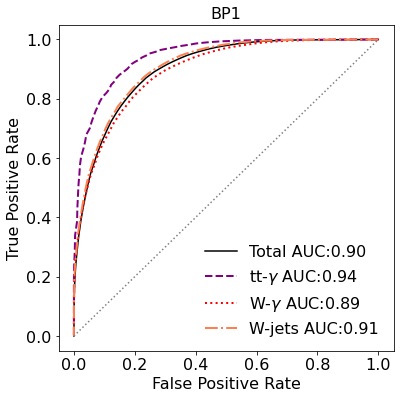

In [46]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
plt.plot(fpr_ttgamma, tpr_ttgamma, c = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$ AUC:{:.2f}'.format(auc_ttgamma))
plt.plot(fpr_wgamma, tpr_wgamma, c = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$ AUC:{:.2f}'.format(auc_wgamma))
plt.plot(fpr_wjets, tpr_wjets, c = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets AUC:{:.2f}'.format(auc_wjets))
plt.legend(frameon=False,fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"BP" + str(bp + 1),fontsize=16)

plt.savefig('../graph/ROC_BP' + str(bp + 1) + '_All_MET200_new.png', bbox_inches='tight')

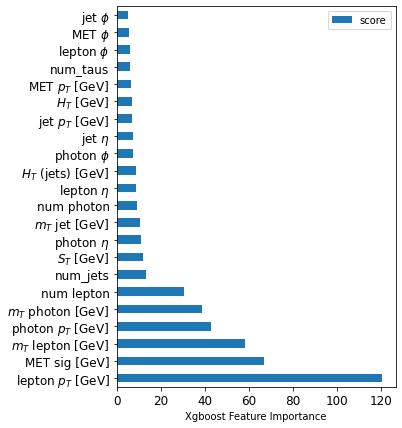

In [47]:
fig, ax = plt.subplots(figsize = (5,7))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("Xgboost Feature Importance")
ax.set_yticklabels(np.asarray(lst)[np.argsort(values)[::-1]])

plt.savefig('../graph/BP' + str(bp + 1) + '_featureImportance_All_MET200_new.png', bbox_inches='tight')

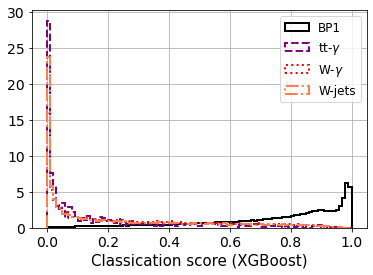

In [48]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'BP' + str(bp + 1), lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('../graph/MLOutput_dist_BP' + str(bp + 1) + '_All_MET200_new.png', bbox_inches="tight")

In [49]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [50]:
len(np.where(bkg_flag_test != 0)[0])

52534

In [51]:
len(np.where(bkg_flag_test == 0)[0])

150768

In [52]:
S_expected[bp]

81.42521191306237

In [53]:
S_expected[bp] / np.sqrt(B_expected)

0.5043941787085761

In [54]:
print('MLL aproximated Z:')
print( MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, int(B_expected), int(S_expected[bp]))) 

MLL aproximated Z:
nan


/tmp/ipykernel_1205009/1019789035.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return (f0 + fB + fS)**0.5


## Sequential selection criteria

In [307]:
nbins = 10
indices_aux = np.arange(len(df_test_array))

n_np0      = len(np.where(df_test_array[:, 22] == 0)[0])

n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[:, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[:, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[:, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[:, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[:, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[:, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[:, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[:, 22] == 11)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 2), size = 100, replace = True)
random_vars = np.concatenate((np.random.choice(range(len(df_test.columns) - 3), size = len(df_test.columns) - 3, replace = False), random_vars))
#random_vars = list(np.argsort(values)[::-1])*10

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    Z_sup = np.zeros(nbins)
    Z_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        n_np      = len(np.where(df_test_array[indices_sup, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_sup, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_sup, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_sup, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_sup, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_sup, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_sup, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_sup, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_sup, 22] == 11)[0])

        wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)
  

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_sup[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_inf, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_inf, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_inf, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_inf, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_inf, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_inf, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_inf, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_inf, 22] == 11)[0])

        wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_inf[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut = np.argmax(np.asarray(Z))
    #print('Z = ' + str(Z[max_cut]))
    indices_aux = indices[max_cut]
    max_cut = np.argmax((Z_inf, Z_sup))
    if max_cut >= len(Z_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(Z_sup)]) + '; Z = ' + str(Z_sup[max_cut - len(Z_inf)]))
    #%    indices_aux = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cuts[max_cut - len(Z_sup)]) )[0]]
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(Z_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(Z_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; Z = ' + str(Z_inf[max_cut]))
    #%    indices_aux = indices_aux[np.where( (df_array[indices_aux,ivar] <= cuts[max_cut]) )[0]]
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
    
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                     zjets_expected + wz_expected + zz_expected + ww_expected + \
                     tj_expected + tb_expected + tw_expected)
if (B_expected_aux > 5) and (S_expected_aux > 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))

num_jets <= 5.0; Z = 0.5057941935994726
photon $\phi$ <= 3.142; Z = 0.5057941935994726
$H_T$ (jets) [GeV] <= 1007.2722222222224; Z = 0.5083295862586116
photon $\eta$ <= 2.369; Z = 0.5083295862586116
num lepton <= 2.0; Z = 0.5084267679039355
lepton $p_T$ [GeV] <= 184.92888888888888; Z = 0.5260582599002844
MET $\phi$ <= 3.142; Z = 0.5260582599002844
$H_T$ [GeV] <= 1114.5255555555555; Z = 0.5295298705585074
photon $p_T$ [GeV] <= 205.90777777777777; Z = 0.5398274138580057
$m_T$ jet [GeV] >= 225.1193940681378; Z = 0.5410787950883309
jet $p_T$ [GeV] <= 902.6611111111112; Z = 0.5411322385820401
num_taus <= 1.1111111111111112; Z = 0.5411990652109985
$m_T$ photon [GeV] <= 356.0572680279636; Z = 0.541486965960129
lepton $\eta$ <= 2.499; Z = 0.541486965960129
jet $\phi$ <= 3.142; Z = 0.541486965960129
num photon <= 2.111111111111111; Z = 0.5415144556792971
MET sig [GeV] >= 11.10001535132505; Z = 0.5897392529985386
$S_T$ [GeV] <= 989.2122222222221; Z = 0.5900754426484601
jet $\eta$ >= -3.440888888

In [308]:
sup_cuts

{'num_jets': 5.0,
 'photon $\\phi$': 3.142,
 '$H_T$ (jets) [GeV]': 899.9311111111111,
 'photon $\\eta$': 2.368,
 'num lepton': 1.0,
 'lepton $p_T$ [GeV]': 68.3,
 'MET $\\phi$': 3.141,
 '$H_T$ [GeV]': 887.19,
 'photon $p_T$ [GeV]': 183.72555555555556,
 '$m_T$ jet [GeV]': 1286.8969719198017,
 'jet $p_T$ [GeV]': 706.39,
 'num_taus': 1.0,
 '$m_T$ photon [GeV]': 356.0572680279636,
 'lepton $\\eta$': 2.489,
 'jet $\\phi$': 3.141,
 'num photon': 1.0,
 'MET sig [GeV]': 23.42894030550467,
 '$S_T$ [GeV]': 800.1477777777777,
 'jet $\\eta$': 3.111777777777778,
 'lepton $\\phi$': 3.14,
 'MET $p_T$ [GeV]': 613.1188888888888,
 '$m_T$ lepton [GeV]': 191.71975056693248}

In [309]:
inf_cuts

{'num_jets': -999999,
 'photon $\\phi$': -999999,
 '$H_T$ (jets) [GeV]': -999999,
 'photon $\\eta$': -999999,
 'num lepton': -999999,
 'lepton $p_T$ [GeV]': -999999,
 'MET $\\phi$': -999999,
 '$H_T$ [GeV]': -999999,
 'photon $p_T$ [GeV]': -999999,
 '$m_T$ jet [GeV]': 225.1193940681378,
 'jet $p_T$ [GeV]': -999999,
 'num_taus': -999999,
 '$m_T$ photon [GeV]': -999999,
 'lepton $\\eta$': -999999,
 'jet $\\phi$': -999999,
 'num photon': -999999,
 'MET sig [GeV]': 12.861314915069658,
 '$S_T$ [GeV]': -999999,
 'jet $\\eta$': -3.440888888888889,
 'lepton $\\phi$': -999999,
 'MET $p_T$ [GeV]': -999999,
 '$m_T$ lepton [GeV]': 99.96091394094621}

In [310]:
write = True
if write:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts_MET200_new.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open('../data/cuts/BP' + str(bp+1) + '_infCuts_MET200_new.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts_MET200_new.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open('../data/cuts/BP' + str(bp+1) + '_infCuts_MET200_new.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

In [315]:
SM_test_pool = np.where(df_test_array[:,22] > 0)[0]
NP_test_pool = np.where(df_test_array[:,22] == 0)[0]

SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
indices_aux = np.concatenate((NP_indices, SM_indices))

n_np0  = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma0  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

#indices_aux = np.arange(len(df_test_array))

variables = list(sup_cuts.keys())
for i in range(len(variables)):
    ind_var = np.where(df_test.columns == variables[i])[0][0]
    indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                            (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                           )[0]]


In [316]:

n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(n_ttgamma + n_wjets + n_wgamma + n_ttjets + \
                     n_zjets + n_wz + n_zz + n_ww + \
                     n_tj + n_tb + n_tw)
if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))



Z =  1.1137012833463373
Expected Background = 49
Expected Signal = 8


In [317]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,22] > 0)[0]
NP_test_pool = np.where(df_test_array[:,22] == 0)[0]

q0_exp = np.zeros(nexperiments)
B_observed_exp = np.zeros(nexperiments)
S_observed_exp = np.zeros(nexperiments)
for nexp in tqdm(range(nexperiments)):
    # Let's create a pseudo-experiment
    SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
    NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
    indices_aux = np.concatenate((NP_indices, SM_indices))

    #%print('At the beggining')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')
    # Let's make the cuts

    variables = list(sup_cuts.keys())
    for i in range(len(variables)):
        #print(variables[i] + '<=' + str(sup_cuts[variables[i]]))
        #print(variables[i] + '>=' + str(inf_cuts[variables[i]]))
        ind_var = np.where(df_test.columns == variables[i])[0][0]
        indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                               )[0]]

        #%print('Total:' + str(len(indices_aux)))
        #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
        #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
        #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
        #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
        #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    # Let's calculate everything
    
    n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])
    
    n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
    n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
    n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
    n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
    n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
    n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
    n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
    n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
    n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
    n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
    n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

    #%print('At the end')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 22] == 0)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')

    #S_expected_aux = n_np
    S_observed_exp[nexp] = n_np

    # Formula discovery
    B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets + \
                           n_ttjets + n_zjets + n_wz + \
                           n_zz + n_ww + n_tj + \
                           n_tb + n_tw
        
    N_observed = n_np + n_ttgamma + n_wgamma + n_wjets+ \
                 n_ttjets + n_zjets + n_wz + \
                 n_zz + n_ww + n_tj + \
                 n_tb + n_tw
    
    if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
        q0_exp[nexp] = -2 * N_observed * np.log(B_expected_aux / N_observed) -2 * (N_observed - B_expected_aux)
        #Z_exp[nexp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
        #%print('\n')
        #%print('Z = ', Z_exp[nexp])
        #%print('Expected Background = ' + str(B_expected_aux))
        #%print('Expected Signal = ' + str(S_expected_aux))
    else:
        q0_exp[nexp] = -99
        #print('Expected Background = ' + str(B_observed_exp))
        #print('Expected Signal = ' + str(S_observed_exp))
    #%print('------------------------------------------')
        

100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 181.41it/s]


(array([  7.,  15., 110., 259., 529., 440., 433., 142.,  52.,  13.]),
 array([35. , 38.5, 42. , 45.5, 49. , 52.5, 56. , 59.5, 63. , 66.5, 70. ]),
 <BarContainer object of 10 artists>)

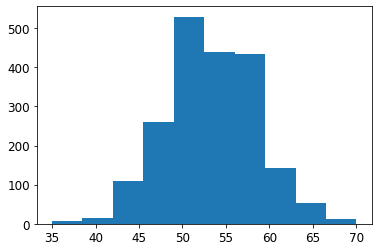

In [318]:
plt.hist(B_observed_exp)

(array([ 27., 166., 425., 574., 260., 346., 138.,  49.,  10.,   5.]),
 array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. , 11.8, 13.6, 15.4, 17.2, 19. ]),
 <BarContainer object of 10 artists>)

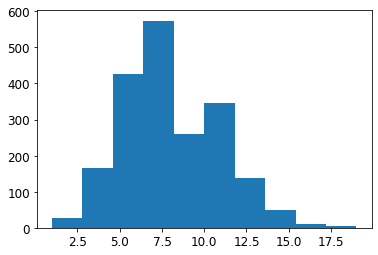

In [319]:
plt.hist(S_observed_exp)

In [320]:
q0_exp

array([1.9146232 , 1.9146232 , 0.08054413, ..., 0.70641758, 5.3141466 ,
       1.9146232 ])

(array([800., 521., 424., 141.,  77.,  19.,  14.,   2.,   1.,   1.]),
 array([ 0.        ,  2.05514121,  4.11028242,  6.16542364,  8.22056485,
        10.27570606, 12.33084727, 14.38598849, 16.4411297 , 18.49627091,
        20.55141212]),
 <BarContainer object of 10 artists>)

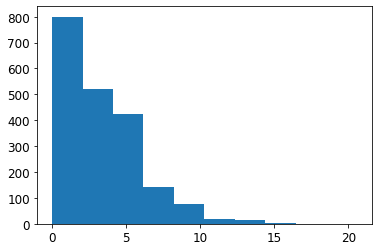

In [321]:
plt.hist(q0_exp)

In [322]:
print('Final results: for BP ' + str(bp+1) + '\n ')
print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))

Final results: for BP 1
 
Z = 1.6506165695422792; Z_std = 0.8138107087703003
B_exp = 53.045; B_exp_std = 5.113117933316226
S_exp = 7.9555; S_exp_std = 2.784873381322749


In [266]:
np.asarray(lst)[np.argsort(values)[::-1]][:4]

array(['lepton $p_T$ [GeV]', 'MET sig [GeV]', '$m_T$ lepton [GeV]',
       'photon $p_T$ [GeV]'], dtype='<U18')

In [226]:
imp_vars = np.asarray(lst)[np.argsort(values)[::-1]][:4]
imp_vars = np.array(['lepton $p_T$ [GeV]', 'MET sig [GeV]','$m_T$ lepton [GeV]', '$m_T$ photon [GeV]'])


In [227]:
imp_vars

array(['lepton $p_T$ [GeV]', 'MET sig [GeV]', '$m_T$ lepton [GeV]',
       '$m_T$ photon [GeV]'], dtype='<U18')

In [228]:
imp_vars_labels = ['$p_T^{\ell_{1}}$', '$E_T^{miss}/\sqrt{H_T}$',
                   '$m_T^{\ell_1}$','$m_T^{\gamma_1}$']

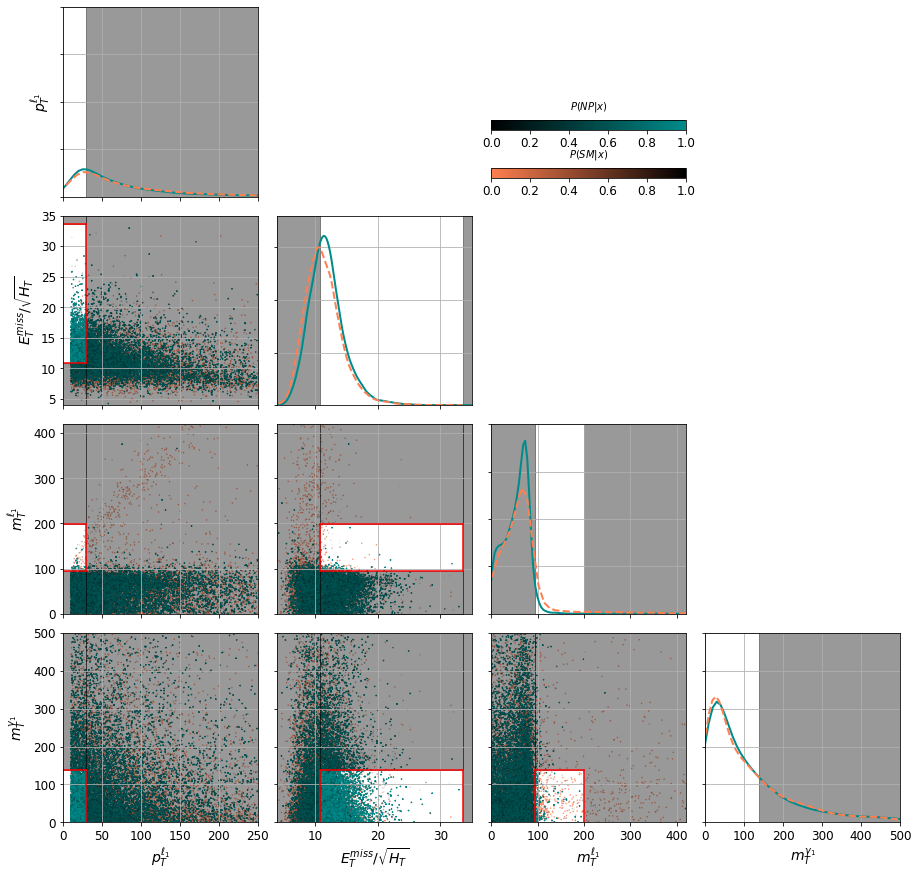

In [229]:
SM = df_test.loc[df_test['bkg_flag_pool'] != 0]
NP = df_test.loc[df_test['bkg_flag_pool'] == 1]

pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

rand_ind = np.random.choice(range(len(NP)), size =  10000, replace = False)
NP = NP.iloc[rand_ind]
pred_XG_NP = pred_XG_NP[rand_ind]

rand_ind = np.random.choice(range(len(SM)), size =  10000, replace = False)
SM = SM.iloc[rand_ind]
pred_XG_SM = pred_XG_SM[rand_ind]

limites = [[0,250], [4,35], [0,420], [0,500]]
ylimites = [[0,0.08], [0,0.18], [0,0.02], [0,0.01]]

fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = '--')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].set_ylim(ylimites[i])
            else:
                im_SM = ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 0.8, marker = '.', 
                                        c = pred_XG_SM, cmap = SM_cmap, vmin = 0, vmax = 1, alpha = (1-pred_XG_SM))
                im_NP = ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 0.8, marker = '*', 
                                        c = pred_XG_NP, cmap = NP_cmap, vmin = 0, vmax = 1, alpha = pred_XG_NP)
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = sup_cuts[imp_vars[j]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = -1, x2 = inf_cuts[imp_vars[j]], color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = sup_cuts[imp_vars[i]], y2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = -1, y2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel(imp_vars_labels[0], fontsize = 14)
ax[3,1].set_xlabel(imp_vars_labels[1], fontsize = 14)
ax[3,2].set_xlabel(imp_vars_labels[2], fontsize = 14)
ax[3,3].set_xlabel(imp_vars_labels[3], fontsize = 14)

ax[0,0].set_ylabel(imp_vars_labels[0], fontsize = 14)
ax[1,0].set_ylabel(imp_vars_labels[1], fontsize = 14)
ax[2,0].set_ylabel(imp_vars_labels[2], fontsize = 14)
ax[3,0].set_ylabel(imp_vars_labels[3], fontsize = 14)

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])

cbar_SM = plt.colorbar(im_SM, ax = ax[0,2], orientation = 'horizontal')
cbar_SM.set_label('$P(SM|x)$', labelpad=-50)
cbar_NP = plt.colorbar(im_NP, ax = ax[0,2], orientation = 'horizontal')
cbar_NP.set_label('$P(NP|x)$', labelpad=-50)

plt.savefig('../graph/BP' + str(bp+1) + '/ImpVars_dist_MET200_new.pdf')

## BinnedLikelihood

In [267]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(52534,)
(150768,)


In [268]:
B_expected = int(B_expected)

In [269]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, int(B_expected), range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  170 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  170
range of our data:  [[0, 1]]


In [270]:
# Z Poisson Bin Likelihood (Asimov data set)
D_or_E = 'discovery'
store_Z_asimov = []

Z_asimov = Z_BL_asimov(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), 25, range_dat, MIN_EVS, linear_bins=True) 
store_Z_asimov.append( Z_asimov )
    
    
print('\n FINAL RESULT for BP' + str(bp+1) + ':\n')
print(store_Z_asimov)


 FINAL RESULT for BP1:

[1.9802754647825263]


B_expected:  26060
S_expected:  81.42521191306237

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


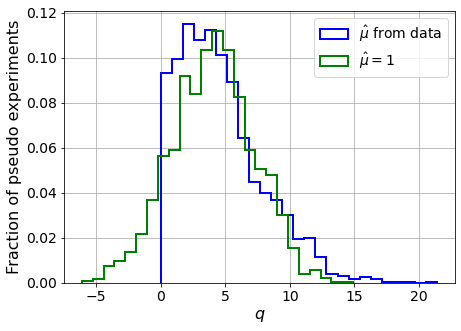

muhat mean:  1.035525
Z_bins:  2.021457591429074
std Z_bins:  0.8033443877974019
Z_bins mu=0:  2.021509496942973
std Z_bins mu=0:  0.7839002703248458

--------


 FINAL RESULT:

[[2.021457591429074, 0.8033443877974019, 1.035525, 2.021509496942973, 0.7839002703248458]]


In [271]:
# requested number of pseudo experiments
num_pseudo = 2000

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

B_expected:  26060
S_expected:  81.42521191306237

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


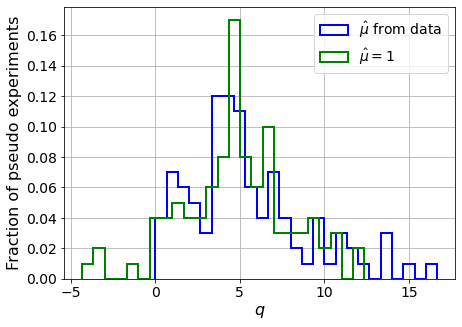

muhat mean:  1.1138028615043836
Z_bins:  2.1693719915624183
std Z_bins:  0.814109052769821
Z_bins mu=0:  2.1628347342081597
std Z_bins mu=0:  0.7458362692443263

--------


 FINAL RESULT:

[[2.1693719915624183, 0.814109052769821, 1.1138028615043836, 2.1628347342081597, 0.7458362692443263]]


In [272]:
# requested number of pseudo experiments
num_pseudo = 100

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

## loop pseudo exps. Fix ML and KDE

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  2711.37220722
  2605.76672645  2471.96687306  2306.72883689  2125.62295396
  1898.01806677  1601.62075194  1251.22505673   832.27001277
   322.35403716  -285.61482491 -1023.87015973 -2093.690537  ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf


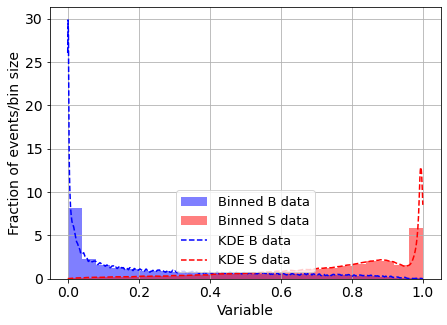

KDE Kernel:  epanechnikov
Background bandwidth:  0.0031053121543406503
Signal bandwidth:  0.008287452507534925


In [175]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        20000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

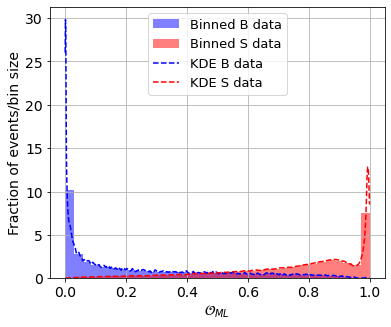

In [176]:
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

# points
s_vals = np.linspace(min_val,max_val,1000)

# evaluate the PDFs for each value of s
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# normalize
dens_bkg = dens_bkg / norm_factor_SM
dens_sig = dens_sig / norm_factor_NP

plt.figure(figsize=(6,5))

plt.hist(pred_XG_SM, 35, range=[min_val,max_val], density=True, color='blue',alpha=0.5, linewidth=2, label=r'Binned B data');
plt.hist(pred_XG_NP, 35, range=[min_val,max_val], density=True, color='red',alpha=0.5, linewidth=2, label=r'Binned S data');

plt.plot(s_vals, dens_bkg, color='blue',label=r'KDE B data',linestyle='dashed');
plt.plot(s_vals, dens_sig, color='red',label=r'KDE S data',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yscale('log')
plt.xlabel("$\mathcal{O}_{ML}$",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)

plt.savefig('../graph/KDE_fit_BP' + str(bp+1) + '_MET200.pdf')

In [177]:
print(norm_factor_SM)
print(norm_factor_NP)

266.14753662758187
100.28423277903755


In [178]:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

This may take a while...
1 done
2 done


In [179]:
# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP
   

3 done
4 done


(array([58814., 60445.,  2955.,  2069.,  1720.,  1353.,  1268.,  3061.,
         5951., 13132.]),
 array([ 0.01698118,  1.30242448,  2.58786778,  3.87331107,  5.15875437,
         6.44419767,  7.72964097,  9.01508427, 10.30052756, 11.58597086,
        12.87141416]),
 [<matplotlib.patches.Polygon at 0x7efd5342bd60>])

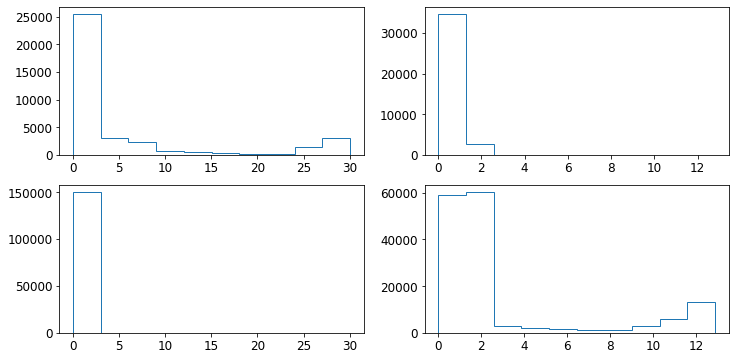

In [180]:
fig,ax = plt.subplots(2,2, figsize = (12,6))

ax[0,0].hist(pB_B_data, histtype = 'step')
ax[0,1].hist(pS_B_data, histtype = 'step')

ax[1,0].hist(pB_S_data, histtype = 'step')
ax[1,1].hist(pS_S_data, histtype = 'step')

In [181]:
# indeces (to later build a random pseudo experiment)
indices_B = [i for i in range(len(pS_B_data))]
indices_S = [i for i in range(len(pS_S_data))]
        
        

In [182]:
# loop over the number of pseudo experiments
#np.random.seed(91218)
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(3): 
    print(iloop)
    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(200)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )
            
    

    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

0


  4%|██▋                                                                 | 8/200 [00:02<00:52,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3720336407504086
<p_{s}(Sdata)> = 2.964722663540827
<p_{b}(Bdata)> = 5.592528319237187
<p_{s}(Bdata)> = 0.40504091570382283


100%|██████████████████████████████████████████████████████████████████| 200/200 [00:58<00:00,  3.42it/s]


1


100%|██████████████████████████████████████████████████████████████████| 200/200 [01:02<00:00,  3.21it/s]


2


 48%|████████████████████████████████▏                                  | 96/200 [00:27<00:28,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5363417464870184
<p_{s}(Sdata)> = 2.1614090995550552
<p_{b}(Bdata)> = 5.595212159875739
<p_{s}(Bdata)> = 0.4057559256839425


 50%|█████████████████████████████████▏                                 | 99/200 [00:28<00:27,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5139697625411936
<p_{s}(Sdata)> = 2.532399185603165
<p_{b}(Bdata)> = 5.623472240825144
<p_{s}(Bdata)> = 0.4034399653275438


100%|██████████████████████████████████████████████████████████████████| 200/200 [00:57<00:00,  3.49it/s]


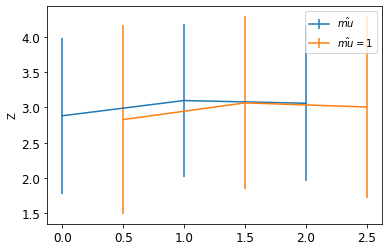

In [185]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP' + str(bp+1) + '_KDEfijo_MET200.pdf')

In [192]:
print('Z_MLL BP' + str(bp+1) + ': ' + str(np.mean(Z_MLL)) + ' +/- ' + str(np.std(Z_MLL))+
      ' +/- ' + str(np.mean(Z_MLL_std)))

Z_MLL BP1: 3.013632929980421 +/- 0.09409184220745251 +/- 1.098003789029043


## Loop varying KDE

In [ ]:
B_expected

In [ ]:
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(20):
    print(iloop)
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(50)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

In [ ]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP6_50000_KDEvariable__MET200.pdf')

## loop varying ML

In [55]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

0
AUC:0.9025775474526706
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


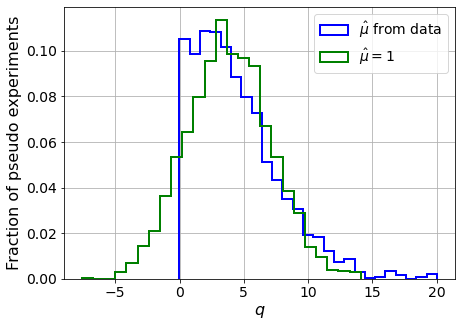

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  6853.86045267
  6576.8752745   6227.27355726  5805.86826536  5295.11369805
  4676.62026356  3924.9917405   3018.18605166  1939.47307605
   646.71110451  -906.10724836 -2744.63721274 -5313.59258314]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  4311.35215211  4317.93911222


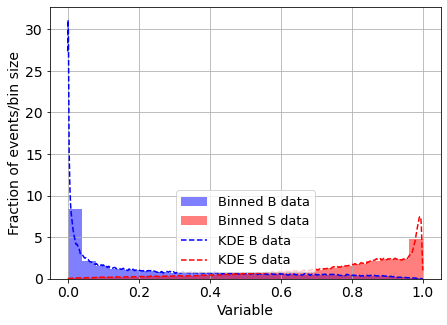

KDE Kernel:  epanechnikov
Background bandwidth:  0.0031053121543406503
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.009851082727075012
0.009851082727075012
3 done
4 done
0.0034681040272987705
0.0034681040272987705


  1%|▋                                                                 | 20/2000 [00:05<09:09,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4491899693968126
<p_{s}(Sdata)> = 1.807954712180505
<p_{b}(Bdata)> = 6.014102237088232
<p_{s}(Bdata)> = 0.4194326350329658


  1%|▉                                                                 | 27/2000 [00:07<10:04,  3.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39940572111035727
<p_{s}(Sdata)> = 2.1715326948395486
<p_{b}(Bdata)> = 6.016940604239096
<p_{s}(Bdata)> = 0.41714766258735425


  2%|█                                                                 | 31/2000 [00:09<10:10,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43467149630695734
<p_{s}(Sdata)> = 2.137460485478409
<p_{b}(Bdata)> = 5.975309170513685
<p_{s}(Bdata)> = 0.4193475934235029


  2%|█                                                                 | 34/2000 [00:09<08:29,  3.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37174114742709724
<p_{s}(Sdata)> = 2.35826188153748
<p_{b}(Bdata)> = 6.0135150291017085
<p_{s}(Bdata)> = 0.4207938418055557


  4%|██▎                                                               | 71/2000 [00:21<09:04,  3.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39877712323967673
<p_{s}(Sdata)> = 2.219266777242626
<p_{b}(Bdata)> = 6.07536499403671
<p_{s}(Bdata)> = 0.41897755933611286


  4%|██▊                                                               | 85/2000 [00:25<08:01,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38496531166615283
<p_{s}(Sdata)> = 2.2434949855480144
<p_{b}(Bdata)> = 6.0387110081083035
<p_{s}(Bdata)> = 0.4167592777087039


  5%|███▎                                                             | 103/2000 [00:30<08:05,  3.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45604919143014916
<p_{s}(Sdata)> = 1.857304619625671
<p_{b}(Bdata)> = 6.002166869811992
<p_{s}(Bdata)> = 0.41889432245911434


  5%|███▌                                                             | 108/2000 [00:32<09:22,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41886786266546977
<p_{s}(Sdata)> = 2.274703390344327
<p_{b}(Bdata)> = 5.971627929779444
<p_{s}(Bdata)> = 0.4191188538581897


  6%|███▋                                                             | 114/2000 [00:33<08:54,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4532536176941034
<p_{s}(Sdata)> = 2.244019610318924
<p_{b}(Bdata)> = 5.975818211461658
<p_{s}(Bdata)> = 0.42183077214224984


  7%|████▎                                                            | 132/2000 [00:38<10:02,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43805058275273234
<p_{s}(Sdata)> = 2.107924135439167
<p_{b}(Bdata)> = 6.170544127945236
<p_{s}(Bdata)> = 0.4169402956674009


  7%|████▍                                                            | 137/2000 [00:40<10:07,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48181835914419613
<p_{s}(Sdata)> = 1.9310026828173468
<p_{b}(Bdata)> = 5.938405549093263
<p_{s}(Bdata)> = 0.4222607371815732


  8%|█████                                                            | 155/2000 [00:45<09:48,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47108233802831095
<p_{s}(Sdata)> = 1.939998568252331
<p_{b}(Bdata)> = 5.967682580140701
<p_{s}(Bdata)> = 0.42023651892690356


  9%|█████▋                                                           | 174/2000 [00:51<10:43,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5054548881658582
<p_{s}(Sdata)> = 2.1559638271344124
<p_{b}(Bdata)> = 6.014636670053918
<p_{s}(Bdata)> = 0.41585299822015837


  9%|█████▋                                                           | 176/2000 [00:51<07:50,  3.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42487920928647277
<p_{s}(Sdata)> = 1.8557761111055018
<p_{b}(Bdata)> = 6.059113898122089
<p_{s}(Bdata)> = 0.42056576115844546


  9%|█████▉                                                           | 184/2000 [00:53<05:51,  5.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4090081617098919
<p_{s}(Sdata)> = 2.399907918649029
<p_{b}(Bdata)> = 5.907842482804449
<p_{s}(Bdata)> = 0.417784473924496
muhat = -0.1
<p_{b}(Sdata)> = 0.43769906070326536
<p_{s}(Sdata)> = 1.9816166059543223
<p_{b}(Bdata)> = 5.9353450076255925
<p_{s}(Bdata)> = 0.422335333865451


  9%|██████                                                           | 186/2000 [00:53<07:07,  4.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39601436432896314
<p_{s}(Sdata)> = 2.0938614236954636
<p_{b}(Bdata)> = 5.9758808188908
<p_{s}(Bdata)> = 0.42188889892558024


 10%|██████▎                                                          | 194/2000 [00:56<08:49,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41833318068524306
<p_{s}(Sdata)> = 1.8801271249616862
<p_{b}(Bdata)> = 6.021031394345332
<p_{s}(Bdata)> = 0.4244995983780115


 10%|██████▌                                                          | 202/2000 [00:58<07:12,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3849262876210276
<p_{s}(Sdata)> = 2.402540849770328
<p_{b}(Bdata)> = 6.002726215410136
<p_{s}(Bdata)> = 0.42086274639486865


 11%|███████                                                          | 219/2000 [01:03<08:32,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48638175516421117
<p_{s}(Sdata)> = 1.9954416861392752
<p_{b}(Bdata)> = 6.004119740726923
<p_{s}(Bdata)> = 0.42206675339538174


 11%|███████▏                                                         | 222/2000 [01:03<07:59,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.440623958234555
<p_{s}(Sdata)> = 2.118632099313357
<p_{b}(Bdata)> = 6.007964378286367
<p_{s}(Bdata)> = 0.42088102763128327


 11%|███████▍                                                         | 227/2000 [01:05<09:09,  3.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44453059832246133
<p_{s}(Sdata)> = 1.9420910990853197
<p_{b}(Bdata)> = 6.03199384190522
<p_{s}(Bdata)> = 0.418534619549122


 12%|███████▍                                                         | 230/2000 [01:06<07:07,  4.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39534995782072685
<p_{s}(Sdata)> = 2.1701307773093967
<p_{b}(Bdata)> = 5.914195963116861
<p_{s}(Bdata)> = 0.41897732333213555


 12%|███████▊                                                         | 240/2000 [01:09<08:55,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4588248939459917
<p_{s}(Sdata)> = 2.1780831566310845
<p_{b}(Bdata)> = 6.077138176420436
<p_{s}(Bdata)> = 0.4197020597650577


 13%|████████▎                                                        | 257/2000 [01:14<08:28,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4457950284646206
<p_{s}(Sdata)> = 1.94643657533305
<p_{b}(Bdata)> = 5.919749504569741
<p_{s}(Bdata)> = 0.4213105734045697


 14%|████████▉                                                        | 276/2000 [01:20<09:06,  3.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4374342133962442
<p_{s}(Sdata)> = 2.0008553264647726
<p_{b}(Bdata)> = 5.904019678677963
<p_{s}(Bdata)> = 0.42613173378564695


 14%|█████████▏                                                       | 282/2000 [01:22<09:41,  2.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4552625499284176
<p_{s}(Sdata)> = 1.8933215039714788
<p_{b}(Bdata)> = 6.036262308575573
<p_{s}(Bdata)> = 0.419437972990859


 15%|█████████▋                                                       | 298/2000 [01:26<07:12,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4291236538525641
<p_{s}(Sdata)> = 2.131743630416723
<p_{b}(Bdata)> = 5.854126759307093
<p_{s}(Bdata)> = 0.4229110633861208


 17%|██████████▊                                                      | 331/2000 [01:35<08:27,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.414060782358169
<p_{s}(Sdata)> = 2.0155177870136822
<p_{b}(Bdata)> = 6.022177179781201
<p_{s}(Bdata)> = 0.422205066863231


 18%|███████████▊                                                     | 363/2000 [01:44<06:13,  4.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43122368807360534
<p_{s}(Sdata)> = 2.0507860285362027
<p_{b}(Bdata)> = 6.058974628613379
<p_{s}(Bdata)> = 0.4184452613309218


 18%|███████████▊                                                     | 364/2000 [01:45<07:19,  3.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44356968859230184
<p_{s}(Sdata)> = 2.033015693860836
<p_{b}(Bdata)> = 6.002826616813257
<p_{s}(Bdata)> = 0.4221135350045615


 19%|████████████▎                                                    | 378/2000 [01:48<06:31,  4.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39801490191449695
<p_{s}(Sdata)> = 2.2835080946282313
<p_{b}(Bdata)> = 5.9633297947172945
<p_{s}(Bdata)> = 0.4225558409735449


 19%|████████████▍                                                    | 383/2000 [01:50<08:02,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4588793715044572
<p_{s}(Sdata)> = 1.8392341563391204
<p_{b}(Bdata)> = 6.066023744608864
<p_{s}(Bdata)> = 0.4193802801051387


 20%|████████████▊                                                    | 395/2000 [01:53<05:48,  4.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4462884142598248
<p_{s}(Sdata)> = 2.1895008434469765
<p_{b}(Bdata)> = 5.891490191851885
<p_{s}(Bdata)> = 0.4226608011025276


 20%|████████████▊                                                    | 396/2000 [01:53<05:55,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4753287870522605
<p_{s}(Sdata)> = 1.5997501400449905
<p_{b}(Bdata)> = 5.981340788725933
<p_{s}(Bdata)> = 0.4240466847278344


 20%|████████████▉                                                    | 399/2000 [01:54<07:23,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4065633601946905
<p_{s}(Sdata)> = 2.285042896109086
<p_{b}(Bdata)> = 5.955029169562633
<p_{s}(Bdata)> = 0.4171599431500755


 20%|█████████████▏                                                   | 404/2000 [01:56<07:06,  3.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.411207046889647
<p_{s}(Sdata)> = 2.0016697092204723
<p_{b}(Bdata)> = 5.944550693143562
<p_{s}(Bdata)> = 0.4213657494947057


 20%|█████████████▏                                                   | 406/2000 [01:56<06:46,  3.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4948114207617265
<p_{s}(Sdata)> = 1.9713872889624962
<p_{b}(Bdata)> = 5.893628084411854
<p_{s}(Bdata)> = 0.4261732460893869


 21%|█████████████▊                                                   | 426/2000 [02:03<08:38,  3.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42532584221152525
<p_{s}(Sdata)> = 1.9309915438319492
<p_{b}(Bdata)> = 5.95908036235121
<p_{s}(Bdata)> = 0.42022556531497285


 23%|██████████████▋                                                  | 451/2000 [02:09<05:53,  4.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4446825626470294
<p_{s}(Sdata)> = 1.8332077392173238
<p_{b}(Bdata)> = 5.9858213032037595
<p_{s}(Bdata)> = 0.4226217741803172


 23%|██████████████▋                                                  | 453/2000 [02:10<05:46,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4597587480337545
<p_{s}(Sdata)> = 2.1537144608465093
<p_{b}(Bdata)> = 5.988254320521839
<p_{s}(Bdata)> = 0.4211891517970693


 23%|██████████████▊                                                  | 457/2000 [02:11<05:39,  4.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49674520774191433
<p_{s}(Sdata)> = 1.6798746728741476
<p_{b}(Bdata)> = 6.0002099819980055
<p_{s}(Bdata)> = 0.41909327359313703


 23%|███████████████▏                                                 | 468/2000 [02:14<05:45,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4490500803024614
<p_{s}(Sdata)> = 1.9346834152031396
<p_{b}(Bdata)> = 5.9616116911920995
<p_{s}(Bdata)> = 0.4216805205608337


 24%|███████████████▎                                                 | 470/2000 [02:14<04:53,  5.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4143846959349083
<p_{s}(Sdata)> = 2.143387599718403
<p_{b}(Bdata)> = 6.034852452772952
<p_{s}(Bdata)> = 0.42182866567443067


 24%|███████████████▍                                                 | 476/2000 [02:16<06:43,  3.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4679803842808675
<p_{s}(Sdata)> = 1.7846604175154628
<p_{b}(Bdata)> = 6.004833609331689
<p_{s}(Bdata)> = 0.42364402503220305


 25%|████████████████▎                                                | 503/2000 [02:24<07:40,  3.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4168193813648959
<p_{s}(Sdata)> = 2.1684802641851713
<p_{b}(Bdata)> = 6.065113611762334
<p_{s}(Bdata)> = 0.42032221842563244


 25%|████████████████▍                                                | 506/2000 [02:25<06:12,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4685052688675841
<p_{s}(Sdata)> = 1.8537975714051595
<p_{b}(Bdata)> = 5.968528528813979
<p_{s}(Bdata)> = 0.4226701418503744


 26%|████████████████▌                                                | 511/2000 [02:26<06:54,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4068196618665054
<p_{s}(Sdata)> = 2.0866494756504506
<p_{b}(Bdata)> = 6.057368934374334
<p_{s}(Bdata)> = 0.40985795456306495


 27%|█████████████████▎                                               | 532/2000 [02:33<08:09,  3.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45712338557642457
<p_{s}(Sdata)> = 1.6892329713292968
<p_{b}(Bdata)> = 5.970095277470652
<p_{s}(Bdata)> = 0.4220283269742772


 27%|█████████████████▎                                               | 534/2000 [02:33<06:52,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4672997618442256
<p_{s}(Sdata)> = 2.0976319302281095
<p_{b}(Bdata)> = 6.127930870895799
<p_{s}(Bdata)> = 0.4213589468671931


 28%|██████████████████▏                                              | 559/2000 [02:41<07:31,  3.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4507384680875459
<p_{s}(Sdata)> = 2.23464345784026
<p_{b}(Bdata)> = 5.961787058985127
<p_{s}(Bdata)> = 0.42672457770545374


 28%|██████████████████▌                                              | 570/2000 [02:44<06:29,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5076009630094298
<p_{s}(Sdata)> = 1.8765307560313045
<p_{b}(Bdata)> = 6.12357108072665
<p_{s}(Bdata)> = 0.42117725027515535


 29%|██████████████████▊                                              | 578/2000 [02:47<09:29,  2.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40448977417599236
<p_{s}(Sdata)> = 2.1426130965899035
<p_{b}(Bdata)> = 5.9366822795498235
<p_{s}(Bdata)> = 0.4196399587643095


 31%|████████████████████▏                                            | 620/2000 [03:00<06:02,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4117572361028806
<p_{s}(Sdata)> = 2.0385617742561046
<p_{b}(Bdata)> = 6.038894135735
<p_{s}(Bdata)> = 0.42032632056206093


 32%|████████████████████▊                                            | 640/2000 [03:06<06:57,  3.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3865274586398131
<p_{s}(Sdata)> = 2.22491950238494
<p_{b}(Bdata)> = 6.0216341205492325
<p_{s}(Bdata)> = 0.41916284021853223


 33%|█████████████████████▋                                           | 666/2000 [03:15<06:34,  3.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8185744051402393
<p_{s}(Sdata)> = 1.9286134451386574
<p_{b}(Bdata)> = 5.902057213992507
<p_{s}(Bdata)> = 0.4295851583403073


 34%|██████████████████████                                           | 680/2000 [03:18<05:51,  3.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4315754537213433
<p_{s}(Sdata)> = 1.7709415014893222
<p_{b}(Bdata)> = 6.008504405886583
<p_{s}(Bdata)> = 0.42318651814760533


 35%|██████████████████████▌                                          | 693/2000 [03:22<04:57,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3351754203562265
<p_{s}(Sdata)> = 2.460917929701671
<p_{b}(Bdata)> = 6.035624780485259
<p_{s}(Bdata)> = 0.4208735894104088


 35%|██████████████████████▉                                          | 707/2000 [03:25<04:18,  4.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4546408009060185
<p_{s}(Sdata)> = 1.7411382591768598
<p_{b}(Bdata)> = 6.007939116975238
<p_{s}(Bdata)> = 0.4217067703148677


 36%|███████████████████████▎                                         | 716/2000 [03:28<04:39,  4.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37031667425622616
<p_{s}(Sdata)> = 2.334408065856896
<p_{b}(Bdata)> = 5.978379214907398
<p_{s}(Bdata)> = 0.4193913024426564
muhat = -0.1
<p_{b}(Sdata)> = 0.423414736366272
<p_{s}(Sdata)> = 2.2210936229852885
<p_{b}(Bdata)> = 5.954823579743871
<p_{s}(Bdata)> = 0.4239355907319607


 37%|███████████████████████▉                                         | 735/2000 [03:34<07:43,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39161498916614773
<p_{s}(Sdata)> = 2.097952128033615
<p_{b}(Bdata)> = 5.887876454939414
<p_{s}(Bdata)> = 0.41780935472244135


 37%|████████████████████████                                         | 739/2000 [03:35<06:14,  3.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4251429920540781
<p_{s}(Sdata)> = 2.08169576029859
<p_{b}(Bdata)> = 6.11940895399361
<p_{s}(Bdata)> = 0.4184318474808695


 38%|████████████████████████▌                                        | 755/2000 [03:40<07:08,  2.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.480832637952059
<p_{s}(Sdata)> = 1.9446665809283252
<p_{b}(Bdata)> = 6.012390608905201
<p_{s}(Bdata)> = 0.4167147902976266


 39%|█████████████████████████▋                                       | 789/2000 [03:51<07:57,  2.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4317873549357585
<p_{s}(Sdata)> = 2.016282121272006
<p_{b}(Bdata)> = 5.9942459497424805
<p_{s}(Bdata)> = 0.4240292875088548


 40%|█████████████████████████▊                                       | 795/2000 [03:52<07:08,  2.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43957640310907703
<p_{s}(Sdata)> = 2.102676306975487
<p_{b}(Bdata)> = 5.966515400722164
<p_{s}(Bdata)> = 0.4235252877742884


 40%|██████████████████████████                                       | 800/2000 [03:54<06:43,  2.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44812098410137413
<p_{s}(Sdata)> = 2.032874878606751
<p_{b}(Bdata)> = 5.9803487695621325
<p_{s}(Bdata)> = 0.42235244528716215


 41%|██████████████████████████▍                                      | 815/2000 [03:59<07:18,  2.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4992754766576944
<p_{s}(Sdata)> = 1.6992703184573972
<p_{b}(Bdata)> = 6.003616971003292
<p_{s}(Bdata)> = 0.426919168272185


 41%|██████████████████████████▋                                      | 821/2000 [04:00<05:12,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43714564116798715
<p_{s}(Sdata)> = 1.9066146678906968
<p_{b}(Bdata)> = 6.015922741621813
<p_{s}(Bdata)> = 0.4191245122472033


 42%|███████████████████████████▍                                     | 844/2000 [04:07<05:10,  3.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5283206917427306
<p_{s}(Sdata)> = 1.8157943613874323
<p_{b}(Bdata)> = 6.0521450178815535
<p_{s}(Bdata)> = 0.41955187941294153


 43%|███████████████████████████▉                                     | 861/2000 [04:12<06:45,  2.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40396649207586455
<p_{s}(Sdata)> = 1.9107520916159824
<p_{b}(Bdata)> = 5.981124599089848
<p_{s}(Bdata)> = 0.4238658562912151


 44%|████████████████████████████▎                                    | 872/2000 [04:15<06:10,  3.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.488229400533802
<p_{s}(Sdata)> = 1.8484843697860573
<p_{b}(Bdata)> = 6.068978354051485
<p_{s}(Bdata)> = 0.4181724744807843


 44%|████████████████████████████▋                                    | 881/2000 [04:18<06:09,  3.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4574547922642348
<p_{s}(Sdata)> = 2.069208916689872
<p_{b}(Bdata)> = 5.897094819316315
<p_{s}(Bdata)> = 0.42498200814251486


 45%|████████████████████████████▉                                    | 891/2000 [04:21<05:22,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42833473399525857
<p_{s}(Sdata)> = 1.9850493386127277
<p_{b}(Bdata)> = 6.049914916339459
<p_{s}(Bdata)> = 0.42040460006230107


 45%|█████████████████████████████▏                                   | 899/2000 [04:24<06:56,  2.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39594685460515966
<p_{s}(Sdata)> = 2.1572874294973348
<p_{b}(Bdata)> = 6.018031391790841
<p_{s}(Bdata)> = 0.4228180480580585


 45%|█████████████████████████████▍                                   | 905/2000 [04:26<06:57,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44326512971595783
<p_{s}(Sdata)> = 2.2523857567470724
<p_{b}(Bdata)> = 5.989084363913934
<p_{s}(Bdata)> = 0.42403068119987775


 45%|█████████████████████████████▍                                   | 907/2000 [04:26<06:12,  2.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47525407228924976
<p_{s}(Sdata)> = 1.9532801031987714
<p_{b}(Bdata)> = 5.941743155557799
<p_{s}(Bdata)> = 0.4189731104610854


 46%|█████████████████████████████▌                                   | 910/2000 [04:27<05:30,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4409279892670249
<p_{s}(Sdata)> = 2.162631703007693
<p_{b}(Bdata)> = 5.988195518007511
<p_{s}(Bdata)> = 0.4165954033878983


 46%|█████████████████████████████▊                                   | 917/2000 [04:29<04:46,  3.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42682855100731515
<p_{s}(Sdata)> = 2.0731704800621524
<p_{b}(Bdata)> = 6.015736937842043
<p_{s}(Bdata)> = 0.4211793798412705


 47%|██████████████████████████████▎                                  | 934/2000 [04:34<05:16,  3.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42284682341291696
<p_{s}(Sdata)> = 2.1658182991389308
<p_{b}(Bdata)> = 5.9954459930221615
<p_{s}(Bdata)> = 0.41825935047458374


 48%|███████████████████████████████▍                                 | 966/2000 [04:44<05:50,  2.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41608021043216464
<p_{s}(Sdata)> = 2.108751265551982
<p_{b}(Bdata)> = 6.002856697569557
<p_{s}(Bdata)> = 0.42024000093078506


 48%|███████████████████████████████▍                                 | 969/2000 [04:45<05:34,  3.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47349886172623373
<p_{s}(Sdata)> = 1.9479743729054526
<p_{b}(Bdata)> = 6.030404411180015
<p_{s}(Bdata)> = 0.42113007302594235


 49%|███████████████████████████████▉                                 | 984/2000 [04:50<04:17,  3.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4852694553627279
<p_{s}(Sdata)> = 2.026717175380916
<p_{b}(Bdata)> = 6.105975221907176
<p_{s}(Bdata)> = 0.4170793399570107


 50%|████████████████████████████████▏                                | 990/2000 [04:51<03:50,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45404370875337513
<p_{s}(Sdata)> = 2.0198430977403974
<p_{b}(Bdata)> = 6.02366687841968
<p_{s}(Bdata)> = 0.42175383845618064


 51%|████████████████████████████████▉                               | 1028/2000 [05:03<03:35,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3843461910232732
<p_{s}(Sdata)> = 2.237984589067015
<p_{b}(Bdata)> = 6.015436671246334
<p_{s}(Bdata)> = 0.4178318541788133


 52%|█████████████████████████████████▏                              | 1038/2000 [05:06<04:15,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4480421049862103
<p_{s}(Sdata)> = 1.9369524237830311
<p_{b}(Bdata)> = 6.079801618347922
<p_{s}(Bdata)> = 0.4188909719208006


 52%|█████████████████████████████████▌                              | 1049/2000 [05:10<06:10,  2.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46278196145491446
<p_{s}(Sdata)> = 2.0279005833139676
<p_{b}(Bdata)> = 6.035462079612972
<p_{s}(Bdata)> = 0.422503061938886


 53%|█████████████████████████████████▋                              | 1054/2000 [05:11<04:33,  3.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4624610935801444
<p_{s}(Sdata)> = 2.0758443834864604
<p_{b}(Bdata)> = 5.9799655486922525
<p_{s}(Bdata)> = 0.4220022675959349


 53%|█████████████████████████████████▉                              | 1059/2000 [05:12<04:22,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42676367773444485
<p_{s}(Sdata)> = 2.0060292381310183
<p_{b}(Bdata)> = 5.946854387603959
<p_{s}(Bdata)> = 0.42375915098706735


 53%|██████████████████████████████████                              | 1066/2000 [05:14<03:41,  4.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47868083795215915
<p_{s}(Sdata)> = 1.7480460672958054
<p_{b}(Bdata)> = 5.991375308482766
<p_{s}(Bdata)> = 0.42401137486746215


 54%|██████████████████████████████████▍                             | 1075/2000 [05:16<02:38,  5.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.530930905125721
<p_{s}(Sdata)> = 2.2030827763587078
<p_{b}(Bdata)> = 6.0344162511857995
<p_{s}(Bdata)> = 0.42082243107392836
muhat = -0.1
<p_{b}(Sdata)> = 0.4004485593416046
<p_{s}(Sdata)> = 2.5299267093906286
<p_{b}(Bdata)> = 5.913265440557288
<p_{s}(Bdata)> = 0.41464911405793126


 54%|██████████████████████████████████▊                             | 1087/2000 [05:19<03:25,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47609007881298443
<p_{s}(Sdata)> = 1.6781837548052327
<p_{b}(Bdata)> = 5.972401781855158
<p_{s}(Bdata)> = 0.42093903707590347


 55%|██████████████████████████████████▉                             | 1091/2000 [05:21<04:51,  3.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4088085651335899
<p_{s}(Sdata)> = 2.0384642055184625
<p_{b}(Bdata)> = 5.953501745591717
<p_{s}(Bdata)> = 0.41726979942150166


 55%|███████████████████████████████████                             | 1094/2000 [05:21<03:57,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4459193963483225
<p_{s}(Sdata)> = 1.9822035098151651
<p_{b}(Bdata)> = 5.948882004276988
<p_{s}(Bdata)> = 0.42701250556847814


 56%|███████████████████████████████████▋                            | 1114/2000 [05:28<04:29,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4098710208665212
<p_{s}(Sdata)> = 1.8616162120152637
<p_{b}(Bdata)> = 6.012660030592243
<p_{s}(Bdata)> = 0.41732404507878357


 56%|███████████████████████████████████▊                            | 1119/2000 [05:29<03:59,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3714223034539238
<p_{s}(Sdata)> = 2.2729202962050827
<p_{b}(Bdata)> = 5.96123680280065
<p_{s}(Bdata)> = 0.42332558177509766


 56%|███████████████████████████████████▉                            | 1122/2000 [05:29<03:41,  3.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42717910224939315
<p_{s}(Sdata)> = 2.0469456699308965
<p_{b}(Bdata)> = 5.895309740518486
<p_{s}(Bdata)> = 0.4250164876295695


 57%|████████████████████████████████████▏                           | 1132/2000 [05:32<05:05,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4097105307747672
<p_{s}(Sdata)> = 2.0884522160443924
<p_{b}(Bdata)> = 6.026834752082854
<p_{s}(Bdata)> = 0.4215379599626759


 57%|████████████████████████████████████▎                           | 1135/2000 [05:33<03:31,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4228720825599721
<p_{s}(Sdata)> = 1.9882406728665767
<p_{b}(Bdata)> = 5.94329093185506
<p_{s}(Bdata)> = 0.42033076489423915


 57%|████████████████████████████████████▌                           | 1143/2000 [05:35<03:43,  3.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36389880927113144
<p_{s}(Sdata)> = 2.3214489932812716
<p_{b}(Bdata)> = 5.873520797810248
<p_{s}(Bdata)> = 0.4187549326631922


 57%|████████████████████████████████████▋                           | 1147/2000 [05:36<03:10,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46537536896644377
<p_{s}(Sdata)> = 2.235024413256748
<p_{b}(Bdata)> = 5.966133725536125
<p_{s}(Bdata)> = 0.4177813752650681


 58%|████████████████████████████████████▉                           | 1153/2000 [05:37<02:35,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45741311679082514
<p_{s}(Sdata)> = 2.162514769973121
<p_{b}(Bdata)> = 5.98757343939122
<p_{s}(Bdata)> = 0.41565219894743777


 58%|████████████████████████████████████▉                           | 1154/2000 [05:37<02:49,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4214758424537046
<p_{s}(Sdata)> = 1.9603811173216745
<p_{b}(Bdata)> = 5.98683435231114
<p_{s}(Bdata)> = 0.4250508924743921


 59%|█████████████████████████████████████▍                          | 1171/2000 [05:42<03:09,  4.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5089155806288447
<p_{s}(Sdata)> = 1.9821033332801037
<p_{b}(Bdata)> = 5.982884133840131
<p_{s}(Bdata)> = 0.42471848162719394


 59%|█████████████████████████████████████▊                          | 1180/2000 [05:44<04:09,  3.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44769244392082436
<p_{s}(Sdata)> = 2.274404964183077
<p_{b}(Bdata)> = 5.926491941844858
<p_{s}(Bdata)> = 0.42128980682614847


 59%|█████████████████████████████████████▉                          | 1185/2000 [05:46<03:56,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3921550699862918
<p_{s}(Sdata)> = 2.1285909408857386
<p_{b}(Bdata)> = 5.948306008111433
<p_{s}(Bdata)> = 0.42239840190863503


 59%|██████████████████████████████████████                          | 1188/2000 [05:46<02:54,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44345620738428226
<p_{s}(Sdata)> = 1.9348978988774366
<p_{b}(Bdata)> = 6.004108455922402
<p_{s}(Bdata)> = 0.4230915498535953


 60%|██████████████████████████████████████▏                         | 1193/2000 [05:47<03:18,  4.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45146366740144644
<p_{s}(Sdata)> = 2.1896043960113145
<p_{b}(Bdata)> = 6.039593205227161
<p_{s}(Bdata)> = 0.4156596269802353


 60%|██████████████████████████████████████▏                         | 1195/2000 [05:48<03:12,  4.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.424065207975533
<p_{s}(Sdata)> = 2.123995794782307
<p_{b}(Bdata)> = 6.015939885959338
<p_{s}(Bdata)> = 0.42086479208064675


 60%|██████████████████████████████████████▎                         | 1199/2000 [05:49<03:53,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4322509902277969
<p_{s}(Sdata)> = 2.048684123080471
<p_{b}(Bdata)> = 5.9412558934465585
<p_{s}(Bdata)> = 0.42195770451715264


 60%|██████████████████████████████████████▍                         | 1202/2000 [05:50<04:02,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38485973418181413
<p_{s}(Sdata)> = 2.2986431927028717
<p_{b}(Bdata)> = 5.928400006468766
<p_{s}(Bdata)> = 0.42664056142745865


 60%|██████████████████████████████████████▌                         | 1205/2000 [05:51<03:59,  3.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5078681911139519
<p_{s}(Sdata)> = 1.8600554153166875
<p_{b}(Bdata)> = 6.00205065490557
<p_{s}(Bdata)> = 0.4231126288554684


 60%|██████████████████████████████████████▋                         | 1209/2000 [05:52<03:27,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9446175957906625
<p_{s}(Sdata)> = 1.6384728736158511
<p_{b}(Bdata)> = 5.9404780683546745
<p_{s}(Bdata)> = 0.4174761969150626


 61%|███████████████████████████████████████                         | 1219/2000 [05:54<03:01,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.460661161728913
<p_{s}(Sdata)> = 1.837776489692261
<p_{b}(Bdata)> = 5.998262615301793
<p_{s}(Bdata)> = 0.42044449930001376


 62%|███████████████████████████████████████▎                        | 1230/2000 [05:58<03:46,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4629027721627423
<p_{s}(Sdata)> = 2.3268603819174487
<p_{b}(Bdata)> = 6.071415459895508
<p_{s}(Bdata)> = 0.41983265455501984


 62%|███████████████████████████████████████▋                        | 1239/2000 [06:00<02:42,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4471148078302479
<p_{s}(Sdata)> = 2.092156314125184
<p_{b}(Bdata)> = 5.925525808833047
<p_{s}(Bdata)> = 0.4239671039111795
muhat = -0.1
<p_{b}(Sdata)> = 0.4443659706127909
<p_{s}(Sdata)> = 1.8135900238992433
<p_{b}(Bdata)> = 5.982069532376479
<p_{s}(Bdata)> = 0.4236771590341146


 62%|███████████████████████████████████████▋                        | 1240/2000 [06:00<02:51,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4535700234712011
<p_{s}(Sdata)> = 2.0068585149504017
<p_{b}(Bdata)> = 5.9942664113254445
<p_{s}(Bdata)> = 0.4169297802424839


 62%|███████████████████████████████████████▊                        | 1243/2000 [06:01<02:52,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4465650533152244
<p_{s}(Sdata)> = 2.0253886181258163
<p_{b}(Bdata)> = 5.947358774072443
<p_{s}(Bdata)> = 0.4192499277829346


 62%|███████████████████████████████████████▉                        | 1247/2000 [06:02<03:30,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43373704674684116
<p_{s}(Sdata)> = 1.8452322993793546
<p_{b}(Bdata)> = 5.889330726736186
<p_{s}(Bdata)> = 0.4178981796228396


 63%|████████████████████████████████████████                        | 1252/2000 [06:04<04:09,  3.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4022976030964188
<p_{s}(Sdata)> = 2.0920197339790696
<p_{b}(Bdata)> = 6.0186391825240575
<p_{s}(Bdata)> = 0.4207155292300343


 64%|████████████████████████████████████████▉                       | 1279/2000 [06:12<03:53,  3.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44647689604962615
<p_{s}(Sdata)> = 1.99441456926994
<p_{b}(Bdata)> = 6.082210429284679
<p_{s}(Bdata)> = 0.4206483166040533


 65%|█████████████████████████████████████████▍                      | 1294/2000 [06:16<03:23,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37989556924267626
<p_{s}(Sdata)> = 2.277396648077698
<p_{b}(Bdata)> = 5.941681099138843
<p_{s}(Bdata)> = 0.42611348210985533


 65%|█████████████████████████████████████████▌                      | 1298/2000 [06:17<02:59,  3.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4284482839644227
<p_{s}(Sdata)> = 2.1172002253132294
<p_{b}(Bdata)> = 5.928243687644577
<p_{s}(Bdata)> = 0.42145518355131734


 65%|█████████████████████████████████████████▋                      | 1301/2000 [06:17<02:43,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3795837414431094
<p_{s}(Sdata)> = 2.290567992501661
<p_{b}(Bdata)> = 5.991135783370809
<p_{s}(Bdata)> = 0.4210944090254849


 65%|█████████████████████████████████████████▊                      | 1307/2000 [06:19<02:28,  4.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42932133956891255
<p_{s}(Sdata)> = 1.7797168794334222
<p_{b}(Bdata)> = 5.866260384620694
<p_{s}(Bdata)> = 0.4229292318857746


 66%|██████████████████████████████████████████                      | 1315/2000 [06:21<03:03,  3.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.534671622591909
<p_{s}(Sdata)> = 2.1419989108246473
<p_{b}(Bdata)> = 6.000284852204369
<p_{s}(Bdata)> = 0.4183576223711417


 66%|██████████████████████████████████████████▏                     | 1320/2000 [06:22<03:01,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4065260015937685
<p_{s}(Sdata)> = 2.2982408557399316
<p_{b}(Bdata)> = 5.912410430724454
<p_{s}(Bdata)> = 0.41828369930993836


 66%|██████████████████████████████████████████▌                     | 1329/2000 [06:25<03:09,  3.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40833242616869625
<p_{s}(Sdata)> = 2.148235594785075
<p_{b}(Bdata)> = 6.0088444839022115
<p_{s}(Bdata)> = 0.4145363113308709


 67%|██████████████████████████████████████████▋                     | 1335/2000 [06:26<02:45,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4761793345038999
<p_{s}(Sdata)> = 2.12295204335883
<p_{b}(Bdata)> = 5.976705633767139
<p_{s}(Bdata)> = 0.4207379924042465


 67%|██████████████████████████████████████████▊                     | 1339/2000 [06:27<03:35,  3.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4868885221146768
<p_{s}(Sdata)> = 1.980896363011076
<p_{b}(Bdata)> = 5.933744085270425
<p_{s}(Bdata)> = 0.42579627364256173


 68%|███████████████████████████████████████████▎                    | 1352/2000 [06:30<01:37,  6.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40126901338073684
<p_{s}(Sdata)> = 2.1778234907161558
<p_{b}(Bdata)> = 5.911937501773726
<p_{s}(Bdata)> = 0.42249667757454046
muhat = -0.1
<p_{b}(Sdata)> = 0.4434945616449122
<p_{s}(Sdata)> = 2.1225808996568367
<p_{b}(Bdata)> = 6.026737928572497
<p_{s}(Bdata)> = 0.41669274442839244


 68%|███████████████████████████████████████████▎                    | 1355/2000 [06:31<02:51,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8744409430220175
<p_{s}(Sdata)> = 2.188862245525191
<p_{b}(Bdata)> = 5.941986109900674
<p_{s}(Bdata)> = 0.4201223765048211


 68%|███████████████████████████████████████████▌                    | 1363/2000 [06:34<03:31,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44828720580862047
<p_{s}(Sdata)> = 1.957851688579668
<p_{b}(Bdata)> = 6.008333769543041
<p_{s}(Bdata)> = 0.4176215567447173


 68%|███████████████████████████████████████████▊                    | 1368/2000 [06:35<03:15,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4427708852608754
<p_{s}(Sdata)> = 1.9426022445695164
<p_{b}(Bdata)> = 5.93536336405668
<p_{s}(Bdata)> = 0.4214157020127803


 69%|███████████████████████████████████████████▊                    | 1371/2000 [06:36<03:13,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4484289564466539
<p_{s}(Sdata)> = 1.9313425473882662
<p_{b}(Bdata)> = 5.961863321752144
<p_{s}(Bdata)> = 0.421501493348776


 69%|████████████████████████████████████████████                    | 1375/2000 [06:37<02:47,  3.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4321493670231151
<p_{s}(Sdata)> = 1.9133030097686696
<p_{b}(Bdata)> = 5.960356833969789
<p_{s}(Bdata)> = 0.4226629299256587


 69%|████████████████████████████████████████████▏                   | 1382/2000 [06:39<02:55,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3957600474311684
<p_{s}(Sdata)> = 2.181092238659413
<p_{b}(Bdata)> = 5.963078848929606
<p_{s}(Bdata)> = 0.4189316092571187


 70%|████████████████████████████████████████████▋                   | 1396/2000 [06:43<02:10,  4.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5046615058657923
<p_{s}(Sdata)> = 1.859834643848145
<p_{b}(Bdata)> = 5.872162356117781
<p_{s}(Bdata)> = 0.4217030340735093
muhat = -0.1
<p_{b}(Sdata)> = 0.41966022404217396
<p_{s}(Sdata)> = 2.1066788398351908
<p_{b}(Bdata)> = 5.900422503393602
<p_{s}(Bdata)> = 0.42156682327896833


 71%|█████████████████████████████████████████████▏                  | 1414/2000 [06:48<02:39,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4190160746565048
<p_{s}(Sdata)> = 1.8478230678547967
<p_{b}(Bdata)> = 6.030335346709636
<p_{s}(Bdata)> = 0.42173372065645687


 72%|██████████████████████████████████████████████▏                 | 1443/2000 [06:56<03:00,  3.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41015648267290156
<p_{s}(Sdata)> = 2.305320436922559
<p_{b}(Bdata)> = 6.035463261172993
<p_{s}(Bdata)> = 0.41984657926766233


 72%|██████████████████████████████████████████████▎                 | 1448/2000 [06:58<02:55,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5034755791302336
<p_{s}(Sdata)> = 1.92195989516052
<p_{b}(Bdata)> = 5.971744580242326
<p_{s}(Bdata)> = 0.41751592776800434


 74%|███████████████████████████████████████████████▎                | 1477/2000 [07:06<01:37,  5.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4214834671087387
<p_{s}(Sdata)> = 1.9517945898414881
<p_{b}(Bdata)> = 5.9474441056250935
<p_{s}(Bdata)> = 0.42099641641102387
muhat = -0.1
<p_{b}(Sdata)> = 0.46179230669624644
<p_{s}(Sdata)> = 1.7600171957703177
<p_{b}(Bdata)> = 6.0461394211805395
<p_{s}(Bdata)> = 0.4201713155617163


 74%|███████████████████████████████████████████████▎                | 1478/2000 [07:06<01:37,  5.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3973848663172484
<p_{s}(Sdata)> = 2.2502686889335113
<p_{b}(Bdata)> = 5.951941454742581
<p_{s}(Bdata)> = 0.41730804385483933


 74%|███████████████████████████████████████████████▌                | 1488/2000 [07:09<02:38,  3.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4123555736406913
<p_{s}(Sdata)> = 2.1464537742704137
<p_{b}(Bdata)> = 5.922969083453357
<p_{s}(Bdata)> = 0.4192365339310611


 75%|███████████████████████████████████████████████▊                | 1496/2000 [07:11<02:14,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4345158686293663
<p_{s}(Sdata)> = 1.9036467563131911
<p_{b}(Bdata)> = 5.91589623579949
<p_{s}(Bdata)> = 0.42391051590801915


 75%|████████████████████████████████████████████████                | 1501/2000 [07:12<01:38,  5.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4140318494226883
<p_{s}(Sdata)> = 2.2513651262313674
<p_{b}(Bdata)> = 6.110045404939675
<p_{s}(Bdata)> = 0.4167763084746677


 76%|████████████████████████████████████████████████▉               | 1529/2000 [07:20<02:33,  3.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.444648504234671
<p_{s}(Sdata)> = 2.0803086812357785
<p_{b}(Bdata)> = 6.008199168318647
<p_{s}(Bdata)> = 0.42190124817196356


 77%|█████████████████████████████████████████████████▎              | 1541/2000 [07:24<02:39,  2.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5925223628920413
<p_{s}(Sdata)> = 1.8125016816237942
<p_{b}(Bdata)> = 5.988815367384306
<p_{s}(Bdata)> = 0.4198881378871783


 79%|██████████████████████████████████████████████████▍             | 1578/2000 [07:35<02:17,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4187287383824612
<p_{s}(Sdata)> = 1.8842226349383326
<p_{b}(Bdata)> = 5.944577311603092
<p_{s}(Bdata)> = 0.4213014834665177


 79%|██████████████████████████████████████████████████▊             | 1586/2000 [07:37<01:37,  4.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.393784475008919
<p_{s}(Sdata)> = 2.199906290055355
<p_{b}(Bdata)> = 6.009719200371539
<p_{s}(Bdata)> = 0.42009723496811113


 80%|██████████████████████████████████████████████████▉             | 1592/2000 [07:39<02:02,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4229499972140675
<p_{s}(Sdata)> = 2.2118565409814757
<p_{b}(Bdata)> = 6.033227790287861
<p_{s}(Bdata)> = 0.4187957728878558


 80%|███████████████████████████████████████████████████             | 1596/2000 [07:40<01:41,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49934148655476074
<p_{s}(Sdata)> = 1.8933893106553643
<p_{b}(Bdata)> = 5.928703523707067
<p_{s}(Bdata)> = 0.4224656810341131


 80%|███████████████████████████████████████████████████▏            | 1601/2000 [07:41<01:45,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46648673463072177
<p_{s}(Sdata)> = 1.8431247170008855
<p_{b}(Bdata)> = 5.894328102025628
<p_{s}(Bdata)> = 0.4173608024476032


 81%|███████████████████████████████████████████████████▋            | 1614/2000 [07:45<01:58,  3.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6558386036646923
<p_{s}(Sdata)> = 1.8759949001600915
<p_{b}(Bdata)> = 5.981148692021724
<p_{s}(Bdata)> = 0.42208320497648655


 81%|███████████████████████████████████████████████████▊            | 1620/2000 [07:47<01:44,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.438245784901902
<p_{s}(Sdata)> = 1.9572775254689954
<p_{b}(Bdata)> = 6.008083843269711
<p_{s}(Bdata)> = 0.42178990783698295


 81%|████████████████████████████████████████████████████▏           | 1629/2000 [07:49<01:12,  5.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.428709227908503
<p_{s}(Sdata)> = 2.192795466663577
<p_{b}(Bdata)> = 5.963818397638957
<p_{s}(Bdata)> = 0.4203988676384954


 82%|████████████████████████████████████████████████████▌           | 1641/2000 [07:52<01:48,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4224812287445898
<p_{s}(Sdata)> = 1.8489772542861451
<p_{b}(Bdata)> = 5.957208687809265
<p_{s}(Bdata)> = 0.4165318636860325


 83%|████████████████████████████████████████████████████▉           | 1653/2000 [07:56<01:35,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47063793098204076
<p_{s}(Sdata)> = 1.8292031185969038
<p_{b}(Bdata)> = 6.113466420499939
<p_{s}(Bdata)> = 0.4216779145600303


 83%|█████████████████████████████████████████████████████▎          | 1666/2000 [07:59<01:37,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44966809695444315
<p_{s}(Sdata)> = 2.0023152942788447
<p_{b}(Bdata)> = 5.953684284529883
<p_{s}(Bdata)> = 0.4214771675107913


 84%|█████████████████████████████████████████████████████▋          | 1677/2000 [08:03<01:28,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.382637368023599
<p_{s}(Sdata)> = 2.2656706900663774
<p_{b}(Bdata)> = 5.993817672702456
<p_{s}(Bdata)> = 0.4160862825327852


 84%|█████████████████████████████████████████████████████▉          | 1684/2000 [08:05<01:29,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40683667910830174
<p_{s}(Sdata)> = 2.074022871222027
<p_{b}(Bdata)> = 5.91786306534366
<p_{s}(Bdata)> = 0.4226129704628278


 84%|██████████████████████████████████████████████████████          | 1690/2000 [08:06<00:59,  5.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4105774169720475
<p_{s}(Sdata)> = 2.3603887013269755
<p_{b}(Bdata)> = 6.0629646962495
<p_{s}(Bdata)> = 0.4197961735016109


 85%|██████████████████████████████████████████████████████▎         | 1698/2000 [08:09<01:50,  2.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.396482903738591
<p_{s}(Sdata)> = 2.2852023016947993
<p_{b}(Bdata)> = 6.031640281792389
<p_{s}(Bdata)> = 0.42115576139023586


 85%|██████████████████████████████████████████████████████▍         | 1700/2000 [08:09<01:21,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4485024303670683
<p_{s}(Sdata)> = 2.2222668795816256
<p_{b}(Bdata)> = 5.921101811181679
<p_{s}(Bdata)> = 0.41759674737067937


 86%|██████████████████████████████████████████████████████▉         | 1715/2000 [08:12<00:48,  5.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46011665944870983
<p_{s}(Sdata)> = 1.851682944676831
<p_{b}(Bdata)> = 5.950386599139157
<p_{s}(Bdata)> = 0.42218827052657126


 86%|██████████████████████████████████████████████████████▉         | 1716/2000 [08:12<00:57,  4.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44727064723328064
<p_{s}(Sdata)> = 1.967059274896009
<p_{b}(Bdata)> = 5.946841761841805
<p_{s}(Bdata)> = 0.42386325929963703


 86%|███████████████████████████████████████████████████████         | 1719/2000 [08:13<00:56,  5.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4688374259019775
<p_{s}(Sdata)> = 2.2075950143196517
<p_{b}(Bdata)> = 5.967677590625209
<p_{s}(Bdata)> = 0.4201226469279211


 86%|███████████████████████████████████████████████████████▏        | 1723/2000 [08:14<00:48,  5.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4856378799479342
<p_{s}(Sdata)> = 2.0358406784282583
<p_{b}(Bdata)> = 5.964665099020383
<p_{s}(Bdata)> = 0.42435045978893843
muhat = -0.1
<p_{b}(Sdata)> = 0.47360253018345794
<p_{s}(Sdata)> = 1.8358499851389447
<p_{b}(Bdata)> = 5.971315891172402
<p_{s}(Bdata)> = 0.42012435766401335


 87%|███████████████████████████████████████████████████████▌        | 1737/2000 [08:18<01:13,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5525179851341016
<p_{s}(Sdata)> = 2.0236875250933792
<p_{b}(Bdata)> = 6.014742642027026
<p_{s}(Bdata)> = 0.4211088619395999


 88%|████████████████████████████████████████████████████████▎       | 1760/2000 [08:25<01:25,  2.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4312715336047026
<p_{s}(Sdata)> = 2.031763526274106
<p_{b}(Bdata)> = 5.991147437869226
<p_{s}(Bdata)> = 0.4236147322182844


 88%|████████████████████████████████████████████████████████▍       | 1765/2000 [08:26<01:10,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.557240132885833
<p_{s}(Sdata)> = 1.9436993401073908
<p_{b}(Bdata)> = 5.981640446079769
<p_{s}(Bdata)> = 0.42116920871545477


 89%|████████████████████████████████████████████████████████▉       | 1780/2000 [08:30<01:05,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41942382291543034
<p_{s}(Sdata)> = 1.9938588525766403
<p_{b}(Bdata)> = 5.9876994107707056
<p_{s}(Bdata)> = 0.42100023090475847


 90%|█████████████████████████████████████████████████████████▋      | 1804/2000 [08:37<00:41,  4.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5283834162190579
<p_{s}(Sdata)> = 1.9473831940205242
<p_{b}(Bdata)> = 6.050267169453504
<p_{s}(Bdata)> = 0.4201908304362528
muhat = -0.1
<p_{b}(Sdata)> = 0.42534562833835227
<p_{s}(Sdata)> = 2.0187034585781003
<p_{b}(Bdata)> = 6.052589821454596
<p_{s}(Bdata)> = 0.41839195990784706


 90%|█████████████████████████████████████████████████████████▉      | 1809/2000 [08:39<00:55,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4063771438597236
<p_{s}(Sdata)> = 2.0951414617550843
<p_{b}(Bdata)> = 5.948685195421332
<p_{s}(Bdata)> = 0.42157342892048727


 91%|██████████████████████████████████████████████████████████▍     | 1828/2000 [08:45<00:56,  3.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5171784306595187
<p_{s}(Sdata)> = 1.9999201545233072
<p_{b}(Bdata)> = 5.962264835890963
<p_{s}(Bdata)> = 0.4210827374844146


 92%|██████████████████████████████████████████████████████████▋     | 1835/2000 [08:46<00:31,  5.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46912864702717383
<p_{s}(Sdata)> = 1.9246923235074138
<p_{b}(Bdata)> = 5.869914518990339
<p_{s}(Bdata)> = 0.42461538840862123


 92%|███████████████████████████████████████████████████████████     | 1844/2000 [08:48<00:30,  5.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4624222339113544
<p_{s}(Sdata)> = 1.7624021532225835
<p_{b}(Bdata)> = 5.985401699943449
<p_{s}(Bdata)> = 0.42060631152912714


 93%|███████████████████████████████████████████████████████████▎    | 1852/2000 [08:51<00:36,  4.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4529929262545182
<p_{s}(Sdata)> = 2.2241120588001384
<p_{b}(Bdata)> = 5.9677312402531415
<p_{s}(Bdata)> = 0.4236226148179512


 93%|███████████████████████████████████████████████████████████▎    | 1855/2000 [08:52<00:32,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4529974294032877
<p_{s}(Sdata)> = 2.181023177473041
<p_{b}(Bdata)> = 5.942333380493488
<p_{s}(Bdata)> = 0.42328887030322837


 93%|███████████████████████████████████████████████████████████▊    | 1869/2000 [08:55<00:30,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5140562834907021
<p_{s}(Sdata)> = 2.179804653954475
<p_{b}(Bdata)> = 5.985688943901502
<p_{s}(Bdata)> = 0.41704869927997507


 94%|███████████████████████████████████████████████████████████▊    | 1871/2000 [08:56<00:26,  4.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4120137140063909
<p_{s}(Sdata)> = 2.0323860459290857
<p_{b}(Bdata)> = 6.1061922401399
<p_{s}(Bdata)> = 0.4174300199314171


 94%|████████████████████████████████████████████████████████████▏   | 1880/2000 [08:57<00:21,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4166710622124412
<p_{s}(Sdata)> = 1.997162559173308
<p_{b}(Bdata)> = 5.9311154520260345
<p_{s}(Bdata)> = 0.4230405127509692
muhat = -0.1
<p_{b}(Sdata)> = 0.5018833536635727
<p_{s}(Sdata)> = 1.5709359765486315
<p_{b}(Bdata)> = 6.043238229434407
<p_{s}(Bdata)> = 0.4180878932163956


 95%|████████████████████████████████████████████████████████████▌   | 1893/2000 [09:01<00:30,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44664202555546306
<p_{s}(Sdata)> = 1.888039797231279
<p_{b}(Bdata)> = 5.94396143348926
<p_{s}(Bdata)> = 0.4215825493590489


 95%|████████████████████████████████████████████████████████████▋   | 1895/2000 [09:02<00:30,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45959874640393333
<p_{s}(Sdata)> = 2.063300840646709
<p_{b}(Bdata)> = 6.018622593554032
<p_{s}(Bdata)> = 0.4164690534703271


 95%|████████████████████████████████████████████████████████████▋   | 1897/2000 [09:02<00:32,  3.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4726089776410468
<p_{s}(Sdata)> = 1.928623539754606
<p_{b}(Bdata)> = 5.937774477236324
<p_{s}(Bdata)> = 0.42143891705086434


 98%|██████████████████████████████████████████████████████████████▍ | 1953/2000 [09:19<00:14,  3.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4347001916558081
<p_{s}(Sdata)> = 1.9597330260472048
<p_{b}(Bdata)> = 6.0245089956608515
<p_{s}(Bdata)> = 0.42002100516905644


 98%|███████████████████████████████████████████████████████████████ | 1970/2000 [09:23<00:07,  4.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4647504689803719
<p_{s}(Sdata)> = 2.025128942808524
<p_{b}(Bdata)> = 6.022458741680706
<p_{s}(Bdata)> = 0.41918789103932763


 99%|███████████████████████████████████████████████████████████████▍| 1982/2000 [09:27<00:05,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4440766606991416
<p_{s}(Sdata)> = 1.9972223731596312
<p_{b}(Bdata)> = 5.930648965442524
<p_{s}(Bdata)> = 0.416085897042463


 99%|███████████████████████████████████████████████████████████████▋| 1989/2000 [09:29<00:02,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4705764493202448
<p_{s}(Sdata)> = 2.088100136967188
<p_{b}(Bdata)> = 5.952266612791924
<p_{s}(Bdata)> = 0.4205151719264697


100%|████████████████████████████████████████████████████████████████| 2000/2000 [09:32<00:00,  3.49it/s]


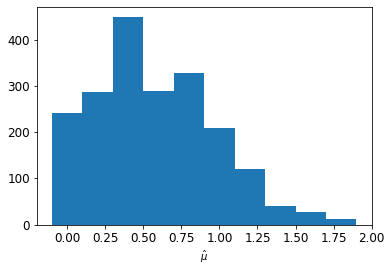

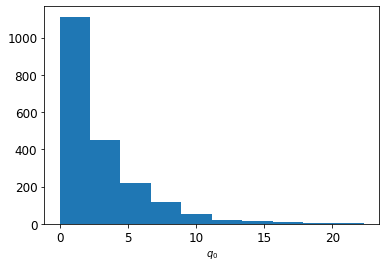

Z BL:(1.9442086886717027, 0.8517333775581781, 1.0154, 1.94479595451411, 0.8308718615399975)
Z:1.3264905062970025
Z_std:1.2031258357455594
Z_1:0.7174676704475429
Z_std_1:3.4271395581174833
1
AUC:0.9024068251245492
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

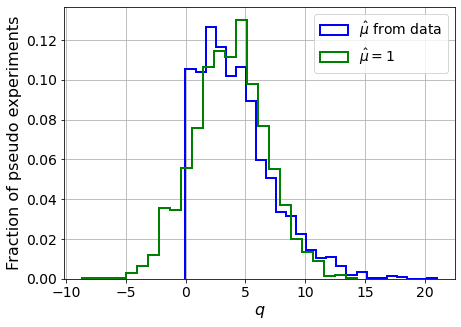

IOStream.flush timed out
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
  7363.47824233  7243.54370058  7064.68957539  6843.14799947
  6562.8638865   6215.22402278  5795.91717426  5284.73021088
  4653.78798215  3886.73595392  2985.96702542  1922.63546208
   643.07929152  -887.98807404 -2716.66548279 -5304.23423463]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  4305.1278509   4327

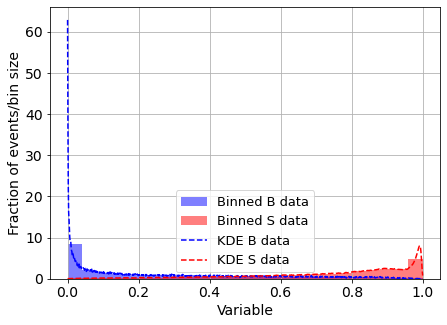

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.02467263074371096
0.02467263074371096
3 done
4 done
0.0
5.211086774363057e-05


  1%|▊                                                                 | 24/2000 [00:07<10:26,  3.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4068532988020344
<p_{s}(Sdata)> = 2.0212425549633717
<p_{b}(Bdata)> = 9.021637652818443
<p_{s}(Bdata)> = 0.41780736500023163


  1%|▉                                                                 | 27/2000 [00:08<09:42,  3.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4541081680861056
<p_{s}(Sdata)> = 1.7076851624327032
<p_{b}(Bdata)> = 8.630502914649048
<p_{s}(Bdata)> = 0.4212336664285335


  3%|█▉                                                                | 60/2000 [00:18<08:40,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4074963120159087
<p_{s}(Sdata)> = 2.34292993918797
<p_{b}(Bdata)> = 8.992146099248524
<p_{s}(Bdata)> = 0.4212334765694926


  4%|██▋                                                               | 81/2000 [00:26<10:26,  3.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3825693110838204
<p_{s}(Sdata)> = 2.284628108472911
<p_{b}(Bdata)> = 8.896161911872023
<p_{s}(Bdata)> = 0.433890013450589


  5%|███▏                                                              | 98/2000 [00:32<10:58,  2.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4098420661378039
<p_{s}(Sdata)> = 1.7717253621810471
<p_{b}(Bdata)> = 9.006691157971558
<p_{s}(Bdata)> = 0.4208512078278033


  6%|████▏                                                            | 130/2000 [00:42<08:14,  3.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43509718490057586
<p_{s}(Sdata)> = 2.2502583895747232
<p_{b}(Bdata)> = 9.035600424474465
<p_{s}(Bdata)> = 0.4143296065577058


  7%|████▎                                                            | 131/2000 [00:42<07:23,  4.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4032524127800936
<p_{s}(Sdata)> = 2.4913077472492873
<p_{b}(Bdata)> = 8.811859029288811
<p_{s}(Bdata)> = 0.4181547364716424


 11%|███████▎                                                         | 226/2000 [01:17<10:11,  2.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4396150477236702
<p_{s}(Sdata)> = 1.9045202818826126
<p_{b}(Bdata)> = 8.96443359804797
<p_{s}(Bdata)> = 0.41913325216062963


 12%|████████                                                         | 247/2000 [01:24<07:09,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34928440784324105
<p_{s}(Sdata)> = 2.1388246197746477
<p_{b}(Bdata)> = 9.097873429580952
<p_{s}(Bdata)> = 0.4161964038133569


 13%|████████▍                                                        | 259/2000 [01:27<09:36,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4874584618995667
<p_{s}(Sdata)> = 1.9967528238484586
<p_{b}(Bdata)> = 8.741313867260782
<p_{s}(Bdata)> = 0.4201324024899483


 13%|████████▌                                                        | 263/2000 [01:28<08:05,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.455068687739477
<p_{s}(Sdata)> = 2.13155911995356
<p_{b}(Bdata)> = 9.02790414635679
<p_{s}(Bdata)> = 0.41867168984242814


 14%|████████▊                                                        | 273/2000 [01:31<08:02,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3977985596748014
<p_{s}(Sdata)> = 2.2267482875444156
<p_{b}(Bdata)> = 8.9960758536445
<p_{s}(Bdata)> = 0.4160749202559491


 15%|█████████▋                                                       | 297/2000 [01:39<09:32,  2.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.410418611374616
<p_{s}(Sdata)> = 2.0622359488488695
<p_{b}(Bdata)> = 8.934257756080704
<p_{s}(Bdata)> = 0.4145853552770929


 15%|█████████▊                                                       | 303/2000 [01:41<10:41,  2.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3958682646831914
<p_{s}(Sdata)> = 2.2971946491365567
<p_{b}(Bdata)> = 8.78362303407489
<p_{s}(Bdata)> = 0.41906097500199735


 16%|██████████▋                                                      | 329/2000 [01:51<09:16,  3.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.34547971033255737
<p_{s}(Sdata)> = 2.6031601242674194
<p_{b}(Bdata)> = 8.92658746852822
<p_{s}(Bdata)> = 0.42914530643141047


 17%|███████████                                                      | 342/2000 [01:55<10:00,  2.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44506452311986905
<p_{s}(Sdata)> = 1.6825789209349458
<p_{b}(Bdata)> = 8.65727417420447
<p_{s}(Bdata)> = 0.4230173670601717


 19%|████████████▌                                                    | 385/2000 [02:11<09:30,  2.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4609572930487662
<p_{s}(Sdata)> = 1.8948757399291578
<p_{b}(Bdata)> = 8.80407542378553
<p_{s}(Bdata)> = 0.42684330278939514


 20%|█████████████▏                                                   | 404/2000 [02:17<10:10,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4654328189927776
<p_{s}(Sdata)> = 1.9493448835094325
<p_{b}(Bdata)> = 8.888123068937988
<p_{s}(Bdata)> = 0.4203781896811311


 23%|██████████████▉                                                  | 460/2000 [02:37<10:26,  2.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4238398367528029
<p_{s}(Sdata)> = 2.041707197217385
<p_{b}(Bdata)> = 8.687447006795761
<p_{s}(Bdata)> = 0.4223527789017743


 26%|████████████████▉                                                | 521/2000 [02:59<07:09,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6092168458116983
<p_{s}(Sdata)> = 2.1858892169568556
<p_{b}(Bdata)> = 8.688659178194577
<p_{s}(Bdata)> = 0.41884425342338544


 26%|████████████████▉                                                | 523/2000 [03:00<06:29,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31017082722647044
<p_{s}(Sdata)> = 2.29853764443089
<p_{b}(Bdata)> = 8.964574293254925
<p_{s}(Bdata)> = 0.41437436100721753


 26%|█████████████████▏                                               | 527/2000 [03:01<06:31,  3.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.56920309607454
<p_{s}(Sdata)> = 1.8100713149766028
<p_{b}(Bdata)> = 9.038388396009475
<p_{s}(Bdata)> = 0.4217122306187128


 27%|█████████████████▊                                               | 547/2000 [03:07<08:21,  2.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33671457384519043
<p_{s}(Sdata)> = 2.4733126683097124
<p_{b}(Bdata)> = 8.86803965292246
<p_{s}(Bdata)> = 0.4218952866047533


 28%|██████████████████▎                                              | 565/2000 [03:13<06:51,  3.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.42952179055579714
<p_{s}(Sdata)> = 2.487763698063283
<p_{b}(Bdata)> = 8.686725814015075
<p_{s}(Bdata)> = 0.4273041824032449


 33%|█████████████████████▌                                           | 663/2000 [03:47<08:50,  2.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37345780312457033
<p_{s}(Sdata)> = 2.3320049215922256
<p_{b}(Bdata)> = 8.736866955415175
<p_{s}(Bdata)> = 0.42027473641323926


 34%|█████████████████████▉                                           | 674/2000 [03:51<07:47,  2.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40758034707962065
<p_{s}(Sdata)> = 2.2223258156533983
<p_{b}(Bdata)> = 8.913369898643042
<p_{s}(Bdata)> = 0.4200782546373852


 34%|█████████████████████▉                                           | 676/2000 [03:51<07:17,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4514084299363573
<p_{s}(Sdata)> = 2.087002713054351
<p_{b}(Bdata)> = 9.007029859778195
<p_{s}(Bdata)> = 0.41401747308057985


 35%|██████████████████████▉                                          | 705/2000 [04:01<08:12,  2.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3960539614400933
<p_{s}(Sdata)> = 1.9718535868444338
<p_{b}(Bdata)> = 9.030747767374523
<p_{s}(Bdata)> = 0.42322707039112395


 38%|████████████████████████▍                                        | 752/2000 [04:17<09:01,  2.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40813046503880157
<p_{s}(Sdata)> = 2.0584074279732376
<p_{b}(Bdata)> = 8.865771318998132
<p_{s}(Bdata)> = 0.4260975281137989


 40%|█████████████████████████▊                                       | 795/2000 [04:33<06:01,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3922390726147126
<p_{s}(Sdata)> = 1.9561466352357522
<p_{b}(Bdata)> = 8.8856179054998
<p_{s}(Bdata)> = 0.41999804331861473
muhat = -0.1
<p_{b}(Sdata)> = 0.5763743112320858
<p_{s}(Sdata)> = 1.883356513519202
<p_{b}(Bdata)> = 8.842648586936452
<p_{s}(Bdata)> = 0.4222365657801031


 40%|██████████████████████████                                       | 801/2000 [04:34<04:23,  4.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4557288514111901
<p_{s}(Sdata)> = 1.818700114681178
<p_{b}(Bdata)> = 8.953551172893603
<p_{s}(Bdata)> = 0.42238538406526527
muhat = -0.1
<p_{b}(Sdata)> = 0.48772345889937124
<p_{s}(Sdata)> = 1.8060986571998392
<p_{b}(Bdata)> = 8.758438678825621
<p_{s}(Bdata)> = 0.4252182273911272


 42%|███████████████████████████▍                                     | 843/2000 [04:48<06:15,  3.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4717019533631121
<p_{s}(Sdata)> = 1.7932752150791562
<p_{b}(Bdata)> = 8.843992994615585
<p_{s}(Bdata)> = 0.4231947165614766


 44%|████████████████████████████▍                                    | 875/2000 [04:58<05:34,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4606748740101404
<p_{s}(Sdata)> = 2.0070150594165392
<p_{b}(Bdata)> = 9.034307900008102
<p_{s}(Bdata)> = 0.41971292632111235


 44%|████████████████████████████▌                                    | 880/2000 [05:00<06:18,  2.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5618825218095601
<p_{s}(Sdata)> = 1.8068320045763586
<p_{b}(Bdata)> = 9.026595078119184
<p_{s}(Bdata)> = 0.41527026643691184


 45%|█████████████████████████████▌                                   | 909/2000 [05:10<07:20,  2.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42113149808333356
<p_{s}(Sdata)> = 1.7683902660523567
<p_{b}(Bdata)> = 8.926825066853857
<p_{s}(Bdata)> = 0.4188540920680004


 46%|█████████████████████████████▊                                   | 916/2000 [05:12<06:10,  2.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43119765710656577
<p_{s}(Sdata)> = 2.0392743834424345
<p_{b}(Bdata)> = 8.703734807985603
<p_{s}(Bdata)> = 0.42263545750319476


 47%|██████████████████████████████▎                                  | 932/2000 [05:18<05:56,  3.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4006675032323631
<p_{s}(Sdata)> = 2.0807316988084956
<p_{b}(Bdata)> = 8.840883860344704
<p_{s}(Bdata)> = 0.42206442306691444


 47%|██████████████████████████████▋                                  | 944/2000 [05:22<05:14,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41211836021784237
<p_{s}(Sdata)> = 2.1607908024353994
<p_{b}(Bdata)> = 8.747842340598082
<p_{s}(Bdata)> = 0.41363475656517357


 49%|███████████████████████████████▌                                 | 973/2000 [05:32<07:05,  2.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42362433991085896
<p_{s}(Sdata)> = 2.0455189998543153
<p_{b}(Bdata)> = 8.86486270479698
<p_{s}(Bdata)> = 0.4156702443607145


 49%|███████████████████████████████▊                                 | 977/2000 [05:33<05:14,  3.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4628754925551663
<p_{s}(Sdata)> = 1.6802990784258949
<p_{b}(Bdata)> = 8.833884594311114
<p_{s}(Bdata)> = 0.4224508130946913


 50%|████████████████████████████████▏                                | 990/2000 [05:37<06:21,  2.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40992523863175
<p_{s}(Sdata)> = 1.969010517006348
<p_{b}(Bdata)> = 8.99937497179661
<p_{s}(Bdata)> = 0.4202670476984155


 50%|████████████████████████████████▏                               | 1004/2000 [05:41<04:31,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.501057718077027
<p_{s}(Sdata)> = 1.6325974975243673
<p_{b}(Bdata)> = 8.893745753987385
<p_{s}(Bdata)> = 0.42050877415114657


 51%|████████████████████████████████▌                               | 1017/2000 [05:46<05:03,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4120334044383917
<p_{s}(Sdata)> = 2.1828819543204103
<p_{b}(Bdata)> = 8.90477515900955
<p_{s}(Bdata)> = 0.4185880444413659


 51%|████████████████████████████████▌                               | 1019/2000 [05:47<04:47,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38638287130941124
<p_{s}(Sdata)> = 2.1538133698143738
<p_{b}(Bdata)> = 8.757053738037008
<p_{s}(Bdata)> = 0.4200729790502673


 51%|████████████████████████████████▋                               | 1021/2000 [05:47<04:20,  3.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5375914548988219
<p_{s}(Sdata)> = 2.1211200463450304
<p_{b}(Bdata)> = 8.896668606716416
<p_{s}(Bdata)> = 0.42129310208720394


 53%|█████████████████████████████████▉                              | 1061/2000 [06:00<04:27,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43133701353529313
<p_{s}(Sdata)> = 1.8460368003651073
<p_{b}(Bdata)> = 8.960986775012797
<p_{s}(Bdata)> = 0.4205092651392633


 55%|██████████████████████████████████▉                             | 1092/2000 [06:12<06:03,  2.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3884045294883535
<p_{s}(Sdata)> = 2.3048800522649238
<p_{b}(Bdata)> = 8.955129315442367
<p_{s}(Bdata)> = 0.42147693510793527


 55%|███████████████████████████████████▏                            | 1101/2000 [06:15<04:10,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39581653480248974
<p_{s}(Sdata)> = 2.063053264365823
<p_{b}(Bdata)> = 9.000852830920108
<p_{s}(Bdata)> = 0.4165671262485232


 56%|███████████████████████████████████▋                            | 1117/2000 [06:21<04:24,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5204227376332307
<p_{s}(Sdata)> = 1.825348447101658
<p_{b}(Bdata)> = 9.017828601995344
<p_{s}(Bdata)> = 0.41800001515600266


 57%|████████████████████████████████████▎                           | 1136/2000 [06:27<04:32,  3.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40603444421740403
<p_{s}(Sdata)> = 2.2911863721474313
<p_{b}(Bdata)> = 9.120002396405944
<p_{s}(Bdata)> = 0.4140347405274605


 58%|█████████████████████████████████████                           | 1158/2000 [06:35<05:29,  2.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4097678689951934
<p_{s}(Sdata)> = 2.1562949970798453
<p_{b}(Bdata)> = 8.835276811487915
<p_{s}(Bdata)> = 0.4216902629679294


 61%|██████████████████████████████████████▉                         | 1216/2000 [06:55<04:32,  2.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44082772957736277
<p_{s}(Sdata)> = 1.8662964223831267
<p_{b}(Bdata)> = 9.062777782377832
<p_{s}(Bdata)> = 0.41954252889229043


 62%|███████████████████████████████████████▌                        | 1236/2000 [07:00<03:43,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44613427996291616
<p_{s}(Sdata)> = 1.6464747632649808
<p_{b}(Bdata)> = 8.961817164260676
<p_{s}(Bdata)> = 0.4167777875352432


 62%|███████████████████████████████████████▉                        | 1249/2000 [07:04<03:49,  3.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39426971064006167
<p_{s}(Sdata)> = 2.016667833822037
<p_{b}(Bdata)> = 8.806987065243684
<p_{s}(Bdata)> = 0.4212655008152238


 65%|█████████████████████████████████████████▌                      | 1298/2000 [07:21<03:25,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5002389633257697
<p_{s}(Sdata)> = 1.6903332754754925
<p_{b}(Bdata)> = 9.11737413420518
<p_{s}(Bdata)> = 0.41610031349491977


 68%|███████████████████████████████████████████▏                    | 1350/2000 [07:39<04:34,  2.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38922331859846193
<p_{s}(Sdata)> = 2.112444267644803
<p_{b}(Bdata)> = 8.82329292309236
<p_{s}(Bdata)> = 0.42073022417030553


 68%|███████████████████████████████████████████▍                    | 1357/2000 [07:42<03:13,  3.32it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.39551230405715204
<p_{s}(Sdata)> = 2.4556121554122172
<p_{b}(Bdata)> = 8.67592595697184
<p_{s}(Bdata)> = 0.4333642588159482


 68%|███████████████████████████████████████████▋                    | 1367/2000 [07:45<02:57,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41650875476502336
<p_{s}(Sdata)> = 1.809801203770341
<p_{b}(Bdata)> = 8.753287698201866
<p_{s}(Bdata)> = 0.4307414055216758


 71%|█████████████████████████████████████████████▏                  | 1412/2000 [08:00<03:37,  2.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3588473444981235
<p_{s}(Sdata)> = 2.1431411120208126
<p_{b}(Bdata)> = 8.601857481526865
<p_{s}(Bdata)> = 0.42005748810324106


 72%|█████████████████████████████████████████████▊                  | 1431/2000 [08:07<02:12,  4.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4887153147496005
<p_{s}(Sdata)> = 1.8702721825107038
<p_{b}(Bdata)> = 8.884354305830753
<p_{s}(Bdata)> = 0.4161356126103727
muhat = -0.1
<p_{b}(Sdata)> = 0.39781697142992284
<p_{s}(Sdata)> = 2.2549665998183017
<p_{b}(Bdata)> = 8.963662287717732
<p_{s}(Bdata)> = 0.4211384904615373


 72%|█████████████████████████████████████████████▉                  | 1436/2000 [08:09<03:45,  2.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3666515973494996
<p_{s}(Sdata)> = 2.132506129782409
<p_{b}(Bdata)> = 8.964366354980896
<p_{s}(Bdata)> = 0.42265275371974675


 73%|██████████████████████████████████████████████▊                 | 1461/2000 [08:18<03:19,  2.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3410312665778488
<p_{s}(Sdata)> = 2.4674639218324503
<p_{b}(Bdata)> = 8.866033165604009
<p_{s}(Bdata)> = 0.41790140330576614


 73%|██████████████████████████████████████████████▊                 | 1463/2000 [08:19<02:25,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41605580480526194
<p_{s}(Sdata)> = 1.9965519294176015
<p_{b}(Bdata)> = 8.66454975585134
<p_{s}(Bdata)> = 0.41910544427973734


 73%|███████████████████████████████████████████████                 | 1469/2000 [08:20<02:24,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48688675736283743
<p_{s}(Sdata)> = 1.8874820816056883
<p_{b}(Bdata)> = 9.00719774978646
<p_{s}(Bdata)> = 0.4176776068012359


 74%|███████████████████████████████████████████████▏                | 1473/2000 [08:21<02:14,  3.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4290031315058272
<p_{s}(Sdata)> = 1.7823029754093753
<p_{b}(Bdata)> = 9.070493041701813
<p_{s}(Bdata)> = 0.4187815001187117


 75%|████████████████████████████████████████████████                | 1503/2000 [08:31<02:20,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3888867752656085
<p_{s}(Sdata)> = 2.048681235711147
<p_{b}(Bdata)> = 8.96267968980704
<p_{s}(Bdata)> = 0.4164432110141624


 79%|██████████████████████████████████████████████████▍             | 1576/2000 [08:56<02:51,  2.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4017961847256412
<p_{s}(Sdata)> = 1.9037922379902155
<p_{b}(Bdata)> = 8.878028843691693
<p_{s}(Bdata)> = 0.42461190264623466


 79%|██████████████████████████████████████████████████▍             | 1578/2000 [08:57<01:59,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4338018206738198
<p_{s}(Sdata)> = 2.009344655390471
<p_{b}(Bdata)> = 8.848933556898736
<p_{s}(Bdata)> = 0.4184422892071451


 80%|███████████████████████████████████████████████████▎            | 1605/2000 [09:06<02:21,  2.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4080068823590212
<p_{s}(Sdata)> = 2.217275734008256
<p_{b}(Bdata)> = 8.804921116717765
<p_{s}(Bdata)> = 0.41944893581123


 81%|████████████████████████████████████████████████████            | 1627/2000 [09:13<02:16,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4910896543014602
<p_{s}(Sdata)> = 1.8382809495798174
<p_{b}(Bdata)> = 8.901051789037743
<p_{s}(Bdata)> = 0.4219576776886715


 82%|████████████████████████████████████████████████████▏           | 1630/2000 [09:14<01:57,  3.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37621961052286457
<p_{s}(Sdata)> = 2.3072657150558236
<p_{b}(Bdata)> = 8.84211160954134
<p_{s}(Bdata)> = 0.41633231572550955


 82%|████████████████████████████████████████████████████▌           | 1641/2000 [09:18<02:24,  2.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3795414566974305
<p_{s}(Sdata)> = 2.0246821949690634
<p_{b}(Bdata)> = 8.979133845593774
<p_{s}(Bdata)> = 0.4209281215256846


 83%|████████████████████████████████████████████████████▊           | 1651/2000 [09:21<01:12,  4.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4442642975012216
<p_{s}(Sdata)> = 1.8191947760510752
<p_{b}(Bdata)> = 8.786656417264995
<p_{s}(Bdata)> = 0.42036283322751383


 83%|████████████████████████████████████████████████████▉           | 1653/2000 [09:21<01:32,  3.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46653650950774783
<p_{s}(Sdata)> = 1.8693751941660928
<p_{b}(Bdata)> = 8.874374322821431
<p_{s}(Bdata)> = 0.4224021341514655


 83%|████████████████████████████████████████████████████▉           | 1655/2000 [09:22<01:14,  4.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43156863480650914
<p_{s}(Sdata)> = 2.1253298538648746
<p_{b}(Bdata)> = 8.901378343239223
<p_{s}(Bdata)> = 0.4204327181315653


 83%|█████████████████████████████████████████████████████▏          | 1661/2000 [09:23<01:48,  3.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41897931137211814
<p_{s}(Sdata)> = 2.1737336309880377
<p_{b}(Bdata)> = 8.93849427233132
<p_{s}(Bdata)> = 0.41763614341156846


 85%|██████████████████████████████████████████████████████▏         | 1694/2000 [09:35<01:49,  2.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3568194690080438
<p_{s}(Sdata)> = 2.218474322803515
<p_{b}(Bdata)> = 8.730789908528267
<p_{s}(Bdata)> = 0.41620049964040545


 85%|██████████████████████████████████████████████████████▌         | 1706/2000 [09:39<01:03,  4.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3513065880102385
<p_{s}(Sdata)> = 2.3367676842963725
<p_{b}(Bdata)> = 8.770137156755979
<p_{s}(Bdata)> = 0.4242760599289073


 86%|██████████████████████████████████████████████████████▊         | 1713/2000 [09:41<01:18,  3.65it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.399908222173092
<p_{s}(Sdata)> = 2.495646080426883
<p_{b}(Bdata)> = 8.79560222352384
<p_{s}(Bdata)> = 0.4310224202409505
muhat = -0.1
<p_{b}(Sdata)> = 1.2566138083002432
<p_{s}(Sdata)> = 2.217772199814356
<p_{b}(Bdata)> = 8.843095551347247
<p_{s}(Bdata)> = 0.41907670771018396


 86%|███████████████████████████████████████████████████████▏        | 1726/2000 [09:45<01:15,  3.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48180133664072605
<p_{s}(Sdata)> = 2.153970334705301
<p_{b}(Bdata)> = 8.628303684577016
<p_{s}(Bdata)> = 0.42429232267138006


 87%|███████████████████████████████████████████████████████▌        | 1737/2000 [09:48<01:08,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41401016225143206
<p_{s}(Sdata)> = 2.068608098214828
<p_{b}(Bdata)> = 8.76484224831789
<p_{s}(Bdata)> = 0.4199732452941038
muhat = -0.1
<p_{b}(Sdata)> = 0.4522801388363799
<p_{s}(Sdata)> = 1.6601965098572258
<p_{b}(Bdata)> = 8.863254518061517
<p_{s}(Bdata)> = 0.4216740401221035


 87%|███████████████████████████████████████████████████████▊        | 1745/2000 [09:51<01:29,  2.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4105484100478961
<p_{s}(Sdata)> = 1.9791538455414122
<p_{b}(Bdata)> = 8.91186958890406
<p_{s}(Bdata)> = 0.41748428034961577


 88%|████████████████████████████████████████████████████████▎       | 1758/2000 [09:55<01:17,  3.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4535338468135517
<p_{s}(Sdata)> = 1.9208295621198979
<p_{b}(Bdata)> = 8.891182381230612
<p_{s}(Bdata)> = 0.41747742957795875


 89%|████████████████████████████████████████████████████████▉       | 1779/2000 [10:03<01:14,  2.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43496723259934866
<p_{s}(Sdata)> = 1.7879695850843194
<p_{b}(Bdata)> = 8.894116794004669
<p_{s}(Bdata)> = 0.42113797716321955


 92%|██████████████████████████████████████████████████████████▌     | 1830/2000 [10:21<00:57,  2.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4904923062010823
<p_{s}(Sdata)> = 1.8421727056074473
<p_{b}(Bdata)> = 9.136932373290763
<p_{s}(Bdata)> = 0.4172647965667126


 92%|██████████████████████████████████████████████████████████▊     | 1836/2000 [10:23<00:55,  2.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.0333457426709403
<p_{s}(Sdata)> = 1.8641304361142539
<p_{b}(Bdata)> = 8.784307583614623
<p_{s}(Bdata)> = 0.4138546615026458


 93%|███████████████████████████████████████████████████████████▎    | 1854/2000 [10:29<00:49,  2.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38985182324771883
<p_{s}(Sdata)> = 1.9267158897064685
<p_{b}(Bdata)> = 9.014190419356867
<p_{s}(Bdata)> = 0.4207881083843998


 93%|███████████████████████████████████████████████████████████▋    | 1864/2000 [10:32<00:26,  5.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5071704971708879
<p_{s}(Sdata)> = 2.003190150029135
<p_{b}(Bdata)> = 8.865456912069863
<p_{s}(Bdata)> = 0.42065660013777817
muhat = -0.1
<p_{b}(Sdata)> = 0.4184534459211595
<p_{s}(Sdata)> = 2.2479315285801675
<p_{b}(Bdata)> = 8.905181384773773
<p_{s}(Bdata)> = 0.4156554056322694


 95%|████████████████████████████████████████████████████████████▊   | 1899/2000 [10:43<00:27,  3.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3603115578263885
<p_{s}(Sdata)> = 2.502693605384955
<p_{b}(Bdata)> = 9.12370337505939
<p_{s}(Bdata)> = 0.4280482712441566


 95%|████████████████████████████████████████████████████████████▊   | 1900/2000 [10:44<00:30,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4354850999672982
<p_{s}(Sdata)> = 2.0126279480970934
<p_{b}(Bdata)> = 8.741663106810984
<p_{s}(Bdata)> = 0.4185455054240478


 95%|████████████████████████████████████████████████████████████▉   | 1906/2000 [10:45<00:24,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39395370685081665
<p_{s}(Sdata)> = 2.1006955847641104
<p_{b}(Bdata)> = 9.027915517403605
<p_{s}(Bdata)> = 0.4198493475520309
muhat = -0.1
<p_{b}(Sdata)> = 0.39791296221630895
<p_{s}(Sdata)> = 2.2207646015145497
<p_{b}(Bdata)> = 9.049363980148897
<p_{s}(Bdata)> = 0.41634237318910405


 96%|█████████████████████████████████████████████████████████████▌  | 1923/2000 [10:51<00:24,  3.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3878859228859904
<p_{s}(Sdata)> = 2.0798187257467347
<p_{b}(Bdata)> = 9.043156725212636
<p_{s}(Bdata)> = 0.4163501561937118


 97%|██████████████████████████████████████████████████████████████▎ | 1947/2000 [11:00<00:20,  2.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4778274763600859
<p_{s}(Sdata)> = 1.8020040186253539
<p_{b}(Bdata)> = 8.919988483213187
<p_{s}(Bdata)> = 0.420923938310159


 98%|██████████████████████████████████████████████████████████████▍ | 1952/2000 [11:02<00:18,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47763361908511515
<p_{s}(Sdata)> = 1.664462028581311
<p_{b}(Bdata)> = 8.810562296410014
<p_{s}(Bdata)> = 0.41715463258028646


 98%|██████████████████████████████████████████████████████████████▌ | 1955/2000 [11:03<00:13,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36543498683251624
<p_{s}(Sdata)> = 2.1802989687794168
<p_{b}(Bdata)> = 8.74912143696756
<p_{s}(Bdata)> = 0.42022161195155167


 98%|██████████████████████████████████████████████████████████████▊ | 1964/2000 [11:05<00:10,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46632748401983065
<p_{s}(Sdata)> = 1.9665771150949944
<p_{b}(Bdata)> = 8.927859080639681
<p_{s}(Bdata)> = 0.4208576471753206


 99%|███████████████████████████████████████████████████████████████▌| 1986/2000 [11:12<00:03,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48230089443238344
<p_{s}(Sdata)> = 1.9468953219370209
<p_{b}(Bdata)> = 8.97143230525586
<p_{s}(Bdata)> = 0.41831122959286254


 99%|███████████████████████████████████████████████████████████████▌| 1988/2000 [11:13<00:03,  3.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46244140256493305
<p_{s}(Sdata)> = 1.9227542381338243
<p_{b}(Bdata)> = 8.88226743147414
<p_{s}(Bdata)> = 0.42027516890904093


100%|███████████████████████████████████████████████████████████████▉| 1999/2000 [11:16<00:00,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4428607343759659
<p_{s}(Sdata)> = 2.0338732999166305
<p_{b}(Bdata)> = 8.909330752470515
<p_{s}(Bdata)> = 0.4196858450568186


100%|████████████████████████████████████████████████████████████████| 2000/2000 [11:16<00:00,  2.96it/s]


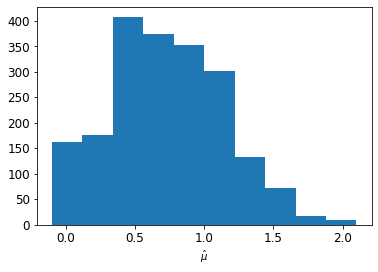

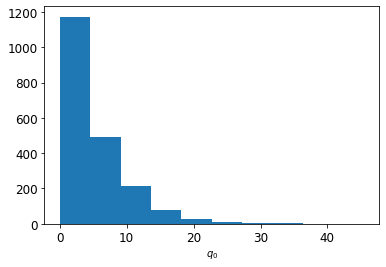

Z BL:(1.9279577739180487, 0.797409513983557, 1.012275, 1.9289794683876829, 0.7888117896839033)
Z:1.87090700922247
Z_std:1.3087521107723046
Z_1:1.7562166838197082
Z_std_1:1.6818100820885964
2
AUC:0.9025969385952689
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

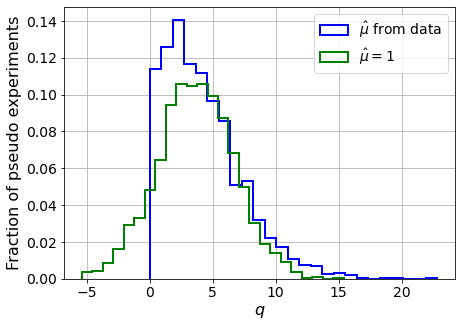

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  7374.69678438  7189.17140313  6963.71525621
  6676.33279343  6319.12138088  5886.36736399  5361.08695499
  4722.29521465  3944.6599604   3007.12555254  1902.94396138
   605.30444832  -932.1111751  -2764.27771781 -5324.04385757]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  4310.7058578   4335.00974579  4340.80239412


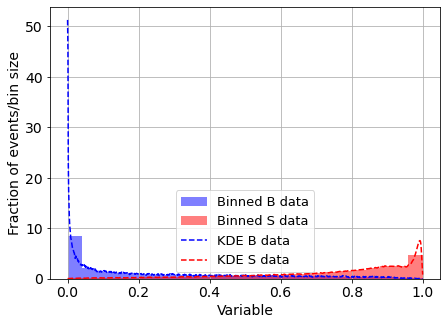

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.02055807157711178
0.02055807157711178
3 done
4 done
0.0
2.6948493402725357e-05


  0%|▏                                                                  | 4/2000 [00:01<06:57,  4.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41780850993425345
<p_{s}(Sdata)> = 2.192953471698184
<p_{b}(Bdata)> = 8.224114455785244
<p_{s}(Bdata)> = 0.41652546758502257
muhat = -0.1
<p_{b}(Sdata)> = 0.5627435501700319
<p_{s}(Sdata)> = 1.7736488709528244
<p_{b}(Bdata)> = 8.117262544545484
<p_{s}(Bdata)> = 0.4240019962001514


  0%|▏                                                                  | 7/2000 [00:02<09:28,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5292983565290248
<p_{s}(Sdata)> = 2.2051024763339315
<p_{b}(Bdata)> = 8.331573386903
<p_{s}(Bdata)> = 0.4140931194417752


  1%|▉                                                                 | 29/2000 [00:10<12:19,  2.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.372394006819497
<p_{s}(Sdata)> = 2.3099276496886523
<p_{b}(Bdata)> = 8.235493789935928
<p_{s}(Bdata)> = 0.4160381350904354


  2%|█▍                                                                | 45/2000 [00:17<15:45,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43871874842802444
<p_{s}(Sdata)> = 1.908447095132665
<p_{b}(Bdata)> = 8.016317275940693
<p_{s}(Bdata)> = 0.42116664075634647


  7%|████▎                                                            | 132/2000 [00:48<09:51,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45096960161092325
<p_{s}(Sdata)> = 2.0001309903223117
<p_{b}(Bdata)> = 8.163712119987805
<p_{s}(Bdata)> = 0.4208996067852157


  7%|████▌                                                            | 139/2000 [00:50<11:45,  2.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4847809992907744
<p_{s}(Sdata)> = 1.7943973016786556
<p_{b}(Bdata)> = 8.232220680790428
<p_{s}(Bdata)> = 0.41975019256742024


  7%|████▊                                                            | 148/2000 [00:53<11:22,  2.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5966728528067852
<p_{s}(Sdata)> = 2.0818179265388705
<p_{b}(Bdata)> = 8.140457319238815
<p_{s}(Bdata)> = 0.4187775284243482


  8%|█████▏                                                           | 158/2000 [00:57<12:36,  2.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5379495540060532
<p_{s}(Sdata)> = 1.5633612497702434
<p_{b}(Bdata)> = 8.21674457448587
<p_{s}(Bdata)> = 0.42083549279564836


  8%|█████▍                                                           | 169/2000 [01:00<10:34,  2.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4577636736899854
<p_{s}(Sdata)> = 2.268693831940496
<p_{b}(Bdata)> = 8.18710789244051
<p_{s}(Bdata)> = 0.41502438676880987


  9%|██████                                                           | 187/2000 [01:06<09:51,  3.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47603319243679987
<p_{s}(Sdata)> = 2.1297098050107803
<p_{b}(Bdata)> = 7.974548304316431
<p_{s}(Bdata)> = 0.4189411926882104


 12%|███████▉                                                         | 245/2000 [01:28<09:58,  2.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42806098044235813
<p_{s}(Sdata)> = 1.8504834110696584
<p_{b}(Bdata)> = 8.18522038640564
<p_{s}(Bdata)> = 0.4220265268903326


 13%|████████▎                                                        | 255/2000 [01:31<07:45,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4026142269507367
<p_{s}(Sdata)> = 2.2226528411316075
<p_{b}(Bdata)> = 8.216241926131836
<p_{s}(Bdata)> = 0.4227225613905897


 16%|██████████                                                       | 310/2000 [01:53<09:54,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40730553357652527
<p_{s}(Sdata)> = 2.1008595714152367
<p_{b}(Bdata)> = 8.037424175240615
<p_{s}(Bdata)> = 0.4181297814583869


 16%|██████████▏                                                      | 314/2000 [01:54<10:18,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41455791270791603
<p_{s}(Sdata)> = 1.924584708322244
<p_{b}(Bdata)> = 8.07873819230901
<p_{s}(Bdata)> = 0.42059929973104904


 16%|██████████▍                                                      | 320/2000 [01:56<10:56,  2.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44768914837112156
<p_{s}(Sdata)> = 1.7327243929652234
<p_{b}(Bdata)> = 8.16567724951163
<p_{s}(Bdata)> = 0.41649697296313754


 17%|███████████▎                                                     | 347/2000 [02:05<06:43,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4336329177909208
<p_{s}(Sdata)> = 2.179741516903792
<p_{b}(Bdata)> = 8.20966900420563
<p_{s}(Bdata)> = 0.423014051992954


 18%|███████████▋                                                     | 361/2000 [02:10<10:08,  2.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4037090196782382
<p_{s}(Sdata)> = 2.000445213945496
<p_{b}(Bdata)> = 8.293114830844386
<p_{s}(Bdata)> = 0.41974115622275254


 19%|████████████                                                     | 371/2000 [02:14<12:13,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.432163401818591
<p_{s}(Sdata)> = 2.116218149727225
<p_{b}(Bdata)> = 8.169865883815454
<p_{s}(Bdata)> = 0.4176565326543069


 19%|████████████▍                                                    | 381/2000 [02:17<08:55,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39605519028739794
<p_{s}(Sdata)> = 2.334073646372411
<p_{b}(Bdata)> = 8.091410294185712
<p_{s}(Bdata)> = 0.42060181050964407


 19%|████████████▍                                                    | 383/2000 [02:18<08:57,  3.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34822807616979035
<p_{s}(Sdata)> = 2.4460402261660197
<p_{b}(Bdata)> = 8.33241666003655
<p_{s}(Bdata)> = 0.4136713358591642


 20%|█████████████▏                                                   | 404/2000 [02:25<08:11,  3.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3858226234947551
<p_{s}(Sdata)> = 2.272015732899395
<p_{b}(Bdata)> = 8.14477786332624
<p_{s}(Bdata)> = 0.4164095356856842


 21%|█████████████▋                                                   | 421/2000 [02:32<10:41,  2.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49193351612942393
<p_{s}(Sdata)> = 1.897152022436996
<p_{b}(Bdata)> = 8.17239529411741
<p_{s}(Bdata)> = 0.4235790686601004


 22%|██████████████▍                                                  | 446/2000 [02:41<09:17,  2.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3612112441764636
<p_{s}(Sdata)> = 2.3092502986078975
<p_{b}(Bdata)> = 8.149647157708017
<p_{s}(Bdata)> = 0.4191110558458766


 24%|███████████████▋                                                 | 481/2000 [02:53<10:49,  2.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4257850028844178
<p_{s}(Sdata)> = 1.9518178165145623
<p_{b}(Bdata)> = 8.20189642523008
<p_{s}(Bdata)> = 0.4171097520906176


 26%|█████████████████▏                                               | 529/2000 [03:10<07:53,  3.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38850370072634144
<p_{s}(Sdata)> = 2.204242905909792
<p_{b}(Bdata)> = 8.136415739551383
<p_{s}(Bdata)> = 0.4220642187988754


 27%|█████████████████▎                                               | 533/2000 [03:12<08:11,  2.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39045402335934803
<p_{s}(Sdata)> = 2.179873295346125
<p_{b}(Bdata)> = 8.110460117837636
<p_{s}(Bdata)> = 0.4198077621887528


 27%|█████████████████▌                                               | 539/2000 [03:13<05:23,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4519938565074916
<p_{s}(Sdata)> = 2.0670406974061826
<p_{b}(Bdata)> = 8.062303773597467
<p_{s}(Bdata)> = 0.4206224939000392
muhat = -0.1
<p_{b}(Sdata)> = 0.39133791605735524
<p_{s}(Sdata)> = 1.9219566346231611
<p_{b}(Bdata)> = 8.077883479404816
<p_{s}(Bdata)> = 0.42127847071155045


 27%|█████████████████▋                                               | 543/2000 [03:14<06:59,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44980442101527096
<p_{s}(Sdata)> = 2.0960444400176694
<p_{b}(Bdata)> = 8.092097767623086
<p_{s}(Bdata)> = 0.4179019272938413


 31%|███████████████████▉                                             | 612/2000 [03:39<09:47,  2.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42076680485611134
<p_{s}(Sdata)> = 1.9374636606854914
<p_{b}(Bdata)> = 8.231871669339043
<p_{s}(Bdata)> = 0.42488320987303874


 31%|████████████████████▍                                            | 629/2000 [03:46<08:01,  2.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4556605341982557
<p_{s}(Sdata)> = 1.7632346712063092
<p_{b}(Bdata)> = 8.176886279501701
<p_{s}(Bdata)> = 0.4186459194274298


 32%|████████████████████▋                                            | 638/2000 [03:49<07:14,  3.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37218680108868224
<p_{s}(Sdata)> = 2.4530390527756554
<p_{b}(Bdata)> = 8.255240842943849
<p_{s}(Bdata)> = 0.4300678323740501


 34%|█████████████████████▉                                           | 674/2000 [04:01<06:57,  3.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.38114420612728933
<p_{s}(Sdata)> = 2.336936377119733
<p_{b}(Bdata)> = 8.357786367717372
<p_{s}(Bdata)> = 0.4280264614241193


 34%|██████████████████████▎                                          | 685/2000 [04:05<10:28,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4219952110915101
<p_{s}(Sdata)> = 2.1481400983863823
<p_{b}(Bdata)> = 8.08056664991116
<p_{s}(Bdata)> = 0.41928167490551527


 34%|██████████████████████▎                                          | 687/2000 [04:06<07:33,  2.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48203424684942847
<p_{s}(Sdata)> = 1.8014409489678815
<p_{b}(Bdata)> = 7.979391830199349
<p_{s}(Bdata)> = 0.42597873406825915


 35%|██████████████████████▌                                          | 695/2000 [04:08<07:26,  2.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4575954689414249
<p_{s}(Sdata)> = 1.631018493772131
<p_{b}(Bdata)> = 8.142987739113911
<p_{s}(Bdata)> = 0.4205011271796017


 36%|███████████████████████▍                                         | 720/2000 [04:18<08:38,  2.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4890061858128022
<p_{s}(Sdata)> = 1.7143238478327398
<p_{b}(Bdata)> = 8.040628151306615
<p_{s}(Bdata)> = 0.42403790229210614


 36%|███████████████████████▋                                         | 730/2000 [04:21<07:37,  2.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41800302400485595
<p_{s}(Sdata)> = 2.0460502791934596
<p_{b}(Bdata)> = 8.058849921934451
<p_{s}(Bdata)> = 0.4182188944618644


 37%|████████████████████████                                         | 741/2000 [04:25<07:09,  2.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4528222248720359
<p_{s}(Sdata)> = 1.8318120622730634
<p_{b}(Bdata)> = 8.060956501642986
<p_{s}(Bdata)> = 0.42020930054077815


 38%|████████████████████████▊                                        | 765/2000 [04:34<07:54,  2.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4405118474069198
<p_{s}(Sdata)> = 1.9905099924741683
<p_{b}(Bdata)> = 8.205437909395785
<p_{s}(Bdata)> = 0.42517643401485505


 39%|█████████████████████████▏                                       | 776/2000 [04:38<08:14,  2.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41343884710081846
<p_{s}(Sdata)> = 2.0911528631218297
<p_{b}(Bdata)> = 8.208944727401626
<p_{s}(Bdata)> = 0.424941774636942


 39%|█████████████████████████▍                                       | 781/2000 [04:39<05:40,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41034425041560196
<p_{s}(Sdata)> = 2.4611261843405656
<p_{b}(Bdata)> = 8.07066389331505
<p_{s}(Bdata)> = 0.4147569379130497


 39%|█████████████████████████▌                                       | 785/2000 [04:40<05:40,  3.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42118014285565103
<p_{s}(Sdata)> = 2.031261760822206
<p_{b}(Bdata)> = 8.255979003970792
<p_{s}(Bdata)> = 0.421267287335182


 40%|██████████████████████████▎                                      | 810/2000 [04:49<06:04,  3.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.42964047586333715
<p_{s}(Sdata)> = 2.315794483662925
<p_{b}(Bdata)> = 7.969594170530743
<p_{s}(Bdata)> = 0.4315081270803766


 41%|██████████████████████████▌                                      | 818/2000 [04:52<08:13,  2.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4706374707748688
<p_{s}(Sdata)> = 1.7090146530962127
<p_{b}(Bdata)> = 8.121460197988911
<p_{s}(Bdata)> = 0.4257441956475354


 42%|███████████████████████████▏                                     | 836/2000 [04:58<06:33,  2.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43350088949436333
<p_{s}(Sdata)> = 1.9647784349794737
<p_{b}(Bdata)> = 8.028742872419917
<p_{s}(Bdata)> = 0.420260343699994


 42%|███████████████████████████▍                                     | 844/2000 [05:01<06:47,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4049852923753384
<p_{s}(Sdata)> = 2.035052018299472
<p_{b}(Bdata)> = 8.21048022121255
<p_{s}(Bdata)> = 0.41941466998394705


 42%|███████████████████████████▌                                     | 847/2000 [05:02<06:26,  2.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39847996088064425
<p_{s}(Sdata)> = 1.884442364842096
<p_{b}(Bdata)> = 8.046463284165366
<p_{s}(Bdata)> = 0.42339798873505713


 44%|████████████████████████████▉                                    | 890/2000 [05:17<06:56,  2.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42092492408828047
<p_{s}(Sdata)> = 1.9846378830982792
<p_{b}(Bdata)> = 8.054389325814995
<p_{s}(Bdata)> = 0.4231626225385665


 46%|██████████████████████████████                                   | 925/2000 [05:31<08:30,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4143764866523561
<p_{s}(Sdata)> = 2.1168077221820645
<p_{b}(Bdata)> = 8.303548149769288
<p_{s}(Bdata)> = 0.4176189988712407


 50%|████████████████████████████████▏                                | 992/2000 [05:55<04:52,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4265824294549251
<p_{s}(Sdata)> = 2.1676240583002824
<p_{b}(Bdata)> = 8.119771279311195
<p_{s}(Bdata)> = 0.41561951402370356


 50%|████████████████████████████████▎                               | 1010/2000 [06:01<07:10,  2.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4120735589524641
<p_{s}(Sdata)> = 2.1478248816203553
<p_{b}(Bdata)> = 8.177736062836898
<p_{s}(Bdata)> = 0.42354154966467267


 52%|████████████████████████████████▉                               | 1030/2000 [06:08<06:04,  2.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4156309022617762
<p_{s}(Sdata)> = 2.154921075530433
<p_{b}(Bdata)> = 8.348941341278753
<p_{s}(Bdata)> = 0.4204880319318457


 52%|█████████████████████████████████▏                              | 1039/2000 [06:11<05:22,  2.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43863788468814063
<p_{s}(Sdata)> = 1.928877885801527
<p_{b}(Bdata)> = 7.899667961337032
<p_{s}(Bdata)> = 0.426394786443858


 52%|█████████████████████████████████▌                              | 1049/2000 [06:14<04:55,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42920420703389356
<p_{s}(Sdata)> = 1.9574802562838987
<p_{b}(Bdata)> = 8.05732961639788
<p_{s}(Bdata)> = 0.41790409592122907


 54%|██████████████████████████████████▋                             | 1083/2000 [06:26<05:16,  2.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3783700915715723
<p_{s}(Sdata)> = 2.2007658077772323
<p_{b}(Bdata)> = 8.241825948813352
<p_{s}(Bdata)> = 0.42146827116832286


 55%|███████████████████████████████████▎                            | 1103/2000 [06:34<05:43,  2.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4159419256917407
<p_{s}(Sdata)> = 1.9129653696275453
<p_{b}(Bdata)> = 8.2603357277275
<p_{s}(Bdata)> = 0.41734758845732783


 56%|███████████████████████████████████▋                            | 1117/2000 [06:46<08:47,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4892963922033507
<p_{s}(Sdata)> = 1.7240532359364846
<p_{b}(Bdata)> = 8.108544870867911
<p_{s}(Bdata)> = 0.41870115122169854


 56%|███████████████████████████████████▉                            | 1124/2000 [06:51<09:07,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4107836282113383
<p_{s}(Sdata)> = 2.1723431928421695
<p_{b}(Bdata)> = 8.276708023596575
<p_{s}(Bdata)> = 0.4135168982661135


 57%|████████████████████████████████████▍                           | 1137/2000 [07:01<08:50,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4605804341180393
<p_{s}(Sdata)> = 1.8472498583002805
<p_{b}(Bdata)> = 7.9513759001636
<p_{s}(Bdata)> = 0.42123327517235853


 58%|█████████████████████████████████████                           | 1157/2000 [07:18<09:19,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3859854521946819
<p_{s}(Sdata)> = 2.123842996480283
<p_{b}(Bdata)> = 8.22610768564292
<p_{s}(Bdata)> = 0.41886137316199645


 58%|█████████████████████████████████████▎                          | 1166/2000 [07:24<09:32,  1.46it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4531943601215382
<p_{s}(Sdata)> = 2.129193841485776
<p_{b}(Bdata)> = 8.10343732783192
<p_{s}(Bdata)> = 0.4287793365759539


 59%|█████████████████████████████████████▋                          | 1176/2000 [07:30<06:45,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3863587821607397
<p_{s}(Sdata)> = 2.1666109050098012
<p_{b}(Bdata)> = 8.124252680365183
<p_{s}(Bdata)> = 0.4196177757431654
muhat = -0.1
<p_{b}(Sdata)> = 0.4505184775522181
<p_{s}(Sdata)> = 1.9481301382968303
<p_{b}(Bdata)> = 8.352731773655425
<p_{s}(Bdata)> = 0.42164698219167857


 61%|██████████████████████████████████████▉                         | 1215/2000 [07:53<05:37,  2.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40470668231025997
<p_{s}(Sdata)> = 1.9137328334609465
<p_{b}(Bdata)> = 8.084110298529826
<p_{s}(Bdata)> = 0.4216438009238213


 61%|██████████████████████████████████████▉                         | 1218/2000 [07:54<05:57,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3966206000555403
<p_{s}(Sdata)> = 2.086444721550064
<p_{b}(Bdata)> = 8.05952796444082
<p_{s}(Bdata)> = 0.4238517722215457


 63%|████████████████████████████████████████▍                       | 1265/2000 [08:21<06:11,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4307297461589885
<p_{s}(Sdata)> = 1.8795750986350823
<p_{b}(Bdata)> = 8.067203768521338
<p_{s}(Bdata)> = 0.42387124360498923


 64%|████████████████████████████████████████▋                       | 1271/2000 [08:24<05:32,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42070215133025857
<p_{s}(Sdata)> = 2.186297436842029
<p_{b}(Bdata)> = 8.128978600715621
<p_{s}(Bdata)> = 0.4195594368215606


 65%|█████████████████████████████████████████▌                      | 1299/2000 [08:39<05:20,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40920346016814024
<p_{s}(Sdata)> = 2.017128274616999
<p_{b}(Bdata)> = 8.146011098612533
<p_{s}(Bdata)> = 0.42180416979499935


 67%|██████████████████████████████████████████▌                     | 1332/2000 [08:58<04:43,  2.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45868358736218856
<p_{s}(Sdata)> = 1.8583320265595178
<p_{b}(Bdata)> = 8.095369513450544
<p_{s}(Bdata)> = 0.42111808098431586


 68%|███████████████████████████████████████████▍                    | 1359/2000 [09:20<08:46,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4021042721485327
<p_{s}(Sdata)> = 2.09983421525433
<p_{b}(Bdata)> = 8.178154010473564
<p_{s}(Bdata)> = 0.4227594414891574


 68%|███████████████████████████████████████████▌                    | 1361/2000 [09:21<06:53,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4566756622426527
<p_{s}(Sdata)> = 1.9407660848659904
<p_{b}(Bdata)> = 8.118363485262622
<p_{s}(Bdata)> = 0.41554670824691764


 68%|███████████████████████████████████████████▊                    | 1369/2000 [09:26<05:46,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41399010961125676
<p_{s}(Sdata)> = 1.8853304351146818
<p_{b}(Bdata)> = 7.9490056562541085
<p_{s}(Bdata)> = 0.4209505987717364


 69%|███████████████████████████████████████████▉                    | 1373/2000 [09:29<05:10,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44548077345153764
<p_{s}(Sdata)> = 1.7878902581629441
<p_{b}(Bdata)> = 8.184947549652998
<p_{s}(Bdata)> = 0.4245176514443612
muhat = -0.1
<p_{b}(Sdata)> = 0.43839713109795864
<p_{s}(Sdata)> = 2.0247535491635795
<p_{b}(Bdata)> = 8.259220827924105
<p_{s}(Bdata)> = 0.4165943742219313


 70%|████████████████████████████████████████████▍                   | 1390/2000 [09:42<06:16,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41712731162370187
<p_{s}(Sdata)> = 1.9769785845354726
<p_{b}(Bdata)> = 8.22288011381855
<p_{s}(Bdata)> = 0.4180718853244168


 71%|█████████████████████████████████████████████▏                  | 1414/2000 [10:01<06:19,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4337410783695982
<p_{s}(Sdata)> = 2.2086346403926767
<p_{b}(Bdata)> = 8.221957354055839
<p_{s}(Bdata)> = 0.41770408766181094


 72%|█████████████████████████████████████████████▊                  | 1432/2000 [10:15<05:29,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5922464838805105
<p_{s}(Sdata)> = 2.187092880388409
<p_{b}(Bdata)> = 8.196846377615742
<p_{s}(Bdata)> = 0.41499610750769805


 73%|██████████████████████████████████████████████▍                 | 1451/2000 [10:27<04:31,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3614176471891187
<p_{s}(Sdata)> = 2.2728420242063874
<p_{b}(Bdata)> = 7.989695991542199
<p_{s}(Bdata)> = 0.4214544766029815


 73%|██████████████████████████████████████████████▉                 | 1466/2000 [10:36<04:05,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4457714971658417
<p_{s}(Sdata)> = 2.1742179908106727
<p_{b}(Bdata)> = 8.212721080875122
<p_{s}(Bdata)> = 0.4217596981960738


 76%|████████████████████████████████████████████████▌               | 1518/2000 [11:05<03:26,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39155024904254176
<p_{s}(Sdata)> = 2.1673905672266445
<p_{b}(Bdata)> = 8.115409437240478
<p_{s}(Bdata)> = 0.4160279388817685


 78%|█████████████████████████████████████████████████▊              | 1555/2000 [11:26<03:17,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43697057877529166
<p_{s}(Sdata)> = 1.88104365593846
<p_{b}(Bdata)> = 8.245519380737313
<p_{s}(Bdata)> = 0.4208046342069761


 78%|██████████████████████████████████████████████████▏             | 1570/2000 [11:34<03:41,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4282380441284069
<p_{s}(Sdata)> = 1.8961925269466726
<p_{b}(Bdata)> = 8.224008161077386
<p_{s}(Bdata)> = 0.41443733836573254


 79%|██████████████████████████████████████████████████▌             | 1579/2000 [11:38<03:02,  2.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49024972675802847
<p_{s}(Sdata)> = 1.9686672579592002
<p_{b}(Bdata)> = 8.039806947188977
<p_{s}(Bdata)> = 0.4239734876087563


 80%|██████████████████████████████████████████████████▉             | 1593/2000 [11:46<03:19,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37172300926095714
<p_{s}(Sdata)> = 2.568058254360711
<p_{b}(Bdata)> = 8.169750261634357
<p_{s}(Bdata)> = 0.420435864199325


 82%|████████████████████████████████████████████████████▏           | 1630/2000 [12:07<02:51,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.437216032041238
<p_{s}(Sdata)> = 2.079186022415177
<p_{b}(Bdata)> = 8.153577240690531
<p_{s}(Bdata)> = 0.41663460702388355


 82%|████████████████████████████████████████████████████▌           | 1641/2000 [12:12<02:27,  2.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40688296547793484
<p_{s}(Sdata)> = 2.0815905790229294
<p_{b}(Bdata)> = 8.151806296073534
<p_{s}(Bdata)> = 0.4220721019154403


 82%|████████████████████████████████████████████████████▊           | 1649/2000 [12:17<02:43,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6786963909957971
<p_{s}(Sdata)> = 1.8322128009741103
<p_{b}(Bdata)> = 8.148601028851019
<p_{s}(Bdata)> = 0.4212504795177678


 87%|███████████████████████████████████████████████████████▍        | 1732/2000 [13:08<02:29,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3894044681841077
<p_{s}(Sdata)> = 2.177228342562171
<p_{b}(Bdata)> = 8.193598630330664
<p_{s}(Bdata)> = 0.4219029712022577


 87%|███████████████████████████████████████████████████████▌        | 1736/2000 [13:11<02:39,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4467134078483449
<p_{s}(Sdata)> = 1.8171404828085551
<p_{b}(Bdata)> = 8.221256208069715
<p_{s}(Bdata)> = 0.4203672983420825


 88%|████████████████████████████████████████████████████████▏       | 1756/2000 [13:22<01:38,  2.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44631845962140737
<p_{s}(Sdata)> = 2.3353609431959943
<p_{b}(Bdata)> = 8.257376650765979
<p_{s}(Bdata)> = 0.4153059158011011


 93%|███████████████████████████████████████████████████████████▏    | 1851/2000 [14:18<01:11,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4508671024594602
<p_{s}(Sdata)> = 1.6922499758593619
<p_{b}(Bdata)> = 8.1634885377296
<p_{s}(Bdata)> = 0.41588943831584096
muhat = -0.1
<p_{b}(Sdata)> = 0.38997527865656284
<p_{s}(Sdata)> = 2.184471400304069
<p_{b}(Bdata)> = 7.8594785805054785
<p_{s}(Bdata)> = 0.4189411990937144


 93%|███████████████████████████████████████████████████████████▌    | 1861/2000 [14:23<01:02,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3933405170140508
<p_{s}(Sdata)> = 2.126929902060742
<p_{b}(Bdata)> = 8.41541210545593
<p_{s}(Bdata)> = 0.41638766484639683


 94%|████████████████████████████████████████████████████████████▏   | 1881/2000 [14:34<00:45,  2.62it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.43869683923855174
<p_{s}(Sdata)> = 2.512147351245825
<p_{b}(Bdata)> = 8.148823174887076
<p_{s}(Bdata)> = 0.4302231629048264


 96%|█████████████████████████████████████████████████████████████▋  | 1928/2000 [15:02<00:30,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37606400356499686
<p_{s}(Sdata)> = 2.117046650603149
<p_{b}(Bdata)> = 8.10143299515996
<p_{s}(Bdata)> = 0.4209892136267226


 97%|█████████████████████████████████████████████████████████████▉  | 1935/2000 [15:06<00:33,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39266156737030394
<p_{s}(Sdata)> = 2.421108864919103
<p_{b}(Bdata)> = 8.21126355928326
<p_{s}(Bdata)> = 0.41666769501005074


 98%|██████████████████████████████████████████████████████████████▉ | 1966/2000 [15:23<00:16,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4156855232909156
<p_{s}(Sdata)> = 2.5129902666801622
<p_{b}(Bdata)> = 8.207157489439984
<p_{s}(Bdata)> = 0.43166105491223655


 99%|███████████████████████████████████████████████████████████████▏| 1976/2000 [15:28<00:09,  2.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35155883580426883
<p_{s}(Sdata)> = 2.3529387872745904
<p_{b}(Bdata)> = 8.08044322329951
<p_{s}(Bdata)> = 0.4204724579301679


100%|███████████████████████████████████████████████████████████████▊| 1993/2000 [15:37<00:02,  2.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3974418531037518
<p_{s}(Sdata)> = 2.229415121829
<p_{b}(Bdata)> = 8.301162565323928
<p_{s}(Bdata)> = 0.41768190545741785


100%|████████████████████████████████████████████████████████████████| 2000/2000 [15:40<00:00,  2.13it/s]


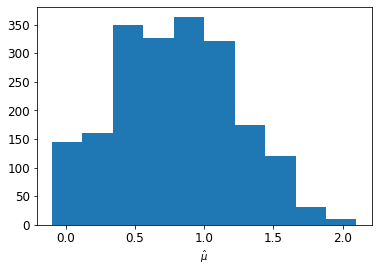

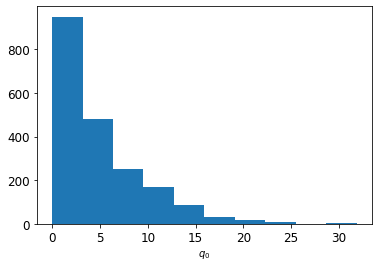

Z BL:(1.9202984745021774, 0.8052204411747172, 1.0155750000000001, 1.9204605570531283, 0.7941734136340879)
Z:1.8768264000918506
Z_std:1.2672788540192492
Z_1:1.825678233885005
Z_std_1:1.5196460398839629
3
AUC:0.901670633006385
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

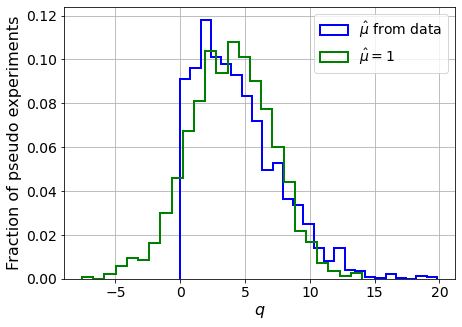

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  6477.84145577
  6238.00220397  5920.13962681  5534.55530302  5067.44533402
  4486.91548237  3771.87485588  2911.14268338  1879.06944106
   624.21190744  -891.93881092 -2698.38741538 -5294.03903417]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  4189.6697361   4211.33315464  4221.70101961


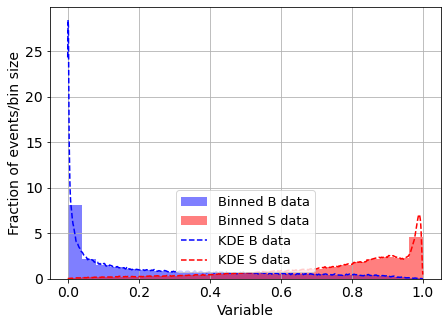

KDE Kernel:  epanechnikov
Background bandwidth:  0.0031053121543406503
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.011826891570831456
0.011826891570831456
3 done
4 done
0.003253466790725219
0.003253466790725219


  0%|▎                                                                  | 8/2000 [00:03<14:37,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44134512175747953
<p_{s}(Sdata)> = 2.05659396186463
<p_{b}(Bdata)> = 5.347956461603394
<p_{s}(Bdata)> = 0.4239283194635981


  1%|▍                                                                 | 13/2000 [00:06<17:31,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4072521787676735
<p_{s}(Sdata)> = 2.1596857555844275
<p_{b}(Bdata)> = 5.391322171737672
<p_{s}(Bdata)> = 0.4222940312689466


  1%|▉                                                                 | 29/2000 [00:15<11:23,  2.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5887095699062288
<p_{s}(Sdata)> = 2.0166408016999604
<p_{b}(Bdata)> = 5.42600650366209
<p_{s}(Bdata)> = 0.4210920952216413


  2%|█▏                                                                | 37/2000 [00:20<13:10,  2.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4299018077822666
<p_{s}(Sdata)> = 1.932633819513445
<p_{b}(Bdata)> = 5.3932250110348114
<p_{s}(Bdata)> = 0.42204707048454854


  2%|█▍                                                                | 45/2000 [00:23<10:23,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45027518211270845
<p_{s}(Sdata)> = 1.8455334871196534
<p_{b}(Bdata)> = 5.468527716936387
<p_{s}(Bdata)> = 0.4209594814824041


  3%|██                                                                | 64/2000 [00:32<11:53,  2.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4178006693956902
<p_{s}(Sdata)> = 1.9008022366694448
<p_{b}(Bdata)> = 5.431041280010681
<p_{s}(Bdata)> = 0.42414755597109305


  5%|███▏                                                              | 97/2000 [00:48<11:24,  2.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4960748675451771
<p_{s}(Sdata)> = 1.9619762302348738
<p_{b}(Bdata)> = 5.382838396547246
<p_{s}(Bdata)> = 0.4278100484049949


  6%|███▋                                                             | 112/2000 [00:55<13:59,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4517886443593247
<p_{s}(Sdata)> = 1.7748515314742415
<p_{b}(Bdata)> = 5.303097070667054
<p_{s}(Bdata)> = 0.41900261045099874


  6%|████▏                                                            | 127/2000 [01:02<11:19,  2.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6094126505095628
<p_{s}(Sdata)> = 1.7548358241388433
<p_{b}(Bdata)> = 5.411915587855611
<p_{s}(Bdata)> = 0.42604723905729414


  6%|████▏                                                            | 129/2000 [01:03<09:16,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4312599411148882
<p_{s}(Sdata)> = 1.8482900981221144
<p_{b}(Bdata)> = 5.40426489407903
<p_{s}(Bdata)> = 0.41906205391183343


  8%|████▉                                                            | 153/2000 [01:15<13:40,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4239142423880937
<p_{s}(Sdata)> = 2.2023297054868594
<p_{b}(Bdata)> = 5.3937392345905755
<p_{s}(Bdata)> = 0.41909292334060316


  8%|█████                                                            | 156/2000 [01:16<09:48,  3.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4890286236967208
<p_{s}(Sdata)> = 1.865993127579689
<p_{b}(Bdata)> = 5.355014771923052
<p_{s}(Bdata)> = 0.42006131245334505


  8%|█████▎                                                           | 163/2000 [01:19<11:54,  2.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4653226704848766
<p_{s}(Sdata)> = 1.823145026598727
<p_{b}(Bdata)> = 5.454144773396225
<p_{s}(Bdata)> = 0.4211152568378024


  9%|█████▉                                                           | 182/2000 [01:28<13:39,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4947075417042015
<p_{s}(Sdata)> = 1.7352047464228675
<p_{b}(Bdata)> = 5.429031926919473
<p_{s}(Bdata)> = 0.42484214537452125


 10%|██████▋                                                          | 207/2000 [01:41<12:20,  2.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44582154557800513
<p_{s}(Sdata)> = 1.933526793038462
<p_{b}(Bdata)> = 5.325866301482898
<p_{s}(Bdata)> = 0.42126071509668017


 10%|██████▊                                                          | 210/2000 [01:42<10:20,  2.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5292708851398845
<p_{s}(Sdata)> = 1.9754180567924022
<p_{b}(Bdata)> = 5.439322585718693
<p_{s}(Bdata)> = 0.4194748820569121


 12%|███████▊                                                         | 240/2000 [01:58<12:43,  2.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46632455626079994
<p_{s}(Sdata)> = 2.3782119265067343
<p_{b}(Bdata)> = 5.370721986475907
<p_{s}(Bdata)> = 0.42016690111937677


 12%|████████                                                         | 247/2000 [02:01<08:44,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43602901111642767
<p_{s}(Sdata)> = 1.8592588815958158
<p_{b}(Bdata)> = 5.394063708842527
<p_{s}(Bdata)> = 0.42298362099597936
muhat = -0.1
<p_{b}(Sdata)> = 0.38688142308444473
<p_{s}(Sdata)> = 2.0680748480122997
<p_{b}(Bdata)> = 5.3191664789236475
<p_{s}(Bdata)> = 0.41858506286851516


 13%|████████▎                                                        | 257/2000 [02:05<10:05,  2.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41235446855706487
<p_{s}(Sdata)> = 2.237418538694637
<p_{b}(Bdata)> = 5.503557984969931
<p_{s}(Bdata)> = 0.4165144966228528


 13%|████████▋                                                        | 266/2000 [02:09<12:16,  2.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45050685584751504
<p_{s}(Sdata)> = 2.140109041843219
<p_{b}(Bdata)> = 5.337125275250184
<p_{s}(Bdata)> = 0.42602694468817076


 14%|█████████▏                                                       | 281/2000 [02:16<12:33,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5508256995533781
<p_{s}(Sdata)> = 2.201914797041023
<p_{b}(Bdata)> = 5.371817066544595
<p_{s}(Bdata)> = 0.42272230520953763


 15%|█████████▊                                                       | 303/2000 [02:27<11:03,  2.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.452444264809799
<p_{s}(Sdata)> = 2.1953120523917264
<p_{b}(Bdata)> = 5.471633365774797
<p_{s}(Bdata)> = 0.41873609135752027


 16%|██████████▍                                                      | 323/2000 [02:44<17:20,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4869731018969816
<p_{s}(Sdata)> = 1.7450006445010888
<p_{b}(Bdata)> = 5.346322777963006
<p_{s}(Bdata)> = 0.42767090061585034


 16%|██████████▋                                                      | 327/2000 [02:46<13:26,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4297591072703705
<p_{s}(Sdata)> = 1.9651436588918436
<p_{b}(Bdata)> = 5.29958121207911
<p_{s}(Bdata)> = 0.42320515783255575


 17%|██████████▊                                                      | 333/2000 [02:48<09:42,  2.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6599522347578605
<p_{s}(Sdata)> = 2.1559372225520987
<p_{b}(Bdata)> = 5.3966421155813835
<p_{s}(Bdata)> = 0.4207177250591211
muhat = -0.1
<p_{b}(Sdata)> = 0.41173011720707386
<p_{s}(Sdata)> = 2.051734557690198
<p_{b}(Bdata)> = 5.450918419524215
<p_{s}(Bdata)> = 0.42300275479171423


 17%|███████████▏                                                     | 345/2000 [02:53<08:42,  3.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5122613432945674
<p_{s}(Sdata)> = 1.7107529459837494
<p_{b}(Bdata)> = 5.416692922542903
<p_{s}(Bdata)> = 0.4226841177250881


 18%|███████████▍                                                     | 352/2000 [02:56<09:33,  2.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40726836112106735
<p_{s}(Sdata)> = 2.2176055229756133
<p_{b}(Bdata)> = 5.439011751731375
<p_{s}(Bdata)> = 0.41770996587370895


 18%|███████████▌                                                     | 356/2000 [02:58<09:16,  2.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46955774385675525
<p_{s}(Sdata)> = 1.8900814473480434
<p_{b}(Bdata)> = 5.434836153325866
<p_{s}(Bdata)> = 0.42033123398596145


 18%|███████████▉                                                     | 369/2000 [03:04<10:57,  2.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4355519725108655
<p_{s}(Sdata)> = 1.9040526710049344
<p_{b}(Bdata)> = 5.430806233436414
<p_{s}(Bdata)> = 0.42673258774699274


 19%|████████████▌                                                    | 387/2000 [03:15<11:18,  2.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44752846992172
<p_{s}(Sdata)> = 2.1506249798358383
<p_{b}(Bdata)> = 5.401148643932414
<p_{s}(Bdata)> = 0.4261240052484648


 20%|████████████▊                                                    | 395/2000 [03:19<09:55,  2.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3860746831612856
<p_{s}(Sdata)> = 2.0880533960219014
<p_{b}(Bdata)> = 5.341130122199385
<p_{s}(Bdata)> = 0.4255378372067171


 20%|████████████▉                                                    | 398/2000 [03:20<09:56,  2.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4373837998888319
<p_{s}(Sdata)> = 1.7894087279559208
<p_{b}(Bdata)> = 5.428008998774445
<p_{s}(Bdata)> = 0.41962981130657145


 20%|█████████████▎                                                   | 410/2000 [03:26<09:55,  2.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44044520446183894
<p_{s}(Sdata)> = 2.008681829108998
<p_{b}(Bdata)> = 5.340800429602223
<p_{s}(Bdata)> = 0.4221104826058541


 21%|█████████████▌                                                   | 418/2000 [03:29<10:31,  2.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42661937722273807
<p_{s}(Sdata)> = 1.82670892717046
<p_{b}(Bdata)> = 5.413544420117165
<p_{s}(Bdata)> = 0.4234444563695948


 21%|█████████████▊                                                   | 424/2000 [03:32<08:59,  2.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40086073442045456
<p_{s}(Sdata)> = 2.1245151912599907
<p_{b}(Bdata)> = 5.348707422583205
<p_{s}(Bdata)> = 0.41941203961553375
muhat = -0.1
<p_{b}(Sdata)> = 0.40809146299626453
<p_{s}(Sdata)> = 2.118444113722396
<p_{b}(Bdata)> = 5.474266500691168
<p_{s}(Bdata)> = 0.4183821134276599


 22%|██████████████▏                                                  | 435/2000 [03:37<10:45,  2.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48002841402579627
<p_{s}(Sdata)> = 1.6848837498276714
<p_{b}(Bdata)> = 5.461166108458792
<p_{s}(Bdata)> = 0.4179603301303087


 22%|██████████████▌                                                  | 449/2000 [03:44<09:17,  2.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4308487385533796
<p_{s}(Sdata)> = 1.8783938316092172
<p_{b}(Bdata)> = 5.32969254591319
<p_{s}(Bdata)> = 0.4299272439091415


 23%|██████████████▉                                                  | 458/2000 [03:48<09:07,  2.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48017234283739796
<p_{s}(Sdata)> = 1.9342031312646835
<p_{b}(Bdata)> = 5.308806698678255
<p_{s}(Bdata)> = 0.4261541550019298


 23%|███████████████                                                  | 465/2000 [03:52<11:17,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44088199265311784
<p_{s}(Sdata)> = 2.046595517461117
<p_{b}(Bdata)> = 5.371787965785105
<p_{s}(Bdata)> = 0.41647682773771194


 24%|███████████████▎                                                 | 471/2000 [03:54<06:41,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4086688598692981
<p_{s}(Sdata)> = 2.0996601655577227
<p_{b}(Bdata)> = 5.4229328288287535
<p_{s}(Bdata)> = 0.4189694670294736
muhat = -0.1
<p_{b}(Sdata)> = 0.40082830094077204
<p_{s}(Sdata)> = 2.092302405226597
<p_{b}(Bdata)> = 5.303867692339261
<p_{s}(Bdata)> = 0.4217227012890508


 24%|███████████████▍                                                 | 476/2000 [03:56<09:06,  2.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44915729067275617
<p_{s}(Sdata)> = 1.9853318077654747
<p_{b}(Bdata)> = 5.407798934538439
<p_{s}(Bdata)> = 0.41936835659976784


 25%|████████████████▍                                                | 507/2000 [04:06<08:20,  2.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4323746494012286
<p_{s}(Sdata)> = 1.9776219452543515
<p_{b}(Bdata)> = 5.286855202601168
<p_{s}(Bdata)> = 0.42413805793279247


 27%|█████████████████▍                                               | 538/2000 [04:16<07:58,  3.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40692481082708376
<p_{s}(Sdata)> = 1.9194737465331837
<p_{b}(Bdata)> = 5.383771554191381
<p_{s}(Bdata)> = 0.4233015347197617


 29%|██████████████████▋                                              | 574/2000 [04:27<06:03,  3.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.404610549107477
<p_{s}(Sdata)> = 2.2499832878109696
<p_{b}(Bdata)> = 5.476509665309214
<p_{s}(Bdata)> = 0.4157516760443494


 31%|███████████████████▊                                             | 611/2000 [04:39<05:57,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8132379172240103
<p_{s}(Sdata)> = 1.8111731377792628
<p_{b}(Bdata)> = 5.298625887034908
<p_{s}(Bdata)> = 0.42304409709134055


 31%|████████████████████▍                                            | 627/2000 [04:45<06:32,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43455592225149287
<p_{s}(Sdata)> = 1.8599844997551038
<p_{b}(Bdata)> = 5.415517495676379
<p_{s}(Bdata)> = 0.4273110361561514


 33%|█████████████████████▎                                           | 657/2000 [04:55<07:36,  2.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5775727243548374
<p_{s}(Sdata)> = 1.9436124233219956
<p_{b}(Bdata)> = 5.3828755167502305
<p_{s}(Bdata)> = 0.4242917771082956


 33%|█████████████████████▌                                           | 665/2000 [04:57<05:59,  3.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.39832824579028103
<p_{s}(Sdata)> = 2.5592353999793085
<p_{b}(Bdata)> = 5.3541247792053115
<p_{s}(Bdata)> = 0.43549655193003195


 34%|██████████████████████                                           | 678/2000 [05:02<07:15,  3.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43854982605258197
<p_{s}(Sdata)> = 2.022845182302621
<p_{b}(Bdata)> = 5.354076010094447
<p_{s}(Bdata)> = 0.42615772779596967


 34%|██████████████████████                                           | 680/2000 [05:02<06:07,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3866400258268821
<p_{s}(Sdata)> = 2.300291613417605
<p_{b}(Bdata)> = 5.408292670376434
<p_{s}(Bdata)> = 0.4201427037375163


 34%|██████████████████████▏                                          | 684/2000 [05:03<05:48,  3.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45309420248134913
<p_{s}(Sdata)> = 1.9202639615777075
<p_{b}(Bdata)> = 5.295009124078333
<p_{s}(Bdata)> = 0.42069082611413816


 35%|██████████████████████▊                                          | 702/2000 [05:09<05:28,  3.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4224738762659724
<p_{s}(Sdata)> = 2.0490025544593813
<p_{b}(Bdata)> = 5.333585396305724
<p_{s}(Bdata)> = 0.4231025291792841


 35%|██████████████████████▊                                          | 703/2000 [05:09<05:13,  4.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4042129478774036
<p_{s}(Sdata)> = 1.9558286352754943
<p_{b}(Bdata)> = 5.357801789165126
<p_{s}(Bdata)> = 0.42171926445644253


 35%|██████████████████████▉                                          | 707/2000 [05:10<06:16,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4834810731614677
<p_{s}(Sdata)> = 2.077439026242345
<p_{b}(Bdata)> = 5.328912313790064
<p_{s}(Bdata)> = 0.4244682231205948


 36%|███████████████████████▌                                         | 725/2000 [05:16<06:49,  3.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45064446732229074
<p_{s}(Sdata)> = 1.9765668385467676
<p_{b}(Bdata)> = 5.359703720645826
<p_{s}(Bdata)> = 0.42358330970153696


 37%|████████████████████████                                         | 739/2000 [05:20<07:25,  2.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40217007371486224
<p_{s}(Sdata)> = 2.075574096374304
<p_{b}(Bdata)> = 5.251989393238775
<p_{s}(Bdata)> = 0.42418801713341026


 37%|████████████████████████▏                                        | 743/2000 [05:21<06:55,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4242428563092931
<p_{s}(Sdata)> = 1.963644643857098
<p_{b}(Bdata)> = 5.445623735335259
<p_{s}(Bdata)> = 0.42158531160703355


 37%|████████████████████████▎                                        | 747/2000 [05:23<06:58,  3.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41147960793587646
<p_{s}(Sdata)> = 2.0424369846432127
<p_{b}(Bdata)> = 5.3416507966425275
<p_{s}(Bdata)> = 0.4207930253943239


 38%|████████████████████████▋                                        | 758/2000 [05:26<08:19,  2.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40983870442347486
<p_{s}(Sdata)> = 1.9325207853763624
<p_{b}(Bdata)> = 5.452853364350121
<p_{s}(Bdata)> = 0.41837191329237083


 39%|█████████████████████████▎                                       | 777/2000 [05:33<07:11,  2.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45241812112532465
<p_{s}(Sdata)> = 1.949556331347226
<p_{b}(Bdata)> = 5.360567508605531
<p_{s}(Bdata)> = 0.42309833282635567


 39%|█████████████████████████▋                                       | 789/2000 [05:37<07:24,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45953074198499166
<p_{s}(Sdata)> = 2.001195842261123
<p_{b}(Bdata)> = 5.409221827807657
<p_{s}(Bdata)> = 0.41975013155351576


 40%|██████████████████████████                                       | 800/2000 [05:39<04:53,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5028982371128348
<p_{s}(Sdata)> = 1.7942606195516628
<p_{b}(Bdata)> = 5.377970387245153
<p_{s}(Bdata)> = 0.42119461180016243


 40%|██████████████████████████                                       | 802/2000 [05:40<05:06,  3.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46953704813316977
<p_{s}(Sdata)> = 2.0338254620583567
<p_{b}(Bdata)> = 5.348700994048322
<p_{s}(Bdata)> = 0.4209456313248071


 41%|██████████████████████████▉                                      | 827/2000 [05:48<07:18,  2.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38929361720735267
<p_{s}(Sdata)> = 2.2640227132436874
<p_{b}(Bdata)> = 5.406217604944598
<p_{s}(Bdata)> = 0.4176468021512185


 42%|███████████████████████████▍                                     | 845/2000 [05:54<04:52,  3.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4810627078753302
<p_{s}(Sdata)> = 1.797066665623641
<p_{b}(Bdata)> = 5.3408661217436615
<p_{s}(Bdata)> = 0.4221515227692566


 43%|███████████████████████████▊                                     | 855/2000 [05:58<07:25,  2.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3951023768099612
<p_{s}(Sdata)> = 2.1446115669759123
<p_{b}(Bdata)> = 5.400785850918112
<p_{s}(Bdata)> = 0.4183763757860291


 43%|███████████████████████████▉                                     | 858/2000 [05:59<06:19,  3.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4322624703441375
<p_{s}(Sdata)> = 2.176646225533729
<p_{b}(Bdata)> = 5.314387382229492
<p_{s}(Bdata)> = 0.4251788344670995


 43%|████████████████████████████                                     | 863/2000 [06:00<05:07,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3973181877538156
<p_{s}(Sdata)> = 1.9813153889396526
<p_{b}(Bdata)> = 5.362956098719153
<p_{s}(Bdata)> = 0.4214508910415575


 44%|████████████████████████████▎                                    | 872/2000 [06:03<07:07,  2.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5318998011251407
<p_{s}(Sdata)> = 1.9592632886518515
<p_{b}(Bdata)> = 5.457381104488608
<p_{s}(Bdata)> = 0.4173870521756184


 44%|████████████████████████████▍                                    | 876/2000 [06:04<05:55,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41255738386535074
<p_{s}(Sdata)> = 2.3041808527389374
<p_{b}(Bdata)> = 5.411282449831793
<p_{s}(Bdata)> = 0.4249868905244865


 45%|████████████████████████████▉                                    | 892/2000 [06:09<05:56,  3.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41648418690933486
<p_{s}(Sdata)> = 2.174631035112475
<p_{b}(Bdata)> = 5.554288710369696
<p_{s}(Bdata)> = 0.41809532735581445


 47%|██████████████████████████████▌                                  | 939/2000 [06:23<04:26,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42300146903165464
<p_{s}(Sdata)> = 1.9249584059096656
<p_{b}(Bdata)> = 5.368804244524736
<p_{s}(Bdata)> = 0.42070679792551186


 48%|███████████████████████████████▎                                 | 964/2000 [06:31<05:31,  3.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4162456193378823
<p_{s}(Sdata)> = 1.8512551618467465
<p_{b}(Bdata)> = 5.438049589384958
<p_{s}(Bdata)> = 0.42556063109256037


 49%|███████████████████████████████▌                                 | 972/2000 [06:34<05:05,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5438856408343105
<p_{s}(Sdata)> = 2.1174746651718332
<p_{b}(Bdata)> = 5.359542137813809
<p_{s}(Bdata)> = 0.42089918905654056


 49%|███████████████████████████████▉                                 | 984/2000 [06:38<05:55,  2.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45320098127370617
<p_{s}(Sdata)> = 1.8785099291324088
<p_{b}(Bdata)> = 5.392638075216982
<p_{s}(Bdata)> = 0.4232419332424636


 49%|████████████████████████████████▏                                | 989/2000 [06:39<05:42,  2.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49405021709540936
<p_{s}(Sdata)> = 1.7976545512061337
<p_{b}(Bdata)> = 5.368911838485108
<p_{s}(Bdata)> = 0.41855531059988266


 50%|████████████████████████████████▍                                | 997/2000 [06:42<05:39,  2.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5127500963179158
<p_{s}(Sdata)> = 1.9942682286931828
<p_{b}(Bdata)> = 5.3916181519539315
<p_{s}(Bdata)> = 0.42384359342971684


 51%|████████████████████████████████▍                               | 1014/2000 [06:47<04:54,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43582701277461267
<p_{s}(Sdata)> = 2.1834774829194687
<p_{b}(Bdata)> = 5.306582186350527
<p_{s}(Bdata)> = 0.42157808715779677


 52%|█████████████████████████████████▍                              | 1045/2000 [06:56<03:52,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44168678934792727
<p_{s}(Sdata)> = 1.8272603928510796
<p_{b}(Bdata)> = 5.395063809135183
<p_{s}(Bdata)> = 0.42196079847462165


 53%|█████████████████████████████████▋                              | 1052/2000 [06:58<05:30,  2.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43242620129412834
<p_{s}(Sdata)> = 1.7288503461753721
<p_{b}(Bdata)> = 5.371030026198456
<p_{s}(Bdata)> = 0.4209217216873316


 53%|██████████████████████████████████                              | 1064/2000 [07:02<05:57,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5384368909472746
<p_{s}(Sdata)> = 1.7922712967723253
<p_{b}(Bdata)> = 5.412153729075216
<p_{s}(Bdata)> = 0.4225687548144449


 53%|██████████████████████████████████▏                             | 1069/2000 [07:04<05:01,  3.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45593745956531356
<p_{s}(Sdata)> = 1.8425065461356858
<p_{b}(Bdata)> = 5.383938338514394
<p_{s}(Bdata)> = 0.41957646634112145


 55%|██████████████████████████████████▉                             | 1093/2000 [07:11<04:36,  3.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4378628946195891
<p_{s}(Sdata)> = 2.268994549634332
<p_{b}(Bdata)> = 5.38475160288755
<p_{s}(Bdata)> = 0.4217522811467059


 55%|███████████████████████████████████▏                            | 1098/2000 [07:13<04:39,  3.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7560089468449158
<p_{s}(Sdata)> = 2.0240389382832156
<p_{b}(Bdata)> = 5.413673542321494
<p_{s}(Bdata)> = 0.41505206413120993


 55%|███████████████████████████████████▍                            | 1106/2000 [07:15<05:01,  2.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42222443903933343
<p_{s}(Sdata)> = 2.192959090559991
<p_{b}(Bdata)> = 5.408547955341619
<p_{s}(Bdata)> = 0.41934569394373755


 56%|███████████████████████████████████▊                            | 1119/2000 [07:20<05:34,  2.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47204584592216087
<p_{s}(Sdata)> = 1.8898523572555521
<p_{b}(Bdata)> = 5.396826663989423
<p_{s}(Bdata)> = 0.4171416870036968


 57%|████████████████████████████████████▎                           | 1136/2000 [07:25<05:22,  2.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4215782596655027
<p_{s}(Sdata)> = 2.0452168994460327
<p_{b}(Bdata)> = 5.37889736799163
<p_{s}(Bdata)> = 0.42039399703493524


 57%|████████████████████████████████████▌                           | 1143/2000 [07:27<05:01,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4857281872036006
<p_{s}(Sdata)> = 1.8252455811406798
<p_{b}(Bdata)> = 5.4841337471543925
<p_{s}(Bdata)> = 0.42301424628927126


 58%|█████████████████████████████████████▏                          | 1161/2000 [07:33<05:13,  2.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4682415750310188
<p_{s}(Sdata)> = 1.7662248236633966
<p_{b}(Bdata)> = 5.393892498011893
<p_{s}(Bdata)> = 0.4228276214591941


 58%|█████████████████████████████████████▏                          | 1163/2000 [07:33<03:54,  3.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5162820879338736
<p_{s}(Sdata)> = 1.7329427310629744
<p_{b}(Bdata)> = 5.318289385342529
<p_{s}(Bdata)> = 0.4261359917884576


 59%|█████████████████████████████████████▌                          | 1173/2000 [07:36<03:50,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4439274042641032
<p_{s}(Sdata)> = 2.20107941377664
<p_{b}(Bdata)> = 5.4235786553574155
<p_{s}(Bdata)> = 0.4200206406321326


 59%|█████████████████████████████████████▋                          | 1176/2000 [07:37<03:36,  3.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6224358996590075
<p_{s}(Sdata)> = 1.708590171162459
<p_{b}(Bdata)> = 5.393196035151781
<p_{s}(Bdata)> = 0.421801555017934


 59%|█████████████████████████████████████▊                          | 1181/2000 [07:38<03:18,  4.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5002080783542089
<p_{s}(Sdata)> = 2.16847297942013
<p_{b}(Bdata)> = 5.400795040654698
<p_{s}(Bdata)> = 0.42594969746805084


 60%|██████████████████████████████████████▎                         | 1198/2000 [07:44<04:12,  3.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.468917061243971
<p_{s}(Sdata)> = 1.8515804947639347
<p_{b}(Bdata)> = 5.43243166102256
<p_{s}(Bdata)> = 0.42023143511897953


 62%|███████████████████████████████████████▋                        | 1242/2000 [07:57<03:13,  3.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3687307047240226
<p_{s}(Sdata)> = 2.223883663171474
<p_{b}(Bdata)> = 5.428527068644928
<p_{s}(Bdata)> = 0.41667540423525073


 63%|████████████████████████████████████████▏                       | 1256/2000 [08:01<03:29,  3.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4995933704609643
<p_{s}(Sdata)> = 1.8484699000733424
<p_{b}(Bdata)> = 5.392879759256068
<p_{s}(Bdata)> = 0.4257688211032536


 63%|████████████████████████████████████████▌                       | 1268/2000 [08:04<02:18,  5.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5545246458612855
<p_{s}(Sdata)> = 1.6833916316569812
<p_{b}(Bdata)> = 5.289648096940335
<p_{s}(Bdata)> = 0.4232192080920057
muhat = -0.1
<p_{b}(Sdata)> = 0.4248537266530314
<p_{s}(Sdata)> = 2.063285948283228
<p_{b}(Bdata)> = 5.428799330996821
<p_{s}(Bdata)> = 0.4225044524656966


 64%|████████████████████████████████████████▊                       | 1274/2000 [08:06<04:17,  2.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3887522219542467
<p_{s}(Sdata)> = 2.2259493427530805
<p_{b}(Bdata)> = 5.343495595284682
<p_{s}(Bdata)> = 0.4195670053909663


 66%|█████████████████████████████████████████▉                      | 1312/2000 [08:17<03:26,  3.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5019672282190338
<p_{s}(Sdata)> = 1.974688066222365
<p_{b}(Bdata)> = 5.317319663054495
<p_{s}(Bdata)> = 0.41989887587968144


 66%|██████████████████████████████████████████                      | 1314/2000 [08:18<03:03,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45199653146853247
<p_{s}(Sdata)> = 1.943200678749324
<p_{b}(Bdata)> = 5.345548578155237
<p_{s}(Bdata)> = 0.4251716963453528


 66%|██████████████████████████████████████████▏                     | 1318/2000 [08:19<02:58,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41422565084980606
<p_{s}(Sdata)> = 2.012849365613444
<p_{b}(Bdata)> = 5.368699301053029
<p_{s}(Bdata)> = 0.42465050858549275


 66%|██████████████████████████████████████████▎                     | 1324/2000 [08:20<02:49,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46487371834937385
<p_{s}(Sdata)> = 1.9531191152750842
<p_{b}(Bdata)> = 5.350184207429511
<p_{s}(Bdata)> = 0.42486046360148405


 68%|███████████████████████████████████████████▌                    | 1363/2000 [08:33<03:09,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.402477887900434
<p_{s}(Sdata)> = 2.0396209005644237
<p_{b}(Bdata)> = 5.413517715881354
<p_{s}(Bdata)> = 0.42118079705860684


 69%|████████████████████████████████████████████                    | 1375/2000 [08:36<03:20,  3.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4400576724797739
<p_{s}(Sdata)> = 1.945437329144522
<p_{b}(Bdata)> = 5.3276931289838645
<p_{s}(Bdata)> = 0.42202172694013207


 70%|████████████████████████████████████████████▉                   | 1404/2000 [08:45<03:57,  2.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4019959788435677
<p_{s}(Sdata)> = 1.7733761591020525
<p_{b}(Bdata)> = 5.374376792522219
<p_{s}(Bdata)> = 0.4207361593932263


 71%|█████████████████████████████████████████████▍                  | 1418/2000 [08:49<02:32,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49251196376046535
<p_{s}(Sdata)> = 2.3343190008968566
<p_{b}(Bdata)> = 5.301440015117816
<p_{s}(Bdata)> = 0.41943056085667296


 71%|█████████████████████████████████████████████▌                  | 1423/2000 [08:50<02:04,  4.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43520081269060834
<p_{s}(Sdata)> = 1.9754838619851252
<p_{b}(Bdata)> = 5.302292288437326
<p_{s}(Bdata)> = 0.4224660125372433
muhat = -0.1
<p_{b}(Sdata)> = 0.4673085935735085
<p_{s}(Sdata)> = 1.8812346916061193
<p_{b}(Bdata)> = 5.433241088937357
<p_{s}(Bdata)> = 0.42183476232815237


 71%|█████████████████████████████████████████████▋                  | 1427/2000 [08:51<01:49,  5.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39491754843195653
<p_{s}(Sdata)> = 2.108301869429702
<p_{b}(Bdata)> = 5.424134332312567
<p_{s}(Bdata)> = 0.4171654870064584


 71%|█████████████████████████████████████████████▋                  | 1428/2000 [08:51<02:18,  4.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4413107070415437
<p_{s}(Sdata)> = 2.022058081852477
<p_{b}(Bdata)> = 5.229062186639823
<p_{s}(Bdata)> = 0.4227293492447543


 72%|█████████████████████████████████████████████▉                  | 1434/2000 [08:53<02:40,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4200569428025997
<p_{s}(Sdata)> = 2.019727137623315
<p_{b}(Bdata)> = 5.418286721561862
<p_{s}(Bdata)> = 0.42508899174342074


 73%|██████████████████████████████████████████████▍                 | 1452/2000 [08:59<03:05,  2.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4553760715413262
<p_{s}(Sdata)> = 1.7193546570572686
<p_{b}(Bdata)> = 5.326739545890562
<p_{s}(Bdata)> = 0.4299177061026435


 73%|██████████████████████████████████████████████▌                 | 1454/2000 [09:00<02:28,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4611918856120567
<p_{s}(Sdata)> = 1.7322080419220514
<p_{b}(Bdata)> = 5.331033747451861
<p_{s}(Bdata)> = 0.4252509963500655


 73%|██████████████████████████████████████████████▋                 | 1459/2000 [09:01<02:17,  3.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42438343527862726
<p_{s}(Sdata)> = 2.0672742042688297
<p_{b}(Bdata)> = 5.393279208707745
<p_{s}(Bdata)> = 0.41990188138114365


 74%|███████████████████████████████████████████████▎                | 1477/2000 [09:06<02:44,  3.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4585717079267807
<p_{s}(Sdata)> = 1.8372095910380986
<p_{b}(Bdata)> = 5.480709549812819
<p_{s}(Bdata)> = 0.4195626423416661


 74%|███████████████████████████████████████████████▌                | 1486/2000 [09:08<01:54,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3901645664261661
<p_{s}(Sdata)> = 2.2591599927120782
<p_{b}(Bdata)> = 5.44639049744244
<p_{s}(Bdata)> = 0.4209716700624647


 75%|███████████████████████████████████████████████▋                | 1491/2000 [09:10<02:45,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38753125114065834
<p_{s}(Sdata)> = 2.070853854083886
<p_{b}(Bdata)> = 5.420599043969563
<p_{s}(Bdata)> = 0.4217396917845091


 75%|███████████████████████████████████████████████▊                | 1494/2000 [09:11<02:36,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4593100005963666
<p_{s}(Sdata)> = 2.000070334611582
<p_{b}(Bdata)> = 5.425858859588913
<p_{s}(Bdata)> = 0.42275180664458467


 75%|████████████████████████████████████████████████▏               | 1505/2000 [09:15<03:06,  2.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39329044131474095
<p_{s}(Sdata)> = 2.1177132054589674
<p_{b}(Bdata)> = 5.3566107628543165
<p_{s}(Bdata)> = 0.4211122959907671


 75%|████████████████████████████████████████████████▎               | 1508/2000 [09:15<02:24,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44918722858289545
<p_{s}(Sdata)> = 1.7411167963764038
<p_{b}(Bdata)> = 5.353236566657508
<p_{s}(Bdata)> = 0.42081939908926097


 76%|████████████████████████████████████████████████▎               | 1511/2000 [09:16<02:05,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4267381430154547
<p_{s}(Sdata)> = 2.064950125154597
<p_{b}(Bdata)> = 5.3387469794079605
<p_{s}(Bdata)> = 0.4203055775778434


 76%|████████████████████████████████████████████████▊               | 1525/2000 [09:21<02:14,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5161896367959404
<p_{s}(Sdata)> = 1.804853529645978
<p_{b}(Bdata)> = 5.401134005247213
<p_{s}(Bdata)> = 0.42071593082526204


 78%|█████████████████████████████████████████████████▋              | 1553/2000 [09:29<01:32,  4.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47239473915999475
<p_{s}(Sdata)> = 1.82945869279506
<p_{b}(Bdata)> = 5.498730737925197
<p_{s}(Bdata)> = 0.42013563001717397
muhat = -0.1
<p_{b}(Sdata)> = 0.4376921509826814
<p_{s}(Sdata)> = 2.1696198903982125
<p_{b}(Bdata)> = 5.397341771016785
<p_{s}(Bdata)> = 0.4224122422541077


 78%|█████████████████████████████████████████████████▊              | 1555/2000 [09:30<02:02,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45936638613031044
<p_{s}(Sdata)> = 1.9234744049254062
<p_{b}(Bdata)> = 5.3753887521617045
<p_{s}(Bdata)> = 0.42119946031050765


 78%|█████████████████████████████████████████████████▉              | 1559/2000 [09:31<01:56,  3.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4954443307791345
<p_{s}(Sdata)> = 1.8214922508028921
<p_{b}(Bdata)> = 5.328587806841253
<p_{s}(Bdata)> = 0.4239293040420812


 78%|██████████████████████████████████████████████████              | 1563/2000 [09:32<02:04,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40822896883018506
<p_{s}(Sdata)> = 2.0280710437905753
<p_{b}(Bdata)> = 5.394977140853832
<p_{s}(Bdata)> = 0.4187511327791717


 78%|██████████████████████████████████████████████████              | 1565/2000 [09:32<02:16,  3.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4529552249232225
<p_{s}(Sdata)> = 2.0870462495782385
<p_{b}(Bdata)> = 5.412869433528762
<p_{s}(Bdata)> = 0.41937838619829226


 78%|██████████████████████████████████████████████████▏             | 1569/2000 [09:33<02:06,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4768313056373323
<p_{s}(Sdata)> = 1.7958703817694246
<p_{b}(Bdata)> = 5.3836716569423215
<p_{s}(Bdata)> = 0.42431831845844964


 79%|██████████████████████████████████████████████████▍             | 1575/2000 [09:35<01:47,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5054443828186852
<p_{s}(Sdata)> = 1.8146532788148515
<p_{b}(Bdata)> = 5.352013625942677
<p_{s}(Bdata)> = 0.4306101856768859


 80%|███████████████████████████████████████████████████             | 1597/2000 [09:42<02:10,  3.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4938157699974124
<p_{s}(Sdata)> = 1.8835074007100183
<p_{b}(Bdata)> = 5.391435265712844
<p_{s}(Bdata)> = 0.4188790806300133


 80%|███████████████████████████████████████████████████▎            | 1605/2000 [09:44<01:59,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45165852043058163
<p_{s}(Sdata)> = 2.033625315707854
<p_{b}(Bdata)> = 5.36270636033815
<p_{s}(Bdata)> = 0.4191972110907496


 81%|███████████████████████████████████████████████████▊            | 1621/2000 [09:48<01:24,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.53355718353469
<p_{s}(Sdata)> = 1.4871145550934315
<p_{b}(Bdata)> = 5.393295795311366
<p_{s}(Bdata)> = 0.4179406406912545


 82%|████████████████████████████████████████████████████▋           | 1646/2000 [09:56<01:46,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42211407916437654
<p_{s}(Sdata)> = 2.0945455493691245
<p_{b}(Bdata)> = 5.3371755734203425
<p_{s}(Bdata)> = 0.4264558845493392


 83%|████████████████████████████████████████████████████▊           | 1651/2000 [09:58<01:54,  3.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43337715611774313
<p_{s}(Sdata)> = 1.8800520210950866
<p_{b}(Bdata)> = 5.491388510243167
<p_{s}(Bdata)> = 0.4201506179841444


 83%|████████████████████████████████████████████████████▉           | 1653/2000 [09:58<01:28,  3.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4120635439480734
<p_{s}(Sdata)> = 2.1262050120437452
<p_{b}(Bdata)> = 5.431038185284909
<p_{s}(Bdata)> = 0.4167709997498313


 83%|█████████████████████████████████████████████████████           | 1657/2000 [09:59<01:05,  5.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.44628856787455773
<p_{s}(Sdata)> = 2.1686189733033463
<p_{b}(Bdata)> = 5.429391724229906
<p_{s}(Bdata)> = 0.4359716895077283
muhat = -0.1
<p_{b}(Sdata)> = 0.4535983525839239
<p_{s}(Sdata)> = 2.1528202434819055
<p_{b}(Bdata)> = 5.397909366944067
<p_{s}(Bdata)> = 0.4193812671860231


 83%|█████████████████████████████████████████████████████▏          | 1664/2000 [10:01<01:56,  2.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42683778333165684
<p_{s}(Sdata)> = 2.1035857328006964
<p_{b}(Bdata)> = 5.2870860993860775
<p_{s}(Bdata)> = 0.42332756443517255


 84%|█████████████████████████████████████████████████████▋          | 1679/2000 [10:06<01:38,  3.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46604726861153856
<p_{s}(Sdata)> = 2.137953818771818
<p_{b}(Bdata)> = 5.416393815064512
<p_{s}(Bdata)> = 0.4177718893532781


 84%|█████████████████████████████████████████████████████▊          | 1681/2000 [10:06<01:18,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45507887085509435
<p_{s}(Sdata)> = 1.702226536400862
<p_{b}(Bdata)> = 5.327083944256779
<p_{s}(Bdata)> = 0.4299080992755793


 84%|██████████████████████████████████████████████████████          | 1688/2000 [10:08<01:36,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5112288682514137
<p_{s}(Sdata)> = 1.7737148159406673
<p_{b}(Bdata)> = 5.4189824645481615
<p_{s}(Bdata)> = 0.4195920891742584


 86%|██████████████████████████████████████████████████████▊         | 1711/2000 [10:16<01:22,  3.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43802989310482976
<p_{s}(Sdata)> = 1.9855313298352333
<p_{b}(Bdata)> = 5.331508960960252
<p_{s}(Bdata)> = 0.42006151773959666


 86%|███████████████████████████████████████████████████████         | 1721/2000 [10:19<01:12,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46942825090861673
<p_{s}(Sdata)> = 1.834736104755969
<p_{b}(Bdata)> = 5.394585463711676
<p_{s}(Bdata)> = 0.4228769124362642


 87%|███████████████████████████████████████████████████████▍        | 1731/2000 [10:22<01:45,  2.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49155111174085614
<p_{s}(Sdata)> = 2.3115688575761304
<p_{b}(Bdata)> = 5.40730828477575
<p_{s}(Bdata)> = 0.41837716923891477


 87%|███████████████████████████████████████████████████████▍        | 1733/2000 [10:22<01:14,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4522428653175499
<p_{s}(Sdata)> = 1.9836752002063531
<p_{b}(Bdata)> = 5.486805747124017
<p_{s}(Bdata)> = 0.41859380333325735


 87%|███████████████████████████████████████████████████████▌        | 1738/2000 [10:23<00:48,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5186336110430428
<p_{s}(Sdata)> = 1.9634264287315466
<p_{b}(Bdata)> = 5.433469100166374
<p_{s}(Bdata)> = 0.42296220689524855
muhat = -0.1
<p_{b}(Sdata)> = 0.43598641610065697
<p_{s}(Sdata)> = 2.023124134627191
<p_{b}(Bdata)> = 5.400290353024788
<p_{s}(Bdata)> = 0.42461679410641434


 87%|███████████████████████████████████████████████████████▋        | 1740/2000 [10:24<01:06,  3.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41126630461520425
<p_{s}(Sdata)> = 2.4279583091815438
<p_{b}(Bdata)> = 5.447741980875393
<p_{s}(Bdata)> = 0.42044182469120733


 88%|████████████████████████████████████████████████████████        | 1752/2000 [10:27<01:10,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41710832505609474
<p_{s}(Sdata)> = 1.906154566559566
<p_{b}(Bdata)> = 5.293665805449193
<p_{s}(Bdata)> = 0.4260385039048081


 88%|████████████████████████████████████████████████████████▏       | 1754/2000 [10:27<01:04,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4826321219104436
<p_{s}(Sdata)> = 1.8958227287442704
<p_{b}(Bdata)> = 5.31288926234971
<p_{s}(Bdata)> = 0.4211657069016598


 88%|████████████████████████████████████████████████████████▌       | 1766/2000 [10:31<01:24,  2.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.505518813238257
<p_{s}(Sdata)> = 2.098200544337835
<p_{b}(Bdata)> = 5.430014974844304
<p_{s}(Bdata)> = 0.4202513956762394


 89%|████████████████████████████████████████████████████████▋       | 1773/2000 [10:33<01:18,  2.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4664394646884602
<p_{s}(Sdata)> = 2.0510617801551256
<p_{b}(Bdata)> = 5.437556671584438
<p_{s}(Bdata)> = 0.4171257859689426


 91%|██████████████████████████████████████████████████████████      | 1814/2000 [10:46<01:03,  2.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45042961210489924
<p_{s}(Sdata)> = 1.8393432619884609
<p_{b}(Bdata)> = 5.302826792538577
<p_{s}(Bdata)> = 0.42343522206001444


 92%|██████████████████████████████████████████████████████████▌     | 1830/2000 [10:50<00:48,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4750586085640874
<p_{s}(Sdata)> = 1.917102539160654
<p_{b}(Bdata)> = 5.348776990614212
<p_{s}(Bdata)> = 0.4209848341331702


 92%|███████████████████████████████████████████████████████████     | 1845/2000 [10:55<00:56,  2.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4328558798569319
<p_{s}(Sdata)> = 2.0825932310074347
<p_{b}(Bdata)> = 5.355247034634233
<p_{s}(Bdata)> = 0.41874627728603997


 92%|███████████████████████████████████████████████████████████▏    | 1849/2000 [10:56<00:41,  3.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4402839940568757
<p_{s}(Sdata)> = 1.810215515646425
<p_{b}(Bdata)> = 5.3474653150639435
<p_{s}(Bdata)> = 0.42027617312056154


 93%|███████████████████████████████████████████████████████████▍    | 1856/2000 [10:58<00:40,  3.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42690517953796736
<p_{s}(Sdata)> = 2.021573241472759
<p_{b}(Bdata)> = 5.333031711653636
<p_{s}(Bdata)> = 0.4223904312354266


 94%|███████████████████████████████████████████████████████████▊    | 1870/2000 [11:02<00:26,  4.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.483035022552751
<p_{s}(Sdata)> = 1.814981677059858
<p_{b}(Bdata)> = 5.345358675568796
<p_{s}(Bdata)> = 0.41934213329849584


 95%|████████████████████████████████████████████████████████████▉   | 1904/2000 [11:12<00:28,  3.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.54374260959436
<p_{s}(Sdata)> = 2.0184175246838123
<p_{b}(Bdata)> = 5.5132786557863245
<p_{s}(Bdata)> = 0.4207180471202626


 96%|█████████████████████████████████████████████████████████████   | 1910/2000 [11:14<00:18,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4532039190185282
<p_{s}(Sdata)> = 1.9976748778683355
<p_{b}(Bdata)> = 5.350356451511495
<p_{s}(Bdata)> = 0.42512089797366437
muhat = -0.1
<p_{b}(Sdata)> = 0.37321178500609004
<p_{s}(Sdata)> = 2.2166868446408103
<p_{b}(Bdata)> = 5.428986417359292
<p_{s}(Bdata)> = 0.416772193044916
muhat = -0.1
<p_{b}(Sdata)> = 0.44009555957943014
<p_{s}(Sdata)> = 2.1303012237810917
<p_{b}(Bdata)> = 5.39237183898492
<p_{s}(Bdata)> = 0.4209670382502693


 96%|█████████████████████████████████████████████████████████████▌  | 1922/2000 [11:17<00:15,  5.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4240949265937385
<p_{s}(Sdata)> = 2.0239932080510874
<p_{b}(Bdata)> = 5.347844576437725
<p_{s}(Bdata)> = 0.4166171758212768
muhat = -0.1
<p_{b}(Sdata)> = 0.47096587196958833
<p_{s}(Sdata)> = 1.948326425365878
<p_{b}(Bdata)> = 5.504727097770752
<p_{s}(Bdata)> = 0.41681278021246676


 96%|█████████████████████████████████████████████████████████████▋  | 1927/2000 [11:17<00:12,  5.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49483096610717603
<p_{s}(Sdata)> = 2.001922593528055
<p_{b}(Bdata)> = 5.313956182024812
<p_{s}(Bdata)> = 0.4204913354027692
muhat = -0.1
<p_{b}(Sdata)> = 0.46296472413394385
<p_{s}(Sdata)> = 2.0937350054343873
<p_{b}(Bdata)> = 5.369500413334424
<p_{s}(Bdata)> = 0.4207881168113892


 97%|█████████████████████████████████████████████████████████████▉  | 1936/2000 [11:20<00:21,  2.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4173500550501183
<p_{s}(Sdata)> = 2.294052519224571
<p_{b}(Bdata)> = 5.432263928105186
<p_{s}(Bdata)> = 0.4157271223738547


 97%|██████████████████████████████████████████████████████████████  | 1938/2000 [11:21<00:15,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4408025385964105
<p_{s}(Sdata)> = 1.9718982864082848
<p_{b}(Bdata)> = 5.514162809750652
<p_{s}(Bdata)> = 0.41320578957718396


 98%|██████████████████████████████████████████████████████████████▍ | 1953/2000 [11:26<00:15,  3.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.415557973762604
<p_{s}(Sdata)> = 2.04647769970983
<p_{b}(Bdata)> = 5.36244642894403
<p_{s}(Bdata)> = 0.4224503651658838


 98%|██████████████████████████████████████████████████████████████▉ | 1967/2000 [11:30<00:08,  3.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45955007457605884
<p_{s}(Sdata)> = 1.842619883674861
<p_{b}(Bdata)> = 5.3868981665877635
<p_{s}(Bdata)> = 0.424424285200036


 98%|███████████████████████████████████████████████████████████████ | 1970/2000 [11:31<00:09,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4203244849285737
<p_{s}(Sdata)> = 2.0357726404541454
<p_{b}(Bdata)> = 5.359205483888883
<p_{s}(Bdata)> = 0.42412855005936495


 99%|███████████████████████████████████████████████████████████████▎| 1977/2000 [11:33<00:06,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4302310793504661
<p_{s}(Sdata)> = 2.1915848661255883
<p_{b}(Bdata)> = 5.362932897327207
<p_{s}(Bdata)> = 0.423812996816011


100%|████████████████████████████████████████████████████████████████| 2000/2000 [11:40<00:00,  2.85it/s]


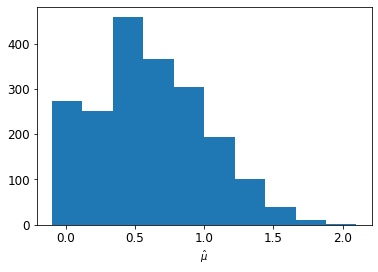

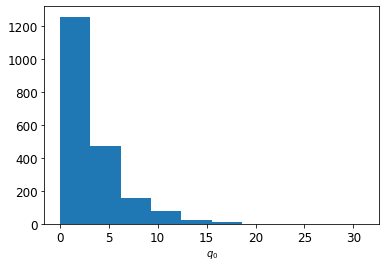

Z BL:(1.9809110370581646, 0.7996723654612633, 1.013775, 1.9817167256876511, 0.8029382720601502)
Z:1.3994539072197618
Z_std:1.1685014882192477
Z_1:1.0005212788660074
Z_std_1:2.425124950135676
4
AUC:0.9027832704608142
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

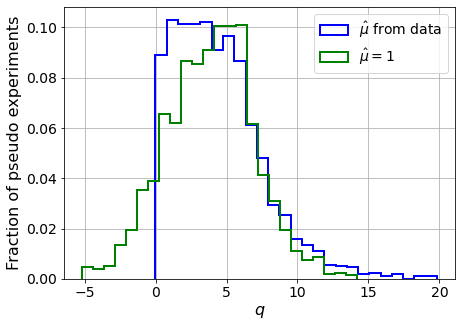

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
  6673.85064043  6320.31240984  5889.07639582  5364.74467791
  4725.87778777  3935.39308161  3012.85779027  1939.16148952
   643.92284336  -895.87338974 -2735.18427117 -5309.52823254]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  4237.37126037  4258.85351097  4268.90381807


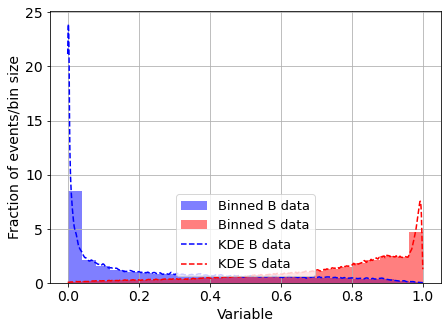

KDE Kernel:  epanechnikov
Background bandwidth:  0.005072980090653727
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.01269195756427669
0.01269195756427669
3 done
4 done
0.007811938268494832
0.007811938268494832


  1%|▎                                                                 | 11/2000 [00:03<07:37,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5691845027358162
<p_{s}(Sdata)> = 1.9883766583961398
<p_{b}(Bdata)> = 5.417052731748715
<p_{s}(Bdata)> = 0.42068922656666097
muhat = -0.1
<p_{b}(Sdata)> = 0.4499055059511942
<p_{s}(Sdata)> = 2.1848137934600644
<p_{b}(Bdata)> = 5.493774925219123
<p_{s}(Bdata)> = 0.4134661799557152


  1%|▋                                                                 | 21/2000 [00:06<11:34,  2.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39968192545089737
<p_{s}(Sdata)> = 2.099811040814073
<p_{b}(Bdata)> = 5.520863126756411
<p_{s}(Bdata)> = 0.41765492783507446


  1%|▉                                                                 | 28/2000 [00:08<08:05,  4.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46171681476235776
<p_{s}(Sdata)> = 1.7840292676224263
<p_{b}(Bdata)> = 5.416844198362747
<p_{s}(Bdata)> = 0.4221713814568828
muhat = -0.1
<p_{b}(Sdata)> = 0.5129583485910258
<p_{s}(Sdata)> = 1.8299785534565403
<p_{b}(Bdata)> = 5.420682787839584
<p_{s}(Bdata)> = 0.4154962202331043


  2%|█▏                                                                | 36/2000 [00:10<08:32,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4939205348320384
<p_{s}(Sdata)> = 1.6744521712803704
<p_{b}(Bdata)> = 5.413494954421603
<p_{s}(Bdata)> = 0.42070031452692813


  2%|█▍                                                                | 43/2000 [00:12<07:44,  4.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49767041124402217
<p_{s}(Sdata)> = 1.834318126321023
<p_{b}(Bdata)> = 5.382155304728287
<p_{s}(Bdata)> = 0.41897351988667125


  3%|█▋                                                                | 51/2000 [00:14<09:16,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44786486134023773
<p_{s}(Sdata)> = 1.8952696869048076
<p_{b}(Bdata)> = 5.4446267716406735
<p_{s}(Bdata)> = 0.41809942494468216


  3%|█▊                                                                | 55/2000 [00:15<09:09,  3.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4506011674630676
<p_{s}(Sdata)> = 2.070572423622393
<p_{b}(Bdata)> = 5.367051175261611
<p_{s}(Bdata)> = 0.42012988243581717


  3%|██                                                                | 62/2000 [00:17<09:55,  3.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5539709600496149
<p_{s}(Sdata)> = 1.9869108831884197
<p_{b}(Bdata)> = 5.370486130398617
<p_{s}(Bdata)> = 0.41669067259688874


  4%|██▍                                                               | 72/2000 [00:20<08:01,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4185565717838685
<p_{s}(Sdata)> = 1.9324862746521354
<p_{b}(Bdata)> = 5.419172198753286
<p_{s}(Bdata)> = 0.4189771834708842


  4%|██▌                                                               | 76/2000 [00:21<06:50,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36460975193414163
<p_{s}(Sdata)> = 2.359207136240547
<p_{b}(Bdata)> = 5.463983895372691
<p_{s}(Bdata)> = 0.4168171193525561


  4%|██▋                                                               | 80/2000 [00:22<06:33,  4.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4114592367886839
<p_{s}(Sdata)> = 1.9100206158328719
<p_{b}(Bdata)> = 5.321402981779035
<p_{s}(Bdata)> = 0.42038684831818457


  5%|███▏                                                              | 95/2000 [00:26<08:37,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4954362566661176
<p_{s}(Sdata)> = 1.8155075698376897
<p_{b}(Bdata)> = 5.39557682819691
<p_{s}(Bdata)> = 0.41964981007742125


  5%|███▎                                                             | 102/2000 [00:28<09:19,  3.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5525291800143773
<p_{s}(Sdata)> = 1.7172858751331537
<p_{b}(Bdata)> = 5.42176721426251
<p_{s}(Bdata)> = 0.4205055848458631


  6%|███▌                                                             | 111/2000 [00:30<08:12,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4548537031950313
<p_{s}(Sdata)> = 2.1898919053322627
<p_{b}(Bdata)> = 5.4560703163948325
<p_{s}(Bdata)> = 0.41697784343211647


  6%|███▉                                                             | 121/2000 [00:33<07:11,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44039720111040126
<p_{s}(Sdata)> = 2.0450609505585704
<p_{b}(Bdata)> = 5.398505610570837
<p_{s}(Bdata)> = 0.4221760464960496


  6%|████                                                             | 125/2000 [00:34<07:11,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5633281875554177
<p_{s}(Sdata)> = 2.0279620074035702
<p_{b}(Bdata)> = 5.351862945329103
<p_{s}(Bdata)> = 0.4222056880222462
muhat = -0.1
<p_{b}(Sdata)> = 0.44328365490905475
<p_{s}(Sdata)> = 2.128270313383894
<p_{b}(Bdata)> = 5.386565323103904
<p_{s}(Bdata)> = 0.41878983297529326


  7%|████▍                                                            | 135/2000 [00:36<06:31,  4.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47254222075820235
<p_{s}(Sdata)> = 1.9463928367712637
<p_{b}(Bdata)> = 5.381741496571564
<p_{s}(Bdata)> = 0.42076378749654153


  7%|████▋                                                            | 146/2000 [00:39<06:49,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4327478863628236
<p_{s}(Sdata)> = 2.236438069185952
<p_{b}(Bdata)> = 5.510466441113376
<p_{s}(Bdata)> = 0.41537085570406657


  8%|█████▍                                                           | 166/2000 [00:46<07:52,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5650569024717516
<p_{s}(Sdata)> = 1.8831994108177936
<p_{b}(Bdata)> = 5.501274792247107
<p_{s}(Bdata)> = 0.41846904261672396


  9%|█████▋                                                           | 175/2000 [00:48<06:46,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4946332354072651
<p_{s}(Sdata)> = 2.1996538730180415
<p_{b}(Bdata)> = 5.435148695813276
<p_{s}(Bdata)> = 0.41975776359806405
muhat = -0.1
<p_{b}(Sdata)> = 0.407361347391526
<p_{s}(Sdata)> = 2.172994819126219
<p_{b}(Bdata)> = 5.397326347384889
<p_{s}(Bdata)> = 0.41770524231064327


  9%|█████▊                                                           | 178/2000 [00:49<06:52,  4.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5192190090760417
<p_{s}(Sdata)> = 1.7421502380088176
<p_{b}(Bdata)> = 5.419095470416849
<p_{s}(Bdata)> = 0.42599102872228795


 10%|██████▏                                                          | 191/2000 [00:53<09:09,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41172201924685
<p_{s}(Sdata)> = 2.119500474179512
<p_{b}(Bdata)> = 5.46827187321053
<p_{s}(Bdata)> = 0.4257770444872501


 10%|██████▎                                                          | 195/2000 [00:53<06:06,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41403724401602726
<p_{s}(Sdata)> = 1.8623405689273351
<p_{b}(Bdata)> = 5.334989079216581
<p_{s}(Bdata)> = 0.4212798004121583
muhat = -0.1
<p_{b}(Sdata)> = 0.4990066127406063
<p_{s}(Sdata)> = 1.9910485866537064
<p_{b}(Bdata)> = 5.405713102957817
<p_{s}(Bdata)> = 0.420215310616627


 10%|██████▌                                                          | 200/2000 [00:54<04:40,  6.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5075202090244533
<p_{s}(Sdata)> = 2.1910459437222225
<p_{b}(Bdata)> = 5.555589823779747
<p_{s}(Bdata)> = 0.4188118980587771
muhat = -0.1
<p_{b}(Sdata)> = 0.42513332968944306
<p_{s}(Sdata)> = 1.9873489988769828
<p_{b}(Bdata)> = 5.464147065622537
<p_{s}(Bdata)> = 0.41715388025019684


 10%|██████▌                                                          | 203/2000 [00:55<04:24,  6.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5101693551089728
<p_{s}(Sdata)> = 2.348367286918756
<p_{b}(Bdata)> = 5.3932773645647645
<p_{s}(Bdata)> = 0.419844833308612


 11%|██████▊                                                          | 211/2000 [00:57<08:28,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.435959707406059
<p_{s}(Sdata)> = 2.2763494372460165
<p_{b}(Bdata)> = 5.349997099293415
<p_{s}(Bdata)> = 0.42244810574320407


 11%|███████                                                          | 216/2000 [00:58<07:24,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42050949064405413
<p_{s}(Sdata)> = 2.1782353100884366
<p_{b}(Bdata)> = 5.391963715749386
<p_{s}(Bdata)> = 0.4141591863845507


 11%|███████                                                          | 218/2000 [00:58<06:27,  4.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5405853225906642
<p_{s}(Sdata)> = 2.0958871523617444
<p_{b}(Bdata)> = 5.423901284411078
<p_{s}(Bdata)> = 0.41308848828611455


 11%|███████▏                                                         | 222/2000 [00:59<06:43,  4.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38367065951717044
<p_{s}(Sdata)> = 2.3031468108305013
<p_{b}(Bdata)> = 5.401640440548901
<p_{s}(Bdata)> = 0.4184387155012301


 11%|███████▍                                                         | 229/2000 [01:01<06:48,  4.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47652957245232347
<p_{s}(Sdata)> = 1.894345089985962
<p_{b}(Bdata)> = 5.3514773331953345
<p_{s}(Bdata)> = 0.4253389440549307


 12%|███████▋                                                         | 238/2000 [01:03<04:49,  6.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.459863966644333
<p_{s}(Sdata)> = 1.9357170799842482
<p_{b}(Bdata)> = 5.45244158211229
<p_{s}(Bdata)> = 0.41756440758786895
muhat = -0.1
<p_{b}(Sdata)> = 0.5229789665938458
<p_{s}(Sdata)> = 2.010199673498588
<p_{b}(Bdata)> = 5.448442459881809
<p_{s}(Bdata)> = 0.41947156228539584


 12%|███████▊                                                         | 240/2000 [01:03<05:42,  5.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7405974522850749
<p_{s}(Sdata)> = 2.1950239153563857
<p_{b}(Bdata)> = 5.539216788360145
<p_{s}(Bdata)> = 0.41942611203301905


 12%|███████▉                                                         | 243/2000 [01:04<05:30,  5.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4819554397525736
<p_{s}(Sdata)> = 1.9763375614841412
<p_{b}(Bdata)> = 5.434624868958928
<p_{s}(Bdata)> = 0.41904319347843483


 12%|████████                                                         | 247/2000 [01:04<04:21,  6.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4743866736695996
<p_{s}(Sdata)> = 1.9648915093339199
<p_{b}(Bdata)> = 5.343592001369025
<p_{s}(Bdata)> = 0.42052880859208475
muhat = -0.1
<p_{b}(Sdata)> = 0.4229791067500328
<p_{s}(Sdata)> = 2.3845349968196063
<p_{b}(Bdata)> = 5.3206486527018795
<p_{s}(Bdata)> = 0.4180263982079695
muhat = -0.1
<p_{b}(Sdata)> = 0.39636285456269976
<p_{s}(Sdata)> = 2.2410494988298266
<p_{b}(Bdata)> = 5.413874455022632
<p_{s}(Bdata)> = 0.422404751982281


 12%|████████                                                         | 249/2000 [01:04<03:42,  7.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4883074364059561
<p_{s}(Sdata)> = 1.8222942088307674
<p_{b}(Bdata)> = 5.46050030748102
<p_{s}(Bdata)> = 0.4185162720379555


 13%|████████▏                                                        | 251/2000 [01:05<05:16,  5.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6827625108442198
<p_{s}(Sdata)> = 2.0469343016797135
<p_{b}(Bdata)> = 5.420042611089705
<p_{s}(Bdata)> = 0.4161265957454919


 13%|████████▎                                                        | 255/2000 [01:06<06:04,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4076722762909844
<p_{s}(Sdata)> = 1.9548081729265103
<p_{b}(Bdata)> = 5.425726594889748
<p_{s}(Bdata)> = 0.41278926227311685


 14%|████████▊                                                        | 273/2000 [01:10<06:58,  4.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4026873936348011
<p_{s}(Sdata)> = 2.159239426740748
<p_{b}(Bdata)> = 5.3882535731174
<p_{s}(Bdata)> = 0.4233836303487118


 14%|█████████▏                                                       | 283/2000 [01:13<07:42,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49392120009418733
<p_{s}(Sdata)> = 2.227804805285713
<p_{b}(Bdata)> = 5.464644959865464
<p_{s}(Bdata)> = 0.41637220460936314


 14%|█████████▎                                                       | 287/2000 [01:14<05:20,  5.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6799353619669216
<p_{s}(Sdata)> = 1.82548950498745
<p_{b}(Bdata)> = 5.440297489395804
<p_{s}(Bdata)> = 0.4200592642462732


 14%|█████████▍                                                       | 289/2000 [01:14<04:39,  6.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41661991676503374
<p_{s}(Sdata)> = 2.0817657629316524
<p_{b}(Bdata)> = 5.424058562546221
<p_{s}(Bdata)> = 0.41865661406830035


 15%|█████████▊                                                       | 300/2000 [01:17<06:37,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4547254057533249
<p_{s}(Sdata)> = 1.8479021265647726
<p_{b}(Bdata)> = 5.435431393381567
<p_{s}(Bdata)> = 0.4222324886231287


 15%|█████████▉                                                       | 305/2000 [01:18<04:53,  5.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49507072348961817
<p_{s}(Sdata)> = 1.76173063523069
<p_{b}(Bdata)> = 5.467942479551628
<p_{s}(Bdata)> = 0.42130199774318444
muhat = -0.1
<p_{b}(Sdata)> = 0.4899636403565973
<p_{s}(Sdata)> = 1.9534522253838718
<p_{b}(Bdata)> = 5.488690585593269
<p_{s}(Bdata)> = 0.41752371738856753


 15%|██████████                                                       | 309/2000 [01:19<04:34,  6.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5700578728679431
<p_{s}(Sdata)> = 2.099468651304618
<p_{b}(Bdata)> = 5.3671848461562695
<p_{s}(Bdata)> = 0.4239588135941504
muhat = -0.1
<p_{b}(Sdata)> = 0.37065789086169887
<p_{s}(Sdata)> = 2.301000961583106
<p_{b}(Bdata)> = 5.310593912350859
<p_{s}(Bdata)> = 0.42000942343735426


 16%|██████████▏                                                      | 312/2000 [01:19<05:05,  5.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42044554822362923
<p_{s}(Sdata)> = 2.0204840464635354
<p_{b}(Bdata)> = 5.322119977525641
<p_{s}(Bdata)> = 0.42051760554607115


 16%|██████████▍                                                      | 320/2000 [01:22<09:31,  2.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4767157584392774
<p_{s}(Sdata)> = 1.8416396416533891
<p_{b}(Bdata)> = 5.374304753388067
<p_{s}(Bdata)> = 0.4228462688356674


 16%|██████████▋                                                      | 327/2000 [01:24<06:26,  4.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4269290565836894
<p_{s}(Sdata)> = 2.026662764737064
<p_{b}(Bdata)> = 5.4280428148438915
<p_{s}(Bdata)> = 0.4171534399573103
muhat = -0.1
<p_{b}(Sdata)> = 0.4378288257005461
<p_{s}(Sdata)> = 2.0380094403790925
<p_{b}(Bdata)> = 5.38489538452736
<p_{s}(Bdata)> = 0.4175822016384151


 17%|██████████▊                                                      | 331/2000 [01:25<07:06,  3.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4679091204257774
<p_{s}(Sdata)> = 1.837071828897736
<p_{b}(Bdata)> = 5.4671279959137005
<p_{s}(Bdata)> = 0.41863081905755223


 17%|██████████▉                                                      | 336/2000 [01:26<05:57,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40442191341763045
<p_{s}(Sdata)> = 2.1391942100902934
<p_{b}(Bdata)> = 5.385975200054088
<p_{s}(Bdata)> = 0.416335724683465


 17%|███████████                                                      | 341/2000 [01:27<07:24,  3.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4953129477133723
<p_{s}(Sdata)> = 2.064281974696217
<p_{b}(Bdata)> = 5.477770938160375
<p_{s}(Bdata)> = 0.4167140955448359


 18%|███████████▍                                                     | 350/2000 [01:29<06:39,  4.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3807532654691173
<p_{s}(Sdata)> = 2.385925451691987
<p_{b}(Bdata)> = 5.285899967970568
<p_{s}(Bdata)> = 0.42091151186627423


 18%|███████████▌                                                     | 357/2000 [01:32<09:43,  2.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5844354505709787
<p_{s}(Sdata)> = 2.024906539920026
<p_{b}(Bdata)> = 5.445202432230507
<p_{s}(Bdata)> = 0.4193320653787923


 18%|███████████▋                                                     | 360/2000 [01:32<07:20,  3.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37778140082234724
<p_{s}(Sdata)> = 2.255347073402771
<p_{b}(Bdata)> = 5.392422421231956
<p_{s}(Bdata)> = 0.41858931129294125


 18%|███████████▉                                                     | 367/2000 [01:35<09:02,  3.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4321586408456884
<p_{s}(Sdata)> = 2.0279741943758123
<p_{b}(Bdata)> = 5.430966480133435
<p_{s}(Bdata)> = 0.421491893375615


 19%|████████████                                                     | 373/2000 [01:37<09:34,  2.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.518198880397127
<p_{s}(Sdata)> = 2.3048781906213995
<p_{b}(Bdata)> = 5.387744317375461
<p_{s}(Bdata)> = 0.42222006047613253


 20%|████████████▊                                                    | 394/2000 [01:42<07:02,  3.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43780030356131056
<p_{s}(Sdata)> = 1.8466371361880103
<p_{b}(Bdata)> = 5.441952295721102
<p_{s}(Bdata)> = 0.4210857415255631


 20%|█████████████                                                    | 403/2000 [01:45<07:10,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4301053721394791
<p_{s}(Sdata)> = 1.9673219363544314
<p_{b}(Bdata)> = 5.408116349638943
<p_{s}(Bdata)> = 0.42265222901700417


 20%|█████████████▎                                                   | 410/2000 [01:46<05:26,  4.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6408623212855719
<p_{s}(Sdata)> = 1.788594944633357
<p_{b}(Bdata)> = 5.418746974360257
<p_{s}(Bdata)> = 0.4180894922199399


 21%|█████████████▌                                                   | 416/2000 [01:48<05:09,  5.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4158800799802303
<p_{s}(Sdata)> = 2.2249151621930228
<p_{b}(Bdata)> = 5.36249643074171
<p_{s}(Bdata)> = 0.42081393011759305
muhat = -0.1
<p_{b}(Sdata)> = 0.4470894258452968
<p_{s}(Sdata)> = 2.0402905340348445
<p_{b}(Bdata)> = 5.419769248840109
<p_{s}(Bdata)> = 0.4150583728290714


 21%|█████████████▌                                                   | 418/2000 [01:49<06:50,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3960681994156557
<p_{s}(Sdata)> = 2.0880846647115088
<p_{b}(Bdata)> = 5.417316563444007
<p_{s}(Bdata)> = 0.4190675555210374


 21%|█████████████▉                                                   | 427/2000 [01:51<08:41,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.481716634117927
<p_{s}(Sdata)> = 1.9991039709305256
<p_{b}(Bdata)> = 5.4062282888307145
<p_{s}(Bdata)> = 0.4253758492827839


 22%|██████████████▋                                                  | 450/2000 [01:57<06:02,  4.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.530528609288161
<p_{s}(Sdata)> = 2.0637476345166177
<p_{b}(Bdata)> = 5.377170976293641
<p_{s}(Bdata)> = 0.4210692281647394


 23%|██████████████▊                                                  | 456/2000 [01:59<07:09,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.512472732755746
<p_{s}(Sdata)> = 2.185082769970053
<p_{b}(Bdata)> = 5.488707071665322
<p_{s}(Bdata)> = 0.41550537405428434


 23%|██████████████▉                                                  | 461/2000 [02:00<07:51,  3.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5035038346623187
<p_{s}(Sdata)> = 2.127748865604742
<p_{b}(Bdata)> = 5.353874285208098
<p_{s}(Bdata)> = 0.4178122373153615


 23%|███████████████▏                                                 | 469/2000 [02:02<07:10,  3.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4771245606696452
<p_{s}(Sdata)> = 1.9113136377635056
<p_{b}(Bdata)> = 5.383839941332962
<p_{s}(Bdata)> = 0.4191462949421915


 24%|███████████████▎                                                 | 471/2000 [02:03<05:36,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43515692181855326
<p_{s}(Sdata)> = 1.98766151870994
<p_{b}(Bdata)> = 5.431334090742299
<p_{s}(Bdata)> = 0.4227353132777775


 25%|███████████████▉                                                 | 491/2000 [02:08<05:35,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4535111754271644
<p_{s}(Sdata)> = 1.935736955968812
<p_{b}(Bdata)> = 5.452843823605845
<p_{s}(Bdata)> = 0.4181326620337286


 25%|████████████████▏                                                | 498/2000 [02:10<05:36,  4.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3857572011058037
<p_{s}(Sdata)> = 2.0633835920966814
<p_{b}(Bdata)> = 5.417446228745039
<p_{s}(Bdata)> = 0.42346573715428804


 25%|████████████████▎                                                | 503/2000 [02:11<05:45,  4.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3655290364507359
<p_{s}(Sdata)> = 2.3751736436109687
<p_{b}(Bdata)> = 5.487517259570903
<p_{s}(Bdata)> = 0.41823335284024976


 25%|████████████████▍                                                | 505/2000 [02:12<06:31,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4071611580599059
<p_{s}(Sdata)> = 2.2732745124471347
<p_{b}(Bdata)> = 5.431748483611999
<p_{s}(Bdata)> = 0.4184399218694593


 25%|████████████████▌                                                | 509/2000 [02:13<05:50,  4.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45644409110127426
<p_{s}(Sdata)> = 2.0578089029150113
<p_{b}(Bdata)> = 5.438506667436838
<p_{s}(Bdata)> = 0.4193823488301189


 26%|████████████████▋                                                | 515/2000 [02:14<06:26,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49448007085544365
<p_{s}(Sdata)> = 1.7508507947842973
<p_{b}(Bdata)> = 5.377855077196464
<p_{s}(Bdata)> = 0.4251656738819925


 26%|████████████████▉                                                | 522/2000 [02:15<04:07,  5.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43911808422617044
<p_{s}(Sdata)> = 1.9129575354336512
<p_{b}(Bdata)> = 5.464179177107078
<p_{s}(Bdata)> = 0.4186756515016415
muhat = -0.1
<p_{b}(Sdata)> = 0.4046969255600538
<p_{s}(Sdata)> = 2.1291307427422046
<p_{b}(Bdata)> = 5.433579758685618
<p_{s}(Bdata)> = 0.4188116310786081


 26%|█████████████████                                                | 526/2000 [02:17<05:33,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42634428600266316
<p_{s}(Sdata)> = 2.1251561173142086
<p_{b}(Bdata)> = 5.477061095861379
<p_{s}(Bdata)> = 0.41654331867607874


 26%|█████████████████▏                                               | 529/2000 [02:17<05:09,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43131726629986317
<p_{s}(Sdata)> = 2.1910007077842995
<p_{b}(Bdata)> = 5.4091989608349005
<p_{s}(Bdata)> = 0.4206442046056919


 27%|█████████████████▍                                               | 538/2000 [02:19<06:16,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4750267147115303
<p_{s}(Sdata)> = 2.051503354661746
<p_{b}(Bdata)> = 5.408133449079944
<p_{s}(Bdata)> = 0.42180422933301154


 27%|█████████████████▋                                               | 545/2000 [02:21<07:10,  3.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4168200442966507
<p_{s}(Sdata)> = 2.2648669963992503
<p_{b}(Bdata)> = 5.375610991368624
<p_{s}(Bdata)> = 0.41858474077593355


 27%|█████████████████▊                                               | 547/2000 [02:22<06:12,  3.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5716053065798283
<p_{s}(Sdata)> = 1.6898107479656648
<p_{b}(Bdata)> = 5.529135451400868
<p_{s}(Bdata)> = 0.4139526868375009


 28%|██████████████████                                               | 554/2000 [02:23<04:27,  5.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4542155433141776
<p_{s}(Sdata)> = 2.026656546579349
<p_{b}(Bdata)> = 5.40505115531573
<p_{s}(Bdata)> = 0.42332606857611654
muhat = -0.1
<p_{b}(Sdata)> = 0.4856143219899878
<p_{s}(Sdata)> = 2.000807307993604
<p_{b}(Bdata)> = 5.502831600941074
<p_{s}(Bdata)> = 0.41849829458009985


 28%|██████████████████                                               | 557/2000 [02:24<05:32,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.494076590203869
<p_{s}(Sdata)> = 2.393994471450819
<p_{b}(Bdata)> = 5.360083827016569
<p_{s}(Bdata)> = 0.42235909896724083


 28%|██████████████████▎                                              | 562/2000 [02:24<03:40,  6.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44669620126609455
<p_{s}(Sdata)> = 2.1657191396018467
<p_{b}(Bdata)> = 5.38910485682436
<p_{s}(Bdata)> = 0.4201378868601756
muhat = -0.1
<p_{b}(Sdata)> = 0.38396465013692505
<p_{s}(Sdata)> = 2.211404729590442
<p_{b}(Bdata)> = 5.4536268216586725
<p_{s}(Bdata)> = 0.4217937117166114


 28%|██████████████████▌                                              | 570/2000 [02:26<05:50,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44605695709026316
<p_{s}(Sdata)> = 2.1300815066388905
<p_{b}(Bdata)> = 5.3895713793525895
<p_{s}(Bdata)> = 0.41957837205051907


 29%|███████████████████                                              | 587/2000 [02:31<04:44,  4.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3705888054555038
<p_{s}(Sdata)> = 2.2878698351189564
<p_{b}(Bdata)> = 5.403266473925153
<p_{s}(Bdata)> = 0.4163330131682528
muhat = -0.1
<p_{b}(Sdata)> = 0.37976712775534416
<p_{s}(Sdata)> = 2.195872671074
<p_{b}(Bdata)> = 5.427996094977219
<p_{s}(Bdata)> = 0.42450205507763034


 29%|███████████████████                                              | 588/2000 [02:31<05:32,  4.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4346359038118495
<p_{s}(Sdata)> = 1.9122124577177184
<p_{b}(Bdata)> = 5.399699767217102
<p_{s}(Bdata)> = 0.41841539102822345


 30%|███████████████████▌                                             | 601/2000 [02:35<05:27,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43148334674850797
<p_{s}(Sdata)> = 1.788563772307559
<p_{b}(Bdata)> = 5.389314789198604
<p_{s}(Bdata)> = 0.4219864104296016


 30%|███████████████████▋                                             | 605/2000 [02:35<04:34,  5.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44455195155077065
<p_{s}(Sdata)> = 1.924437181903112
<p_{b}(Bdata)> = 5.431247132762385
<p_{s}(Bdata)> = 0.42307269172567624


 30%|███████████████████▊                                             | 608/2000 [02:37<06:43,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5784902223551047
<p_{s}(Sdata)> = 1.918809846749391
<p_{b}(Bdata)> = 5.486431238054772
<p_{s}(Bdata)> = 0.4195122212528737


 31%|████████████████████                                             | 617/2000 [02:39<04:30,  5.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4395613680836424
<p_{s}(Sdata)> = 2.092276540118151
<p_{b}(Bdata)> = 5.49615942493443
<p_{s}(Bdata)> = 0.41747598706104755
muhat = -0.1
<p_{b}(Sdata)> = 0.4830159889937077
<p_{s}(Sdata)> = 2.0259054808520425
<p_{b}(Bdata)> = 5.427237295673329
<p_{s}(Bdata)> = 0.4140122977553444


 31%|████████████████████▏                                            | 623/2000 [02:40<05:49,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4291634220292053
<p_{s}(Sdata)> = 1.9640831740672926
<p_{b}(Bdata)> = 5.432527656393426
<p_{s}(Bdata)> = 0.42490281398689245


 31%|████████████████████▎                                            | 625/2000 [02:40<04:49,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41821757998903736
<p_{s}(Sdata)> = 2.024949141723508
<p_{b}(Bdata)> = 5.4531629855921375
<p_{s}(Bdata)> = 0.4242297102460962


 32%|████████████████████▋                                            | 635/2000 [02:43<05:55,  3.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44960941511851793
<p_{s}(Sdata)> = 1.8042052788552831
<p_{b}(Bdata)> = 5.409183640039487
<p_{s}(Bdata)> = 0.42167974270266567


 32%|████████████████████▉                                            | 644/2000 [02:45<05:17,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44872879309378305
<p_{s}(Sdata)> = 2.1059343314088723
<p_{b}(Bdata)> = 5.41875095124422
<p_{s}(Bdata)> = 0.4214000953688859


 32%|█████████████████████                                            | 647/2000 [02:46<06:31,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4761599130002294
<p_{s}(Sdata)> = 2.0081194954329322
<p_{b}(Bdata)> = 5.397959893840312
<p_{s}(Bdata)> = 0.41937392734581647


 32%|█████████████████████▏                                           | 650/2000 [02:47<07:04,  3.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4390111349282253
<p_{s}(Sdata)> = 2.188513515084358
<p_{b}(Bdata)> = 5.483307297588629
<p_{s}(Bdata)> = 0.41728945869817524


 33%|█████████████████████▍                                           | 661/2000 [02:49<04:07,  5.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43042578791997077
<p_{s}(Sdata)> = 2.253926815880741
<p_{b}(Bdata)> = 5.428795085128972
<p_{s}(Bdata)> = 0.4191760387134032
muhat = -0.1
<p_{b}(Sdata)> = 0.48024715232798587
<p_{s}(Sdata)> = 1.8398336669490338
<p_{b}(Bdata)> = 5.388360167804823
<p_{s}(Bdata)> = 0.42118270711883954
muhat = -0.1
<p_{b}(Sdata)> = 0.40380590090786705
<p_{s}(Sdata)> = 2.1852277976339427
<p_{b}(Bdata)> = 5.399819571817113
<p_{s}(Bdata)> = 0.41967207564813536


 33%|█████████████████████▌                                           | 664/2000 [02:50<04:49,  4.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3983219994470548
<p_{s}(Sdata)> = 2.1691387897471923
<p_{b}(Bdata)> = 5.385391608127687
<p_{s}(Bdata)> = 0.42317998522996314


 34%|█████████████████████▉                                           | 675/2000 [02:53<05:27,  4.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4323368715178089
<p_{s}(Sdata)> = 2.1471956532524015
<p_{b}(Bdata)> = 5.36965163973025
<p_{s}(Bdata)> = 0.4226390691380387


 34%|██████████████████████                                           | 680/2000 [02:54<06:07,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4930276335782394
<p_{s}(Sdata)> = 1.9477186314824442
<p_{b}(Bdata)> = 5.453442153960957
<p_{s}(Bdata)> = 0.41869299384529374


 34%|██████████████████████▎                                          | 687/2000 [02:56<06:56,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47014822602911144
<p_{s}(Sdata)> = 2.010758542445298
<p_{b}(Bdata)> = 5.420479027196537
<p_{s}(Bdata)> = 0.4181422880008214


 35%|██████████████████████▌                                          | 693/2000 [02:58<06:26,  3.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.595630622393215
<p_{s}(Sdata)> = 1.9428068849868971
<p_{b}(Bdata)> = 5.4117238509902315
<p_{s}(Bdata)> = 0.41769947431224436


 35%|██████████████████████▋                                          | 697/2000 [02:59<05:46,  3.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4448737137656752
<p_{s}(Sdata)> = 2.261007274513563
<p_{b}(Bdata)> = 5.432152355024611
<p_{s}(Bdata)> = 0.41540255403355414


 35%|███████████████████████                                          | 708/2000 [03:02<04:20,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4628449845110149
<p_{s}(Sdata)> = 2.0366890357567633
<p_{b}(Bdata)> = 5.361609716418837
<p_{s}(Bdata)> = 0.42593849699624614
muhat = -0.1
<p_{b}(Sdata)> = 0.42325111797714776
<p_{s}(Sdata)> = 2.039178190853166
<p_{b}(Bdata)> = 5.3730420703704205
<p_{s}(Bdata)> = 0.42325228224101247


 36%|███████████████████████▎                                         | 716/2000 [03:04<05:32,  3.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41666004789074107
<p_{s}(Sdata)> = 2.5173809625322283
<p_{b}(Bdata)> = 5.470018206079388
<p_{s}(Bdata)> = 0.4176163550321365


 36%|███████████████████████▌                                         | 725/2000 [03:06<04:30,  4.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4864581491602049
<p_{s}(Sdata)> = 2.0518087745194356
<p_{b}(Bdata)> = 5.37206126970925
<p_{s}(Bdata)> = 0.4220097165551676
muhat = -0.1
<p_{b}(Sdata)> = 0.4665443035040634
<p_{s}(Sdata)> = 1.8196371144697114
<p_{b}(Bdata)> = 5.460982241790232
<p_{s}(Bdata)> = 0.4250684945147985


 36%|███████████████████████▋                                         | 728/2000 [03:07<04:57,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5151097198880517
<p_{s}(Sdata)> = 2.0707230341906815
<p_{b}(Bdata)> = 5.402749132292853
<p_{s}(Bdata)> = 0.4180861077520519


 37%|████████████████████████                                         | 739/2000 [03:10<04:32,  4.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.434566716367023
<p_{s}(Sdata)> = 2.1270899445128406
<p_{b}(Bdata)> = 5.444081409039541
<p_{s}(Bdata)> = 0.41881859604791294


 38%|████████████████████████▍                                        | 753/2000 [03:13<03:27,  6.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3616908804353033
<p_{s}(Sdata)> = 2.1584073450854064
<p_{b}(Bdata)> = 5.454968691139291
<p_{s}(Bdata)> = 0.4206045064771822
muhat = -0.1
<p_{b}(Sdata)> = 0.36257964739979487
<p_{s}(Sdata)> = 2.462623074418206
<p_{b}(Bdata)> = 5.420367160818113
<p_{s}(Bdata)> = 0.41996598753772985


 38%|████████████████████████▌                                        | 756/2000 [03:14<03:39,  5.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38131916785961883
<p_{s}(Sdata)> = 2.1882006244478216
<p_{b}(Bdata)> = 5.365248917806191
<p_{s}(Bdata)> = 0.41743253173967243
muhat = -0.1
<p_{b}(Sdata)> = 0.5350432574733344
<p_{s}(Sdata)> = 1.6809132950587304
<p_{b}(Bdata)> = 5.485608038091826
<p_{s}(Bdata)> = 0.4129438356738451
muhat = -0.1
<p_{b}(Sdata)> = 0.491188567306982
<p_{s}(Sdata)> = 1.6746688287154157
<p_{b}(Bdata)> = 5.370255513496038
<p_{s}(Bdata)> = 0.4265242537074384


 38%|████████████████████████▋                                        | 761/2000 [03:15<05:31,  3.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4692782142304006
<p_{s}(Sdata)> = 2.0950084403532623
<p_{b}(Bdata)> = 5.421147931893387
<p_{s}(Bdata)> = 0.41877968318710684


 39%|█████████████████████████                                        | 772/2000 [03:18<03:37,  5.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5688812659788158
<p_{s}(Sdata)> = 2.0506962895881458
<p_{b}(Bdata)> = 5.456767405183341
<p_{s}(Bdata)> = 0.41755365057318916
muhat = -0.1
<p_{b}(Sdata)> = 0.41683344568775266
<p_{s}(Sdata)> = 1.9260485482539982
<p_{b}(Bdata)> = 5.383281312789955
<p_{s}(Bdata)> = 0.42087093431015343


 39%|█████████████████████████▏                                       | 775/2000 [03:18<03:24,  5.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43648948414359373
<p_{s}(Sdata)> = 1.7995733644213499
<p_{b}(Bdata)> = 5.438850522307734
<p_{s}(Bdata)> = 0.4234953298419837


 39%|█████████████████████████▍                                       | 781/2000 [03:20<03:43,  5.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43073429138362324
<p_{s}(Sdata)> = 2.1107348309777167
<p_{b}(Bdata)> = 5.387264803537838
<p_{s}(Bdata)> = 0.418840462594459
muhat = -0.1
<p_{b}(Sdata)> = 0.420778629270454
<p_{s}(Sdata)> = 2.0982382379207243
<p_{b}(Bdata)> = 5.3245962452394755
<p_{s}(Bdata)> = 0.4212903097101438


 39%|█████████████████████████▍                                       | 782/2000 [03:20<03:36,  5.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4945565150378787
<p_{s}(Sdata)> = 2.1774706005020112
<p_{b}(Bdata)> = 5.439590841253362
<p_{s}(Bdata)> = 0.41517283908184033


 39%|█████████████████████████▋                                       | 789/2000 [03:22<04:41,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44662446380123316
<p_{s}(Sdata)> = 1.8405753537672187
<p_{b}(Bdata)> = 5.38617146107106
<p_{s}(Bdata)> = 0.42531700064000383


 40%|█████████████████████████▊                                       | 794/2000 [03:23<04:01,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45340877470068325
<p_{s}(Sdata)> = 1.9632839849586121
<p_{b}(Bdata)> = 5.314439801074821
<p_{s}(Bdata)> = 0.42506297499600343


 40%|█████████████████████████▉                                       | 798/2000 [03:24<05:44,  3.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44869341209845975
<p_{s}(Sdata)> = 1.844650732746125
<p_{b}(Bdata)> = 5.469577650352476
<p_{s}(Bdata)> = 0.42004509579093907


 40%|██████████████████████████                                       | 802/2000 [03:25<03:41,  5.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4442207458179193
<p_{s}(Sdata)> = 2.017569569888528
<p_{b}(Bdata)> = 5.474753955730196
<p_{s}(Bdata)> = 0.41946305496928993
muhat = -0.1
<p_{b}(Sdata)> = 0.4073631206007219
<p_{s}(Sdata)> = 2.1781577175332716
<p_{b}(Bdata)> = 5.34712913460455
<p_{s}(Bdata)> = 0.41562893589434724


 41%|██████████████████████████▍                                      | 813/2000 [03:28<05:28,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5441389354374319
<p_{s}(Sdata)> = 1.8557399562930952
<p_{b}(Bdata)> = 5.380632303217097
<p_{s}(Bdata)> = 0.41896839221488474


 41%|██████████████████████████▌                                      | 819/2000 [03:28<03:30,  5.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4960964645853646
<p_{s}(Sdata)> = 1.852034925338936
<p_{b}(Bdata)> = 5.3625827199141725
<p_{s}(Bdata)> = 0.4243086331430663


 41%|██████████████████████████▊                                      | 824/2000 [03:29<03:10,  6.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4650300339349076
<p_{s}(Sdata)> = 1.834289932938028
<p_{b}(Bdata)> = 5.434958557782227
<p_{s}(Bdata)> = 0.4145871081589757
muhat = -0.1
<p_{b}(Sdata)> = 0.46774578499825264
<p_{s}(Sdata)> = 1.7292435781416322
<p_{b}(Bdata)> = 5.403958046921012
<p_{s}(Bdata)> = 0.4234999998882902


 42%|███████████████████████████                                      | 831/2000 [03:31<03:22,  5.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5069348554301604
<p_{s}(Sdata)> = 2.167876770929157
<p_{b}(Bdata)> = 5.360734055054177
<p_{s}(Bdata)> = 0.42291466931849964
muhat = -0.1
<p_{b}(Sdata)> = 0.4305518527453574
<p_{s}(Sdata)> = 2.1017217499553538
<p_{b}(Bdata)> = 5.4552049176375705
<p_{s}(Bdata)> = 0.41905102037757813


 42%|███████████████████████████▏                                     | 835/2000 [03:32<05:09,  3.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44967298663071986
<p_{s}(Sdata)> = 2.007748526774007
<p_{b}(Bdata)> = 5.386077000862841
<p_{s}(Bdata)> = 0.41614384485793965


 42%|███████████████████████████▎                                     | 840/2000 [03:33<04:22,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39060213599471266
<p_{s}(Sdata)> = 2.264495439654529
<p_{b}(Bdata)> = 5.419762055720727
<p_{s}(Bdata)> = 0.41582352021972996


 42%|███████████████████████████▍                                     | 844/2000 [03:35<06:02,  3.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4674793929577655
<p_{s}(Sdata)> = 1.8156883685680891
<p_{b}(Bdata)> = 5.435243355713369
<p_{s}(Bdata)> = 0.4194927080043613


 42%|███████████████████████████▌                                     | 848/2000 [03:36<04:57,  3.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4386862761834116
<p_{s}(Sdata)> = 2.155773377797456
<p_{b}(Bdata)> = 5.404658473440312
<p_{s}(Bdata)> = 0.42027761022967963


 43%|███████████████████████████▊                                     | 855/2000 [03:37<05:08,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44563974927614225
<p_{s}(Sdata)> = 2.4081011620812673
<p_{b}(Bdata)> = 5.500428731553347
<p_{s}(Bdata)> = 0.4127289874224284


 43%|███████████████████████████▉                                     | 860/2000 [03:38<03:52,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38967214486629176
<p_{s}(Sdata)> = 2.2708056403547787
<p_{b}(Bdata)> = 5.411871204268015
<p_{s}(Bdata)> = 0.4158052263408948


 43%|████████████████████████████                                     | 863/2000 [03:39<04:11,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4843263927585932
<p_{s}(Sdata)> = 1.808172420777478
<p_{b}(Bdata)> = 5.418413137720878
<p_{s}(Bdata)> = 0.4150813157809284


 44%|████████████████████████████▎                                    | 871/2000 [03:41<04:10,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4847549336308228
<p_{s}(Sdata)> = 2.0584271817638835
<p_{b}(Bdata)> = 5.453087905214254
<p_{s}(Bdata)> = 0.41540142076075165
muhat = -0.1
<p_{b}(Sdata)> = 0.45741333635845244
<p_{s}(Sdata)> = 2.0431547379432717
<p_{b}(Bdata)> = 5.461882157752728
<p_{s}(Bdata)> = 0.4151548078632149


 44%|████████████████████████████▌                                    | 879/2000 [03:43<03:41,  5.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37050934536029356
<p_{s}(Sdata)> = 2.430509647079142
<p_{b}(Bdata)> = 5.435506033154749
<p_{s}(Bdata)> = 0.41509912893664574
muhat = -0.1
<p_{b}(Sdata)> = 0.4505434897135941
<p_{s}(Sdata)> = 1.921275318816281
<p_{b}(Bdata)> = 5.2959335112088874
<p_{s}(Bdata)> = 0.42132541309138344


 44%|████████████████████████████▊                                    | 887/2000 [03:45<03:36,  5.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5912998193367223
<p_{s}(Sdata)> = 1.964422430130027
<p_{b}(Bdata)> = 5.436756735802048
<p_{s}(Bdata)> = 0.4172708241501791
muhat = -0.1
<p_{b}(Sdata)> = 0.4742270898504108
<p_{s}(Sdata)> = 2.154819402034476
<p_{b}(Bdata)> = 5.476713084174286
<p_{s}(Bdata)> = 0.41682059083361556


 44%|████████████████████████████▉                                    | 889/2000 [03:45<04:05,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45565985581740953
<p_{s}(Sdata)> = 2.112364185673007
<p_{b}(Bdata)> = 5.406871583337779
<p_{s}(Bdata)> = 0.4207263472972532


 45%|█████████████████████████████▌                                   | 909/2000 [03:51<06:20,  2.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4163489954920496
<p_{s}(Sdata)> = 1.9805726611059142
<p_{b}(Bdata)> = 5.423866507018263
<p_{s}(Bdata)> = 0.42222389240967806


 46%|█████████████████████████████▋                                   | 913/2000 [03:52<03:48,  4.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4140473490403428
<p_{s}(Sdata)> = 2.099503672624892
<p_{b}(Bdata)> = 5.495821661345726
<p_{s}(Bdata)> = 0.4210748832504797


 46%|█████████████████████████████▊                                   | 917/2000 [03:53<03:23,  5.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4402488655925005
<p_{s}(Sdata)> = 2.0048538076969074
<p_{b}(Bdata)> = 5.39283178280763
<p_{s}(Bdata)> = 0.4197338793053485
muhat = -0.1
<p_{b}(Sdata)> = 0.46542065051838155
<p_{s}(Sdata)> = 1.832524922214632
<p_{b}(Bdata)> = 5.431795730410299
<p_{s}(Bdata)> = 0.418883319009013


 46%|██████████████████████████████                                   | 925/2000 [03:55<03:36,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.507832207577956
<p_{s}(Sdata)> = 2.0768855635447294
<p_{b}(Bdata)> = 5.443570216454657
<p_{s}(Bdata)> = 0.4176097771941887


 46%|██████████████████████████████▏                                  | 929/2000 [03:55<03:42,  4.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4852540175084262
<p_{s}(Sdata)> = 1.9051189238784867
<p_{b}(Bdata)> = 5.457193166669211
<p_{s}(Bdata)> = 0.4242171365529377


 47%|██████████████████████████████▌                                  | 940/2000 [03:58<03:09,  5.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4895737042951468
<p_{s}(Sdata)> = 1.6317515913865528
<p_{b}(Bdata)> = 5.474835050328675
<p_{s}(Bdata)> = 0.42062338360825763


 48%|███████████████████████████████▎                                 | 963/2000 [04:04<06:16,  2.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38609384381372747
<p_{s}(Sdata)> = 2.2752724809709823
<p_{b}(Bdata)> = 5.452520218581044
<p_{s}(Bdata)> = 0.415142962525335


 48%|███████████████████████████████▍                                 | 966/2000 [04:05<04:39,  3.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4619639925636949
<p_{s}(Sdata)> = 1.8978705025886522
<p_{b}(Bdata)> = 5.449705985283082
<p_{s}(Bdata)> = 0.4208493944921561


 49%|███████████████████████████████▋                                 | 975/2000 [04:07<04:24,  3.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5060573330418093
<p_{s}(Sdata)> = 1.8197353874364086
<p_{b}(Bdata)> = 5.450460565447973
<p_{s}(Bdata)> = 0.4208070459931852


 49%|███████████████████████████████▉                                 | 984/2000 [04:10<03:05,  5.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43603473056423914
<p_{s}(Sdata)> = 2.096040802453093
<p_{b}(Bdata)> = 5.420959944994078
<p_{s}(Bdata)> = 0.41788785110656523
muhat = -0.1
<p_{b}(Sdata)> = 0.3930775173218107
<p_{s}(Sdata)> = 2.1443680700699934
<p_{b}(Bdata)> = 5.311517998341625
<p_{s}(Bdata)> = 0.42681445470199564


 50%|████████████████████████████████▏                                | 990/2000 [04:11<04:25,  3.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4455068998927732
<p_{s}(Sdata)> = 2.0367778298368453
<p_{b}(Bdata)> = 5.43828764536948
<p_{s}(Bdata)> = 0.4230433832216049


 50%|████████████████████████████████▏                               | 1004/2000 [04:14<03:45,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4345215425704367
<p_{s}(Sdata)> = 2.0721917014966147
<p_{b}(Bdata)> = 5.552677102263171
<p_{s}(Bdata)> = 0.41175538300688924


 50%|████████████████████████████████▎                               | 1010/2000 [04:16<02:45,  5.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4365576759109743
<p_{s}(Sdata)> = 1.9206016918824258
<p_{b}(Bdata)> = 5.376224071696226
<p_{s}(Bdata)> = 0.4238658266695983
muhat = -0.1
<p_{b}(Sdata)> = 0.44219049514269937
<p_{s}(Sdata)> = 1.9191604780478646
<p_{b}(Bdata)> = 5.4443496085932725
<p_{s}(Bdata)> = 0.411120886994446


 51%|████████████████████████████████▍                               | 1013/2000 [04:16<02:10,  7.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4454592832164554
<p_{s}(Sdata)> = 2.0829294127429985
<p_{b}(Bdata)> = 5.4049010049014266
<p_{s}(Bdata)> = 0.42090379427245483
muhat = -0.1
<p_{b}(Sdata)> = 0.4103192351559178
<p_{s}(Sdata)> = 2.222652345715848
<p_{b}(Bdata)> = 5.42890914034886
<p_{s}(Bdata)> = 0.42265556539491883


 51%|████████████████████████████████▍                               | 1015/2000 [04:17<03:41,  4.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5109435593222247
<p_{s}(Sdata)> = 1.977726761424103
<p_{b}(Bdata)> = 5.472751840170954
<p_{s}(Bdata)> = 0.41917677737922465


 51%|████████████████████████████████▌                               | 1019/2000 [04:17<03:25,  4.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.791634379952861
<p_{s}(Sdata)> = 2.15173137138443
<p_{b}(Bdata)> = 5.4524665339868665
<p_{s}(Bdata)> = 0.4176784666291471


 51%|████████████████████████████████▊                               | 1027/2000 [04:19<04:11,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45908249991004174
<p_{s}(Sdata)> = 2.0935400148437764
<p_{b}(Bdata)> = 5.396238841381039
<p_{s}(Bdata)> = 0.42055790538259347


 52%|█████████████████████████████████                               | 1035/2000 [04:21<04:09,  3.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42271086409295916
<p_{s}(Sdata)> = 2.136707493443481
<p_{b}(Bdata)> = 5.435120689167989
<p_{s}(Bdata)> = 0.41929663685351387


 52%|█████████████████████████████████▎                              | 1041/2000 [04:23<04:27,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5930752581780886
<p_{s}(Sdata)> = 2.1664792026196866
<p_{b}(Bdata)> = 5.437491340088725
<p_{s}(Bdata)> = 0.41961624315921464


 53%|█████████████████████████████████▊                              | 1055/2000 [04:27<04:06,  3.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4621527049401073
<p_{s}(Sdata)> = 1.9134339771694242
<p_{b}(Bdata)> = 5.452175906220181
<p_{s}(Bdata)> = 0.4181011718479519


 54%|██████████████████████████████████▎                             | 1071/2000 [04:31<03:08,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3821919949907864
<p_{s}(Sdata)> = 2.300961328781127
<p_{b}(Bdata)> = 5.377219080265951
<p_{s}(Bdata)> = 0.41139762416479725
muhat = -0.1
<p_{b}(Sdata)> = 0.4143000809664005
<p_{s}(Sdata)> = 1.9980715673648957
<p_{b}(Bdata)> = 5.419960937288711
<p_{s}(Bdata)> = 0.41998990740185


 54%|██████████████████████████████████▍                             | 1076/2000 [04:33<04:00,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3871855257305693
<p_{s}(Sdata)> = 2.29174862694853
<p_{b}(Bdata)> = 5.410074680513562
<p_{s}(Bdata)> = 0.42216685457493885


 55%|███████████████████████████████████▏                            | 1100/2000 [04:39<03:45,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46061878215274427
<p_{s}(Sdata)> = 2.093508940877127
<p_{b}(Bdata)> = 5.4815607965962325
<p_{s}(Bdata)> = 0.4192070084934427


 56%|███████████████████████████████████▉                            | 1124/2000 [04:46<03:55,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40460874495524796
<p_{s}(Sdata)> = 2.161159078089534
<p_{b}(Bdata)> = 5.428831474915002
<p_{s}(Bdata)> = 0.41583033582232715


 56%|████████████████████████████████████                            | 1126/2000 [04:47<03:53,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44429139724060857
<p_{s}(Sdata)> = 1.915200686841101
<p_{b}(Bdata)> = 5.379828984509381
<p_{s}(Bdata)> = 0.42177173195299766


 56%|████████████████████████████████████▏                           | 1129/2000 [04:48<03:51,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48465061329018766
<p_{s}(Sdata)> = 1.9254498607985129
<p_{b}(Bdata)> = 5.437966830867846
<p_{s}(Bdata)> = 0.4224110469353221


 57%|████████████████████████████████████▏                           | 1131/2000 [04:48<03:36,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42355954602366275
<p_{s}(Sdata)> = 1.956307665193593
<p_{b}(Bdata)> = 5.404309483748116
<p_{s}(Bdata)> = 0.42391327059198264


 57%|████████████████████████████████████▋                           | 1147/2000 [04:53<03:58,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4689050792568882
<p_{s}(Sdata)> = 1.7491560499487724
<p_{b}(Bdata)> = 5.417448659712354
<p_{s}(Bdata)> = 0.4210094122894261


 58%|████████████████████████████████████▉                           | 1155/2000 [04:55<03:06,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41664084756323305
<p_{s}(Sdata)> = 2.021889328767764
<p_{b}(Bdata)> = 5.4823388300344815
<p_{s}(Bdata)> = 0.4231428377820964


 58%|█████████████████████████████████████                           | 1158/2000 [04:55<02:53,  4.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5548341702114479
<p_{s}(Sdata)> = 2.1452018517438596
<p_{b}(Bdata)> = 5.433582025425052
<p_{s}(Bdata)> = 0.4145722830680933


 58%|█████████████████████████████████████▎                          | 1166/2000 [04:58<03:47,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4447182951031378
<p_{s}(Sdata)> = 2.1239638067973106
<p_{b}(Bdata)> = 5.387380007129449
<p_{s}(Bdata)> = 0.41961779493361584


 59%|█████████████████████████████████████▊                          | 1183/2000 [05:02<03:00,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4138502118231552
<p_{s}(Sdata)> = 2.0594593768178013
<p_{b}(Bdata)> = 5.192853354131846
<p_{s}(Bdata)> = 0.4244342250685274


 59%|█████████████████████████████████████▉                          | 1185/2000 [05:03<03:32,  3.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.508202404011565
<p_{s}(Sdata)> = 1.965816761731196
<p_{b}(Bdata)> = 5.408531699558578
<p_{s}(Bdata)> = 0.41532865109064904


 59%|█████████████████████████████████████▉                          | 1187/2000 [05:03<03:18,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4223651947374193
<p_{s}(Sdata)> = 2.016217768917843
<p_{b}(Bdata)> = 5.485725285281655
<p_{s}(Bdata)> = 0.41953121492111883


 60%|██████████████████████████████████████▏                         | 1192/2000 [05:04<02:53,  4.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47292683318814116
<p_{s}(Sdata)> = 2.143720142772812
<p_{b}(Bdata)> = 5.355544803607318
<p_{s}(Bdata)> = 0.42042226821706796
muhat = -0.1
<p_{b}(Sdata)> = 0.487879687921632
<p_{s}(Sdata)> = 1.720094848292096
<p_{b}(Bdata)> = 5.424159415149031
<p_{s}(Bdata)> = 0.42395326613627116


 60%|██████████████████████████████████████▎                         | 1197/2000 [05:06<03:41,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43397856579049493
<p_{s}(Sdata)> = 2.123104391206403
<p_{b}(Bdata)> = 5.416823669538495
<p_{s}(Bdata)> = 0.41890515144218793


 60%|██████████████████████████████████████▍                         | 1202/2000 [05:06<02:17,  5.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4375697560571873
<p_{s}(Sdata)> = 2.0998522958860577
<p_{b}(Bdata)> = 5.377278852923822
<p_{s}(Bdata)> = 0.42274434024082724
muhat = -0.1
<p_{b}(Sdata)> = 0.5214505190401795
<p_{s}(Sdata)> = 1.724389863001713
<p_{b}(Bdata)> = 5.456109847333498
<p_{s}(Bdata)> = 0.41895179939071087
muhat = -0.1
<p_{b}(Sdata)> = 0.4196894277401255
<p_{s}(Sdata)> = 2.1261578225311135
<p_{b}(Bdata)> = 5.462854117826604
<p_{s}(Bdata)> = 0.4188600834412014


 60%|██████████████████████████████████████▍                         | 1203/2000 [05:07<02:25,  5.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39906663995381586
<p_{s}(Sdata)> = 2.0402405655963385
<p_{b}(Bdata)> = 5.396151976026814
<p_{s}(Bdata)> = 0.4179191954579954


 60%|██████████████████████████████████████▌                         | 1207/2000 [05:08<03:02,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5704328767911947
<p_{s}(Sdata)> = 1.693427267781092
<p_{b}(Bdata)> = 5.370566661193783
<p_{s}(Bdata)> = 0.42299232608312726


 61%|██████████████████████████████████████▊                         | 1211/2000 [05:09<03:55,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45621570332223726
<p_{s}(Sdata)> = 2.0976706797911064
<p_{b}(Bdata)> = 5.3526353488141964
<p_{s}(Bdata)> = 0.41703389466536683


 61%|███████████████████████████████████████                         | 1221/2000 [05:11<02:15,  5.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4502067761185549
<p_{s}(Sdata)> = 2.2255076743351054
<p_{b}(Bdata)> = 5.45611209096269
<p_{s}(Bdata)> = 0.4181860322864396
muhat = -0.1
<p_{b}(Sdata)> = 0.34380663671974315
<p_{s}(Sdata)> = 2.469783350740699
<p_{b}(Bdata)> = 5.432283949040376
<p_{s}(Bdata)> = 0.4177974328675059
muhat = -0.1
<p_{b}(Sdata)> = 0.4023262621321358
<p_{s}(Sdata)> = 2.185394210505455
<p_{b}(Bdata)> = 5.488926476886258
<p_{s}(Bdata)> = 0.4176837825038241


 61%|███████████████████████████████████████▏                        | 1224/2000 [05:12<02:33,  5.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4619119415829118
<p_{s}(Sdata)> = 1.952953842201417
<p_{b}(Bdata)> = 5.42644793106401
<p_{s}(Bdata)> = 0.42090090991803725


 61%|███████████████████████████████████████▎                        | 1229/2000 [05:13<02:22,  5.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5216116655781038
<p_{s}(Sdata)> = 1.863845407200801
<p_{b}(Bdata)> = 5.4538605117125725
<p_{s}(Bdata)> = 0.41475026426357975


 62%|███████████████████████████████████████▋                        | 1240/2000 [05:16<03:18,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4649230673334882
<p_{s}(Sdata)> = 1.7886831733453845
<p_{b}(Bdata)> = 5.412736275051095
<p_{s}(Bdata)> = 0.421153907680053


 63%|████████████████████████████████████████                        | 1252/2000 [05:19<02:36,  4.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5100907234987452
<p_{s}(Sdata)> = 1.8961123462634502
<p_{b}(Bdata)> = 5.390339227286497
<p_{s}(Bdata)> = 0.41991639497411726


 63%|████████████████████████████████████████▎                       | 1258/2000 [05:20<03:12,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4241050476221767
<p_{s}(Sdata)> = 2.2532317965583064
<p_{b}(Bdata)> = 5.4327519462708445
<p_{s}(Bdata)> = 0.41645171118224783


 64%|█████████████████████████████████████████▏                      | 1288/2000 [05:28<02:04,  5.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41966059184129745
<p_{s}(Sdata)> = 1.8860865781188265
<p_{b}(Bdata)> = 5.453911066233884
<p_{s}(Bdata)> = 0.4158166462545625
muhat = -0.1
<p_{b}(Sdata)> = 0.41813353593023644
<p_{s}(Sdata)> = 2.070089675742761
<p_{b}(Bdata)> = 5.394389016777891
<p_{s}(Bdata)> = 0.4237202417013452
muhat = -0.1
<p_{b}(Sdata)> = 0.4115179053879101
<p_{s}(Sdata)> = 2.1068758585706364
<p_{b}(Bdata)> = 5.407896548464236
<p_{s}(Bdata)> = 0.4216335378161283


 65%|█████████████████████████████████████████▎                      | 1291/2000 [05:29<02:08,  5.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.506379879159733
<p_{s}(Sdata)> = 2.2574397328142957
<p_{b}(Bdata)> = 5.4302772585844155
<p_{s}(Bdata)> = 0.41873163597859614


 66%|██████████████████████████████████████████▏                     | 1318/2000 [05:36<02:14,  5.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4861120425939829
<p_{s}(Sdata)> = 1.836971855530924
<p_{b}(Bdata)> = 5.5102626398760295
<p_{s}(Bdata)> = 0.42067286649196417


 66%|██████████████████████████████████████████▏                     | 1319/2000 [05:36<02:11,  5.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.404294521187558
<p_{s}(Sdata)> = 2.2797791232445337
<p_{b}(Bdata)> = 5.376697841627588
<p_{s}(Bdata)> = 0.42033390148900446


 67%|██████████████████████████████████████████▌                     | 1331/2000 [05:40<04:07,  2.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4322627198214952
<p_{s}(Sdata)> = 2.1248310984375296
<p_{b}(Bdata)> = 5.377891609759282
<p_{s}(Bdata)> = 0.4269059535318444


 67%|██████████████████████████████████████████▋                     | 1334/2000 [05:40<02:58,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41696558277569107
<p_{s}(Sdata)> = 2.298028485976817
<p_{b}(Bdata)> = 5.418704718640633
<p_{s}(Bdata)> = 0.4178565618145575


 67%|██████████████████████████████████████████▊                     | 1339/2000 [05:41<02:20,  4.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.545491271088824
<p_{s}(Sdata)> = 2.4175380716438903
<p_{b}(Bdata)> = 5.402351745110118
<p_{s}(Bdata)> = 0.4222666119033709


 67%|███████████████████████████████████████████                     | 1346/2000 [05:43<02:42,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.577704751846771
<p_{s}(Sdata)> = 1.5722819014930802
<p_{b}(Bdata)> = 5.414366195739525
<p_{s}(Bdata)> = 0.4119110010556082


 68%|███████████████████████████████████████████▏                    | 1350/2000 [05:44<01:45,  6.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3925468771869829
<p_{s}(Sdata)> = 2.2007138852562793
<p_{b}(Bdata)> = 5.438352022035119
<p_{s}(Bdata)> = 0.4198745234317377
muhat = -0.1
<p_{b}(Sdata)> = 0.3869566598657148
<p_{s}(Sdata)> = 2.3476503253913092
<p_{b}(Bdata)> = 5.3276439384394045
<p_{s}(Bdata)> = 0.4181144726024038
muhat = -0.1
<p_{b}(Sdata)> = 0.4474023127427745
<p_{s}(Sdata)> = 1.7600521008501344
<p_{b}(Bdata)> = 5.367399105845138
<p_{s}(Bdata)> = 0.4221081835397099


 68%|███████████████████████████████████████████▎                    | 1352/2000 [05:44<01:27,  7.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4641631021248314
<p_{s}(Sdata)> = 1.9524186234791234
<p_{b}(Bdata)> = 5.394928732928949
<p_{s}(Bdata)> = 0.42237846937203327


 68%|███████████████████████████████████████████▎                    | 1353/2000 [05:44<01:39,  6.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5083539523822402
<p_{s}(Sdata)> = 1.945919787130077
<p_{b}(Bdata)> = 5.441637751092996
<p_{s}(Bdata)> = 0.420567497384113


 68%|███████████████████████████████████████████▋                    | 1364/2000 [05:47<03:01,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42552957418415976
<p_{s}(Sdata)> = 2.332191242716115
<p_{b}(Bdata)> = 5.334791587802079
<p_{s}(Bdata)> = 0.4221915180930402


 69%|███████████████████████████████████████████▉                    | 1372/2000 [05:49<02:34,  4.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45110160567196655
<p_{s}(Sdata)> = 2.0731821996662756
<p_{b}(Bdata)> = 5.399044448026388
<p_{s}(Bdata)> = 0.4209962848265781


 69%|████████████████████████████████████████████▏                   | 1381/2000 [05:51<03:17,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36817386950558056
<p_{s}(Sdata)> = 2.0679352651346914
<p_{b}(Bdata)> = 5.435530818203967
<p_{s}(Bdata)> = 0.42204389255378716


 69%|████████████████████████████████████████████▍                   | 1387/2000 [05:53<03:37,  2.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4359576589054721
<p_{s}(Sdata)> = 2.28963272893764
<p_{b}(Bdata)> = 5.385812522170887
<p_{s}(Bdata)> = 0.4215587943626097


 70%|████████████████████████████████████████████▊                   | 1400/2000 [05:57<03:06,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4704173057710919
<p_{s}(Sdata)> = 1.9244605231173935
<p_{b}(Bdata)> = 5.3922786005279235
<p_{s}(Bdata)> = 0.4192777326356776


 70%|████████████████████████████████████████████▉                   | 1404/2000 [05:58<02:50,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4744984636178892
<p_{s}(Sdata)> = 1.63480503132161
<p_{b}(Bdata)> = 5.448128587866599
<p_{s}(Bdata)> = 0.42358575648854374


 71%|█████████████████████████████████████████████▏                  | 1411/2000 [06:00<03:00,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4595470307010157
<p_{s}(Sdata)> = 1.9375009932093945
<p_{b}(Bdata)> = 5.369976159717505
<p_{s}(Bdata)> = 0.42196220527345146


 71%|█████████████████████████████████████████████▍                  | 1419/2000 [06:02<03:12,  3.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5657902234060742
<p_{s}(Sdata)> = 1.9202306389491501
<p_{b}(Bdata)> = 5.50315021341488
<p_{s}(Bdata)> = 0.41780073032371334


 71%|█████████████████████████████████████████████▍                  | 1421/2000 [06:03<02:31,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42342432105215105
<p_{s}(Sdata)> = 2.0010435789359957
<p_{b}(Bdata)> = 5.410366305083011
<p_{s}(Bdata)> = 0.41631749154839615


 71%|█████████████████████████████████████████████▋                  | 1426/2000 [06:04<01:51,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.417666058676742
<p_{s}(Sdata)> = 1.9965915717085303
<p_{b}(Bdata)> = 5.336730869774778
<p_{s}(Bdata)> = 0.42533244361614864
muhat = -0.1
<p_{b}(Sdata)> = 0.4302492508553347
<p_{s}(Sdata)> = 2.3459596214824816
<p_{b}(Bdata)> = 5.446523198168467
<p_{s}(Bdata)> = 0.41565879374094283


 72%|█████████████████████████████████████████████▊                  | 1431/2000 [06:05<02:11,  4.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4644733198905096
<p_{s}(Sdata)> = 1.7809700299443154
<p_{b}(Bdata)> = 5.44908050046979
<p_{s}(Bdata)> = 0.4228333259847577


 72%|█████████████████████████████████████████████▊                  | 1433/2000 [06:05<01:55,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4902488942842917
<p_{s}(Sdata)> = 1.8547196132615036
<p_{b}(Bdata)> = 5.392520952418834
<p_{s}(Bdata)> = 0.42243619268331317


 72%|██████████████████████████████████████████████                  | 1441/2000 [06:07<01:55,  4.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4654946979891853
<p_{s}(Sdata)> = 1.8526551313860622
<p_{b}(Bdata)> = 5.4326044078343845
<p_{s}(Bdata)> = 0.4212958726422426


 72%|██████████████████████████████████████████████▎                 | 1447/2000 [06:08<01:41,  5.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4893923020248215
<p_{s}(Sdata)> = 2.052150560788329
<p_{b}(Bdata)> = 5.39564382197241
<p_{s}(Bdata)> = 0.41836573797787835
muhat = -0.1
<p_{b}(Sdata)> = 0.5226094937384811
<p_{s}(Sdata)> = 1.6937869863762955
<p_{b}(Bdata)> = 5.371893909611794
<p_{s}(Bdata)> = 0.4242075381608139


 72%|██████████████████████████████████████████████▍                 | 1450/2000 [06:09<02:40,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41497611704369364
<p_{s}(Sdata)> = 2.394624064979952
<p_{b}(Bdata)> = 5.497970428578704
<p_{s}(Bdata)> = 0.4154844218463606


 73%|██████████████████████████████████████████████▌                 | 1456/2000 [06:11<02:18,  3.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4751696706381591
<p_{s}(Sdata)> = 1.883826410438447
<p_{b}(Bdata)> = 5.401658362070697
<p_{s}(Bdata)> = 0.42549299008568386


 73%|██████████████████████████████████████████████▋                 | 1458/2000 [06:11<02:07,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7012871463895509
<p_{s}(Sdata)> = 2.3118973023089318
<p_{b}(Bdata)> = 5.334166766406862
<p_{s}(Bdata)> = 0.4266457954618726


 74%|███████████████████████████████████████████████                 | 1471/2000 [06:15<02:38,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4321884800497869
<p_{s}(Sdata)> = 2.0691057635530075
<p_{b}(Bdata)> = 5.403878552312553
<p_{s}(Bdata)> = 0.4195483272202648


 74%|███████████████████████████████████████████████▏                | 1473/2000 [06:15<02:07,  4.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4423604432836515
<p_{s}(Sdata)> = 1.633579550776857
<p_{b}(Bdata)> = 5.504665519184549
<p_{s}(Bdata)> = 0.42182996289822183


 74%|███████████████████████████████████████████████▎                | 1478/2000 [06:17<02:28,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3866573767425361
<p_{s}(Sdata)> = 2.3090504681858
<p_{b}(Bdata)> = 5.434652915256396
<p_{s}(Bdata)> = 0.41626910042560145


 74%|███████████████████████████████████████████████▍                | 1484/2000 [06:18<01:35,  5.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43776648821375463
<p_{s}(Sdata)> = 2.0528920013622884
<p_{b}(Bdata)> = 5.352942792607262
<p_{s}(Bdata)> = 0.4243500661255252
muhat = -0.1
<p_{b}(Sdata)> = 0.3487149046968055
<p_{s}(Sdata)> = 2.34172594975516
<p_{b}(Bdata)> = 5.433478133124974
<p_{s}(Bdata)> = 0.42033075582607765


 74%|███████████████████████████████████████████████▌                | 1487/2000 [06:18<01:14,  6.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4576964128597423
<p_{s}(Sdata)> = 2.0467803477065574
<p_{b}(Bdata)> = 5.42540689227219
<p_{s}(Bdata)> = 0.42103217565893736
muhat = -0.1
<p_{b}(Sdata)> = 0.44200237007108506
<p_{s}(Sdata)> = 1.968981278790445
<p_{b}(Bdata)> = 5.453921850340184
<p_{s}(Bdata)> = 0.4212267361017707
muhat = -0.1
<p_{b}(Sdata)> = 0.564691264044762
<p_{s}(Sdata)> = 2.1324259480600873
<p_{b}(Bdata)> = 5.435962490323551
<p_{s}(Bdata)> = 0.4164301683755883


 75%|████████████████████████████████████████████████                | 1500/2000 [06:21<01:51,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4033345854153001
<p_{s}(Sdata)> = 2.204778016508077
<p_{b}(Bdata)> = 5.436458693108653
<p_{s}(Bdata)> = 0.4144250940019117
muhat = -0.1
<p_{b}(Sdata)> = 0.4630436682383631
<p_{s}(Sdata)> = 1.8901739938341298
<p_{b}(Bdata)> = 5.4095696465989995
<p_{s}(Bdata)> = 0.41618910375664786


 75%|████████████████████████████████████████████████▎               | 1508/2000 [06:23<01:46,  4.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4384278213652837
<p_{s}(Sdata)> = 1.7206659283326857
<p_{b}(Bdata)> = 5.4510551532459655
<p_{s}(Bdata)> = 0.4151032913217223


 77%|█████████████████████████████████████████████████               | 1532/2000 [06:30<01:48,  4.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3809357080408953
<p_{s}(Sdata)> = 2.2133859410587884
<p_{b}(Bdata)> = 5.436933121346744
<p_{s}(Bdata)> = 0.4187726249469126


 77%|█████████████████████████████████████████████████               | 1534/2000 [06:31<02:04,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3972784161789056
<p_{s}(Sdata)> = 2.167503850016433
<p_{b}(Bdata)> = 5.375881534632104
<p_{s}(Bdata)> = 0.42066955958517904


 77%|█████████████████████████████████████████████████▏              | 1539/2000 [06:32<02:00,  3.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42332231723470043
<p_{s}(Sdata)> = 1.9912458872073027
<p_{b}(Bdata)> = 5.377125109162653
<p_{s}(Bdata)> = 0.42590996935867564


 77%|█████████████████████████████████████████████████▌              | 1548/2000 [06:34<01:56,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5183919881448299
<p_{s}(Sdata)> = 1.9993567018580642
<p_{b}(Bdata)> = 5.402257195848208
<p_{s}(Bdata)> = 0.4245528423011644


 78%|█████████████████████████████████████████████████▌              | 1550/2000 [06:35<01:37,  4.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43328156802798545
<p_{s}(Sdata)> = 2.029536375626021
<p_{b}(Bdata)> = 5.465460689639118
<p_{s}(Bdata)> = 0.4188856099056415


 78%|█████████████████████████████████████████████████▊              | 1556/2000 [06:35<01:03,  7.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40908322502707084
<p_{s}(Sdata)> = 2.1837893056327147
<p_{b}(Bdata)> = 5.411712001694835
<p_{s}(Bdata)> = 0.41876311818744977
muhat = -0.1
<p_{b}(Sdata)> = 0.46611285614908843
<p_{s}(Sdata)> = 2.04000426127298
<p_{b}(Bdata)> = 5.373095627972715
<p_{s}(Bdata)> = 0.4166823660618242


 79%|██████████████████████████████████████████████████▍             | 1576/2000 [06:40<01:22,  5.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5040572662233584
<p_{s}(Sdata)> = 1.9859607817772535
<p_{b}(Bdata)> = 5.475020644675485
<p_{s}(Bdata)> = 0.4215034240821425
muhat = -0.1
<p_{b}(Sdata)> = 0.4550519779552949
<p_{s}(Sdata)> = 2.0503977268717133
<p_{b}(Bdata)> = 5.36580225849949
<p_{s}(Bdata)> = 0.4220707243650289


 79%|██████████████████████████████████████████████████▍             | 1577/2000 [06:40<01:18,  5.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41780088726284026
<p_{s}(Sdata)> = 2.0385954503821098
<p_{b}(Bdata)> = 5.471473642867943
<p_{s}(Bdata)> = 0.42043552104382415


 79%|██████████████████████████████████████████████████▌             | 1580/2000 [06:41<01:32,  4.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3806729235494092
<p_{s}(Sdata)> = 2.366767012710089
<p_{b}(Bdata)> = 5.418938569620953
<p_{s}(Bdata)> = 0.41591612880083834


 79%|██████████████████████████████████████████████████▊             | 1587/2000 [06:43<01:32,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4314941678008297
<p_{s}(Sdata)> = 1.9333161763972924
<p_{b}(Bdata)> = 5.417718801842419
<p_{s}(Bdata)> = 0.4239769594202569


 80%|███████████████████████████████████████████████████▏            | 1599/2000 [06:46<01:23,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46802344817296804
<p_{s}(Sdata)> = 1.9463623536138694
<p_{b}(Bdata)> = 5.455419883758926
<p_{s}(Bdata)> = 0.4173042708458118
muhat = -0.1
<p_{b}(Sdata)> = 0.5138014939731959
<p_{s}(Sdata)> = 2.1700237865077483
<p_{b}(Bdata)> = 5.415688570679296
<p_{s}(Bdata)> = 0.4202677255528135


 80%|███████████████████████████████████████████████████▎            | 1602/2000 [06:46<01:18,  5.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4111146380497472
<p_{s}(Sdata)> = 2.4327768753095285
<p_{b}(Bdata)> = 5.4363080019370695
<p_{s}(Bdata)> = 0.4173358997402445


 81%|███████████████████████████████████████████████████▋            | 1616/2000 [06:51<01:56,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4268505011296102
<p_{s}(Sdata)> = 2.0800832695096902
<p_{b}(Bdata)> = 5.462559801679547
<p_{s}(Bdata)> = 0.4134243261780796


 82%|████████████████████████████████████████████████████▍           | 1638/2000 [06:57<01:51,  3.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42967924252158
<p_{s}(Sdata)> = 2.1895878962260658
<p_{b}(Bdata)> = 5.355107896502521
<p_{s}(Bdata)> = 0.4224372125209225


 83%|████████████████████████████████████████████████████▊           | 1651/2000 [07:00<01:35,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39672990247219303
<p_{s}(Sdata)> = 2.112438528286789
<p_{b}(Bdata)> = 5.427677673879387
<p_{s}(Bdata)> = 0.41833115877990734


 83%|█████████████████████████████████████████████████████           | 1657/2000 [07:01<01:08,  5.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47063169267359733
<p_{s}(Sdata)> = 2.0051327896641644
<p_{b}(Bdata)> = 5.3983359239308815
<p_{s}(Bdata)> = 0.4176285720161856
muhat = -0.1
<p_{b}(Sdata)> = 0.4876954322496929
<p_{s}(Sdata)> = 1.6501970630519445
<p_{b}(Bdata)> = 5.390074377935845
<p_{s}(Bdata)> = 0.42132514529954007


 83%|█████████████████████████████████████████████████████           | 1659/2000 [07:02<01:14,  4.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.507687054253761
<p_{s}(Sdata)> = 2.014585246240989
<p_{b}(Bdata)> = 5.4364228467262095
<p_{s}(Bdata)> = 0.42082154864859395


 83%|█████████████████████████████████████████████████████▏          | 1663/2000 [07:02<00:57,  5.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48417586936755014
<p_{s}(Sdata)> = 2.0266271618559464
<p_{b}(Bdata)> = 5.49427539006845
<p_{s}(Bdata)> = 0.41635005336048214


 83%|█████████████████████████████████████████████████████▎          | 1665/2000 [07:03<00:53,  6.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4093596718796517
<p_{s}(Sdata)> = 2.084130103394771
<p_{b}(Bdata)> = 5.4680929457894765
<p_{s}(Bdata)> = 0.41996092304325255


 84%|█████████████████████████████████████████████████████▊          | 1680/2000 [07:07<01:56,  2.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44451930934464523
<p_{s}(Sdata)> = 2.1210358993210487
<p_{b}(Bdata)> = 5.489776003521859
<p_{s}(Bdata)> = 0.4210802525977381


 84%|██████████████████████████████████████████████████████          | 1689/2000 [07:10<01:20,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3882148164706705
<p_{s}(Sdata)> = 2.22672415807864
<p_{b}(Bdata)> = 5.424548134746134
<p_{s}(Bdata)> = 0.42103824645332505


 85%|██████████████████████████████████████████████████████▏         | 1692/2000 [07:10<01:09,  4.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5141052555269933
<p_{s}(Sdata)> = 2.098743894372597
<p_{b}(Bdata)> = 5.356780066387413
<p_{s}(Bdata)> = 0.42319257836308993


 85%|██████████████████████████████████████████████████████▎         | 1696/2000 [07:11<01:08,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4266131297001243
<p_{s}(Sdata)> = 2.384696454762226
<p_{b}(Bdata)> = 5.407009284612519
<p_{s}(Bdata)> = 0.41896529719850917


 85%|██████████████████████████████████████████████████████▎         | 1698/2000 [07:12<01:05,  4.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4036201322800313
<p_{s}(Sdata)> = 2.2578563763112256
<p_{b}(Bdata)> = 5.3793403152164405
<p_{s}(Bdata)> = 0.42491067768941365


 85%|██████████████████████████████████████████████████████▍         | 1701/2000 [07:13<01:19,  3.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45314291285438585
<p_{s}(Sdata)> = 1.7529904298428336
<p_{b}(Bdata)> = 5.463272653590296
<p_{s}(Bdata)> = 0.418792023063773


 85%|██████████████████████████████████████████████████████▌         | 1704/2000 [07:13<01:18,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4510167510426088
<p_{s}(Sdata)> = 1.6890787349684662
<p_{b}(Bdata)> = 5.457006585853008
<p_{s}(Bdata)> = 0.42113304850966005


 86%|██████████████████████████████████████████████████████▉         | 1716/2000 [07:17<01:21,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4180465147704554
<p_{s}(Sdata)> = 2.035540394516934
<p_{b}(Bdata)> = 5.423037116676266
<p_{s}(Bdata)> = 0.41896332263077213


 86%|███████████████████████████████████████████████████████         | 1719/2000 [07:18<01:11,  3.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4127449028980418
<p_{s}(Sdata)> = 2.406787878594513
<p_{b}(Bdata)> = 5.485365363429926
<p_{s}(Bdata)> = 0.4172333087417304


 86%|███████████████████████████████████████████████████████▎        | 1727/2000 [07:19<00:47,  5.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4537506364739875
<p_{s}(Sdata)> = 1.9044896376368992
<p_{b}(Bdata)> = 5.435899035786632
<p_{s}(Bdata)> = 0.4180869499181316
muhat = -0.1
<p_{b}(Sdata)> = 0.45954932100716067
<p_{s}(Sdata)> = 1.8090884768012736
<p_{b}(Bdata)> = 5.375800142616687
<p_{s}(Bdata)> = 0.42180376489758836


 86%|███████████████████████████████████████████████████████▎        | 1730/2000 [07:20<00:45,  5.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4661644773750543
<p_{s}(Sdata)> = 2.0151310887098695
<p_{b}(Bdata)> = 5.416781085458595
<p_{s}(Bdata)> = 0.42339254835513646


 87%|███████████████████████████████████████████████████████▍        | 1731/2000 [07:20<00:46,  5.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.438060387805499
<p_{s}(Sdata)> = 2.005401979342795
<p_{b}(Bdata)> = 5.311650257263774
<p_{s}(Bdata)> = 0.4198240384853668


 87%|███████████████████████████████████████████████████████▌        | 1736/2000 [07:21<00:49,  5.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5276225961102167
<p_{s}(Sdata)> = 1.737894754873772
<p_{b}(Bdata)> = 5.369895780117589
<p_{s}(Bdata)> = 0.42379180683194095


 87%|███████████████████████████████████████████████████████▌        | 1738/2000 [07:21<00:50,  5.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44483024287142076
<p_{s}(Sdata)> = 1.7117130791346713
<p_{b}(Bdata)> = 5.422005863408531
<p_{s}(Bdata)> = 0.42165009118869057


 87%|███████████████████████████████████████████████████████▊        | 1746/2000 [07:24<01:35,  2.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45539374244479613
<p_{s}(Sdata)> = 2.263613577511536
<p_{b}(Bdata)> = 5.420410961135761
<p_{s}(Bdata)> = 0.4227275359610268


 88%|████████████████████████████████████████████████████████▏       | 1756/2000 [07:27<01:07,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4378766772802053
<p_{s}(Sdata)> = 2.342256621264175
<p_{b}(Bdata)> = 5.491435532511383
<p_{s}(Bdata)> = 0.4211275852268894


 88%|████████████████████████████████████████████████████████▎       | 1761/2000 [07:27<00:38,  6.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4197868487979883
<p_{s}(Sdata)> = 1.9326875587079686
<p_{b}(Bdata)> = 5.394829128717431
<p_{s}(Bdata)> = 0.4189301373028961
muhat = -0.1
<p_{b}(Sdata)> = 0.40064223099620827
<p_{s}(Sdata)> = 2.328566332120534
<p_{b}(Bdata)> = 5.393380519640503
<p_{s}(Bdata)> = 0.4238569665246401


 89%|████████████████████████████████████████████████████████▊       | 1775/2000 [07:31<00:47,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4506352072951165
<p_{s}(Sdata)> = 1.724486453660755
<p_{b}(Bdata)> = 5.478836966570093
<p_{s}(Bdata)> = 0.41648981006623353
muhat = -0.1
<p_{b}(Sdata)> = 0.44174185200592453
<p_{s}(Sdata)> = 1.9877133632151491
<p_{b}(Bdata)> = 5.433839449055733
<p_{s}(Bdata)> = 0.4160970997045459
muhat = -0.1
<p_{b}(Sdata)> = 0.4280486988991344
<p_{s}(Sdata)> = 2.210901338997516
<p_{b}(Bdata)> = 5.412035260204476
<p_{s}(Bdata)> = 0.41840143626976023


 89%|████████████████████████████████████████████████████████▉       | 1781/2000 [07:32<00:37,  5.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38628381366933984
<p_{s}(Sdata)> = 2.1442086415644086
<p_{b}(Bdata)> = 5.356628307364792
<p_{s}(Bdata)> = 0.41652361171180324


 89%|█████████████████████████████████████████████████████████▏      | 1786/2000 [07:33<00:48,  4.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5084891212517229
<p_{s}(Sdata)> = 1.800416397477394
<p_{b}(Bdata)> = 5.391604971692763
<p_{s}(Bdata)> = 0.4176531276855727


 90%|█████████████████████████████████████████████████████████▍      | 1793/2000 [07:35<00:50,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4442808508976695
<p_{s}(Sdata)> = 2.1872840191926874
<p_{b}(Bdata)> = 5.405500849842823
<p_{s}(Bdata)> = 0.4208930828330543


 90%|█████████████████████████████████████████████████████████▌      | 1797/2000 [07:35<00:36,  5.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3870125750929076
<p_{s}(Sdata)> = 2.1290452137904547
<p_{b}(Bdata)> = 5.375937143963846
<p_{s}(Bdata)> = 0.42335072415555214


 90%|█████████████████████████████████████████████████████████▌      | 1800/2000 [07:36<00:28,  7.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41302343808544306
<p_{s}(Sdata)> = 2.0009893538850125
<p_{b}(Bdata)> = 5.390458560543846
<p_{s}(Bdata)> = 0.41925432715990624
muhat = -0.1
<p_{b}(Sdata)> = 0.39617273092946387
<p_{s}(Sdata)> = 2.167096671162102
<p_{b}(Bdata)> = 5.439364785028919
<p_{s}(Bdata)> = 0.42047678845199266


 90%|█████████████████████████████████████████████████████████▊      | 1808/2000 [07:38<00:47,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4476374252791439
<p_{s}(Sdata)> = 1.9316876908168894
<p_{b}(Bdata)> = 5.416993946257388
<p_{s}(Bdata)> = 0.42209855520781336


 91%|██████████████████████████████████████████████████████████      | 1814/2000 [07:40<00:37,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47174004610637493
<p_{s}(Sdata)> = 2.0828061176938935
<p_{b}(Bdata)> = 5.313875287499282
<p_{s}(Bdata)> = 0.416527159345423
muhat = -0.1
<p_{b}(Sdata)> = 0.4546978709192325
<p_{s}(Sdata)> = 2.3004205595993326
<p_{b}(Bdata)> = 5.421094201986532
<p_{s}(Bdata)> = 0.42159494272030756


 91%|██████████████████████████████████████████████████████████▏     | 1818/2000 [07:41<00:56,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4526635046951455
<p_{s}(Sdata)> = 2.2206356202781548
<p_{b}(Bdata)> = 5.35677028569899
<p_{s}(Bdata)> = 0.4186926754536667


 91%|██████████████████████████████████████████████████████████▎     | 1824/2000 [07:42<00:31,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48587500548703216
<p_{s}(Sdata)> = 1.7008224388681479
<p_{b}(Bdata)> = 5.457108162710544
<p_{s}(Bdata)> = 0.4223503814480559
muhat = -0.1
<p_{b}(Sdata)> = 0.42315786045291415
<p_{s}(Sdata)> = 2.1058710540457826
<p_{b}(Bdata)> = 5.450199083555512
<p_{s}(Bdata)> = 0.4210801115220422
muhat = -0.1
<p_{b}(Sdata)> = 0.44565685498614094
<p_{s}(Sdata)> = 2.170063874463361
<p_{b}(Bdata)> = 5.503324759536125
<p_{s}(Bdata)> = 0.417741231428475


 91%|██████████████████████████████████████████████████████████▍     | 1828/2000 [07:43<00:32,  5.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44645829084600336
<p_{s}(Sdata)> = 1.94384432943173
<p_{b}(Bdata)> = 5.396115445875484
<p_{s}(Bdata)> = 0.41937846291300646


 92%|██████████████████████████████████████████████████████████▊     | 1838/2000 [07:45<00:32,  5.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41589966530178873
<p_{s}(Sdata)> = 2.0937417466838615
<p_{b}(Bdata)> = 5.356012990818869
<p_{s}(Bdata)> = 0.4168899943234926
muhat = -0.1
<p_{b}(Sdata)> = 0.43561299475710735
<p_{s}(Sdata)> = 2.2500663377063814
<p_{b}(Bdata)> = 5.459832588581283
<p_{s}(Bdata)> = 0.4167437575247939


 92%|███████████████████████████████████████████████████████████     | 1845/2000 [07:47<00:38,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38618083544453463
<p_{s}(Sdata)> = 2.2715241193918767
<p_{b}(Bdata)> = 5.42233005574861
<p_{s}(Bdata)> = 0.4210001182303594


 93%|███████████████████████████████████████████████████████████▍    | 1858/2000 [07:50<00:32,  4.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4987558657648406
<p_{s}(Sdata)> = 1.6330572430365753
<p_{b}(Bdata)> = 5.435966866908081
<p_{s}(Bdata)> = 0.4186331487294252


 93%|███████████████████████████████████████████████████████████▊    | 1869/2000 [07:53<00:35,  3.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5736399724345639
<p_{s}(Sdata)> = 2.0694450883644104
<p_{b}(Bdata)> = 5.423819919648638
<p_{s}(Bdata)> = 0.41552517996904503


 94%|███████████████████████████████████████████████████████████▉    | 1873/2000 [07:54<00:25,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4621304411736321
<p_{s}(Sdata)> = 1.9787137966251118
<p_{b}(Bdata)> = 5.383414694685092
<p_{s}(Bdata)> = 0.42375055518700727


 94%|████████████████████████████████████████████████████████████    | 1876/2000 [07:55<00:28,  4.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49356768209930135
<p_{s}(Sdata)> = 1.7935677501072853
<p_{b}(Bdata)> = 5.43636911590243
<p_{s}(Bdata)> = 0.4174222236680531


 94%|████████████████████████████████████████████████████████████▏   | 1881/2000 [07:56<00:20,  5.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44042159075387194
<p_{s}(Sdata)> = 1.8314561497219788
<p_{b}(Bdata)> = 5.426374526504625
<p_{s}(Bdata)> = 0.42850718222258616
muhat = -0.1
<p_{b}(Sdata)> = 0.48532923092281915
<p_{s}(Sdata)> = 1.962492813942238
<p_{b}(Bdata)> = 5.43194670521757
<p_{s}(Bdata)> = 0.419605796366163


 95%|████████████████████████████████████████████████████████████▌   | 1892/2000 [07:58<00:21,  4.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38888888885684386
<p_{s}(Sdata)> = 2.536867437374788
<p_{b}(Bdata)> = 5.430590130705415
<p_{s}(Bdata)> = 0.4173239552580632
muhat = -0.1
<p_{b}(Sdata)> = 0.42555664754302575
<p_{s}(Sdata)> = 1.8599959361228409
<p_{b}(Bdata)> = 5.350926416959108
<p_{s}(Bdata)> = 0.4216554215339728


 95%|████████████████████████████████████████████████████████████▊   | 1899/2000 [08:01<00:23,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4476579466074809
<p_{s}(Sdata)> = 1.7308562620278696
<p_{b}(Bdata)> = 5.43056025294525
<p_{s}(Bdata)> = 0.41610902599755345


 95%|████████████████████████████████████████████████████████████▊   | 1901/2000 [08:01<00:18,  5.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3636529308768705
<p_{s}(Sdata)> = 2.2543815960445537
<p_{b}(Bdata)> = 5.441536345687693
<p_{s}(Bdata)> = 0.4191035761056933


 95%|████████████████████████████████████████████████████████████▊   | 1902/2000 [08:01<00:19,  4.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7317280568911184
<p_{s}(Sdata)> = 1.9852818894328546
<p_{b}(Bdata)> = 5.409529592302257
<p_{s}(Bdata)> = 0.4178142666292957


 96%|█████████████████████████████████████████████████████████████▏  | 1914/2000 [08:04<00:18,  4.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.432652265458861
<p_{s}(Sdata)> = 2.197590039039988
<p_{b}(Bdata)> = 5.439257437006008
<p_{s}(Bdata)> = 0.41619643783431565


 96%|█████████████████████████████████████████████████████████████▍  | 1920/2000 [08:05<00:23,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5000141349263376
<p_{s}(Sdata)> = 2.1359525673755657
<p_{b}(Bdata)> = 5.3924727518806765
<p_{s}(Bdata)> = 0.4166238176437598


 96%|█████████████████████████████████████████████████████████████▋  | 1928/2000 [08:07<00:15,  4.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38891769351613015
<p_{s}(Sdata)> = 2.3395468791272362
<p_{b}(Bdata)> = 5.398454494662618
<p_{s}(Bdata)> = 0.41887383010871176


 97%|██████████████████████████████████████████████████████████████  | 1938/2000 [08:10<00:16,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5743621630525034
<p_{s}(Sdata)> = 2.066893023337083
<p_{b}(Bdata)> = 5.365900705939155
<p_{s}(Bdata)> = 0.4186421302967578


 97%|██████████████████████████████████████████████████████████████▎ | 1948/2000 [08:13<00:18,  2.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6075829275996796
<p_{s}(Sdata)> = 1.7554977482619123
<p_{b}(Bdata)> = 5.38508107335304
<p_{s}(Bdata)> = 0.4257045867049373


 98%|██████████████████████████████████████████████████████████████▍ | 1951/2000 [08:14<00:15,  3.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4010800218252989
<p_{s}(Sdata)> = 2.128999074990948
<p_{b}(Bdata)> = 5.3705358987803375
<p_{s}(Bdata)> = 0.42168881172323536


 98%|██████████████████████████████████████████████████████████████▋ | 1959/2000 [08:16<00:10,  4.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4003210030683284
<p_{s}(Sdata)> = 2.2573818627863766
<p_{b}(Bdata)> = 5.490945573222427
<p_{s}(Bdata)> = 0.4186423346167228


 98%|██████████████████████████████████████████████████████████████▉ | 1968/2000 [08:19<00:11,  2.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4326228074209979
<p_{s}(Sdata)> = 1.9796029372549349
<p_{b}(Bdata)> = 5.355626809416399
<p_{s}(Bdata)> = 0.4208871154768572


 99%|███████████████████████████████████████████████████████████████ | 1972/2000 [08:20<00:05,  4.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.433939550250807
<p_{s}(Sdata)> = 1.897725709531856
<p_{b}(Bdata)> = 5.359262008561058
<p_{s}(Bdata)> = 0.42435992386626675
muhat = -0.1
<p_{b}(Sdata)> = 0.419541886435153
<p_{s}(Sdata)> = 2.1519641706409507
<p_{b}(Bdata)> = 5.369481605444451
<p_{s}(Bdata)> = 0.4225530291059769


 99%|███████████████████████████████████████████████████████████████▏| 1976/2000 [08:21<00:06,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5068838743333528
<p_{s}(Sdata)> = 1.89830883765486
<p_{b}(Bdata)> = 5.422603167277537
<p_{s}(Bdata)> = 0.4223617699373982


100%|███████████████████████████████████████████████████████████████▋| 1990/2000 [08:25<00:03,  2.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4140864158319834
<p_{s}(Sdata)> = 2.0690554885296315
<p_{b}(Bdata)> = 5.465837558943089
<p_{s}(Bdata)> = 0.42056124096174863


100%|███████████████████████████████████████████████████████████████▋| 1992/2000 [08:26<00:02,  3.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4973256382411687
<p_{s}(Sdata)> = 1.8481074699826376
<p_{b}(Bdata)> = 5.44441410280506
<p_{s}(Bdata)> = 0.41982552790291344


100%|███████████████████████████████████████████████████████████████▉| 1998/2000 [08:27<00:00,  4.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46076206338591236
<p_{s}(Sdata)> = 2.000549180269663
<p_{b}(Bdata)> = 5.459020525840949
<p_{s}(Bdata)> = 0.41584486493530176


100%|████████████████████████████████████████████████████████████████| 2000/2000 [08:28<00:00,  3.94it/s]


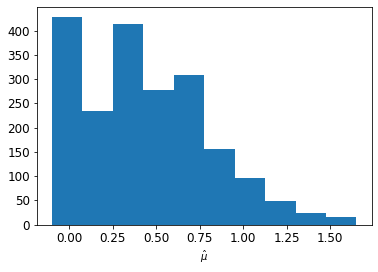

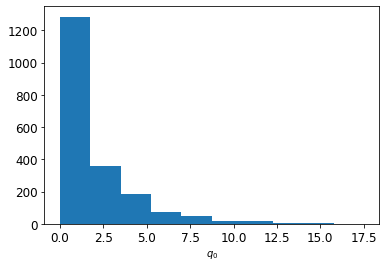

Z BL:(1.9944512283671805, 0.7791692378157958, 1.0132750000000001, 1.9950262232369533, 0.7730010812748148)
Z:0.9461781831262548
Z_std:1.3148311148953928
Z_1:1.1324832778346023
Z_std_1:2.133053421704573
5
AUC:0.9027859970058147
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

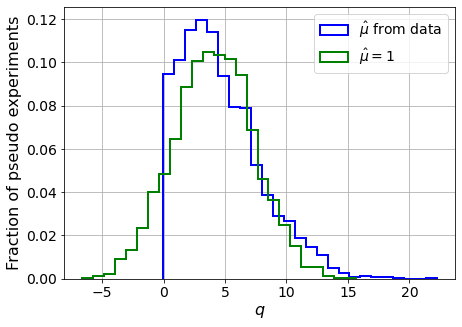

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  7155.95762511  6996.33268672  6790.57492282
  6524.54715232  6181.49335391  5758.77746654  5252.11336363
  4634.70513424  3880.4062307   2973.6188679   1902.14067489
   619.27785105  -900.50523768 -2716.60666789 -5302.30113068]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  4230.39272172  4252.57674427  4262.33743372


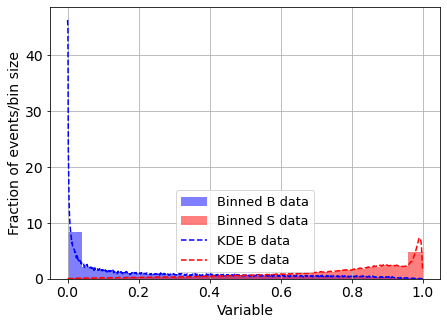

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.01905459876487247
0.01905459876487247
3 done
4 done
0.0
5.085939135674114e-05


  0%|▎                                                                 | 10/2000 [00:05<13:17,  2.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3712829757271886
<p_{s}(Sdata)> = 2.170556303442562
<p_{b}(Bdata)> = 7.689930210748433
<p_{s}(Bdata)> = 0.4174558810554109


  1%|▍                                                                 | 14/2000 [00:06<10:12,  3.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3474344139401451
<p_{s}(Sdata)> = 2.5031166714579633
<p_{b}(Bdata)> = 7.485628820353537
<p_{s}(Bdata)> = 0.42850846683668453


  3%|█▊                                                                | 54/2000 [00:26<13:22,  2.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39251507102037375
<p_{s}(Sdata)> = 1.9164501917239436
<p_{b}(Bdata)> = 7.467509822696059
<p_{s}(Bdata)> = 0.4170794787984414


  8%|█████▎                                                           | 164/2000 [01:41<14:15,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42198811910337286
<p_{s}(Sdata)> = 1.9225488670037436
<p_{b}(Bdata)> = 7.4384966546926234
<p_{s}(Bdata)> = 0.4188910732092106
muhat = -0.1
<p_{b}(Sdata)> = 0.5288928813761754
<p_{s}(Sdata)> = 1.9002515930983293
<p_{b}(Bdata)> = 7.423044798228251
<p_{s}(Bdata)> = 0.41913341662584425


 11%|███████▏                                                         | 222/2000 [02:20<18:35,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5085658750522948
<p_{s}(Sdata)> = 1.9135304253738503
<p_{b}(Bdata)> = 7.565973812401688
<p_{s}(Bdata)> = 0.4184612030002309


 16%|██████████▏                                                      | 312/2000 [03:35<16:41,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.409993654364449
<p_{s}(Sdata)> = 1.8059442057524429
<p_{b}(Bdata)> = 7.533163938708548
<p_{s}(Bdata)> = 0.4204104592274313


 16%|██████████▏                                                      | 314/2000 [03:35<13:00,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44215139773188883
<p_{s}(Sdata)> = 1.7978789048892834
<p_{b}(Bdata)> = 7.697500932873939
<p_{s}(Bdata)> = 0.420144675572426


 17%|██████████▉                                                      | 338/2000 [03:56<13:00,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4878615684569327
<p_{s}(Sdata)> = 1.619803855389728
<p_{b}(Bdata)> = 7.565229620407787
<p_{s}(Bdata)> = 0.41742945196254894
muhat = -0.1
<p_{b}(Sdata)> = 0.47144271529781506
<p_{s}(Sdata)> = 1.8172681134865694
<p_{b}(Bdata)> = 7.464489992479411
<p_{s}(Bdata)> = 0.42202208552099935


 17%|███████████▏                                                     | 346/2000 [04:02<16:12,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6433006606334712
<p_{s}(Sdata)> = 1.8103973055546496
<p_{b}(Bdata)> = 7.6964626764034865
<p_{s}(Bdata)> = 0.4110593343077521


 18%|███████████▋                                                     | 358/2000 [04:09<15:18,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5766951095840864
<p_{s}(Sdata)> = 1.7535735379909916
<p_{b}(Bdata)> = 7.62898967889014
<p_{s}(Bdata)> = 0.411741531977145


 19%|████████████                                                     | 371/2000 [04:19<15:02,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42713591928982786
<p_{s}(Sdata)> = 1.9126997880159253
<p_{b}(Bdata)> = 7.62515364075988
<p_{s}(Bdata)> = 0.41381310761610685


 19%|████████████▎                                                    | 380/2000 [04:24<14:13,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39441928234769164
<p_{s}(Sdata)> = 2.365590263391004
<p_{b}(Bdata)> = 7.43145692149353
<p_{s}(Bdata)> = 0.4163876815197562


 19%|████████████▌                                                    | 386/2000 [04:28<15:20,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4786837576642121
<p_{s}(Sdata)> = 1.9550884683747367
<p_{b}(Bdata)> = 7.573997737709508
<p_{s}(Bdata)> = 0.4177949737722176


 19%|████████████▋                                                    | 389/2000 [04:30<13:39,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4665169689962134
<p_{s}(Sdata)> = 1.732648169539954
<p_{b}(Bdata)> = 7.500886183918274
<p_{s}(Bdata)> = 0.42597178619413584


 20%|████████████▉                                                    | 397/2000 [04:34<10:36,  2.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38725790546129824
<p_{s}(Sdata)> = 2.3021519986933954
<p_{b}(Bdata)> = 7.553657780980185
<p_{s}(Bdata)> = 0.4180426958678938
muhat = -0.1
<p_{b}(Sdata)> = 0.42539088309100626
<p_{s}(Sdata)> = 1.9898821316597415
<p_{b}(Bdata)> = 7.563708467658622
<p_{s}(Bdata)> = 0.4215996785655348


 20%|█████████████                                                    | 401/2000 [04:37<15:00,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3698619190487746
<p_{s}(Sdata)> = 2.5937220943978936
<p_{b}(Bdata)> = 7.506978435369356
<p_{s}(Bdata)> = 0.41684303971488673


 20%|█████████████▏                                                   | 404/2000 [04:39<12:53,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4043644135404874
<p_{s}(Sdata)> = 1.91542574879605
<p_{b}(Bdata)> = 7.479680104498067
<p_{s}(Bdata)> = 0.41579030265975986


 21%|█████████████▋                                                   | 420/2000 [04:51<14:03,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4276479847292134
<p_{s}(Sdata)> = 1.8380586091732414
<p_{b}(Bdata)> = 7.5752777333662475
<p_{s}(Bdata)> = 0.41249089663398797


 21%|█████████████▉                                                   | 428/2000 [04:56<15:01,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43379756171046285
<p_{s}(Sdata)> = 2.0230010271037915
<p_{b}(Bdata)> = 7.508122326740572
<p_{s}(Bdata)> = 0.4182549498150962


 23%|██████████████▊                                                  | 454/2000 [05:15<15:46,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5637316018084367
<p_{s}(Sdata)> = 1.8486778665364625
<p_{b}(Bdata)> = 7.476563991947335
<p_{s}(Bdata)> = 0.42359856618416086


 23%|███████████████▏                                                 | 469/2000 [05:24<10:34,  2.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4067273767468184
<p_{s}(Sdata)> = 2.374880977982294
<p_{b}(Bdata)> = 7.4472959533129135
<p_{s}(Bdata)> = 0.4230381899638545


 25%|███████████████▉                                                 | 491/2000 [05:41<13:40,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41121082667078745
<p_{s}(Sdata)> = 1.9120474438648611
<p_{b}(Bdata)> = 7.59071793323445
<p_{s}(Bdata)> = 0.4174348728433887


 25%|████████████████▎                                                | 500/2000 [05:46<10:42,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4439551313440702
<p_{s}(Sdata)> = 1.7135270027020801
<p_{b}(Bdata)> = 7.582757509188811
<p_{s}(Bdata)> = 0.4184241618740283


 25%|████████████████▍                                                | 507/2000 [05:48<07:14,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48238546402437366
<p_{s}(Sdata)> = 1.951005562166263
<p_{b}(Bdata)> = 7.536770728837982
<p_{s}(Bdata)> = 0.42196160637045155


 26%|█████████████████▏                                               | 527/2000 [05:54<07:16,  3.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4195872069107277
<p_{s}(Sdata)> = 1.9696156245952698
<p_{b}(Bdata)> = 7.527448687314011
<p_{s}(Bdata)> = 0.4230704550288946


 28%|██████████████████▏                                              | 558/2000 [06:04<06:31,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4466916170617006
<p_{s}(Sdata)> = 1.9482098810717445
<p_{b}(Bdata)> = 7.430894933243537
<p_{s}(Bdata)> = 0.4182292000788553


 28%|██████████████████▎                                              | 563/2000 [06:05<05:37,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3854836218903295
<p_{s}(Sdata)> = 2.2864586547612658
<p_{b}(Bdata)> = 7.563419570601146
<p_{s}(Bdata)> = 0.4160793989422403
muhat = -0.1
<p_{b}(Sdata)> = 0.4982846097568154
<p_{s}(Sdata)> = 1.6276541333333723
<p_{b}(Bdata)> = 7.737604749319927
<p_{s}(Bdata)> = 0.41639306368185564


 29%|███████████████████                                              | 585/2000 [06:14<09:20,  2.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4604064477846277
<p_{s}(Sdata)> = 1.8120429093135593
<p_{b}(Bdata)> = 7.543206863740111
<p_{s}(Bdata)> = 0.4201334537919744


 31%|███████████████████▉                                             | 613/2000 [06:23<06:29,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3687411516867681
<p_{s}(Sdata)> = 2.416060791295074
<p_{b}(Bdata)> = 7.66249694683873
<p_{s}(Bdata)> = 0.4125123343814788


 31%|████████████████████▎                                            | 624/2000 [06:27<06:01,  3.81it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.547430770460023
<p_{s}(Sdata)> = 2.039903695455269
<p_{b}(Bdata)> = 7.351522916025514
<p_{s}(Bdata)> = 0.435487952120972


 32%|█████████████████████                                            | 648/2000 [06:36<10:43,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44653927892652795
<p_{s}(Sdata)> = 2.1619290980345105
<p_{b}(Bdata)> = 7.444133873679118
<p_{s}(Bdata)> = 0.41541429127876595


 34%|██████████████████████▏                                          | 682/2000 [06:47<06:30,  3.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42376644141674336
<p_{s}(Sdata)> = 2.09386179719539
<p_{b}(Bdata)> = 7.646600002825756
<p_{s}(Bdata)> = 0.41969124894870924


 34%|██████████████████████▎                                          | 687/2000 [06:49<07:24,  2.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41712830519177435
<p_{s}(Sdata)> = 1.779115816181869
<p_{b}(Bdata)> = 7.452298596369837
<p_{s}(Bdata)> = 0.41415849468578025


 36%|███████████████████████▏                                         | 713/2000 [06:57<08:42,  2.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3756411974272744
<p_{s}(Sdata)> = 2.1360917933499772
<p_{b}(Bdata)> = 7.516823604162448
<p_{s}(Bdata)> = 0.4134600260909036


 38%|████████████████████████▍                                        | 751/2000 [07:09<08:17,  2.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48115021269340896
<p_{s}(Sdata)> = 1.5394843722335725
<p_{b}(Bdata)> = 7.590396941076237
<p_{s}(Bdata)> = 0.419996665597405


 40%|██████████████████████████▏                                      | 804/2000 [07:27<06:11,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4255068394814557
<p_{s}(Sdata)> = 1.8527156144589654
<p_{b}(Bdata)> = 7.4900311521618335
<p_{s}(Bdata)> = 0.4151072727193634


 40%|██████████████████████████▎                                      | 808/2000 [07:28<05:16,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40039216798963434
<p_{s}(Sdata)> = 2.041361772456134
<p_{b}(Bdata)> = 7.352006644641606
<p_{s}(Bdata)> = 0.42557970127910266


 41%|██████████████████████████▍                                      | 813/2000 [07:30<06:46,  2.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.394424731382272
<p_{s}(Sdata)> = 2.3105838340194618
<p_{b}(Bdata)> = 7.613034918294471
<p_{s}(Bdata)> = 0.41937691252402476


 42%|███████████████████████████▏                                     | 835/2000 [07:37<06:21,  3.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.421730985399858
<p_{s}(Sdata)> = 1.834178476140217
<p_{b}(Bdata)> = 7.558250551891468
<p_{s}(Bdata)> = 0.41713574686787647


 44%|████████████████████████████▎                                    | 872/2000 [07:50<06:57,  2.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4055788554862414
<p_{s}(Sdata)> = 1.9715276352692577
<p_{b}(Bdata)> = 7.515829304587348
<p_{s}(Bdata)> = 0.4219545892227706


 44%|████████████████████████████▋                                    | 882/2000 [07:54<07:06,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44371326609191314
<p_{s}(Sdata)> = 2.1762414187403323
<p_{b}(Bdata)> = 7.4632837417770475
<p_{s}(Bdata)> = 0.41754769155094446


 45%|████████████████████████████▉                                    | 891/2000 [07:57<06:01,  3.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5097607563954303
<p_{s}(Sdata)> = 1.7329526012450172
<p_{b}(Bdata)> = 7.568587392124918
<p_{s}(Bdata)> = 0.4174469529298707


 45%|█████████████████████████████▏                                   | 897/2000 [07:59<07:33,  2.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48105687500740857
<p_{s}(Sdata)> = 1.7949001799560045
<p_{b}(Bdata)> = 7.468796510320998
<p_{s}(Bdata)> = 0.41892771278758884


 49%|███████████████████████████████▊                                 | 980/2000 [08:27<04:17,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41523590368217983
<p_{s}(Sdata)> = 2.2045244831949335
<p_{b}(Bdata)> = 7.352370021482842
<p_{s}(Bdata)> = 0.41874096282814505


 49%|███████████████████████████████▉                                 | 984/2000 [08:29<04:46,  3.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4501955202921041
<p_{s}(Sdata)> = 1.9771748306646353
<p_{b}(Bdata)> = 7.630918608322129
<p_{s}(Bdata)> = 0.41596273085910934


 51%|████████████████████████████████▊                               | 1025/2000 [08:43<06:24,  2.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8489065785884025
<p_{s}(Sdata)> = 2.13557312082749
<p_{b}(Bdata)> = 7.491744745409977
<p_{s}(Bdata)> = 0.42079926477526636


 54%|██████████████████████████████████▋                             | 1084/2000 [09:04<05:48,  2.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3805929176220547
<p_{s}(Sdata)> = 2.248675230204292
<p_{b}(Bdata)> = 7.564839871116758
<p_{s}(Bdata)> = 0.41607695822742247


 56%|███████████████████████████████████▌                            | 1113/2000 [09:12<04:42,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5452658709462107
<p_{s}(Sdata)> = 2.2204375668192817
<p_{b}(Bdata)> = 7.5321805687908014
<p_{s}(Bdata)> = 0.41724201055120325


 56%|████████████████████████████████████▏                           | 1130/2000 [09:18<05:25,  2.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4065439135307475
<p_{s}(Sdata)> = 2.1185415090306843
<p_{b}(Bdata)> = 7.606201655175618
<p_{s}(Bdata)> = 0.4183570811392619


 57%|████████████████████████████████████▋                           | 1145/2000 [09:23<06:07,  2.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4293088078681922
<p_{s}(Sdata)> = 1.9502080995869888
<p_{b}(Bdata)> = 7.576416652325441
<p_{s}(Bdata)> = 0.4187303246413729


 57%|████████████████████████████████████▊                           | 1150/2000 [09:25<05:07,  2.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3796067168179831
<p_{s}(Sdata)> = 2.308615915363075
<p_{b}(Bdata)> = 7.498744851616797
<p_{s}(Bdata)> = 0.41538057448693083


 59%|█████████████████████████████████████▋                          | 1178/2000 [09:35<05:22,  2.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4224842023369975
<p_{s}(Sdata)> = 2.1134726610901695
<p_{b}(Bdata)> = 7.464546038388184
<p_{s}(Bdata)> = 0.41709526751986803


 62%|███████████████████████████████████████▍                        | 1234/2000 [09:56<04:13,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4457659528208442
<p_{s}(Sdata)> = 1.8500726175343734
<p_{b}(Bdata)> = 7.593954413547604
<p_{s}(Bdata)> = 0.41975866902542575


 62%|███████████████████████████████████████▌                        | 1238/2000 [09:57<04:39,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39794864904398
<p_{s}(Sdata)> = 1.9925114494836196
<p_{b}(Bdata)> = 7.518578180489754
<p_{s}(Bdata)> = 0.4190806848082787


 62%|███████████████████████████████████████▋                        | 1242/2000 [09:58<04:24,  2.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4225223916457215
<p_{s}(Sdata)> = 1.9252017782843307
<p_{b}(Bdata)> = 7.522068906335345
<p_{s}(Bdata)> = 0.41560230375267093


 64%|████████████████████████████████████████▊                       | 1274/2000 [10:09<02:43,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4807394121390048
<p_{s}(Sdata)> = 1.7222307715989782
<p_{b}(Bdata)> = 7.501137266687113
<p_{s}(Bdata)> = 0.4199085562145


 64%|█████████████████████████████████████████                       | 1282/2000 [10:12<04:24,  2.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3939143513084798
<p_{s}(Sdata)> = 2.08575672401015
<p_{b}(Bdata)> = 7.645835456836576
<p_{s}(Bdata)> = 0.4128751174173292


 66%|██████████████████████████████████████████                      | 1315/2000 [10:24<03:34,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42557873119062195
<p_{s}(Sdata)> = 2.2729335176566132
<p_{b}(Bdata)> = 7.588985616808758
<p_{s}(Bdata)> = 0.4135890272764473


 66%|██████████████████████████████████████████▏                     | 1317/2000 [10:24<02:46,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5394105568265191
<p_{s}(Sdata)> = 1.9520832596098445
<p_{b}(Bdata)> = 7.548600393948271
<p_{s}(Bdata)> = 0.4158067910986366


 68%|███████████████████████████████████████████▎                    | 1354/2000 [10:36<02:47,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.519593417770115
<p_{s}(Sdata)> = 1.710447933037438
<p_{b}(Bdata)> = 7.444308307532786
<p_{s}(Bdata)> = 0.423803830917716


 68%|███████████████████████████████████████████▋                    | 1365/2000 [10:39<02:30,  4.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4141902993975641
<p_{s}(Sdata)> = 1.8065916162229052
<p_{b}(Bdata)> = 7.562561133151652
<p_{s}(Bdata)> = 0.420526779827646
muhat = -0.1
<p_{b}(Sdata)> = 0.5578016914533692
<p_{s}(Sdata)> = 1.644419775460807
<p_{b}(Bdata)> = 7.681527698849749
<p_{s}(Bdata)> = 0.4159157891031448


 70%|████████████████████████████████████████████▋                   | 1395/2000 [10:49<02:49,  3.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39358630046519755
<p_{s}(Sdata)> = 2.050116021301789
<p_{b}(Bdata)> = 7.531053990998727
<p_{s}(Bdata)> = 0.4161659290407445


 71%|█████████████████████████████████████████████▍                  | 1418/2000 [10:57<03:49,  2.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4372974328247888
<p_{s}(Sdata)> = 1.832246487397739
<p_{b}(Bdata)> = 7.540999141164688
<p_{s}(Bdata)> = 0.4135019880205172


 71%|█████████████████████████████████████████████▌                  | 1423/2000 [10:59<03:21,  2.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4227400542311888
<p_{s}(Sdata)> = 1.886815441034473
<p_{b}(Bdata)> = 7.500466474941024
<p_{s}(Bdata)> = 0.4193303813458415


 71%|█████████████████████████████████████████████▋                  | 1429/2000 [11:01<03:05,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45176352405956444
<p_{s}(Sdata)> = 2.205933859126562
<p_{b}(Bdata)> = 7.632835034798835
<p_{s}(Bdata)> = 0.4155022608072629


 73%|██████████████████████████████████████████████▊                 | 1464/2000 [11:13<03:26,  2.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3655928428455103
<p_{s}(Sdata)> = 1.9886785157076152
<p_{b}(Bdata)> = 7.593473857899977
<p_{s}(Bdata)> = 0.41901467293180894


 75%|███████████████████████████████████████████████▊                | 1496/2000 [11:23<02:06,  3.98it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4573171360667834
<p_{s}(Sdata)> = 2.4798874266778093
<p_{b}(Bdata)> = 7.462902106697241
<p_{s}(Bdata)> = 0.42830361826863544


 75%|███████████████████████████████████████████████▉                | 1499/2000 [11:24<02:58,  2.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4654756327003052
<p_{s}(Sdata)> = 1.9104991235021564
<p_{b}(Bdata)> = 7.560829999397048
<p_{s}(Bdata)> = 0.41432237347563017


 79%|██████████████████████████████████████████████████▍             | 1576/2000 [11:51<02:15,  3.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4343775684205912
<p_{s}(Sdata)> = 1.9542965667751306
<p_{b}(Bdata)> = 7.428422838070905
<p_{s}(Bdata)> = 0.4164040981950692


 79%|██████████████████████████████████████████████████▍             | 1578/2000 [11:51<01:42,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39123742170868103
<p_{s}(Sdata)> = 2.0010292831581453
<p_{b}(Bdata)> = 7.384275983699325
<p_{s}(Bdata)> = 0.4264474725078421


 79%|██████████████████████████████████████████████████▊             | 1586/2000 [11:54<02:28,  2.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7631452427726262
<p_{s}(Sdata)> = 2.2230646194821517
<p_{b}(Bdata)> = 7.415277694190386
<p_{s}(Bdata)> = 0.4198954444884421


 79%|██████████████████████████████████████████████████▊             | 1588/2000 [11:55<02:07,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39957238670452705
<p_{s}(Sdata)> = 2.0299756492708565
<p_{b}(Bdata)> = 7.522343161129205
<p_{s}(Bdata)> = 0.4145187963811676


 80%|███████████████████████████████████████████████████             | 1596/2000 [11:57<02:06,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4768261633620486
<p_{s}(Sdata)> = 1.8238022464491346
<p_{b}(Bdata)> = 7.490701474460414
<p_{s}(Bdata)> = 0.4183226668576833


 80%|███████████████████████████████████████████████████▏            | 1601/2000 [11:58<01:13,  5.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42647740654199706
<p_{s}(Sdata)> = 1.9174041489377596
<p_{b}(Bdata)> = 7.379342252428925
<p_{s}(Bdata)> = 0.42400053902617557
muhat = -0.1
<p_{b}(Sdata)> = 0.36298292775493063
<p_{s}(Sdata)> = 2.3027000128245363
<p_{b}(Bdata)> = 7.662682906783613
<p_{s}(Bdata)> = 0.41711561470934766


 81%|███████████████████████████████████████████████████▌            | 1612/2000 [12:01<01:13,  5.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4158388357169979
<p_{s}(Sdata)> = 1.9708170783434515
<p_{b}(Bdata)> = 7.5547266812355955
<p_{s}(Bdata)> = 0.41703901629273776
muhat = -0.1
<p_{b}(Sdata)> = 0.41662785487153414
<p_{s}(Sdata)> = 2.2873923394772113
<p_{b}(Bdata)> = 7.6390266777242655
<p_{s}(Bdata)> = 0.41594448554637103


 81%|███████████████████████████████████████████████████▉            | 1623/2000 [12:05<02:04,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45647869751340026
<p_{s}(Sdata)> = 1.8169511420157796
<p_{b}(Bdata)> = 7.612743532406027
<p_{s}(Bdata)> = 0.4167630768671624


 82%|████████████████████████████████████████████████████▋           | 1646/2000 [12:13<02:09,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4722749208598662
<p_{s}(Sdata)> = 1.7267829884786714
<p_{b}(Bdata)> = 7.686356228405895
<p_{s}(Bdata)> = 0.41252226903017725


 83%|████████████████████████████████████████████████████▉           | 1656/2000 [12:16<01:56,  2.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4368585036459909
<p_{s}(Sdata)> = 2.005012396478708
<p_{b}(Bdata)> = 7.452995605152792
<p_{s}(Bdata)> = 0.4242553510984727


 85%|██████████████████████████████████████████████████████▏         | 1692/2000 [12:28<02:17,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4526420835742077
<p_{s}(Sdata)> = 1.999431772233689
<p_{b}(Bdata)> = 7.623309534098623
<p_{s}(Bdata)> = 0.4136177316847958


 85%|██████████████████████████████████████████████████████▌         | 1706/2000 [12:33<01:27,  3.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4701033652097593
<p_{s}(Sdata)> = 2.024309963270731
<p_{b}(Bdata)> = 7.564711079768062
<p_{s}(Bdata)> = 0.4201800993045981


 86%|██████████████████████████████████████████████████████▋         | 1710/2000 [12:34<01:13,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4131874000478387
<p_{s}(Sdata)> = 2.0791985610135937
<p_{b}(Bdata)> = 7.612752178377307
<p_{s}(Bdata)> = 0.42174320967820705


 86%|███████████████████████████████████████████████████████         | 1721/2000 [12:38<01:37,  2.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45723494341390736
<p_{s}(Sdata)> = 2.2808116041917486
<p_{b}(Bdata)> = 7.527763516551424
<p_{s}(Bdata)> = 0.42047359554304614


 87%|███████████████████████████████████████████████████████▊        | 1743/2000 [12:45<01:41,  2.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3450165196135113
<p_{s}(Sdata)> = 2.3188858899926355
<p_{b}(Bdata)> = 7.539179460308586
<p_{s}(Bdata)> = 0.41871814182682365


 87%|███████████████████████████████████████████████████████▊        | 1746/2000 [12:46<01:11,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45485937606228466
<p_{s}(Sdata)> = 1.9173231717349721
<p_{b}(Bdata)> = 7.5710026048795624
<p_{s}(Bdata)> = 0.4163960586070574


 88%|████████████████████████████████████████████████████████▎       | 1760/2000 [12:50<01:11,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39411516258868967
<p_{s}(Sdata)> = 1.971474570467092
<p_{b}(Bdata)> = 7.7265753872125105
<p_{s}(Bdata)> = 0.4170932679895963


 88%|████████████████████████████████████████████████████████▌       | 1768/2000 [12:52<01:13,  3.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4828329496248892
<p_{s}(Sdata)> = 1.8988542277818012
<p_{b}(Bdata)> = 7.5012091669656344
<p_{s}(Bdata)> = 0.41470585753847683


 88%|████████████████████████████████████████████████████████▋       | 1770/2000 [12:53<00:55,  4.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45621065759509444
<p_{s}(Sdata)> = 1.7403573323708257
<p_{b}(Bdata)> = 7.493350522089781
<p_{s}(Bdata)> = 0.417082005395986


 89%|████████████████████████████████████████████████████████▊       | 1775/2000 [12:54<01:08,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41858545787152
<p_{s}(Sdata)> = 1.9365937495922594
<p_{b}(Bdata)> = 7.513421313030529
<p_{s}(Bdata)> = 0.41414583950975054


 89%|█████████████████████████████████████████████████████████▏      | 1786/2000 [12:58<01:10,  3.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4313720398362109
<p_{s}(Sdata)> = 1.8361492058407487
<p_{b}(Bdata)> = 7.663720915597858
<p_{s}(Bdata)> = 0.4199479979658424


 90%|█████████████████████████████████████████████████████████▍      | 1796/2000 [13:01<01:06,  3.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42325173838040464
<p_{s}(Sdata)> = 1.8460617630938765
<p_{b}(Bdata)> = 7.514280037632997
<p_{s}(Bdata)> = 0.42050875329218096


 90%|█████████████████████████████████████████████████████████▌      | 1799/2000 [13:02<01:00,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4387060661411009
<p_{s}(Sdata)> = 1.9501486752800288
<p_{b}(Bdata)> = 7.639921193623623
<p_{s}(Bdata)> = 0.41599225144322477


 90%|█████████████████████████████████████████████████████████▋      | 1803/2000 [13:03<01:03,  3.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4085954508879976
<p_{s}(Sdata)> = 2.188997448862406
<p_{b}(Bdata)> = 7.564150462183634
<p_{s}(Bdata)> = 0.4161349927539538


 92%|███████████████████████████████████████████████████████████▏    | 1848/2000 [13:17<00:37,  4.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3667502524281528
<p_{s}(Sdata)> = 2.3727782071949535
<p_{b}(Bdata)> = 7.521995090141346
<p_{s}(Bdata)> = 0.4167090735480289


 93%|███████████████████████████████████████████████████████████▏    | 1851/2000 [13:19<00:51,  2.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36355419217740054
<p_{s}(Sdata)> = 2.01772200874885
<p_{b}(Bdata)> = 7.340005255114392
<p_{s}(Bdata)> = 0.42004387772643276


 93%|███████████████████████████████████████████████████████████▎    | 1854/2000 [13:20<00:51,  2.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42752344449600016
<p_{s}(Sdata)> = 2.1428775053391247
<p_{b}(Bdata)> = 7.446996963364015
<p_{s}(Bdata)> = 0.42166788688778434


 93%|███████████████████████████████████████████████████████████▌    | 1862/2000 [13:22<00:36,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4092340499772578
<p_{s}(Sdata)> = 2.1447496778404775
<p_{b}(Bdata)> = 7.616093627936913
<p_{s}(Bdata)> = 0.41611658026557224
muhat = -0.1
<p_{b}(Sdata)> = 0.8063889336606064
<p_{s}(Sdata)> = 1.7291097289702764
<p_{b}(Bdata)> = 7.498638816745359
<p_{s}(Bdata)> = 0.4160848092609631


 93%|███████████████████████████████████████████████████████████▊    | 1869/2000 [13:24<00:42,  3.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4149064887288909
<p_{s}(Sdata)> = 2.198656789995794
<p_{b}(Bdata)> = 7.582353830235745
<p_{s}(Bdata)> = 0.4205596271285272


 94%|███████████████████████████████████████████████████████████▉    | 1872/2000 [13:25<00:40,  3.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46337244344620554
<p_{s}(Sdata)> = 1.8723419202310356
<p_{b}(Bdata)> = 7.491122799523233
<p_{s}(Bdata)> = 0.4210784051346831


 95%|████████████████████████████████████████████████████████████▌   | 1892/2000 [13:32<00:39,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4096068635756078
<p_{s}(Sdata)> = 2.1428877160712223
<p_{b}(Bdata)> = 7.585304573813391
<p_{s}(Bdata)> = 0.4158036835936795


 96%|█████████████████████████████████████████████████████████████▌  | 1922/2000 [13:43<00:27,  2.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44277098370321766
<p_{s}(Sdata)> = 1.7909058028054874
<p_{b}(Bdata)> = 7.5282341172473295
<p_{s}(Bdata)> = 0.42415593609018815


 96%|█████████████████████████████████████████████████████████████▌  | 1925/2000 [13:44<00:24,  3.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39981985914052903
<p_{s}(Sdata)> = 1.8384337002734583
<p_{b}(Bdata)> = 7.493807842685498
<p_{s}(Bdata)> = 0.4283158073547028


 96%|█████████████████████████████████████████████████████████████▋  | 1929/2000 [13:45<00:17,  4.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42440774645198903
<p_{s}(Sdata)> = 1.879162962881167
<p_{b}(Bdata)> = 7.331578025568529
<p_{s}(Bdata)> = 0.4209256634503406
muhat = -0.1
<p_{b}(Sdata)> = 0.4246831479505465
<p_{s}(Sdata)> = 2.0351501564359253
<p_{b}(Bdata)> = 7.457020307592254
<p_{s}(Bdata)> = 0.42135414522796144


 97%|██████████████████████████████████████████████████████████████▎ | 1949/2000 [13:53<00:24,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38806272171275213
<p_{s}(Sdata)> = 2.0087511832272282
<p_{b}(Bdata)> = 7.612164220824702
<p_{s}(Bdata)> = 0.41883031310437546


 99%|███████████████████████████████████████████████████████████████ | 1971/2000 [14:00<00:08,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46294594586127247
<p_{s}(Sdata)> = 1.6522194729055326
<p_{b}(Bdata)> = 7.456522168748384
<p_{s}(Bdata)> = 0.42345494664315403


 99%|███████████████████████████████████████████████████████████████▎| 1979/2000 [14:02<00:03,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5937139532106583
<p_{s}(Sdata)> = 1.9853721536822797
<p_{b}(Bdata)> = 7.557882601868066
<p_{s}(Bdata)> = 0.4193294304431879
muhat = -0.1
<p_{b}(Sdata)> = 0.4723542094479253
<p_{s}(Sdata)> = 1.9026968900480121
<p_{b}(Bdata)> = 7.491903376527538
<p_{s}(Bdata)> = 0.4161868629449207


 99%|███████████████████████████████████████████████████████████████▌| 1986/2000 [14:04<00:03,  4.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.411525893511536
<p_{s}(Sdata)> = 2.0535144463482453
<p_{b}(Bdata)> = 7.487028754376065
<p_{s}(Bdata)> = 0.4225570562341574


 99%|███████████████████████████████████████████████████████████████▋| 1989/2000 [14:04<00:02,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4571348782973411
<p_{s}(Sdata)> = 1.6111309702311782
<p_{b}(Bdata)> = 7.711689462355083
<p_{s}(Bdata)> = 0.4127696141602851


100%|████████████████████████████████████████████████████████████████| 2000/2000 [14:08<00:00,  2.36it/s]


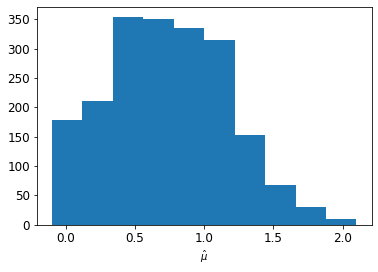

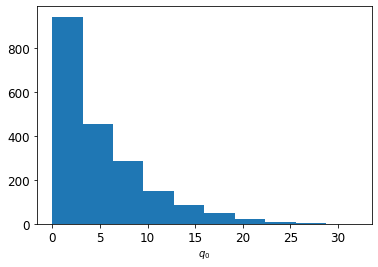

Z BL:(2.0282743828414445, 0.8061107969771784, 1.009375, 2.0282743828414445, 0.8041789325410371)
Z:1.8645388918932022
Z_std:1.312936559424527
Z_1:1.7267871726687944
Z_std_1:1.7384295588805598
6
AUC:0.9024383175425863
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

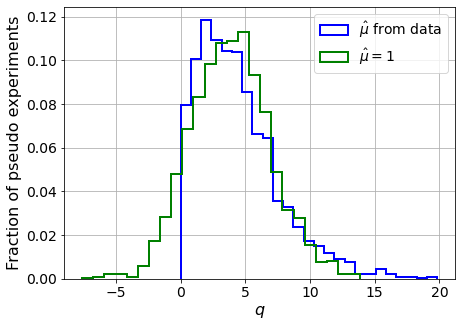

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  7118.0219211   6964.92287575  6759.07829192
  6496.88204153  6161.20172793  5757.59300752  5255.08432341
  4640.87235953  3891.74851418  2982.33497954  1900.74593426
   617.88576201  -910.33736391 -2730.38052301 -5309.99355396]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
IOStream.flush timed out
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
  4305.63124061  4349.27646391  4376

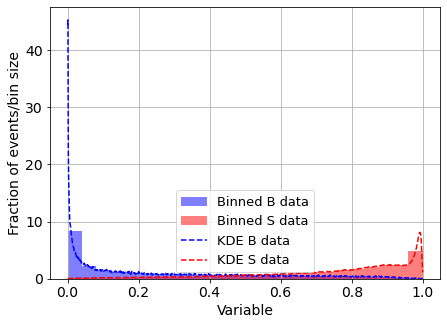

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.01871919281839341
0.01871919281839341
3 done
4 done
0.0
3.94973799618578e-05


  4%|██▎                                                               | 70/2000 [00:27<10:20,  3.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4273178334148242
<p_{s}(Sdata)> = 2.0825030858045546
<p_{b}(Bdata)> = 7.337872415262783
<p_{s}(Bdata)> = 0.4186509818490212


  4%|██▊                                                               | 87/2000 [00:33<09:42,  3.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45966324732145175
<p_{s}(Sdata)> = 2.279059381961563
<p_{b}(Bdata)> = 7.4372301350140155
<p_{s}(Bdata)> = 0.41290389898710916


  5%|███▎                                                              | 99/2000 [00:36<08:47,  3.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.45566895433546295
<p_{s}(Sdata)> = 2.4438017935466245
<p_{b}(Bdata)> = 7.338700413562907
<p_{s}(Bdata)> = 0.42868472467280394


  5%|███▍                                                             | 105/2000 [00:38<12:39,  2.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4794691128835703
<p_{s}(Sdata)> = 1.8776593928425365
<p_{b}(Bdata)> = 7.301807809118255
<p_{s}(Bdata)> = 0.4174654901429585


  8%|█████                                                            | 157/2000 [00:59<12:38,  2.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4735217212142521
<p_{s}(Sdata)> = 1.774519815689459
<p_{b}(Bdata)> = 7.157864142589099
<p_{s}(Bdata)> = 0.4187505116183173


 13%|████████▏                                                        | 252/2000 [01:35<12:55,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5487050552345538
<p_{s}(Sdata)> = 1.9903416398806546
<p_{b}(Bdata)> = 7.378331513187881
<p_{s}(Bdata)> = 0.4175505099150306


 14%|████████▉                                                        | 274/2000 [01:43<08:31,  3.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.363513345375681
<p_{s}(Sdata)> = 2.5108084109437954
<p_{b}(Bdata)> = 7.29742118595592
<p_{s}(Bdata)> = 0.42968906797696715


 14%|████████▉                                                        | 276/2000 [01:43<07:21,  3.90it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.39120440109847116
<p_{s}(Sdata)> = 2.4326453829863928
<p_{b}(Bdata)> = 7.269457496932524
<p_{s}(Bdata)> = 0.43195522341784753


 14%|█████████▏                                                       | 283/2000 [01:46<10:07,  2.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4782025010674949
<p_{s}(Sdata)> = 1.9116424646312233
<p_{b}(Bdata)> = 7.391827570134256
<p_{s}(Bdata)> = 0.41803458384270703


 14%|█████████▍                                                       | 289/2000 [01:48<09:57,  2.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41754790175473483
<p_{s}(Sdata)> = 2.075174901701516
<p_{b}(Bdata)> = 7.3240656576665755
<p_{s}(Bdata)> = 0.4148437190225104


 15%|██████████                                                       | 309/2000 [01:55<11:45,  2.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4774239843328973
<p_{s}(Sdata)> = 2.2362202058596927
<p_{b}(Bdata)> = 7.3622792750476425
<p_{s}(Bdata)> = 0.42127727895129047


 16%|██████████▏                                                      | 313/2000 [01:56<09:48,  2.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3446216332955172
<p_{s}(Sdata)> = 2.4039376832724213
<p_{b}(Bdata)> = 7.35085549380505
<p_{s}(Bdata)> = 0.41845202123412656


 16%|██████████▍                                                      | 321/2000 [01:58<09:07,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.368753789616444
<p_{s}(Sdata)> = 2.235677174778671
<p_{b}(Bdata)> = 7.270448229338986
<p_{s}(Bdata)> = 0.41118117088084505


 18%|███████████▌                                                     | 354/2000 [02:11<11:46,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43845857694929347
<p_{s}(Sdata)> = 2.0866144804320954
<p_{b}(Bdata)> = 7.173148740350023
<p_{s}(Bdata)> = 0.4169846583654677


 18%|███████████▊                                                     | 363/2000 [02:14<11:07,  2.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4433527213862312
<p_{s}(Sdata)> = 2.082360440439492
<p_{b}(Bdata)> = 7.32588105925033
<p_{s}(Bdata)> = 0.4185160371255747


 20%|████████████▊                                                    | 395/2000 [02:27<11:28,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41763795870688863
<p_{s}(Sdata)> = 2.1699021351250876
<p_{b}(Bdata)> = 7.335125144063195
<p_{s}(Bdata)> = 0.4171452848527786


 21%|█████████████▌                                                   | 419/2000 [02:36<09:23,  2.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5394124531349589
<p_{s}(Sdata)> = 1.7946318768840073
<p_{b}(Bdata)> = 7.264059389101703
<p_{s}(Bdata)> = 0.4201947133481936


 22%|██████████████▎                                                  | 440/2000 [02:44<10:45,  2.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5167724680655196
<p_{s}(Sdata)> = 2.1726607539967553
<p_{b}(Bdata)> = 7.377959766139589
<p_{s}(Bdata)> = 0.42078460692541186


 24%|███████████████▊                                                 | 486/2000 [03:02<11:23,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4424554351021655
<p_{s}(Sdata)> = 2.1100876575955247
<p_{b}(Bdata)> = 7.292227820729585
<p_{s}(Bdata)> = 0.4155776147430629


 25%|███████████████▉                                                 | 492/2000 [03:04<09:09,  2.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44036008065163185
<p_{s}(Sdata)> = 2.040008533829307
<p_{b}(Bdata)> = 7.435806788902431
<p_{s}(Bdata)> = 0.41954147693340305


 25%|████████████████▍                                                | 507/2000 [03:09<09:52,  2.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3825861919075858
<p_{s}(Sdata)> = 2.3003662670487444
<p_{b}(Bdata)> = 7.335881234878614
<p_{s}(Bdata)> = 0.41720972671099815


 26%|█████████████████                                                | 526/2000 [03:17<06:26,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44683437914374374
<p_{s}(Sdata)> = 2.139304603493131
<p_{b}(Bdata)> = 7.534007428078861
<p_{s}(Bdata)> = 0.41645706337107546


 27%|█████████████████▎                                               | 531/2000 [03:18<08:27,  2.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45581632500494096
<p_{s}(Sdata)> = 2.041211777205869
<p_{b}(Bdata)> = 7.403440147271145
<p_{s}(Bdata)> = 0.4072299460449098


 27%|█████████████████▌                                               | 540/2000 [03:21<07:31,  3.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46181675987882287
<p_{s}(Sdata)> = 1.860690613190023
<p_{b}(Bdata)> = 7.311347746762411
<p_{s}(Bdata)> = 0.4186202648069325


 28%|██████████████████▎                                              | 563/2000 [03:30<07:33,  3.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3626464139553597
<p_{s}(Sdata)> = 2.6256787172300404
<p_{b}(Bdata)> = 7.294572334334962
<p_{s}(Bdata)> = 0.4338435381716501


 29%|██████████████████▊                                              | 579/2000 [03:36<09:12,  2.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4235935956802002
<p_{s}(Sdata)> = 1.9843729005497444
<p_{b}(Bdata)> = 7.467074153449773
<p_{s}(Bdata)> = 0.4199245978425979


 29%|██████████████████▉                                              | 581/2000 [03:36<06:49,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4550255281560222
<p_{s}(Sdata)> = 1.819119089028928
<p_{b}(Bdata)> = 7.201494646896444
<p_{s}(Bdata)> = 0.41611459051179683


 30%|███████████████████▎                                             | 595/2000 [03:41<06:53,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4231722454825597
<p_{s}(Sdata)> = 2.101339755973332
<p_{b}(Bdata)> = 7.500302414471633
<p_{s}(Bdata)> = 0.4176270110277972


 31%|████████████████████                                             | 616/2000 [03:49<08:43,  2.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3956101277748516
<p_{s}(Sdata)> = 2.2204732806038017
<p_{b}(Bdata)> = 7.403989556755039
<p_{s}(Bdata)> = 0.4165404506767965


 31%|████████████████████▍                                            | 628/2000 [03:53<06:54,  3.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43057327313548716
<p_{s}(Sdata)> = 1.8153083555649376
<p_{b}(Bdata)> = 7.350803189074823
<p_{s}(Bdata)> = 0.41685436557150635


 33%|█████████████████████▏                                           | 651/2000 [04:01<08:04,  2.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4617337690585122
<p_{s}(Sdata)> = 2.083032102810409
<p_{b}(Bdata)> = 7.307652115974551
<p_{s}(Bdata)> = 0.4151560967743867


 33%|█████████████████████▍                                           | 661/2000 [04:04<07:20,  3.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4010743046307099
<p_{s}(Sdata)> = 2.0367992002030912
<p_{b}(Bdata)> = 7.354304588019285
<p_{s}(Bdata)> = 0.415531853299698


 34%|█████████████████████▉                                           | 675/2000 [04:09<08:22,  2.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43401120869064214
<p_{s}(Sdata)> = 2.07098334942426
<p_{b}(Bdata)> = 7.335465325716874
<p_{s}(Bdata)> = 0.4145445205422346


 35%|███████████████████████                                          | 709/2000 [04:22<06:36,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5510524820470399
<p_{s}(Sdata)> = 1.8807419128142855
<p_{b}(Bdata)> = 7.183000050981567
<p_{s}(Bdata)> = 0.4176914398524716


 36%|███████████████████████                                          | 711/2000 [04:23<06:34,  3.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4585069422176797
<p_{s}(Sdata)> = 1.986389729562963
<p_{b}(Bdata)> = 7.311126836866887
<p_{s}(Bdata)> = 0.41924803141428707


 36%|███████████████████████▎                                         | 716/2000 [04:24<07:52,  2.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4215810780017621
<p_{s}(Sdata)> = 1.9322012510886406
<p_{b}(Bdata)> = 7.418744868851841
<p_{s}(Bdata)> = 0.42445551055407543


 40%|█████████████████████████▊                                       | 795/2000 [04:53<07:49,  2.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40576740019811447
<p_{s}(Sdata)> = 2.084135123022316
<p_{b}(Bdata)> = 7.356554475544785
<p_{s}(Bdata)> = 0.4188312814986944


 43%|████████████████████████████▏                                    | 866/2000 [05:20<07:06,  2.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41375307947190554
<p_{s}(Sdata)> = 1.9812376118937272
<p_{b}(Bdata)> = 7.403593682081606
<p_{s}(Bdata)> = 0.42099040372811636


 48%|██████████████████████████████▉                                  | 950/2000 [05:53<06:09,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5039044787973791
<p_{s}(Sdata)> = 1.7451513262886906
<p_{b}(Bdata)> = 7.448346869779832
<p_{s}(Bdata)> = 0.4195670250017574


 48%|███████████████████████████████                                  | 957/2000 [05:55<06:19,  2.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47766718756519766
<p_{s}(Sdata)> = 1.7952838107033844
<p_{b}(Bdata)> = 7.385132045867138
<p_{s}(Bdata)> = 0.4190442238348858


 49%|███████████████████████████████▌                                 | 973/2000 [06:01<04:55,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3956947525641395
<p_{s}(Sdata)> = 2.1111174530366568
<p_{b}(Bdata)> = 7.33870560882501
<p_{s}(Bdata)> = 0.415576090568946


 49%|███████████████████████████████▊                                 | 978/2000 [06:02<05:44,  2.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3736517479668834
<p_{s}(Sdata)> = 2.2550052415956916
<p_{b}(Bdata)> = 7.448723035172873
<p_{s}(Bdata)> = 0.4162793950127143


 50%|████████████████████████████████▏                                | 990/2000 [06:05<03:32,  4.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45921738677022833
<p_{s}(Sdata)> = 1.8813636969191667
<p_{b}(Bdata)> = 7.5238351813408215
<p_{s}(Bdata)> = 0.4151136027801814


 50%|████████████████████████████████▏                                | 991/2000 [06:06<03:31,  4.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4284220221900618
<p_{s}(Sdata)> = 1.9494481441924103
<p_{b}(Bdata)> = 7.36931966963568
<p_{s}(Bdata)> = 0.42408023506619513


 51%|████████████████████████████████▋                               | 1021/2000 [06:18<07:35,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43505238105188815
<p_{s}(Sdata)> = 1.908771590815672
<p_{b}(Bdata)> = 7.21830291031888
<p_{s}(Bdata)> = 0.4234036364712754


 52%|████████████████████████████████▉                               | 1031/2000 [06:21<04:33,  3.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44880345536928085
<p_{s}(Sdata)> = 1.7730983629816996
<p_{b}(Bdata)> = 7.399899465173804
<p_{s}(Bdata)> = 0.41919267858448284


 52%|█████████████████████████████████▌                              | 1049/2000 [06:27<05:38,  2.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5074540637034143
<p_{s}(Sdata)> = 1.931132707953207
<p_{b}(Bdata)> = 7.482121663382475
<p_{s}(Bdata)> = 0.41891524971270877


 55%|███████████████████████████████████▎                            | 1105/2000 [06:47<05:48,  2.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4187504485164277
<p_{s}(Sdata)> = 2.0316778173618215
<p_{b}(Bdata)> = 7.241648707049694
<p_{s}(Bdata)> = 0.4229869288090501


 55%|███████████████████████████████████▍                            | 1109/2000 [06:48<03:33,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41727053103935097
<p_{s}(Sdata)> = 2.1337964035254866
<p_{b}(Bdata)> = 7.450865026007658
<p_{s}(Bdata)> = 0.4167264812978853


 56%|███████████████████████████████████▌                            | 1113/2000 [06:49<04:24,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4895868545087463
<p_{s}(Sdata)> = 1.9563822389184125
<p_{b}(Bdata)> = 7.237703325582096
<p_{s}(Bdata)> = 0.4192349132222953


 57%|████████████████████████████████████▊                           | 1149/2000 [07:01<02:33,  5.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38156325543271713
<p_{s}(Sdata)> = 2.26075711815145
<p_{b}(Bdata)> = 7.38573198279643
<p_{s}(Bdata)> = 0.41775174306846324
muhat = -0.1
<p_{b}(Sdata)> = 0.4498503154347051
<p_{s}(Sdata)> = 2.066304470706207
<p_{b}(Bdata)> = 7.355622486335872
<p_{s}(Bdata)> = 0.42119161354969575


 60%|██████████████████████████████████████▌                         | 1205/2000 [07:22<05:11,  2.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4411685146046077
<p_{s}(Sdata)> = 1.8899329582174218
<p_{b}(Bdata)> = 7.41061977553717
<p_{s}(Bdata)> = 0.4137716586161358


 61%|██████████████████████████████████████▊                         | 1211/2000 [07:25<05:50,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3918228798518567
<p_{s}(Sdata)> = 2.1484256977140928
<p_{b}(Bdata)> = 7.342698408684479
<p_{s}(Bdata)> = 0.4145662300128173


 62%|███████████████████████████████████████▋                        | 1240/2000 [07:36<04:10,  3.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.582615339291528
<p_{s}(Sdata)> = 2.0755779060533586
<p_{b}(Bdata)> = 7.361285724060216
<p_{s}(Bdata)> = 0.42053151906396913


 63%|████████████████████████████████████████▍                       | 1265/2000 [07:44<03:01,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5153941018078515
<p_{s}(Sdata)> = 1.8739497894584762
<p_{b}(Bdata)> = 7.363401241593116
<p_{s}(Bdata)> = 0.4194770276370188


 68%|███████████████████████████████████████████▊                    | 1368/2000 [08:24<03:30,  3.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41642936596781577
<p_{s}(Sdata)> = 1.9253899325044495
<p_{b}(Bdata)> = 7.382548922581001
<p_{s}(Bdata)> = 0.42271203812241803


 68%|███████████████████████████████████████████▊                    | 1370/2000 [08:24<02:59,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3711264468142434
<p_{s}(Sdata)> = 2.261461988451753
<p_{b}(Bdata)> = 7.457365592074379
<p_{s}(Bdata)> = 0.41502266226908563


 69%|███████████████████████████████████████████▉                    | 1373/2000 [08:25<02:57,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4724363958809903
<p_{s}(Sdata)> = 2.205795685830659
<p_{b}(Bdata)> = 7.4341489378695655
<p_{s}(Bdata)> = 0.41643156348736377


 71%|█████████████████████████████████████████████▏                  | 1411/2000 [08:39<04:20,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7423626243038977
<p_{s}(Sdata)> = 2.187475548846839
<p_{b}(Bdata)> = 7.405870700195434
<p_{s}(Bdata)> = 0.4162793832037723


 71%|█████████████████████████████████████████████▋                  | 1426/2000 [08:45<03:48,  2.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41165539977212023
<p_{s}(Sdata)> = 2.2089833128594725
<p_{b}(Bdata)> = 7.360699219592013
<p_{s}(Bdata)> = 0.42109406719173303


 73%|██████████████████████████████████████████████▌                 | 1454/2000 [08:56<03:12,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45739299300064123
<p_{s}(Sdata)> = 1.8494458270348073
<p_{b}(Bdata)> = 7.351979799342593
<p_{s}(Bdata)> = 0.4229865195194074


 74%|███████████████████████████████████████████████▏                | 1476/2000 [09:03<02:34,  3.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4451898283419863
<p_{s}(Sdata)> = 1.9833765653005302
<p_{b}(Bdata)> = 7.303453054686362
<p_{s}(Bdata)> = 0.4178074097820324


 76%|████████████████████████████████████████████████▍               | 1512/2000 [09:17<02:03,  3.96it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4065416021004071
<p_{s}(Sdata)> = 2.573277263216601
<p_{b}(Bdata)> = 7.2730620594055475
<p_{s}(Bdata)> = 0.42512556908729715


 78%|██████████████████████████████████████████████████              | 1563/2000 [09:37<02:43,  2.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5290691499978276
<p_{s}(Sdata)> = 1.920971090454536
<p_{b}(Bdata)> = 7.301851637222976
<p_{s}(Bdata)> = 0.41983918445035373


 80%|███████████████████████████████████████████████████▏            | 1598/2000 [09:49<02:03,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4380191056985302
<p_{s}(Sdata)> = 1.8542521556892366
<p_{b}(Bdata)> = 7.30734583393691
<p_{s}(Bdata)> = 0.4212713699301


 82%|████████████████████████████████████████████████████▏           | 1631/2000 [10:01<02:16,  2.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49852273173311895
<p_{s}(Sdata)> = 2.0244537431096257
<p_{b}(Bdata)> = 7.19384448601071
<p_{s}(Bdata)> = 0.4209111631602467


 83%|████████████████████████████████████████████████████▊           | 1652/2000 [10:09<02:14,  2.59it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.41777645904789673
<p_{s}(Sdata)> = 2.4044125420493803
<p_{b}(Bdata)> = 7.301782092810326
<p_{s}(Bdata)> = 0.42646111152462457


 84%|█████████████████████████████████████████████████████▍          | 1671/2000 [10:16<01:58,  2.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38729600331427994
<p_{s}(Sdata)> = 2.169226647095381
<p_{b}(Bdata)> = 7.336758731362234
<p_{s}(Bdata)> = 0.42135667635328994


 86%|███████████████████████████████████████████████████████▎        | 1730/2000 [10:40<01:53,  2.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45565203484429606
<p_{s}(Sdata)> = 2.018829797326634
<p_{b}(Bdata)> = 7.272528321682254
<p_{s}(Bdata)> = 0.42232382933161905


 90%|█████████████████████████████████████████████████████████▊      | 1805/2000 [11:09<01:13,  2.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4140667314810223
<p_{s}(Sdata)> = 2.144000091795143
<p_{b}(Bdata)> = 7.51963412504739
<p_{s}(Bdata)> = 0.4152655580745635


 91%|██████████████████████████████████████████████████████████▍     | 1828/2000 [11:18<01:11,  2.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37883656318266595
<p_{s}(Sdata)> = 2.135643047932065
<p_{b}(Bdata)> = 7.352982865952783
<p_{s}(Bdata)> = 0.4191355619916837


 93%|███████████████████████████████████████████████████████████▎    | 1855/2000 [11:29<01:00,  2.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5555973930849483
<p_{s}(Sdata)> = 1.730129871789125
<p_{b}(Bdata)> = 7.38652344582139
<p_{s}(Bdata)> = 0.4150179108738472


 94%|███████████████████████████████████████████████████████████▉    | 1872/2000 [11:34<00:44,  2.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44434028047532015
<p_{s}(Sdata)> = 2.0659618317853043
<p_{b}(Bdata)> = 7.403491492443436
<p_{s}(Bdata)> = 0.4166402581027211


 95%|████████████████████████████████████████████████████████████▌   | 1893/2000 [11:42<00:39,  2.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3850892222248248
<p_{s}(Sdata)> = 2.253292041082886
<p_{b}(Bdata)> = 7.541529826210242
<p_{s}(Bdata)> = 0.4134765198453463


 95%|████████████████████████████████████████████████████████████▋   | 1895/2000 [11:43<00:32,  3.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5196906311181474
<p_{s}(Sdata)> = 1.8726652080185535
<p_{b}(Bdata)> = 7.265640529370576
<p_{s}(Bdata)> = 0.4230221995224259


 96%|█████████████████████████████████████████████████████████████▏  | 1911/2000 [11:48<00:24,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5018983093055607
<p_{s}(Sdata)> = 1.6225689482313714
<p_{b}(Bdata)> = 7.534030168055452
<p_{s}(Bdata)> = 0.41768905038501986


 97%|█████████████████████████████████████████████████████████████▉  | 1934/2000 [11:57<00:26,  2.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3929350549263026
<p_{s}(Sdata)> = 2.0839996055458787
<p_{b}(Bdata)> = 7.217827491824383
<p_{s}(Bdata)> = 0.4190417644594231


 97%|██████████████████████████████████████████████████████████████▏ | 1945/2000 [12:00<00:12,  4.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4150682940680642
<p_{s}(Sdata)> = 1.8605748288096857
<p_{b}(Bdata)> = 7.259660305144678
<p_{s}(Bdata)> = 0.41424639712819206


100%|████████████████████████████████████████████████████████████████| 2000/2000 [12:23<00:00,  2.69it/s]


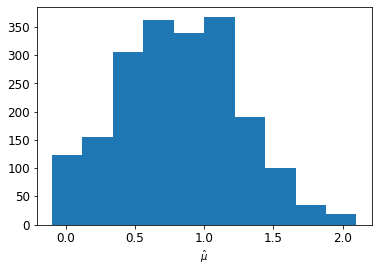

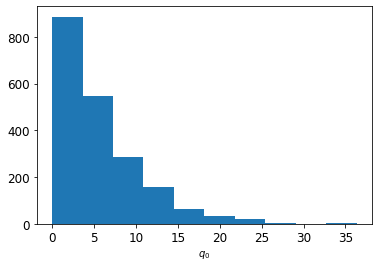

Z BL:(1.9639068401228983, 0.8068614711518937, 1.020075, 1.9654011793648816, 0.7776680352750054)
Z:2.066127730662656
Z_std:1.2293253818707708
Z_1:2.0202607448871346
Z_std_1:1.448196830353407
7
AUC:0.9027297275295135
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

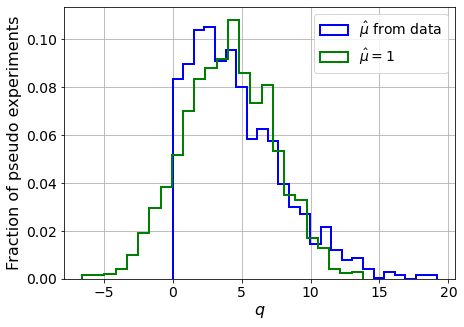

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  6927.05523655  6774.38045168  6576.57720623
  6331.35167613  6013.60659576  5622.17474774  5155.97770795
  4566.90165341  3841.78759063  2959.53184877  1899.98872776
   625.87827644  -896.09126036 -2720.41769888 -5302.45094565]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  4272.53217937  4281.6732369
 

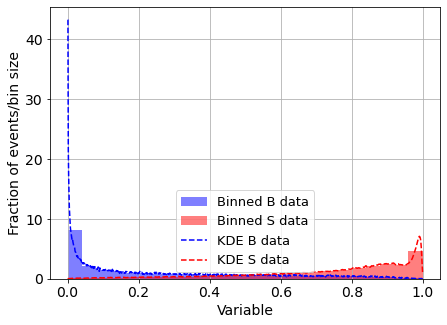

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.019331094353735364
0.019331094353735364
3 done
4 done
0.0
0.00023017782394656452


  1%|▋                                                                 | 21/2000 [00:07<14:08,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4391150043556443
<p_{s}(Sdata)> = 1.951312852844898
<p_{b}(Bdata)> = 6.981696514061501
<p_{s}(Bdata)> = 0.4185814686389665


  2%|█                                                                 | 33/2000 [00:11<09:05,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35808508361567976
<p_{s}(Sdata)> = 2.1166939361956247
<p_{b}(Bdata)> = 7.001252792702885
<p_{s}(Bdata)> = 0.4211519966166062


  2%|█▏                                                                | 37/2000 [00:12<10:50,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4739321261043038
<p_{s}(Sdata)> = 1.7561443562380472
<p_{b}(Bdata)> = 6.945308225628898
<p_{s}(Bdata)> = 0.41747291361439187


  2%|█▌                                                                | 47/2000 [00:15<11:14,  2.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3838137259956791
<p_{s}(Sdata)> = 2.193360343585524
<p_{b}(Bdata)> = 6.89296689683465
<p_{s}(Bdata)> = 0.41860381869225183


  3%|██                                                                | 64/2000 [00:22<13:23,  2.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41444552623715836
<p_{s}(Sdata)> = 1.8936741980223644
<p_{b}(Bdata)> = 6.872927445682783
<p_{s}(Bdata)> = 0.42703048712124053


  6%|███▋                                                             | 114/2000 [00:40<10:33,  2.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40160874970637966
<p_{s}(Sdata)> = 2.087367040092758
<p_{b}(Bdata)> = 6.9668824677718835
<p_{s}(Bdata)> = 0.4157664756360264


  7%|████▋                                                            | 144/2000 [00:52<09:57,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.0056271357315285
<p_{s}(Sdata)> = 2.1391091867782897
<p_{b}(Bdata)> = 6.912570314307474
<p_{s}(Bdata)> = 0.41828941743975806


 10%|██████▍                                                          | 198/2000 [01:14<11:05,  2.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4462850755237781
<p_{s}(Sdata)> = 2.091155504566023
<p_{b}(Bdata)> = 6.956604553939673
<p_{s}(Bdata)> = 0.41845731220963067


 12%|███████▌                                                         | 232/2000 [01:27<10:39,  2.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4054400488420857
<p_{s}(Sdata)> = 2.1396145183879516
<p_{b}(Bdata)> = 6.983185352280185
<p_{s}(Bdata)> = 0.41753643544541624


 12%|███████▋                                                         | 236/2000 [01:29<10:47,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3993793724897159
<p_{s}(Sdata)> = 2.04369596398952
<p_{b}(Bdata)> = 6.889891585928378
<p_{s}(Bdata)> = 0.42212084187239035


 12%|███████▊                                                         | 242/2000 [01:31<11:40,  2.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4144399561368947
<p_{s}(Sdata)> = 2.0162107954803297
<p_{b}(Bdata)> = 6.993477141691737
<p_{s}(Bdata)> = 0.4192614763138212


 13%|████████▍                                                        | 258/2000 [01:36<09:10,  3.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4247716075270358
<p_{s}(Sdata)> = 1.8615942186604846
<p_{b}(Bdata)> = 7.00108163848986
<p_{s}(Bdata)> = 0.41932337055609176


 14%|█████████▎                                                       | 286/2000 [01:46<11:07,  2.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36219003636992914
<p_{s}(Sdata)> = 2.3751910829946303
<p_{b}(Bdata)> = 6.962596408780775
<p_{s}(Bdata)> = 0.4198590294525746


 15%|██████████                                                       | 309/2000 [01:54<10:53,  2.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.405850866010845
<p_{s}(Sdata)> = 1.9851693757986562
<p_{b}(Bdata)> = 6.951991852776203
<p_{s}(Bdata)> = 0.42387968856399877


 17%|███████████                                                      | 341/2000 [02:06<10:08,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4390244392950941
<p_{s}(Sdata)> = 2.0279361601646437
<p_{b}(Bdata)> = 6.921084718889346
<p_{s}(Bdata)> = 0.42073591791773596


 17%|███████████▎                                                     | 348/2000 [02:09<11:18,  2.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40615133625755845
<p_{s}(Sdata)> = 2.022825077078533
<p_{b}(Bdata)> = 6.997160400998843
<p_{s}(Bdata)> = 0.4213356813599022


 18%|███████████▊                                                     | 365/2000 [02:15<10:56,  2.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5079624554346819
<p_{s}(Sdata)> = 1.7304406168322974
<p_{b}(Bdata)> = 6.9615973402047855
<p_{s}(Bdata)> = 0.42107370924167653


 20%|████████████▊                                                    | 395/2000 [02:26<06:56,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4310525133005065
<p_{s}(Sdata)> = 1.8585532318450284
<p_{b}(Bdata)> = 6.910501799868957
<p_{s}(Bdata)> = 0.4249477977946908


 21%|█████████████▋                                                   | 422/2000 [02:35<07:14,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9276048950264911
<p_{s}(Sdata)> = 1.9281544988326693
<p_{b}(Bdata)> = 6.942195474285442
<p_{s}(Bdata)> = 0.4203874008620742


 23%|██████████████▉                                                  | 458/2000 [02:48<09:33,  2.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3966307875197101
<p_{s}(Sdata)> = 2.033964235530253
<p_{b}(Bdata)> = 7.0522537556065865
<p_{s}(Bdata)> = 0.41785481383504897


 25%|████████████████▏                                                | 499/2000 [03:02<09:12,  2.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46153028781756406
<p_{s}(Sdata)> = 1.7172410977304429
<p_{b}(Bdata)> = 6.79365961435559
<p_{s}(Bdata)> = 0.42263687138522826


 27%|█████████████████▎                                               | 533/2000 [03:16<07:41,  3.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4573394534185984
<p_{s}(Sdata)> = 2.0692306489962955
<p_{b}(Bdata)> = 7.058101913804052
<p_{s}(Bdata)> = 0.41507774512496926


 29%|██████████████████▊                                              | 577/2000 [03:31<08:23,  2.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4691201254556912
<p_{s}(Sdata)> = 1.7497218832075019
<p_{b}(Bdata)> = 7.016864337737879
<p_{s}(Bdata)> = 0.4191897429419348


 33%|█████████████████████▏                                           | 653/2000 [03:57<09:55,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4478116063180295
<p_{s}(Sdata)> = 1.8046752181739847
<p_{b}(Bdata)> = 6.845744001059054
<p_{s}(Bdata)> = 0.42006880496531235


 34%|██████████████████████                                           | 677/2000 [04:07<07:18,  3.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.43753503285449713
<p_{s}(Sdata)> = 2.4052644303307864
<p_{b}(Bdata)> = 6.981840560065029
<p_{s}(Bdata)> = 0.42911317152851663
muhat = -0.1
<p_{b}(Sdata)> = 0.4354057319354186
<p_{s}(Sdata)> = 1.8945063840678313
<p_{b}(Bdata)> = 6.969260652569511
<p_{s}(Bdata)> = 0.41575682076905907


 34%|██████████████████████                                           | 680/2000 [04:07<05:49,  3.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42176309447844995
<p_{s}(Sdata)> = 1.9854713404792932
<p_{b}(Bdata)> = 6.809929648154319
<p_{s}(Bdata)> = 0.4176542848544855


 35%|██████████████████████▍                                          | 692/2000 [04:12<08:26,  2.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4532087374973784
<p_{s}(Sdata)> = 1.9245649745972597
<p_{b}(Bdata)> = 6.891924576368913
<p_{s}(Bdata)> = 0.42260906965819206


 35%|██████████████████████▉                                          | 704/2000 [04:16<07:08,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42820070392246434
<p_{s}(Sdata)> = 2.0012703424017735
<p_{b}(Bdata)> = 6.861274281606055
<p_{s}(Bdata)> = 0.4197525284651109


 36%|███████████████████████▍                                         | 720/2000 [04:22<08:32,  2.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3476447839573549
<p_{s}(Sdata)> = 2.590781985941378
<p_{b}(Bdata)> = 7.044980759315779
<p_{s}(Bdata)> = 0.41616110754930324


 37%|███████████████████████▊                                         | 733/2000 [04:26<07:42,  2.74it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4073727811143391
<p_{s}(Sdata)> = 2.023963712703134
<p_{b}(Bdata)> = 6.805681791921443
<p_{s}(Bdata)> = 0.43130399109292233


 37%|████████████████████████▏                                        | 743/2000 [04:30<08:54,  2.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43003722545931283
<p_{s}(Sdata)> = 1.8290888913837808
<p_{b}(Bdata)> = 6.7222906369805004
<p_{s}(Bdata)> = 0.4238895506672475


 41%|██████████████████████████▋                                      | 822/2000 [04:58<05:15,  3.73it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37226647768516546
<p_{s}(Sdata)> = 2.4446251064343376
<p_{b}(Bdata)> = 6.846167255098162
<p_{s}(Bdata)> = 0.4236589007637731


 41%|██████████████████████████▉                                      | 827/2000 [05:00<06:32,  2.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45347713851402277
<p_{s}(Sdata)> = 1.9927060956863554
<p_{b}(Bdata)> = 6.990482026863851
<p_{s}(Bdata)> = 0.4182052735559383


 42%|███████████████████████████                                      | 831/2000 [05:01<04:27,  4.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4470494594609981
<p_{s}(Sdata)> = 2.089601120470702
<p_{b}(Bdata)> = 7.011066774269412
<p_{s}(Bdata)> = 0.4125595663690831


 44%|████████████████████████████▌                                    | 879/2000 [05:18<04:15,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44092654003092685
<p_{s}(Sdata)> = 2.116538613779425
<p_{b}(Bdata)> = 6.849897677852807
<p_{s}(Bdata)> = 0.41744373117771405
muhat = -0.1
<p_{b}(Sdata)> = 0.5072188466742037
<p_{s}(Sdata)> = 1.8350062379473875
<p_{b}(Bdata)> = 6.848033884388031
<p_{s}(Bdata)> = 0.41701771577665336


 44%|████████████████████████████▊                                    | 888/2000 [05:21<05:21,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4127285202608437
<p_{s}(Sdata)> = 1.9161393969171008
<p_{b}(Bdata)> = 6.985785498811
<p_{s}(Bdata)> = 0.41326737499980387


 45%|█████████████████████████████▍                                   | 904/2000 [05:27<07:08,  2.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4817016488491361
<p_{s}(Sdata)> = 2.0905529247891264
<p_{b}(Bdata)> = 6.9976419710076145
<p_{s}(Bdata)> = 0.4198191821769998


 46%|█████████████████████████████▊                                   | 918/2000 [05:31<04:42,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4974049614366051
<p_{s}(Sdata)> = 1.6638133911694772
<p_{b}(Bdata)> = 6.892408090279522
<p_{s}(Bdata)> = 0.41734660283863656


 50%|████████████████████████████████▍                                | 997/2000 [06:02<04:15,  3.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4424976153520443
<p_{s}(Sdata)> = 1.8390563452543252
<p_{b}(Bdata)> = 6.902553223336672
<p_{s}(Bdata)> = 0.4234084819245633
muhat = -0.1
<p_{b}(Sdata)> = 0.46317591299255845
<p_{s}(Sdata)> = 1.8714296319356676
<p_{b}(Bdata)> = 6.871570302628382
<p_{s}(Bdata)> = 0.4256033309801429


 50%|████████████████████████████████▏                               | 1006/2000 [06:06<07:46,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4163443298892641
<p_{s}(Sdata)> = 2.0806792059329675
<p_{b}(Bdata)> = 6.927831567657906
<p_{s}(Bdata)> = 0.41838102335885163


 50%|████████████████████████████████▎                               | 1008/2000 [06:06<05:55,  2.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39431104342005574
<p_{s}(Sdata)> = 2.2333895153674237
<p_{b}(Bdata)> = 7.0194440716287785
<p_{s}(Bdata)> = 0.41661928811952054


 52%|█████████████████████████████████▏                              | 1038/2000 [06:18<07:04,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43472205872464237
<p_{s}(Sdata)> = 1.8287043837032266
<p_{b}(Bdata)> = 6.881768992480828
<p_{s}(Bdata)> = 0.4234375234516233


 52%|█████████████████████████████████▌                              | 1050/2000 [06:22<04:59,  3.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42269719758478536
<p_{s}(Sdata)> = 2.0150364580757003
<p_{b}(Bdata)> = 6.968040642103479
<p_{s}(Bdata)> = 0.42108630243684375


 53%|██████████████████████████████████                              | 1063/2000 [06:26<05:45,  2.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4112842767401773
<p_{s}(Sdata)> = 2.013622328134549
<p_{b}(Bdata)> = 6.990023195024075
<p_{s}(Bdata)> = 0.42113969991779293


 54%|██████████████████████████████████▏                             | 1070/2000 [06:28<04:54,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45044272450935036
<p_{s}(Sdata)> = 1.9354023519207626
<p_{b}(Bdata)> = 6.910531839292351
<p_{s}(Bdata)> = 0.4187521396266524


 54%|██████████████████████████████████▎                             | 1074/2000 [06:30<05:55,  2.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.502230535775158
<p_{s}(Sdata)> = 1.8384868835474515
<p_{b}(Bdata)> = 6.873146760505228
<p_{s}(Bdata)> = 0.42222705210043854


 55%|███████████████████████████████████                             | 1096/2000 [06:37<03:11,  4.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38772291412803495
<p_{s}(Sdata)> = 2.1150056756983053
<p_{b}(Bdata)> = 7.152527722298978
<p_{s}(Bdata)> = 0.41736615457692156
muhat = -0.1
<p_{b}(Sdata)> = 0.4073482848918713
<p_{s}(Sdata)> = 2.042965325747551
<p_{b}(Bdata)> = 7.012408307430912
<p_{s}(Bdata)> = 0.4132408237106026


 55%|███████████████████████████████████▎                            | 1103/2000 [06:40<04:43,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40401608562322416
<p_{s}(Sdata)> = 2.0537723825096337
<p_{b}(Bdata)> = 6.791919067711098
<p_{s}(Bdata)> = 0.4244249043279578


 56%|███████████████████████████████████▌                            | 1113/2000 [06:43<04:31,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3826387474598579
<p_{s}(Sdata)> = 2.0325959782600056
<p_{b}(Bdata)> = 6.8276761548251335
<p_{s}(Bdata)> = 0.42643666606783925


 56%|███████████████████████████████████▋                            | 1117/2000 [06:44<03:43,  3.95it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.39522961228140957
<p_{s}(Sdata)> = 2.2624965241326973
<p_{b}(Bdata)> = 6.79464579074034
<p_{s}(Bdata)> = 0.4343460524428786


 57%|████████████████████████████████████▊                           | 1150/2000 [06:56<04:42,  3.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6064174905112361
<p_{s}(Sdata)> = 1.9461433301356377
<p_{b}(Bdata)> = 6.936357696828556
<p_{s}(Bdata)> = 0.41667992523831754


 58%|█████████████████████████████████████▍                          | 1169/2000 [07:02<05:35,  2.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43574833849726474
<p_{s}(Sdata)> = 2.010486048587574
<p_{b}(Bdata)> = 6.931040068654513
<p_{s}(Bdata)> = 0.42503112126495635


 63%|████████████████████████████████████████                        | 1252/2000 [07:31<04:19,  2.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43404123019973984
<p_{s}(Sdata)> = 1.8591842931287053
<p_{b}(Bdata)> = 6.9420922262937115
<p_{s}(Bdata)> = 0.4192370304911276


 63%|████████████████████████████████████████▌                       | 1266/2000 [07:37<05:12,  2.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3973770504655452
<p_{s}(Sdata)> = 2.294012712339788
<p_{b}(Bdata)> = 6.943163223045738
<p_{s}(Bdata)> = 0.4194860904180948


 64%|████████████████████████████████████████▊                       | 1275/2000 [07:39<03:54,  3.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45349499305091967
<p_{s}(Sdata)> = 1.935626128866221
<p_{b}(Bdata)> = 6.849481860462689
<p_{s}(Bdata)> = 0.4217752582618172


 66%|██████████████████████████████████████████▌                     | 1330/2000 [08:00<04:31,  2.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4119650242032019
<p_{s}(Sdata)> = 1.9893497470564132
<p_{b}(Bdata)> = 6.893480720905514
<p_{s}(Bdata)> = 0.4230441567182629


 68%|███████████████████████████████████████████▍                    | 1358/2000 [08:10<03:54,  2.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45124517304242134
<p_{s}(Sdata)> = 2.006286453430374
<p_{b}(Bdata)> = 6.847955234878597
<p_{s}(Bdata)> = 0.41885435336463056


 71%|█████████████████████████████████████████████▌                  | 1423/2000 [08:32<03:30,  2.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4402396345679173
<p_{s}(Sdata)> = 1.786400199924472
<p_{b}(Bdata)> = 6.974158874826031
<p_{s}(Bdata)> = 0.4190944771961876


 72%|██████████████████████████████████████████████▏                 | 1442/2000 [08:38<03:20,  2.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.446528681613504
<p_{s}(Sdata)> = 1.7643734130707354
<p_{b}(Bdata)> = 6.890551165743862
<p_{s}(Bdata)> = 0.4224881334192886


 78%|██████████████████████████████████████████████████▏             | 1567/2000 [09:24<02:02,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47990919980198976
<p_{s}(Sdata)> = 1.7764231927028475
<p_{b}(Bdata)> = 7.018996517502882
<p_{s}(Bdata)> = 0.42133925307836484
muhat = -0.1
<p_{b}(Sdata)> = 0.4212206568595015
<p_{s}(Sdata)> = 2.15319657905954
<p_{b}(Bdata)> = 6.969510288526946
<p_{s}(Bdata)> = 0.4210794572942718


 79%|██████████████████████████████████████████████████▎             | 1574/2000 [09:26<03:08,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3960597243708389
<p_{s}(Sdata)> = 2.1633752871790013
<p_{b}(Bdata)> = 6.89300756200225
<p_{s}(Bdata)> = 0.4170395759035073


 80%|███████████████████████████████████████████████████▍            | 1606/2000 [09:38<02:20,  2.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38683368285370534
<p_{s}(Sdata)> = 2.243051582525072
<p_{b}(Bdata)> = 6.963393282728244
<p_{s}(Bdata)> = 0.42063833337232587


 81%|███████████████████████████████████████████████████▊            | 1618/2000 [09:42<02:07,  3.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.36477884679061695
<p_{s}(Sdata)> = 2.452682226792177
<p_{b}(Bdata)> = 6.950713663884948
<p_{s}(Bdata)> = 0.4254000327250044


 83%|█████████████████████████████████████████████████████▏          | 1664/2000 [09:59<02:06,  2.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4154223362148587
<p_{s}(Sdata)> = 2.0403956159906076
<p_{b}(Bdata)> = 7.051905166540615
<p_{s}(Bdata)> = 0.41739581593312547


 84%|█████████████████████████████████████████████████████▋          | 1678/2000 [10:03<01:17,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4502258883187621
<p_{s}(Sdata)> = 2.1793907100559364
<p_{b}(Bdata)> = 7.071722208158463
<p_{s}(Bdata)> = 0.4133173612869841


 85%|██████████████████████████████████████████████████████▏         | 1693/2000 [10:08<01:33,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38784691169769886
<p_{s}(Sdata)> = 2.0012294034671974
<p_{b}(Bdata)> = 6.906880848571522
<p_{s}(Bdata)> = 0.4190601688741618


 86%|███████████████████████████████████████████████████████▎        | 1728/2000 [10:21<01:35,  2.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4871582789510972
<p_{s}(Sdata)> = 1.941057236887626
<p_{b}(Bdata)> = 6.912059359548807
<p_{s}(Bdata)> = 0.41632036308274833


 87%|███████████████████████████████████████████████████████▉        | 1748/2000 [10:27<01:11,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43645461077521236
<p_{s}(Sdata)> = 1.885400557803059
<p_{b}(Bdata)> = 6.847960217415288
<p_{s}(Bdata)> = 0.42233247198386115


 88%|████████████████████████████████████████████████████████▌       | 1767/2000 [10:35<01:34,  2.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46964085778722
<p_{s}(Sdata)> = 1.9210880632979115
<p_{b}(Bdata)> = 7.028506949298795
<p_{s}(Bdata)> = 0.4200265416647627


 89%|█████████████████████████████████████████████████████████       | 1783/2000 [10:39<00:49,  4.38it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3864942925392761
<p_{s}(Sdata)> = 2.334489069943054
<p_{b}(Bdata)> = 6.908421038773545
<p_{s}(Bdata)> = 0.43089034432827134


 90%|█████████████████████████████████████████████████████████▉      | 1809/2000 [10:48<01:00,  3.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32629092573429874
<p_{s}(Sdata)> = 2.637940652018049
<p_{b}(Bdata)> = 6.9072046378942575
<p_{s}(Bdata)> = 0.42912163229535916


 91%|██████████████████████████████████████████████████████████▍     | 1825/2000 [10:54<00:43,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46126945708591416
<p_{s}(Sdata)> = 1.826833590394191
<p_{b}(Bdata)> = 6.960213741706686
<p_{s}(Bdata)> = 0.4181733312412588
muhat = -0.1
<p_{b}(Sdata)> = 0.42450976003999147
<p_{s}(Sdata)> = 2.0159481796946483
<p_{b}(Bdata)> = 6.814300012113299
<p_{s}(Bdata)> = 0.4230924225406293


 93%|███████████████████████████████████████████████████████████▌    | 1863/2000 [11:07<00:49,  2.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3949852294856803
<p_{s}(Sdata)> = 2.086805446069138
<p_{b}(Bdata)> = 6.844741600994691
<p_{s}(Bdata)> = 0.4206233900528324


 94%|███████████████████████████████████████████████████████████▊    | 1871/2000 [11:10<00:55,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4524093565898444
<p_{s}(Sdata)> = 1.8377317751596365
<p_{b}(Bdata)> = 6.905106762981263
<p_{s}(Bdata)> = 0.4236839837119206


 94%|████████████████████████████████████████████████████████████    | 1875/2000 [11:12<00:44,  2.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4259203766699962
<p_{s}(Sdata)> = 1.675262192706427
<p_{b}(Bdata)> = 6.99681089713071
<p_{s}(Bdata)> = 0.41829155744759344


 94%|████████████████████████████████████████████████████████████▏   | 1879/2000 [11:13<00:47,  2.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45630715444236936
<p_{s}(Sdata)> = 1.7419300118650007
<p_{b}(Bdata)> = 6.921089328588935
<p_{s}(Bdata)> = 0.4179397965801383


 94%|████████████████████████████████████████████████████████████▎   | 1883/2000 [11:14<00:37,  3.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48328429706147014
<p_{s}(Sdata)> = 1.887112433284265
<p_{b}(Bdata)> = 6.928345263111831
<p_{s}(Bdata)> = 0.41492788944052444


 95%|████████████████████████████████████████████████████████████▌   | 1892/2000 [11:17<00:34,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3936129274157836
<p_{s}(Sdata)> = 2.0857489032532643
<p_{b}(Bdata)> = 6.963915537698737
<p_{s}(Bdata)> = 0.41831693774872003


 95%|████████████████████████████████████████████████████████████▋   | 1897/2000 [11:19<00:33,  3.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5704099713722197
<p_{s}(Sdata)> = 1.6347702237353805
<p_{b}(Bdata)> = 6.910566364958637
<p_{s}(Bdata)> = 0.42205031505095675


 96%|█████████████████████████████████████████████████████████████▏  | 1912/2000 [11:24<00:22,  3.90it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37300797351540177
<p_{s}(Sdata)> = 2.472409022978478
<p_{b}(Bdata)> = 6.741937450826201
<p_{s}(Bdata)> = 0.4323513928852233


100%|████████████████████████████████████████████████████████████████| 2000/2000 [11:56<00:00,  2.79it/s]


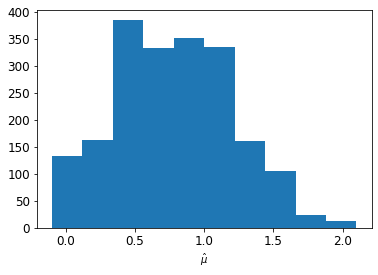

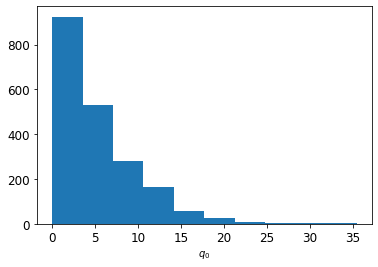

Z BL:(2.013721210849367, 0.8237491555092388, 1.0223250000000002, 2.013914173353171, 0.8078894256976968)
Z:1.9890897642827834
Z_std:1.2093971319468835
Z_1:1.8963257097453183
Z_std_1:1.4848243300520758
8
AUC:0.90320789471208
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

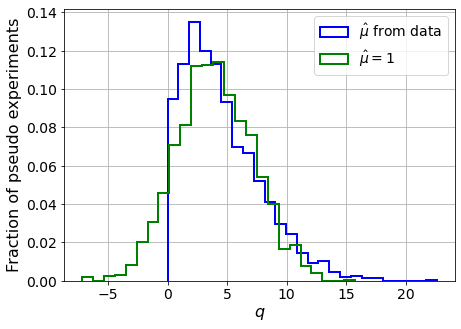

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  7002.11373797
  6700.69652208  6333.31434404  5892.08109721  5358.54726528
  4726.44916981  3962.76096101  3043.46856872  1955.02553235
   656.57060952  -886.00479123 -2729.16775926 -5310.18630817]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  4331.04722153  4359.64496737  4364.52802051


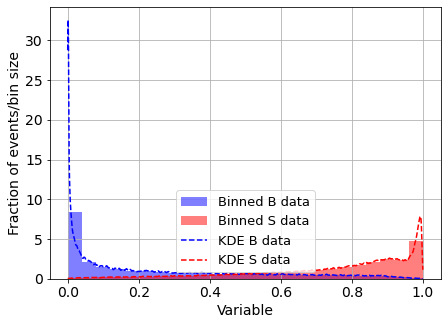

KDE Kernel:  epanechnikov
Background bandwidth:  0.0031053121543406503
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.021837354982738567
0.021837354982738567
3 done
4 done
0.005580471207402181
0.005580471207402181


  1%|▍                                                                 | 14/2000 [00:03<09:20,  3.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.545319489109465
<p_{s}(Sdata)> = 2.4634082213428647
<p_{b}(Bdata)> = 6.347834405614401
<p_{s}(Bdata)> = 0.41259537670721524


  1%|▊                                                                 | 24/2000 [00:06<07:15,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4621861604286342
<p_{s}(Sdata)> = 1.7910145329603147
<p_{b}(Bdata)> = 6.177956419566981
<p_{s}(Bdata)> = 0.41921562626286263
muhat = -0.1
<p_{b}(Sdata)> = 0.43475371469979446
<p_{s}(Sdata)> = 2.156798101381631
<p_{b}(Bdata)> = 6.212853218991956
<p_{s}(Bdata)> = 0.418577289081986


  1%|▉                                                                 | 28/2000 [00:07<05:40,  5.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36219543401902715
<p_{s}(Sdata)> = 2.2275577007924694
<p_{b}(Bdata)> = 6.299240947783347
<p_{s}(Bdata)> = 0.414246624562224
muhat = -0.1
<p_{b}(Sdata)> = 0.45537946411822144
<p_{s}(Sdata)> = 1.8646295022415145
<p_{b}(Bdata)> = 6.228305545757314
<p_{s}(Bdata)> = 0.41776908265777707


  2%|█▎                                                                | 41/2000 [00:10<05:44,  5.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4056528868441947
<p_{s}(Sdata)> = 2.141148234765703
<p_{b}(Bdata)> = 6.212976981868391
<p_{s}(Bdata)> = 0.4198013985626281
muhat = -0.1
<p_{b}(Sdata)> = 0.4205581948524269
<p_{s}(Sdata)> = 2.0082920457693962
<p_{b}(Bdata)> = 6.234952184844599
<p_{s}(Bdata)> = 0.41479266513833624


  2%|█▍                                                                | 44/2000 [00:10<05:56,  5.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4881668913685404
<p_{s}(Sdata)> = 2.244091523713469
<p_{b}(Bdata)> = 6.244074866321331
<p_{s}(Bdata)> = 0.4180782231141373


  4%|██▌                                                               | 78/2000 [00:22<06:13,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44771049653677997
<p_{s}(Sdata)> = 1.8224845662395541
<p_{b}(Bdata)> = 6.30883107231401
<p_{s}(Bdata)> = 0.4200812528356385
muhat = -0.1
<p_{b}(Sdata)> = 0.4605920812643848
<p_{s}(Sdata)> = 1.8607902016882918
<p_{b}(Bdata)> = 6.28837274170427
<p_{s}(Bdata)> = 0.41889029170028647


  5%|███▎                                                             | 102/2000 [00:29<11:00,  2.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5050855753479159
<p_{s}(Sdata)> = 1.7829382408637648
<p_{b}(Bdata)> = 6.27052538393978
<p_{s}(Bdata)> = 0.42299888512416245


  6%|███▌                                                             | 110/2000 [00:32<10:04,  3.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5073152836886939
<p_{s}(Sdata)> = 2.140431424732549
<p_{b}(Bdata)> = 6.366866473314887
<p_{s}(Bdata)> = 0.4169254523812652


  6%|███▋                                                             | 114/2000 [00:33<08:58,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4912347038940883
<p_{s}(Sdata)> = 1.8663310741728178
<p_{b}(Bdata)> = 6.351672531008643
<p_{s}(Bdata)> = 0.42389132534289425


  6%|███▊                                                             | 116/2000 [00:33<07:08,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40826374730431597
<p_{s}(Sdata)> = 2.3564093450228354
<p_{b}(Bdata)> = 6.324393258047526
<p_{s}(Bdata)> = 0.41432345207210675


  6%|███▉                                                             | 121/2000 [00:34<06:37,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47390739334649673
<p_{s}(Sdata)> = 2.0005493061093533
<p_{b}(Bdata)> = 6.309854295738934
<p_{s}(Bdata)> = 0.4177520724308892


  6%|████                                                             | 124/2000 [00:35<07:32,  4.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4087212167994107
<p_{s}(Sdata)> = 2.0334579606533323
<p_{b}(Bdata)> = 6.302921747514972
<p_{s}(Bdata)> = 0.41381488394339244


  6%|████▏                                                            | 127/2000 [00:36<07:08,  4.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4490219903294043
<p_{s}(Sdata)> = 1.9789836948110513
<p_{b}(Bdata)> = 6.241852675740064
<p_{s}(Bdata)> = 0.4173428657867153


  6%|████▏                                                            | 129/2000 [00:36<06:25,  4.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38880870813508966
<p_{s}(Sdata)> = 2.101720195760699
<p_{b}(Bdata)> = 6.266775460042528
<p_{s}(Bdata)> = 0.4186738499658984


  7%|████▎                                                            | 134/2000 [00:37<08:31,  3.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4267848498961895
<p_{s}(Sdata)> = 1.9384466453650884
<p_{b}(Bdata)> = 6.23875002958347
<p_{s}(Bdata)> = 0.4206629590915784


  7%|████▍                                                            | 138/2000 [00:38<06:13,  4.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4154062075632235
<p_{s}(Sdata)> = 1.9842711060858116
<p_{b}(Bdata)> = 6.258841035395376
<p_{s}(Bdata)> = 0.4139293538795761


  7%|████▌                                                            | 141/2000 [00:39<07:14,  4.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43629956072199666
<p_{s}(Sdata)> = 2.386291340447444
<p_{b}(Bdata)> = 6.2137101106445485
<p_{s}(Bdata)> = 0.41351292119273253


  7%|████▊                                                            | 147/2000 [00:40<08:00,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4489943716991906
<p_{s}(Sdata)> = 1.8568722110949498
<p_{b}(Bdata)> = 6.367905000074656
<p_{s}(Bdata)> = 0.41831084628168885


  8%|████▉                                                            | 151/2000 [00:41<05:10,  5.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.456184801856794
<p_{s}(Sdata)> = 2.138071427740789
<p_{b}(Bdata)> = 6.274816080525062
<p_{s}(Bdata)> = 0.4190265789244644
muhat = -0.1
<p_{b}(Sdata)> = 0.40455587794180536
<p_{s}(Sdata)> = 1.8726865725800603
<p_{b}(Bdata)> = 6.319843683594924
<p_{s}(Bdata)> = 0.4215417954390327


  8%|█████                                                            | 155/2000 [00:42<08:52,  3.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4038806217312702
<p_{s}(Sdata)> = 2.1959670820495925
<p_{b}(Bdata)> = 6.330862940414819
<p_{s}(Bdata)> = 0.4207861292587899


  8%|█████▍                                                           | 168/2000 [00:46<08:13,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4476646975717849
<p_{s}(Sdata)> = 1.9563485988540774
<p_{b}(Bdata)> = 6.310706843612607
<p_{s}(Bdata)> = 0.4202520461253767


  9%|█████▌                                                           | 173/2000 [00:47<07:10,  4.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4273689795314324
<p_{s}(Sdata)> = 2.235982979090511
<p_{b}(Bdata)> = 6.268149796317918
<p_{s}(Bdata)> = 0.42039400226034784


  9%|██████▏                                                          | 189/2000 [00:52<09:50,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4660815311315009
<p_{s}(Sdata)> = 2.0408646725796835
<p_{b}(Bdata)> = 6.289655037212942
<p_{s}(Bdata)> = 0.41144846770060023


 10%|██████▍                                                          | 198/2000 [00:55<06:42,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45217304164015937
<p_{s}(Sdata)> = 2.342490657745925
<p_{b}(Bdata)> = 6.312509829251707
<p_{s}(Bdata)> = 0.414276598332135
muhat = -0.1
<p_{b}(Sdata)> = 0.39504258062631586
<p_{s}(Sdata)> = 2.100423573700991
<p_{b}(Bdata)> = 6.329670806217893
<p_{s}(Bdata)> = 0.41938182796587986


 10%|██████▌                                                          | 202/2000 [00:56<08:11,  3.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4003336729066146
<p_{s}(Sdata)> = 2.15731104068039
<p_{b}(Bdata)> = 6.27045441825907
<p_{s}(Bdata)> = 0.42100756730722466


 10%|██████▋                                                          | 205/2000 [00:56<07:20,  4.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5617682257776418
<p_{s}(Sdata)> = 1.8977844951109186
<p_{b}(Bdata)> = 6.261140417977114
<p_{s}(Bdata)> = 0.4225629446731505


 10%|██████▊                                                          | 210/2000 [00:57<06:22,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45043916914682164
<p_{s}(Sdata)> = 2.3728533045644338
<p_{b}(Bdata)> = 6.305581222108546
<p_{s}(Bdata)> = 0.41544052632041895


 11%|███████▏                                                         | 223/2000 [01:01<10:17,  2.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5575602958316913
<p_{s}(Sdata)> = 1.6776989748141586
<p_{b}(Bdata)> = 6.350733790440811
<p_{s}(Bdata)> = 0.41864106661445744


 12%|███████▋                                                         | 238/2000 [01:05<05:44,  5.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3883606911512937
<p_{s}(Sdata)> = 2.101846536932956
<p_{b}(Bdata)> = 6.388151709140229
<p_{s}(Bdata)> = 0.4189372496753573
muhat = -0.1
<p_{b}(Sdata)> = 0.4280294646295324
<p_{s}(Sdata)> = 1.8407483471880022
<p_{b}(Bdata)> = 6.287862496999536
<p_{s}(Bdata)> = 0.4221859540894274


 13%|████████▎                                                        | 255/2000 [01:10<08:34,  3.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4730964431870067
<p_{s}(Sdata)> = 1.9389040279199228
<p_{b}(Bdata)> = 6.229958230208446
<p_{s}(Bdata)> = 0.41795480994624823


 13%|████████▎                                                        | 257/2000 [01:11<07:18,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45501032337484926
<p_{s}(Sdata)> = 1.923572927200112
<p_{b}(Bdata)> = 6.397764565323554
<p_{s}(Bdata)> = 0.417344096891711


 14%|█████████                                                        | 279/2000 [01:18<10:19,  2.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4436931768622458
<p_{s}(Sdata)> = 2.0351088173945815
<p_{b}(Bdata)> = 6.199806672521965
<p_{s}(Bdata)> = 0.41759926638795347


 14%|█████████▍                                                       | 290/2000 [01:21<08:10,  3.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4542854523374656
<p_{s}(Sdata)> = 2.285392906563181
<p_{b}(Bdata)> = 6.277850185196663
<p_{s}(Bdata)> = 0.4177475036787528


 15%|█████████▊                                                       | 301/2000 [01:25<09:44,  2.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4847811453335531
<p_{s}(Sdata)> = 2.207517459297466
<p_{b}(Bdata)> = 6.265621600118439
<p_{s}(Bdata)> = 0.4233287542521735


 16%|██████████▎                                                      | 317/2000 [01:29<05:12,  5.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47873162638196354
<p_{s}(Sdata)> = 1.904989003978162
<p_{b}(Bdata)> = 6.252733692913699
<p_{s}(Bdata)> = 0.4178482322874745
muhat = -0.1
<p_{b}(Sdata)> = 0.3979688638099108
<p_{s}(Sdata)> = 2.2470755711017554
<p_{b}(Bdata)> = 6.326751273191762
<p_{s}(Bdata)> = 0.4132765858641468
muhat = -0.1
<p_{b}(Sdata)> = 0.5313378450541546
<p_{s}(Sdata)> = 2.027146314007067
<p_{b}(Bdata)> = 6.309371106632829
<p_{s}(Bdata)> = 0.41670579773603916


 16%|██████████▎                                                      | 319/2000 [01:29<04:06,  6.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3826913690980964
<p_{s}(Sdata)> = 2.063631692831764
<p_{b}(Bdata)> = 6.321150803499973
<p_{s}(Bdata)> = 0.4197108048005201


 17%|██████████▉                                                      | 338/2000 [01:35<06:33,  4.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4506639915832229
<p_{s}(Sdata)> = 2.074221545247082
<p_{b}(Bdata)> = 6.369655069082929
<p_{s}(Bdata)> = 0.417421110634469
muhat = -0.1
<p_{b}(Sdata)> = 0.41176449445286806
<p_{s}(Sdata)> = 2.0414676729930172
<p_{b}(Bdata)> = 6.314992470408572
<p_{s}(Bdata)> = 0.4172414206991943


 17%|███████████▏                                                     | 344/2000 [01:36<07:41,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3792777229480417
<p_{s}(Sdata)> = 2.1911324318079566
<p_{b}(Bdata)> = 6.310633598656429
<p_{s}(Bdata)> = 0.42118299874143855


 17%|███████████▎                                                     | 349/2000 [01:38<08:22,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3934204536713479
<p_{s}(Sdata)> = 2.317761858274552
<p_{b}(Bdata)> = 6.389433982706338
<p_{s}(Bdata)> = 0.41489733886710756


 19%|████████████▏                                                    | 376/2000 [01:47<09:37,  2.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40393063279305536
<p_{s}(Sdata)> = 1.8907379058057079
<p_{b}(Bdata)> = 6.332589847476979
<p_{s}(Bdata)> = 0.4224313824854867


 19%|████████████▌                                                    | 385/2000 [01:50<08:33,  3.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44236510657192957
<p_{s}(Sdata)> = 2.0887970719259665
<p_{b}(Bdata)> = 6.363782485492787
<p_{s}(Bdata)> = 0.41549435315393335


 20%|████████████▊                                                    | 394/2000 [01:52<05:25,  4.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42507744126802244
<p_{s}(Sdata)> = 2.136285826440226
<p_{b}(Bdata)> = 6.31115784925659
<p_{s}(Bdata)> = 0.41896157944570905
muhat = -0.1
<p_{b}(Sdata)> = 0.4661025020279295
<p_{s}(Sdata)> = 2.2117269520901424
<p_{b}(Bdata)> = 6.324804329952518
<p_{s}(Bdata)> = 0.42204832168862727


 20%|████████████▊                                                    | 396/2000 [01:52<05:54,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4329593845270885
<p_{s}(Sdata)> = 1.920310089280887
<p_{b}(Bdata)> = 6.323318860881452
<p_{s}(Bdata)> = 0.4177572525515783


 21%|█████████████▍                                                   | 414/2000 [01:58<08:22,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42385454392227884
<p_{s}(Sdata)> = 2.34380239413137
<p_{b}(Bdata)> = 6.168806900890083
<p_{s}(Bdata)> = 0.4193339458558376


 21%|█████████████▌                                                   | 419/2000 [01:59<06:29,  4.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4507627526036101
<p_{s}(Sdata)> = 2.001691206229987
<p_{b}(Bdata)> = 6.215697859447031
<p_{s}(Bdata)> = 0.4157750981673994


 21%|█████████████▋                                                   | 421/2000 [01:59<04:54,  5.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47158734248532524
<p_{s}(Sdata)> = 1.8379900785798529
<p_{b}(Bdata)> = 6.364323819866292
<p_{s}(Bdata)> = 0.4184067031513228
muhat = -0.1
<p_{b}(Sdata)> = 0.45347987608057433
<p_{s}(Sdata)> = 2.08774772861268
<p_{b}(Bdata)> = 6.336147766941315
<p_{s}(Bdata)> = 0.4173132999167526
muhat = -0.1
<p_{b}(Sdata)> = 0.44270591675316656
<p_{s}(Sdata)> = 2.0212193992565535
<p_{b}(Bdata)> = 6.260868110350348
<p_{s}(Bdata)> = 0.4179512797635524


 22%|██████████████▏                                                  | 438/2000 [02:04<05:44,  4.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6780818862763273
<p_{s}(Sdata)> = 1.8414859086877906
<p_{b}(Bdata)> = 6.3261704686893685
<p_{s}(Bdata)> = 0.41825011543596086


 22%|██████████████▋                                                  | 450/2000 [02:08<09:11,  2.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43390955268805576
<p_{s}(Sdata)> = 2.3508689539234413
<p_{b}(Bdata)> = 6.266405810265498
<p_{s}(Bdata)> = 0.418967127639206


 23%|██████████████▊                                                  | 456/2000 [02:09<05:37,  4.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3868686938166551
<p_{s}(Sdata)> = 2.4989455690256692
<p_{b}(Bdata)> = 6.30536807432478
<p_{s}(Bdata)> = 0.4146524734003503
muhat = -0.1
<p_{b}(Sdata)> = 0.44376817667738117
<p_{s}(Sdata)> = 2.2238858186487973
<p_{b}(Bdata)> = 6.359874547431682
<p_{s}(Bdata)> = 0.41314129285028384


 23%|██████████████▉                                                  | 459/2000 [02:10<04:54,  5.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3934234144798773
<p_{s}(Sdata)> = 2.1143036161203197
<p_{b}(Bdata)> = 6.361321592334851
<p_{s}(Bdata)> = 0.41879848643856143


 23%|███████████████▏                                                 | 466/2000 [02:12<08:07,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4877012160493851
<p_{s}(Sdata)> = 2.3098553142771094
<p_{b}(Bdata)> = 6.3096279304299205
<p_{s}(Bdata)> = 0.41788397660545124


 23%|███████████████▏                                                 | 469/2000 [02:13<07:29,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39965168703530873
<p_{s}(Sdata)> = 2.2591352433204626
<p_{b}(Bdata)> = 6.163994603856821
<p_{s}(Bdata)> = 0.42153741685915813


 24%|███████████████▍                                                 | 476/2000 [02:15<07:24,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42772773540887293
<p_{s}(Sdata)> = 2.5085070698916305
<p_{b}(Bdata)> = 6.320955145784215
<p_{s}(Bdata)> = 0.4171650802063163


 24%|███████████████▋                                                 | 482/2000 [02:16<06:49,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35438100231632785
<p_{s}(Sdata)> = 2.6001166027562643
<p_{b}(Bdata)> = 6.358379574396644
<p_{s}(Bdata)> = 0.4119797741954256


 25%|████████████████▏                                                | 499/2000 [02:21<05:09,  4.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4430550588336044
<p_{s}(Sdata)> = 2.1288395194808434
<p_{b}(Bdata)> = 6.266985106864877
<p_{s}(Bdata)> = 0.42336139929590144
muhat = -0.1
<p_{b}(Sdata)> = 0.43401447613316874
<p_{s}(Sdata)> = 1.7745092399080749
<p_{b}(Bdata)> = 6.302720077761983
<p_{s}(Bdata)> = 0.41611441034900576
muhat = -0.1
<p_{b}(Sdata)> = 0.49938272166101694
<p_{s}(Sdata)> = 1.9235361654200043
<p_{b}(Bdata)> = 6.285132433210904
<p_{s}(Bdata)> = 0.419156695740437


 25%|████████████████▎                                                | 501/2000 [02:22<05:16,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4060659406651694
<p_{s}(Sdata)> = 2.096811949952377
<p_{b}(Bdata)> = 6.374357766579574
<p_{s}(Bdata)> = 0.4119902213876193


 25%|████████████████▍                                                | 507/2000 [02:23<05:19,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45795989015157107
<p_{s}(Sdata)> = 2.191036014430662
<p_{b}(Bdata)> = 6.374271031037923
<p_{s}(Bdata)> = 0.4196685582959634


 26%|████████████████▌                                                | 510/2000 [02:23<04:26,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5729835011301806
<p_{s}(Sdata)> = 1.9575573645741917
<p_{b}(Bdata)> = 6.184529428065458
<p_{s}(Bdata)> = 0.4173517351995656


 26%|█████████████████▏                                               | 527/2000 [02:28<05:33,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5148014251960419
<p_{s}(Sdata)> = 2.1620773493929835
<p_{b}(Bdata)> = 6.181691048756126
<p_{s}(Bdata)> = 0.42172465055272834


 27%|█████████████████▎                                               | 533/2000 [02:30<07:52,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4278963674927046
<p_{s}(Sdata)> = 1.9507704574354996
<p_{b}(Bdata)> = 6.410167073953023
<p_{s}(Bdata)> = 0.42038396008321594


 27%|█████████████████▊                                               | 549/2000 [02:35<08:39,  2.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4282465019235901
<p_{s}(Sdata)> = 1.8558715697727226
<p_{b}(Bdata)> = 6.228865013917043
<p_{s}(Bdata)> = 0.41931275661942485


 28%|██████████████████▌                                              | 570/2000 [02:42<05:55,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46607574542713986
<p_{s}(Sdata)> = 1.9479279103100562
<p_{b}(Bdata)> = 6.2926458185180305
<p_{s}(Bdata)> = 0.4221878441800046


 30%|███████████████████▏                                             | 591/2000 [02:48<04:29,  5.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44562818147875005
<p_{s}(Sdata)> = 1.996026698449101
<p_{b}(Bdata)> = 6.249567072708853
<p_{s}(Bdata)> = 0.41915903791411163


 30%|███████████████████▎                                             | 595/2000 [02:49<07:16,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43111868061748104
<p_{s}(Sdata)> = 2.0621359815808247
<p_{b}(Bdata)> = 6.202810926993107
<p_{s}(Bdata)> = 0.4207150329320553


 30%|███████████████████▌                                             | 603/2000 [02:52<08:11,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4411349912298977
<p_{s}(Sdata)> = 1.9434212891210507
<p_{b}(Bdata)> = 6.281369392545226
<p_{s}(Bdata)> = 0.4217620202999341


 31%|███████████████████▉                                             | 613/2000 [02:54<04:52,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3719639041141717
<p_{s}(Sdata)> = 2.4497227943632858
<p_{b}(Bdata)> = 6.223410348983269
<p_{s}(Bdata)> = 0.41856350721855506
muhat = -0.1
<p_{b}(Sdata)> = 0.4088308084585877
<p_{s}(Sdata)> = 2.1282469937696176
<p_{b}(Bdata)> = 6.257952121023306
<p_{s}(Bdata)> = 0.42080705065486534


 31%|████████████████████                                             | 617/2000 [02:55<03:58,  5.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42343055585347694
<p_{s}(Sdata)> = 2.154147373657647
<p_{b}(Bdata)> = 6.211755619092494
<p_{s}(Bdata)> = 0.421593355862659
muhat = -0.1
<p_{b}(Sdata)> = 0.4148402674756799
<p_{s}(Sdata)> = 2.1529881765931127
<p_{b}(Bdata)> = 6.2961854398632005
<p_{s}(Bdata)> = 0.4159158732531262


 31%|████████████████████▍                                            | 627/2000 [02:58<04:57,  4.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47177196189461396
<p_{s}(Sdata)> = 2.021119712854836
<p_{b}(Bdata)> = 6.375036013033485
<p_{s}(Bdata)> = 0.4133776723944918


 32%|████████████████████▌                                            | 631/2000 [02:59<05:06,  4.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.422558131099245
<p_{s}(Sdata)> = 2.2008909296110555
<p_{b}(Bdata)> = 6.279802620649143
<p_{s}(Bdata)> = 0.41916879715454525


 32%|████████████████████▋                                            | 635/2000 [02:59<03:58,  5.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4626982118743429
<p_{s}(Sdata)> = 1.8251221754554479
<p_{b}(Bdata)> = 6.244073779710895
<p_{s}(Bdata)> = 0.42055972230457217


 32%|████████████████████▋                                            | 638/2000 [03:00<05:08,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49620640074146494
<p_{s}(Sdata)> = 2.09612671929475
<p_{b}(Bdata)> = 6.3422589537092975
<p_{s}(Bdata)> = 0.4201218516843055


 32%|█████████████████████                                            | 648/2000 [03:03<05:16,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6793811308777882
<p_{s}(Sdata)> = 1.6156700523063328
<p_{b}(Bdata)> = 6.304934341540512
<p_{s}(Bdata)> = 0.4241044319355381
muhat = -0.1
<p_{b}(Sdata)> = 0.44690503135329424
<p_{s}(Sdata)> = 2.1380692796612744
<p_{b}(Bdata)> = 6.225008739131987
<p_{s}(Bdata)> = 0.4196535574610466


 33%|█████████████████████▏                                           | 653/2000 [03:04<06:18,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37029891709022006
<p_{s}(Sdata)> = 2.2310945874471644
<p_{b}(Bdata)> = 6.345287541515755
<p_{s}(Bdata)> = 0.41641518570847


 33%|█████████████████████▌                                           | 664/2000 [03:07<04:42,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42370088008856527
<p_{s}(Sdata)> = 2.36946265334795
<p_{b}(Bdata)> = 6.3248780596986105
<p_{s}(Bdata)> = 0.41282226836572294


 34%|█████████████████████▊                                           | 672/2000 [03:10<07:20,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6251138913550596
<p_{s}(Sdata)> = 1.9096308755859732
<p_{b}(Bdata)> = 6.1756656861055506
<p_{s}(Bdata)> = 0.4248899175332015


 34%|██████████████████████                                           | 679/2000 [03:11<04:53,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4090497452543538
<p_{s}(Sdata)> = 2.2604341408512467
<p_{b}(Bdata)> = 6.370420010448814
<p_{s}(Bdata)> = 0.4147664589551286


 34%|██████████████████████▎                                          | 686/2000 [03:13<06:20,  3.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43452362354913027
<p_{s}(Sdata)> = 2.1286742214613756
<p_{b}(Bdata)> = 6.236034221385271
<p_{s}(Bdata)> = 0.4206298776620259


 34%|██████████████████████▍                                          | 690/2000 [03:14<04:11,  5.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42073411348539086
<p_{s}(Sdata)> = 1.9909178334351474
<p_{b}(Bdata)> = 6.347932348429468
<p_{s}(Bdata)> = 0.4178497961303905


 35%|██████████████████████▋                                          | 699/2000 [03:16<04:29,  4.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44939926450441203
<p_{s}(Sdata)> = 2.1417906720344115
<p_{b}(Bdata)> = 6.280206701894265
<p_{s}(Bdata)> = 0.4177339340972851
muhat = -0.1
<p_{b}(Sdata)> = 0.49540014873391375
<p_{s}(Sdata)> = 2.109662704097353
<p_{b}(Bdata)> = 6.33643826495717
<p_{s}(Bdata)> = 0.4170328067428135


 37%|███████████████████████▊                                         | 731/2000 [03:26<06:36,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4433059144919242
<p_{s}(Sdata)> = 2.010113913776546
<p_{b}(Bdata)> = 6.275691164092765
<p_{s}(Bdata)> = 0.4199706089726688


 38%|████████████████████████▍                                        | 750/2000 [03:31<05:28,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44632937853875737
<p_{s}(Sdata)> = 1.992590007148082
<p_{b}(Bdata)> = 6.3115137008180655
<p_{s}(Bdata)> = 0.41997979871339897


 38%|████████████████████████▌                                        | 754/2000 [03:32<03:52,  5.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41113676376113445
<p_{s}(Sdata)> = 2.431197407946023
<p_{b}(Bdata)> = 6.1573622095658544
<p_{s}(Bdata)> = 0.4147251821135889


 38%|████████████████████████▋                                        | 758/2000 [03:33<06:22,  3.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4025175146232189
<p_{s}(Sdata)> = 2.2430847519295303
<p_{b}(Bdata)> = 6.2605576805106935
<p_{s}(Bdata)> = 0.4175103183509553


 38%|████████████████████████▊                                        | 763/2000 [03:34<04:12,  4.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41750351128720214
<p_{s}(Sdata)> = 2.294485730543678
<p_{b}(Bdata)> = 6.321070252675897
<p_{s}(Bdata)> = 0.4184119285853608


 38%|████████████████████████▊                                        | 765/2000 [03:34<03:56,  5.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5075133361468639
<p_{s}(Sdata)> = 2.0716895076786463
<p_{b}(Bdata)> = 6.305063207444448
<p_{s}(Bdata)> = 0.4209799498770277


 39%|█████████████████████████▎                                       | 777/2000 [03:38<04:44,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4588259802908417
<p_{s}(Sdata)> = 2.209941168841875
<p_{b}(Bdata)> = 6.125907368352494
<p_{s}(Bdata)> = 0.4190835462049123


 39%|█████████████████████████▌                                       | 786/2000 [03:42<07:41,  2.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4802370212258825
<p_{s}(Sdata)> = 1.8306179723548552
<p_{b}(Bdata)> = 6.2250444579262645
<p_{s}(Bdata)> = 0.4177582646746591


 40%|█████████████████████████▋                                       | 790/2000 [03:42<05:21,  3.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5157069377435272
<p_{s}(Sdata)> = 1.9504975484443279
<p_{b}(Bdata)> = 6.405875401765995
<p_{s}(Bdata)> = 0.4159083090753063


 40%|█████████████████████████▋                                       | 792/2000 [03:43<05:15,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42539941459337743
<p_{s}(Sdata)> = 2.0878057586305996
<p_{b}(Bdata)> = 6.350476808767003
<p_{s}(Bdata)> = 0.41473886078241745


 40%|█████████████████████████▊                                       | 796/2000 [03:44<05:49,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37438170834638695
<p_{s}(Sdata)> = 2.1420396949852343
<p_{b}(Bdata)> = 6.273768613972303
<p_{s}(Bdata)> = 0.4177846741746515


 40%|██████████████████████████▎                                      | 809/2000 [03:48<05:25,  3.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42705768262202815
<p_{s}(Sdata)> = 1.9329407351877437
<p_{b}(Bdata)> = 6.260163066379016
<p_{s}(Bdata)> = 0.41793242122081026


 41%|██████████████████████████▎                                      | 811/2000 [03:49<05:20,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4382554763795019
<p_{s}(Sdata)> = 2.015312054312733
<p_{b}(Bdata)> = 6.312027224903668
<p_{s}(Bdata)> = 0.41925986381105584


 41%|██████████████████████████▌                                      | 817/2000 [03:50<04:30,  4.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43067341026058964
<p_{s}(Sdata)> = 1.865350027622964
<p_{b}(Bdata)> = 6.372263457756891
<p_{s}(Bdata)> = 0.4200453939651073


 41%|██████████████████████████▋                                      | 822/2000 [03:51<05:14,  3.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4393630241688584
<p_{s}(Sdata)> = 1.9698958103080118
<p_{b}(Bdata)> = 6.283793916051972
<p_{s}(Bdata)> = 0.4162281260576844


 42%|███████████████████████████▍                                     | 843/2000 [03:57<04:05,  4.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47282077899434155
<p_{s}(Sdata)> = 1.8859153944458473
<p_{b}(Bdata)> = 6.315795063058692
<p_{s}(Bdata)> = 0.41835242650859866


 42%|███████████████████████████▍                                     | 846/2000 [03:58<04:55,  3.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4824342619485743
<p_{s}(Sdata)> = 1.8775795197340426
<p_{b}(Bdata)> = 6.350733292676958
<p_{s}(Bdata)> = 0.42197714980893225


 43%|████████████████████████████▏                                    | 867/2000 [04:04<06:24,  2.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4712428151172682
<p_{s}(Sdata)> = 1.9113827423164163
<p_{b}(Bdata)> = 6.327350209532418
<p_{s}(Bdata)> = 0.41639001119670344


 44%|████████████████████████████▍                                    | 875/2000 [04:07<07:01,  2.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3839214084157266
<p_{s}(Sdata)> = 2.3542590848432816
<p_{b}(Bdata)> = 6.226159753649842
<p_{s}(Bdata)> = 0.4196945447907272


 44%|████████████████████████████▌                                    | 879/2000 [04:08<05:36,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4455794187592345
<p_{s}(Sdata)> = 1.9394072912195452
<p_{b}(Bdata)> = 6.25589553921818
<p_{s}(Bdata)> = 0.42011383499801364


 45%|█████████████████████████████▏                                   | 898/2000 [04:13<04:42,  3.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4344035259909495
<p_{s}(Sdata)> = 1.8693244840589307
<p_{b}(Bdata)> = 6.1834223153645445
<p_{s}(Bdata)> = 0.42228556688376045


 45%|█████████████████████████████▎                                   | 901/2000 [04:14<03:49,  4.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.460207550835464
<p_{s}(Sdata)> = 1.9308685929048894
<p_{b}(Bdata)> = 6.300093191277326
<p_{s}(Bdata)> = 0.4163371770818097


 46%|█████████████████████████████▊                                   | 917/2000 [04:18<04:29,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5048295555986589
<p_{s}(Sdata)> = 1.968758377010565
<p_{b}(Bdata)> = 6.335940348471171
<p_{s}(Bdata)> = 0.4178018526733477


 46%|██████████████████████████████                                   | 926/2000 [04:21<05:49,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3934128721984336
<p_{s}(Sdata)> = 2.0308467698451502
<p_{b}(Bdata)> = 6.395389722194775
<p_{s}(Bdata)> = 0.4166134387186363


 47%|██████████████████████████████▎                                  | 934/2000 [04:23<04:20,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4313637410073661
<p_{s}(Sdata)> = 2.0037641272436706
<p_{b}(Bdata)> = 6.304896802967882
<p_{s}(Bdata)> = 0.41866613781709405


 47%|██████████████████████████████▌                                  | 940/2000 [04:25<05:06,  3.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4950929232852666
<p_{s}(Sdata)> = 2.3027551849354584
<p_{b}(Bdata)> = 6.32131036977398
<p_{s}(Bdata)> = 0.41496059487325576


 47%|██████████████████████████████▋                                  | 944/2000 [04:26<03:07,  5.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3593818448904835
<p_{s}(Sdata)> = 2.945833024049332
<p_{b}(Bdata)> = 6.251844396252058
<p_{s}(Bdata)> = 0.41637647303950637
muhat = -0.1
<p_{b}(Sdata)> = 0.41900009329321275
<p_{s}(Sdata)> = 2.2045073322267776
<p_{b}(Bdata)> = 6.287790608158503
<p_{s}(Bdata)> = 0.4186333059101441
muhat = -0.1
<p_{b}(Sdata)> = 0.4367095410532168
<p_{s}(Sdata)> = 1.8909687682643133
<p_{b}(Bdata)> = 6.317014362051608
<p_{s}(Bdata)> = 0.4160523580784317


 48%|██████████████████████████████▉                                  | 952/2000 [04:28<04:48,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4821568979079429
<p_{s}(Sdata)> = 1.8092005776014553
<p_{b}(Bdata)> = 6.18954553677825
<p_{s}(Bdata)> = 0.42604808796134225


 48%|███████████████████████████████▏                                 | 958/2000 [04:29<03:23,  5.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46469684449286314
<p_{s}(Sdata)> = 2.053948318273878
<p_{b}(Bdata)> = 6.277154396749957
<p_{s}(Bdata)> = 0.4146164432947968


 49%|███████████████████████████████▋                                 | 975/2000 [04:34<05:19,  3.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39618816682736113
<p_{s}(Sdata)> = 2.4148046537368644
<p_{b}(Bdata)> = 6.406623899354045
<p_{s}(Bdata)> = 0.41421174473274847


 50%|████████████████████████████████▍                                | 998/2000 [04:41<05:31,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3871577116196957
<p_{s}(Sdata)> = 2.340058274664305
<p_{b}(Bdata)> = 6.339652479147806
<p_{s}(Bdata)> = 0.41632209531226283


 50%|████████████████████████████████▎                               | 1009/2000 [04:44<03:25,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45710873662893964
<p_{s}(Sdata)> = 1.8344572144174585
<p_{b}(Bdata)> = 6.39799268943383
<p_{s}(Bdata)> = 0.41669662993860684


 51%|████████████████████████████████▌                               | 1018/2000 [04:46<03:12,  5.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4654904089757981
<p_{s}(Sdata)> = 2.035616350302525
<p_{b}(Bdata)> = 6.333144669225279
<p_{s}(Bdata)> = 0.4158244111132967


 51%|████████████████████████████████▋                               | 1022/2000 [04:47<03:37,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.395857835917227
<p_{s}(Sdata)> = 2.2879370230932885
<p_{b}(Bdata)> = 6.258359666032362
<p_{s}(Bdata)> = 0.4152117707864087


 51%|████████████████████████████████▊                               | 1027/2000 [04:48<04:14,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39623119227944226
<p_{s}(Sdata)> = 2.322852104489627
<p_{b}(Bdata)> = 6.22773317151197
<p_{s}(Bdata)> = 0.4173181777340899


 53%|█████████████████████████████████▋                              | 1051/2000 [04:55<03:26,  4.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4684085978150423
<p_{s}(Sdata)> = 2.081742850513221
<p_{b}(Bdata)> = 6.380153158483284
<p_{s}(Bdata)> = 0.4132572251594822


 53%|█████████████████████████████████▋                              | 1053/2000 [04:56<04:00,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46874743594320833
<p_{s}(Sdata)> = 2.2245670790677448
<p_{b}(Bdata)> = 6.3297833615176256
<p_{s}(Bdata)> = 0.4153916662806703


 53%|█████████████████████████████████▊                              | 1055/2000 [04:56<03:22,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4541186612134115
<p_{s}(Sdata)> = 2.123042679785958
<p_{b}(Bdata)> = 6.256050890259296
<p_{s}(Bdata)> = 0.4198990695863922


 54%|██████████████████████████████████▊                             | 1087/2000 [05:06<05:21,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5631782985316014
<p_{s}(Sdata)> = 1.9277965969241426
<p_{b}(Bdata)> = 6.312290983211701
<p_{s}(Bdata)> = 0.4160527784611834


 56%|███████████████████████████████████▊                            | 1120/2000 [05:14<03:07,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4547838408770907
<p_{s}(Sdata)> = 1.9639599501295335
<p_{b}(Bdata)> = 6.278500210066494
<p_{s}(Bdata)> = 0.41379174691678317


 56%|███████████████████████████████████▉                            | 1123/2000 [05:15<03:49,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4290435284768012
<p_{s}(Sdata)> = 2.0411018785605077
<p_{b}(Bdata)> = 6.220560419596619
<p_{s}(Bdata)> = 0.42407888485341805


 56%|████████████████████████████████████                            | 1127/2000 [05:16<02:55,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44089694347435565
<p_{s}(Sdata)> = 2.0841954871618658
<p_{b}(Bdata)> = 6.392002197427316
<p_{s}(Bdata)> = 0.417058144680097
muhat = -0.1
<p_{b}(Sdata)> = 0.39712896149009297
<p_{s}(Sdata)> = 2.1017328424687154
<p_{b}(Bdata)> = 6.373754124299794
<p_{s}(Bdata)> = 0.4212763232464617


 57%|████████████████████████████████████▌                           | 1142/2000 [05:20<03:33,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39934444989702395
<p_{s}(Sdata)> = 2.27156947342801
<p_{b}(Bdata)> = 6.259824503583595
<p_{s}(Bdata)> = 0.4165821929959032
muhat = -0.1
<p_{b}(Sdata)> = 0.44191434426817666
<p_{s}(Sdata)> = 1.8157104193800242
<p_{b}(Bdata)> = 6.215396545388862
<p_{s}(Bdata)> = 0.4231857911560676


 57%|████████████████████████████████████▌                           | 1143/2000 [05:20<04:02,  3.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.402514896072025
<p_{s}(Sdata)> = 2.262187243139942
<p_{b}(Bdata)> = 6.306257734258295
<p_{s}(Bdata)> = 0.4188138437618979


 57%|████████████████████████████████████▋                           | 1147/2000 [05:21<03:47,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4480875161534779
<p_{s}(Sdata)> = 2.349780902323932
<p_{b}(Bdata)> = 6.26385915038661
<p_{s}(Bdata)> = 0.41528707070031623


 58%|████████████████████████████████████▉                           | 1154/2000 [05:23<03:05,  4.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43130540651590565
<p_{s}(Sdata)> = 2.114641145936353
<p_{b}(Bdata)> = 6.280636331771634
<p_{s}(Bdata)> = 0.4153595147818295


 58%|█████████████████████████████████████                           | 1157/2000 [05:23<02:25,  5.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38278933889045613
<p_{s}(Sdata)> = 2.3477823191099647
<p_{b}(Bdata)> = 6.275760039307718
<p_{s}(Bdata)> = 0.4159031626036921
muhat = -0.1
<p_{b}(Sdata)> = 0.5236708560852055
<p_{s}(Sdata)> = 2.044704407192232
<p_{b}(Bdata)> = 6.242802483236421
<p_{s}(Bdata)> = 0.41596477665388604


 58%|█████████████████████████████████████                           | 1159/2000 [05:24<02:58,  4.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39338688055732485
<p_{s}(Sdata)> = 2.2777113087633203
<p_{b}(Bdata)> = 6.293051334667464
<p_{s}(Bdata)> = 0.41895253490323675


 59%|█████████████████████████████████████▉                          | 1184/2000 [05:30<03:31,  3.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4635106836083606
<p_{s}(Sdata)> = 1.8900789003622627
<p_{b}(Bdata)> = 6.268851903439031
<p_{s}(Bdata)> = 0.4147509435902055


 60%|██████████████████████████████████████▏                         | 1193/2000 [05:33<04:36,  2.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40735224714573726
<p_{s}(Sdata)> = 2.3270200899207865
<p_{b}(Bdata)> = 6.283517829906379
<p_{s}(Bdata)> = 0.41530267121133047


 61%|██████████████████████████████████████▊                         | 1214/2000 [05:39<04:08,  3.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5925693514258553
<p_{s}(Sdata)> = 1.9471077306137854
<p_{b}(Bdata)> = 6.3719128732675365
<p_{s}(Bdata)> = 0.4186121097972623


 61%|███████████████████████████████████████▎                        | 1229/2000 [05:45<05:10,  2.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4018485742664712
<p_{s}(Sdata)> = 2.1762086026158394
<p_{b}(Bdata)> = 6.3175651065023
<p_{s}(Bdata)> = 0.41773797293391784


 62%|███████████████████████████████████████▌                        | 1237/2000 [05:47<04:05,  3.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4449082626591584
<p_{s}(Sdata)> = 1.8129434797218287
<p_{b}(Bdata)> = 6.158026669546819
<p_{s}(Bdata)> = 0.4199660854931268


 62%|███████████████████████████████████████▊                        | 1245/2000 [05:50<05:01,  2.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5599297491951329
<p_{s}(Sdata)> = 2.3343833144178885
<p_{b}(Bdata)> = 6.326746450706647
<p_{s}(Bdata)> = 0.41485816379033774


 64%|████████████████████████████████████████▋                       | 1270/2000 [05:57<02:35,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46330886198819055
<p_{s}(Sdata)> = 1.6845007266788978
<p_{b}(Bdata)> = 6.235311241348269
<p_{s}(Bdata)> = 0.4210092489974656
muhat = -0.1
<p_{b}(Sdata)> = 0.4857978691245166
<p_{s}(Sdata)> = 1.8169306561736265
<p_{b}(Bdata)> = 6.2581143613598975
<p_{s}(Bdata)> = 0.41630524238579913
muhat = -0.1
<p_{b}(Sdata)> = 0.4682106232197991
<p_{s}(Sdata)> = 1.783019433325937
<p_{b}(Bdata)> = 6.289550340029143
<p_{s}(Bdata)> = 0.4227736438228214


 64%|████████████████████████████████████████▋                       | 1272/2000 [05:58<02:47,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44622892872061504
<p_{s}(Sdata)> = 1.9495837148003516
<p_{b}(Bdata)> = 6.284927645701541
<p_{s}(Bdata)> = 0.41878217500430664


 64%|████████████████████████████████████████▉                       | 1278/2000 [05:59<03:14,  3.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4339417812992297
<p_{s}(Sdata)> = 2.3011698150023245
<p_{b}(Bdata)> = 6.305144127130945
<p_{s}(Bdata)> = 0.4133271450930906


 65%|█████████████████████████████████████████▍                      | 1295/2000 [06:05<04:17,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38633956286515864
<p_{s}(Sdata)> = 2.092669272115274
<p_{b}(Bdata)> = 6.299046919925742
<p_{s}(Bdata)> = 0.41762232603173016


 65%|█████████████████████████████████████████▋                      | 1301/2000 [06:06<03:23,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42832858107617555
<p_{s}(Sdata)> = 2.016260209291012
<p_{b}(Bdata)> = 6.3549119023662515
<p_{s}(Bdata)> = 0.41870079572007424


 66%|██████████████████████████████████████████                      | 1314/2000 [06:10<04:26,  2.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39237234545721345
<p_{s}(Sdata)> = 2.3383107047969554
<p_{b}(Bdata)> = 6.378658090978993
<p_{s}(Bdata)> = 0.4155759713253413


 67%|██████████████████████████████████████████▌                     | 1332/2000 [06:16<02:25,  4.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5773624981162501
<p_{s}(Sdata)> = 1.9944704763747925
<p_{b}(Bdata)> = 6.304452350943426
<p_{s}(Bdata)> = 0.41750766287786867


 67%|███████████████████████████████████████████                     | 1347/2000 [06:20<03:01,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38839365054964153
<p_{s}(Sdata)> = 2.401261042116727
<p_{b}(Bdata)> = 6.358545610616491
<p_{s}(Bdata)> = 0.4130522439783834


 68%|███████████████████████████████████████████▏                    | 1351/2000 [06:21<02:07,  5.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48697809250519486
<p_{s}(Sdata)> = 1.8894705343210623
<p_{b}(Bdata)> = 6.264114443024137
<p_{s}(Bdata)> = 0.4185911645693094
muhat = -0.1
<p_{b}(Sdata)> = 0.44277905597561207
<p_{s}(Sdata)> = 2.0142339840210077
<p_{b}(Bdata)> = 6.171937850242228
<p_{s}(Bdata)> = 0.42322450677943824


 68%|███████████████████████████████████████████▌                    | 1363/2000 [06:24<02:54,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39943788590083945
<p_{s}(Sdata)> = 2.2221862529312717
<p_{b}(Bdata)> = 6.368622847802509
<p_{s}(Bdata)> = 0.4166845965708474


 68%|███████████████████████████████████████████▋                    | 1365/2000 [06:25<02:33,  4.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4286037440591213
<p_{s}(Sdata)> = 2.0800358406105595
<p_{b}(Bdata)> = 6.335849931378025
<p_{s}(Bdata)> = 0.41719047643885193


 69%|████████████████████████████████████████████▏                   | 1382/2000 [06:30<03:07,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5904281315821268
<p_{s}(Sdata)> = 1.8191729198710025
<p_{b}(Bdata)> = 6.3643856087036275
<p_{s}(Bdata)> = 0.41704216308411124


 69%|████████████████████████████████████████████▎                   | 1386/2000 [06:31<03:00,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4923679016334174
<p_{s}(Sdata)> = 1.879508384079421
<p_{b}(Bdata)> = 6.160601821146562
<p_{s}(Bdata)> = 0.4236007591947789


 70%|████████████████████████████████████████████▌                   | 1393/2000 [06:33<03:41,  2.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4209826391290838
<p_{s}(Sdata)> = 2.2435971086297637
<p_{b}(Bdata)> = 6.321665478345756
<p_{s}(Bdata)> = 0.416660805218157


 70%|████████████████████████████████████████████▊                   | 1399/2000 [06:35<02:52,  3.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44783298858822795
<p_{s}(Sdata)> = 2.068325793325196
<p_{b}(Bdata)> = 6.205826384656597
<p_{s}(Bdata)> = 0.42014273725714446


 70%|████████████████████████████████████████████▉                   | 1405/2000 [06:36<02:22,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41996263879192436
<p_{s}(Sdata)> = 2.0641772266341367
<p_{b}(Bdata)> = 6.353118537054857
<p_{s}(Bdata)> = 0.4144135909732459


 71%|█████████████████████████████████████████████▏                  | 1414/2000 [06:39<03:25,  2.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47076227238785406
<p_{s}(Sdata)> = 1.7326092175424346
<p_{b}(Bdata)> = 6.250857288458855
<p_{s}(Bdata)> = 0.42131813692317127


 71%|█████████████████████████████████████████████▍                  | 1420/2000 [06:41<03:04,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4932286437106371
<p_{s}(Sdata)> = 1.8521856390473284
<p_{b}(Bdata)> = 6.322424606352036
<p_{s}(Bdata)> = 0.42335742487781863


 71%|█████████████████████████████████████████████▌                  | 1422/2000 [06:41<02:25,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40649891153876516
<p_{s}(Sdata)> = 2.109154299703628
<p_{b}(Bdata)> = 6.284983462093983
<p_{s}(Bdata)> = 0.41082766253778663


 72%|█████████████████████████████████████████████▊                  | 1431/2000 [06:44<02:45,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47181278764674134
<p_{s}(Sdata)> = 1.9697080735679968
<p_{b}(Bdata)> = 6.380335278040551
<p_{s}(Bdata)> = 0.41411935001546496


 72%|██████████████████████████████████████████████                  | 1438/2000 [06:46<01:54,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9679942475928335
<p_{s}(Sdata)> = 2.0603821940778806
<p_{b}(Bdata)> = 6.441894820374231
<p_{s}(Bdata)> = 0.41892099501693


 72%|██████████████████████████████████████████████▏                 | 1442/2000 [06:47<02:07,  4.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4591602851194578
<p_{s}(Sdata)> = 2.0891622901900764
<p_{b}(Bdata)> = 6.203329981848411
<p_{s}(Bdata)> = 0.42223677194783765


 72%|██████████████████████████████████████████████▏                 | 1444/2000 [06:47<02:11,  4.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45119431806530735
<p_{s}(Sdata)> = 2.1654865826406478
<p_{b}(Bdata)> = 6.236018856894719
<p_{s}(Bdata)> = 0.4208250443532546


 72%|██████████████████████████████████████████████▎                 | 1448/2000 [06:48<02:06,  4.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46321984223051177
<p_{s}(Sdata)> = 2.060782428460176
<p_{b}(Bdata)> = 6.22687401785
<p_{s}(Bdata)> = 0.41713046077693794


 73%|██████████████████████████████████████████████▋                 | 1458/2000 [06:51<03:04,  2.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4505651410092859
<p_{s}(Sdata)> = 1.8903176653949423
<p_{b}(Bdata)> = 6.3602592192767755
<p_{s}(Bdata)> = 0.4162451954780698


 74%|███████████████████████████████████████████████▏                | 1474/2000 [06:55<01:48,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4879888000885436
<p_{s}(Sdata)> = 2.123414541572062
<p_{b}(Bdata)> = 6.343856563644719
<p_{s}(Bdata)> = 0.4188883186446315
muhat = -0.1
<p_{b}(Sdata)> = 0.4128775710323321
<p_{s}(Sdata)> = 2.3181265206024513
<p_{b}(Bdata)> = 6.361223167653546
<p_{s}(Bdata)> = 0.41742027132438225


 74%|███████████████████████████████████████████████▎                | 1477/2000 [06:56<01:38,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47107062999899535
<p_{s}(Sdata)> = 2.12691646276716
<p_{b}(Bdata)> = 6.262270322563248
<p_{s}(Bdata)> = 0.42342449992316633


 74%|███████████████████████████████████████████████▍                | 1482/2000 [06:58<02:36,  3.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4176283310083543
<p_{s}(Sdata)> = 2.05776346322714
<p_{b}(Bdata)> = 6.209813976047207
<p_{s}(Bdata)> = 0.41452607241622014


 74%|███████████████████████████████████████████████▌                | 1486/2000 [06:58<01:35,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5126554669985894
<p_{s}(Sdata)> = 1.8918097433216596
<p_{b}(Bdata)> = 6.293531997173955
<p_{s}(Bdata)> = 0.41506862543980766
muhat = -0.1
<p_{b}(Sdata)> = 0.46519757020476704
<p_{s}(Sdata)> = 2.0117660004948053
<p_{b}(Bdata)> = 6.245268271751541
<p_{s}(Bdata)> = 0.41741703456531437


 75%|████████████████████████████████████████████████▏               | 1507/2000 [07:05<02:06,  3.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44390246159233565
<p_{s}(Sdata)> = 1.9597650937420161
<p_{b}(Bdata)> = 6.364007285857612
<p_{s}(Bdata)> = 0.418456123496582


 75%|████████████████████████████████████████████████▎               | 1509/2000 [07:05<01:53,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39287964041051726
<p_{s}(Sdata)> = 2.1004361088933337
<p_{b}(Bdata)> = 6.316065071786528
<p_{s}(Bdata)> = 0.41731329125280703


 76%|████████████████████████████████████████████████▍               | 1515/2000 [07:07<01:53,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42436849273192506
<p_{s}(Sdata)> = 1.939460133556256
<p_{b}(Bdata)> = 6.280445411233434
<p_{s}(Bdata)> = 0.4234820267106503


 77%|█████████████████████████████████████████████████▏              | 1536/2000 [07:14<02:52,  2.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44581302306520443
<p_{s}(Sdata)> = 2.2687895732020142
<p_{b}(Bdata)> = 6.165879718550697
<p_{s}(Bdata)> = 0.4201278161979823


 77%|█████████████████████████████████████████████████▎              | 1542/2000 [07:15<01:53,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4650977660103531
<p_{s}(Sdata)> = 1.9624571973132066
<p_{b}(Bdata)> = 6.19143018933464
<p_{s}(Bdata)> = 0.424416917964285
muhat = -0.1
<p_{b}(Sdata)> = 0.444946404536848
<p_{s}(Sdata)> = 2.09359191918792
<p_{b}(Bdata)> = 6.2390842831445035
<p_{s}(Bdata)> = 0.4243163354931761


 77%|█████████████████████████████████████████████████▍              | 1544/2000 [07:16<02:04,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4467447660283464
<p_{s}(Sdata)> = 2.0662383974189122
<p_{b}(Bdata)> = 6.242652242395875
<p_{s}(Bdata)> = 0.41487834747822094


 77%|█████████████████████████████████████████████████▍              | 1546/2000 [07:16<01:40,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40906102480631573
<p_{s}(Sdata)> = 2.2524972234443825
<p_{b}(Bdata)> = 6.405525990805799
<p_{s}(Bdata)> = 0.4178633935940363


 78%|█████████████████████████████████████████████████▋              | 1553/2000 [07:18<01:48,  4.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6137842259390471
<p_{s}(Sdata)> = 2.0159585042117647
<p_{b}(Bdata)> = 6.239923837746532
<p_{s}(Bdata)> = 0.4187438343596695


 78%|██████████████████████████████████████████████████▏             | 1569/2000 [07:22<02:03,  3.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4255289905607874
<p_{s}(Sdata)> = 1.884199812089965
<p_{b}(Bdata)> = 6.352887778119295
<p_{s}(Bdata)> = 0.41834222328988574


 79%|██████████████████████████████████████████████████▍             | 1575/2000 [07:24<02:03,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4013683489460782
<p_{s}(Sdata)> = 1.9060221972116589
<p_{b}(Bdata)> = 6.290681625342433
<p_{s}(Bdata)> = 0.41809197885306015


 79%|██████████████████████████████████████████████████▍             | 1577/2000 [07:25<02:13,  3.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.430957955593577
<p_{s}(Sdata)> = 1.8447095305479795
<p_{b}(Bdata)> = 6.2728397304371875
<p_{s}(Bdata)> = 0.4185665407377364


 80%|██████████████████████████████████████████████████▉             | 1592/2000 [07:29<01:59,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4739466013220664
<p_{s}(Sdata)> = 1.795215835281305
<p_{b}(Bdata)> = 6.333644710216081
<p_{s}(Bdata)> = 0.41767526383099396


 80%|███████████████████████████████████████████████████▎            | 1603/2000 [07:33<02:07,  3.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.559232192440979
<p_{s}(Sdata)> = 2.0101725779880066
<p_{b}(Bdata)> = 6.267089074586313
<p_{s}(Bdata)> = 0.41905751817825054


 80%|███████████████████████████████████████████████████▍            | 1609/2000 [07:34<02:08,  3.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4319470269852963
<p_{s}(Sdata)> = 1.8641225848101775
<p_{b}(Bdata)> = 6.283644307236388
<p_{s}(Bdata)> = 0.419706246278227


 81%|███████████████████████████████████████████████████▊            | 1618/2000 [07:37<02:09,  2.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4069588228805016
<p_{s}(Sdata)> = 2.253287705305061
<p_{b}(Bdata)> = 6.205707638380556
<p_{s}(Bdata)> = 0.4204065165958645


 81%|████████████████████████████████████████████████████            | 1626/2000 [07:39<01:20,  4.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4093313092401634
<p_{s}(Sdata)> = 2.2633590109571835
<p_{b}(Bdata)> = 6.372715196053937
<p_{s}(Bdata)> = 0.41906064322674497


 82%|████████████████████████████████████████████████████▏           | 1631/2000 [07:40<01:43,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46444261677179416
<p_{s}(Sdata)> = 1.9069051997496376
<p_{b}(Bdata)> = 6.331297687680018
<p_{s}(Bdata)> = 0.41825205318287906


 82%|████████████████████████████████████████████████████▍           | 1637/2000 [07:42<01:51,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38512621741675057
<p_{s}(Sdata)> = 2.229103024058682
<p_{b}(Bdata)> = 6.2336647871227475
<p_{s}(Bdata)> = 0.41586133266656505


 82%|████████████████████████████████████████████████████▌           | 1643/2000 [07:43<01:17,  4.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43728551843270747
<p_{s}(Sdata)> = 2.0542200753224087
<p_{b}(Bdata)> = 6.233489400413062
<p_{s}(Bdata)> = 0.42286110778443536


 82%|████████████████████████████████████████████████████▊           | 1649/2000 [07:45<01:19,  4.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42428331737975755
<p_{s}(Sdata)> = 2.321436615629724
<p_{b}(Bdata)> = 6.375695825157371
<p_{s}(Bdata)> = 0.41826171056767547


 84%|█████████████████████████████████████████████████████▍          | 1671/2000 [07:52<01:57,  2.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.450819392460522
<p_{s}(Sdata)> = 2.230866984191901
<p_{b}(Bdata)> = 6.267860219440734
<p_{s}(Bdata)> = 0.42077187558787293


 84%|█████████████████████████████████████████████████████▉          | 1684/2000 [07:55<01:10,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3727141303338935
<p_{s}(Sdata)> = 2.2503665309370624
<p_{b}(Bdata)> = 6.402595702613088
<p_{s}(Bdata)> = 0.41381663208804376


 85%|██████████████████████████████████████████████████████▏         | 1693/2000 [07:57<01:00,  5.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4034379115153166
<p_{s}(Sdata)> = 2.037460794595474
<p_{b}(Bdata)> = 6.279081812030655
<p_{s}(Bdata)> = 0.41742809700108147
muhat = -0.1
<p_{b}(Sdata)> = 0.45092957798362815
<p_{s}(Sdata)> = 1.9357155691815138
<p_{b}(Bdata)> = 6.241706430572554
<p_{s}(Bdata)> = 0.4191857952414342


 85%|██████████████████████████████████████████████████████▌         | 1704/2000 [08:01<01:16,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4657912531925375
<p_{s}(Sdata)> = 2.135435933358884
<p_{b}(Bdata)> = 6.352555366062676
<p_{s}(Bdata)> = 0.4179826567479463


 86%|███████████████████████████████████████████████████████         | 1719/2000 [08:06<01:24,  3.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5294112795544776
<p_{s}(Sdata)> = 1.8875659076317053
<p_{b}(Bdata)> = 6.386717507249301
<p_{s}(Bdata)> = 0.4190429146906022


 86%|███████████████████████████████████████████████████████▏        | 1724/2000 [08:07<01:24,  3.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49573527677253054
<p_{s}(Sdata)> = 1.9055545216199672
<p_{b}(Bdata)> = 6.2858223779919005
<p_{s}(Bdata)> = 0.41626396093800927


 86%|███████████████████████████████████████████████████████▎        | 1729/2000 [08:08<01:08,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4369580274095062
<p_{s}(Sdata)> = 1.9237224683078786
<p_{b}(Bdata)> = 6.277368887695015
<p_{s}(Bdata)> = 0.4210028119985931


 87%|███████████████████████████████████████████████████████▋        | 1741/2000 [08:12<01:19,  3.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6376929168383643
<p_{s}(Sdata)> = 1.7822182614107245
<p_{b}(Bdata)> = 6.25408733384403
<p_{s}(Bdata)> = 0.4199295486503481


 87%|███████████████████████████████████████████████████████▊        | 1744/2000 [08:13<01:14,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3794649022698215
<p_{s}(Sdata)> = 2.3782756924133084
<p_{b}(Bdata)> = 6.264125234129166
<p_{s}(Bdata)> = 0.41704696755332166


 88%|████████████████████████████████████████████████████████        | 1753/2000 [08:15<01:21,  3.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5315064603900111
<p_{s}(Sdata)> = 1.820449057319513
<p_{b}(Bdata)> = 6.3106812032402795
<p_{s}(Bdata)> = 0.4184855606445831


 88%|████████████████████████████████████████████████████████▏       | 1757/2000 [08:16<00:52,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4562864565152504
<p_{s}(Sdata)> = 1.9146726571121195
<p_{b}(Bdata)> = 6.325183574365661
<p_{s}(Bdata)> = 0.4180270135852462


 88%|████████████████████████████████████████████████████████▎       | 1760/2000 [08:17<01:02,  3.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37475946754523815
<p_{s}(Sdata)> = 2.2257207871650824
<p_{b}(Bdata)> = 6.185239733637416
<p_{s}(Bdata)> = 0.4171426525024792


 88%|████████████████████████████████████████████████████████▋       | 1770/2000 [08:19<00:51,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5048255825145607
<p_{s}(Sdata)> = 1.7153008283415703
<p_{b}(Bdata)> = 6.298220105904158
<p_{s}(Bdata)> = 0.4221660528622908


 89%|████████████████████████████████████████████████████████▋       | 1771/2000 [08:20<00:49,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46492322834358946
<p_{s}(Sdata)> = 1.9008699022185103
<p_{b}(Bdata)> = 6.240252241737094
<p_{s}(Bdata)> = 0.41947338231640835


 90%|█████████████████████████████████████████████████████████▍      | 1794/2000 [08:26<01:15,  2.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4109925818791575
<p_{s}(Sdata)> = 1.9560245447634304
<p_{b}(Bdata)> = 6.37974168579482
<p_{s}(Bdata)> = 0.41921629739798616


 90%|█████████████████████████████████████████████████████████▍      | 1796/2000 [08:27<00:55,  3.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5126320883718586
<p_{s}(Sdata)> = 1.9585955463008282
<p_{b}(Bdata)> = 6.242667289122942
<p_{s}(Bdata)> = 0.4215774109863537


 90%|█████████████████████████████████████████████████████████▋      | 1801/2000 [08:28<00:58,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4056528186981187
<p_{s}(Sdata)> = 2.2805709568325994
<p_{b}(Bdata)> = 6.399339393959842
<p_{s}(Bdata)> = 0.4197698138433297


 90%|█████████████████████████████████████████████████████████▋      | 1804/2000 [08:29<00:56,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35709609112209445
<p_{s}(Sdata)> = 2.3800906669994983
<p_{b}(Bdata)> = 6.325377660813868
<p_{s}(Bdata)> = 0.4173850417244903


 90%|█████████████████████████████████████████████████████████▊      | 1808/2000 [08:29<00:33,  5.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49715216711816873
<p_{s}(Sdata)> = 2.079442031805137
<p_{b}(Bdata)> = 6.3440916829408796
<p_{s}(Bdata)> = 0.4211770161505866
muhat = -0.1
<p_{b}(Sdata)> = 0.45731843183345144
<p_{s}(Sdata)> = 1.855902973455379
<p_{b}(Bdata)> = 6.318446392000352
<p_{s}(Bdata)> = 0.4125068608561112


 91%|█████████████████████████████████████████████████████████▉      | 1812/2000 [08:30<00:35,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49474670920149194
<p_{s}(Sdata)> = 1.7606515387762856
<p_{b}(Bdata)> = 6.365865523908655
<p_{s}(Bdata)> = 0.41684058084697495
muhat = -0.1
<p_{b}(Sdata)> = 0.4106747705137901
<p_{s}(Sdata)> = 2.090788218375048
<p_{b}(Bdata)> = 6.323907733202407
<p_{s}(Bdata)> = 0.4194519600496531


 91%|██████████████████████████████████████████████████████████      | 1813/2000 [08:31<00:41,  4.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5004858826500154
<p_{s}(Sdata)> = 2.1401640110465388
<p_{b}(Bdata)> = 6.341754177825571
<p_{s}(Bdata)> = 0.4161943087984447


 91%|██████████████████████████████████████████████████████████▎     | 1821/2000 [08:33<00:47,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48662073894745833
<p_{s}(Sdata)> = 1.7385116073982225
<p_{b}(Bdata)> = 6.332899820447286
<p_{s}(Bdata)> = 0.41910401258513347


 92%|██████████████████████████████████████████████████████████▌     | 1830/2000 [08:35<00:34,  4.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5687542566308006
<p_{s}(Sdata)> = 2.112215043827263
<p_{b}(Bdata)> = 6.338741219387436
<p_{s}(Bdata)> = 0.4160405760556033


 92%|██████████████████████████████████████████████████████████▋     | 1834/2000 [08:36<00:31,  5.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48038555850981784
<p_{s}(Sdata)> = 1.7724780968775788
<p_{b}(Bdata)> = 6.284801565629839
<p_{s}(Bdata)> = 0.4239983652151889


 92%|███████████████████████████████████████████████████████████     | 1844/2000 [08:38<00:23,  6.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5168973676839534
<p_{s}(Sdata)> = 1.7042031431489775
<p_{b}(Bdata)> = 6.347517712655165
<p_{s}(Bdata)> = 0.4165607674986133
muhat = -0.1
<p_{b}(Sdata)> = 0.5155964697838646
<p_{s}(Sdata)> = 2.143436637400279
<p_{b}(Bdata)> = 6.320836514007888
<p_{s}(Bdata)> = 0.41481131985816555


 93%|███████████████████████████████████████████████████████████▎    | 1854/2000 [08:40<00:31,  4.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40432554626195943
<p_{s}(Sdata)> = 2.2832637974812955
<p_{b}(Bdata)> = 6.219431277924786
<p_{s}(Bdata)> = 0.41998970360199706


 94%|███████████████████████████████████████████████████████████▊    | 1870/2000 [08:45<00:42,  3.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42000174544502794
<p_{s}(Sdata)> = 2.0733372421393303
<p_{b}(Bdata)> = 6.247606746783799
<p_{s}(Bdata)> = 0.41825942340450284


 94%|███████████████████████████████████████████████████████████▉    | 1874/2000 [08:46<00:25,  4.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5146470512310846
<p_{s}(Sdata)> = 1.682451460977597
<p_{b}(Bdata)> = 6.445496063875588
<p_{s}(Bdata)> = 0.41818445498753026


 94%|████████████████████████████████████████████████████████████    | 1876/2000 [08:46<00:33,  3.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41441399377008276
<p_{s}(Sdata)> = 1.9941853763211885
<p_{b}(Bdata)> = 6.390160069275406
<p_{s}(Bdata)> = 0.4154826037164283


 94%|████████████████████████████████████████████████████████████▏   | 1879/2000 [08:47<00:27,  4.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39937945179719314
<p_{s}(Sdata)> = 2.2715390520927827
<p_{b}(Bdata)> = 6.27288771129041
<p_{s}(Bdata)> = 0.41591943792869857


 95%|████████████████████████████████████████████████████████████▋   | 1895/2000 [08:51<00:27,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8850053678150234
<p_{s}(Sdata)> = 2.0680899950985236
<p_{b}(Bdata)> = 6.279794726801243
<p_{s}(Bdata)> = 0.41793348768162725


 95%|████████████████████████████████████████████████████████████▊   | 1899/2000 [08:52<00:26,  3.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5113390663127009
<p_{s}(Sdata)> = 2.0446010371634737
<p_{b}(Bdata)> = 6.16421655364274
<p_{s}(Bdata)> = 0.41709739397182743


 95%|████████████████████████████████████████████████████████████▊   | 1901/2000 [08:52<00:22,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4059165496160461
<p_{s}(Sdata)> = 2.2396424879963632
<p_{b}(Bdata)> = 6.226426216577752
<p_{s}(Bdata)> = 0.41549967569930646


 96%|█████████████████████████████████████████████████████████████▌  | 1923/2000 [08:59<00:22,  3.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4336869462838825
<p_{s}(Sdata)> = 1.828241684537188
<p_{b}(Bdata)> = 6.197178357011971
<p_{s}(Bdata)> = 0.4193080960104659


 97%|█████████████████████████████████████████████████████████████▊  | 1931/2000 [09:01<00:17,  3.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4191435350258589
<p_{s}(Sdata)> = 2.2170001012414664
<p_{b}(Bdata)> = 6.302075081542998
<p_{s}(Bdata)> = 0.4095630693611131
muhat = -0.1
<p_{b}(Sdata)> = 0.43986160485669235
<p_{s}(Sdata)> = 2.054007878790437
<p_{b}(Bdata)> = 6.290899094412178
<p_{s}(Bdata)> = 0.4164321743700172


 97%|██████████████████████████████████████████████████████████████▏ | 1945/2000 [09:04<00:09,  5.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45008720176098843
<p_{s}(Sdata)> = 1.932835040603993
<p_{b}(Bdata)> = 6.349691294063522
<p_{s}(Bdata)> = 0.41580948596840844
muhat = -0.1
<p_{b}(Sdata)> = 0.5155671000193149
<p_{s}(Sdata)> = 1.8653211878145146
<p_{b}(Bdata)> = 6.227545364767181
<p_{s}(Bdata)> = 0.4208204198781965


 98%|██████████████████████████████████████████████████████████████▌ | 1955/2000 [09:07<00:08,  5.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3961122252789257
<p_{s}(Sdata)> = 2.0795627305200446
<p_{b}(Bdata)> = 6.352846785287956
<p_{s}(Bdata)> = 0.41953918916913796
muhat = 2.1
<p_{b}(Sdata)> = 0.4070541264142789
<p_{s}(Sdata)> = 2.413027785506758
<p_{b}(Bdata)> = 6.308337751047852
<p_{s}(Bdata)> = 0.4324088306961117


 98%|██████████████████████████████████████████████████████████████▊ | 1964/2000 [09:08<00:05,  6.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4792217690538949
<p_{s}(Sdata)> = 1.8872346512886145
<p_{b}(Bdata)> = 6.348739732974559
<p_{s}(Bdata)> = 0.4239164411005915
muhat = -0.1
<p_{b}(Sdata)> = 0.46264142462768554
<p_{s}(Sdata)> = 2.2986893043146246
<p_{b}(Bdata)> = 6.19721093301878
<p_{s}(Bdata)> = 0.4200033568838447


 98%|██████████████████████████████████████████████████████████████▉ | 1968/2000 [09:09<00:05,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4323514129383645
<p_{s}(Sdata)> = 2.12082087958634
<p_{b}(Bdata)> = 6.267784156382882
<p_{s}(Bdata)> = 0.42029325371962933


 98%|███████████████████████████████████████████████████████████████ | 1969/2000 [09:10<00:08,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44369899870152896
<p_{s}(Sdata)> = 1.9856461007840065
<p_{b}(Bdata)> = 6.367266555418723
<p_{s}(Bdata)> = 0.41892647528743965


 99%|███████████████████████████████████████████████████████████████▌| 1985/2000 [09:14<00:03,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3776726594282466
<p_{s}(Sdata)> = 2.324024723645011
<p_{b}(Bdata)> = 6.22037083182868
<p_{s}(Bdata)> = 0.422266142420518


100%|███████████████████████████████████████████████████████████████▉| 1997/2000 [09:17<00:00,  4.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33858840445653093
<p_{s}(Sdata)> = 2.42894306741474
<p_{b}(Bdata)> = 6.324553823495329
<p_{s}(Bdata)> = 0.41331455522074834


100%|████████████████████████████████████████████████████████████████| 2000/2000 [09:18<00:00,  3.58it/s]


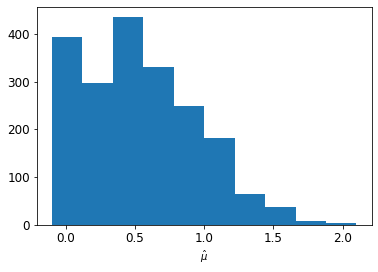

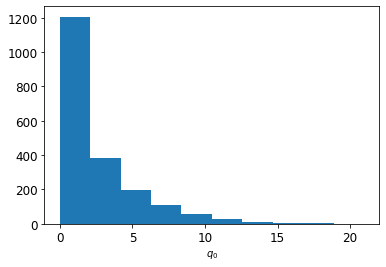

Z BL:(1.9715754428443746, 0.8222430344111813, 1.0172, 1.9740141445165393, 0.8096545080466224)
Z:1.1833335389528876
Z_std:1.2401653299824686
Z_1:0.20189992818934757
Z_std_1:11.840454152609006
9
AUC:0.9024562173550458
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

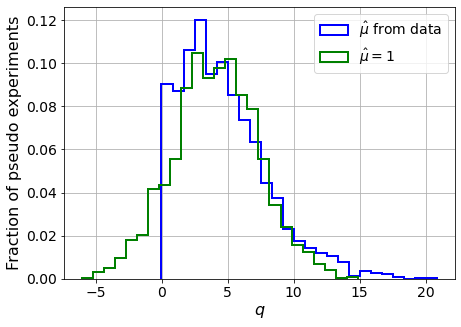

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  6688.9325659   6508.84468038
  6268.15785085  5949.88254297  5556.92687298  5093.11369532
  4514.35569765  3789.34406274  2916.99731931  1865.39357393
   613.35360088  -899.36064246 -2715.2093474  -5299.49321337]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  4214.17903939  4234.90300906  4244.01039134


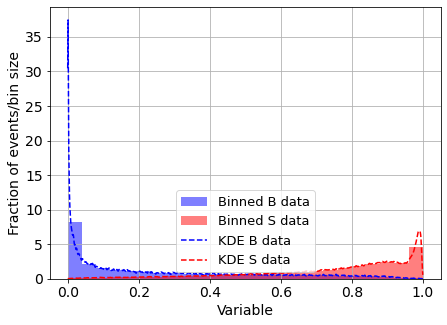

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.016750907843332472
0.016750907843332472
3 done
4 done
0.0
0.00016321900026653916


  2%|█                                                                 | 32/2000 [00:09<07:33,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3898506625681473
<p_{s}(Sdata)> = 2.1557129136427897
<p_{b}(Bdata)> = 6.065315275862479
<p_{s}(Bdata)> = 0.4211188181838755


  3%|█▋                                                                | 51/2000 [00:16<10:24,  3.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43722486483527834
<p_{s}(Sdata)> = 2.0637474167188783
<p_{b}(Bdata)> = 5.972849089811777
<p_{s}(Bdata)> = 0.41875661554240046


  4%|██▍                                                               | 75/2000 [00:23<07:42,  4.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4152798576218171
<p_{s}(Sdata)> = 1.8890476464813686
<p_{b}(Bdata)> = 5.989390637127262
<p_{s}(Bdata)> = 0.41725365686939314


  4%|██▊                                                               | 87/2000 [00:26<09:10,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47672000454405355
<p_{s}(Sdata)> = 2.0776228796207237
<p_{b}(Bdata)> = 6.119670041213043
<p_{s}(Bdata)> = 0.42003506429959114


  5%|███▍                                                             | 107/2000 [00:33<11:03,  2.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.397452573021689
<p_{s}(Sdata)> = 2.1086892007935485
<p_{b}(Bdata)> = 6.062065879415424
<p_{s}(Bdata)> = 0.42345803947244126


  6%|███▋                                                             | 112/2000 [00:34<09:26,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4015353524714911
<p_{s}(Sdata)> = 2.180803091793592
<p_{b}(Bdata)> = 6.016123026423846
<p_{s}(Bdata)> = 0.42121082517505437


  7%|████▎                                                            | 134/2000 [00:41<08:43,  3.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44048109947768344
<p_{s}(Sdata)> = 1.9947543755025736
<p_{b}(Bdata)> = 5.943370509069625
<p_{s}(Bdata)> = 0.4245954087032967


  7%|████▊                                                            | 148/2000 [00:46<08:41,  3.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4425323720316247
<p_{s}(Sdata)> = 1.7490455957135767
<p_{b}(Bdata)> = 5.976967369299796
<p_{s}(Bdata)> = 0.4155235113419808


  8%|█████▎                                                           | 163/2000 [00:50<09:01,  3.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4258050754758458
<p_{s}(Sdata)> = 2.150368420986924
<p_{b}(Bdata)> = 5.870510080206921
<p_{s}(Bdata)> = 0.4245948152019677


  8%|█████▎                                                           | 165/2000 [00:51<09:15,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5218652348865369
<p_{s}(Sdata)> = 1.9726191895835252
<p_{b}(Bdata)> = 6.062840983506658
<p_{s}(Bdata)> = 0.42062346186285887


  9%|█████▌                                                           | 172/2000 [00:53<10:10,  2.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43076178930990067
<p_{s}(Sdata)> = 1.9095580082979127
<p_{b}(Bdata)> = 5.975198525636721
<p_{s}(Bdata)> = 0.4183964240290665


 10%|██████▋                                                          | 204/2000 [01:04<10:22,  2.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4055732594756681
<p_{s}(Sdata)> = 1.9882218103559575
<p_{b}(Bdata)> = 5.936621158301468
<p_{s}(Bdata)> = 0.423999981157627


 10%|██████▊                                                          | 209/2000 [01:05<06:22,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42812518726824766
<p_{s}(Sdata)> = 2.0210553021036772
<p_{b}(Bdata)> = 6.0622716426048155
<p_{s}(Bdata)> = 0.41685645052950854


 13%|████████▍                                                        | 260/2000 [01:20<07:24,  3.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6138127156207899
<p_{s}(Sdata)> = 1.7418323862516338
<p_{b}(Bdata)> = 6.026664741150523
<p_{s}(Bdata)> = 0.42479432614158524


 13%|████████▋                                                        | 268/2000 [01:23<07:49,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42842974997913835
<p_{s}(Sdata)> = 2.11913691253972
<p_{b}(Bdata)> = 5.889546677461466
<p_{s}(Bdata)> = 0.4250814834159875


 14%|█████████                                                        | 279/2000 [01:25<05:23,  5.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4141344753605067
<p_{s}(Sdata)> = 2.1112169944204986
<p_{b}(Bdata)> = 5.967283052913242
<p_{s}(Bdata)> = 0.4274566664798271


 14%|█████████▎                                                       | 287/2000 [01:27<10:17,  2.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48097777003736925
<p_{s}(Sdata)> = 1.7236110875178685
<p_{b}(Bdata)> = 6.074998646124825
<p_{s}(Bdata)> = 0.4186987005507213


 15%|█████████▌                                                       | 295/2000 [01:30<08:18,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4062389622448901
<p_{s}(Sdata)> = 2.2818048282311727
<p_{b}(Bdata)> = 6.089640759187032
<p_{s}(Bdata)> = 0.41816247255534844


 17%|██████████▊                                                      | 332/2000 [01:41<08:37,  3.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44472302313418055
<p_{s}(Sdata)> = 1.741038121764356
<p_{b}(Bdata)> = 5.968853126540546
<p_{s}(Bdata)> = 0.4186780371294281


 17%|███████████▏                                                     | 344/2000 [01:45<10:07,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4262769152637979
<p_{s}(Sdata)> = 1.9382194216554955
<p_{b}(Bdata)> = 5.9018366057208524
<p_{s}(Bdata)> = 0.4222418382032394


 18%|███████████▍                                                     | 353/2000 [01:47<05:03,  5.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4122674335774817
<p_{s}(Sdata)> = 1.961856348185269
<p_{b}(Bdata)> = 5.979651117234083
<p_{s}(Bdata)> = 0.4234417307581493
muhat = -0.1
<p_{b}(Sdata)> = 0.43824259951029315
<p_{s}(Sdata)> = 1.9717982122245403
<p_{b}(Bdata)> = 6.044972837279632
<p_{s}(Bdata)> = 0.41601472594324357


 18%|███████████▌                                                     | 357/2000 [01:48<06:43,  4.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42060920321681033
<p_{s}(Sdata)> = 2.239755145424664
<p_{b}(Bdata)> = 5.980219193026601
<p_{s}(Bdata)> = 0.4196160131685907


 19%|████████████                                                     | 371/2000 [01:52<09:21,  2.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4244506025579189
<p_{s}(Sdata)> = 2.025945011680777
<p_{b}(Bdata)> = 6.0705881644409025
<p_{s}(Bdata)> = 0.41832032337203856


 20%|█████████████▏                                                   | 405/2000 [02:03<06:40,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41946710489918787
<p_{s}(Sdata)> = 2.115780075973822
<p_{b}(Bdata)> = 6.062431858973639
<p_{s}(Bdata)> = 0.41874156881455654


 22%|██████████████▌                                                  | 449/2000 [02:17<08:06,  3.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4327181837404292
<p_{s}(Sdata)> = 2.0166269213695736
<p_{b}(Bdata)> = 6.015539889036446
<p_{s}(Bdata)> = 0.41995826215712184


 23%|███████████████                                                  | 464/2000 [02:22<09:11,  2.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48093678166966003
<p_{s}(Sdata)> = 2.040411118318771
<p_{b}(Bdata)> = 6.093401389014274
<p_{s}(Bdata)> = 0.41282055780688265


 25%|████████████████▏                                                | 498/2000 [02:32<07:39,  3.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4361156500718555
<p_{s}(Sdata)> = 2.001118345723513
<p_{b}(Bdata)> = 6.082066910290734
<p_{s}(Bdata)> = 0.4167585517126324


 25%|████████████████▍                                                | 507/2000 [02:35<05:58,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3794546141413853
<p_{s}(Sdata)> = 2.189787502465279
<p_{b}(Bdata)> = 6.137859550918873
<p_{s}(Bdata)> = 0.4188675279720458


 26%|█████████████████▏                                               | 528/2000 [02:41<08:34,  2.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4423896771335834
<p_{s}(Sdata)> = 2.05505297213411
<p_{b}(Bdata)> = 5.9091002135487285
<p_{s}(Bdata)> = 0.4244378069510606


 27%|█████████████████▎                                               | 532/2000 [02:43<09:30,  2.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4300753499828545
<p_{s}(Sdata)> = 1.9357811879209197
<p_{b}(Bdata)> = 6.0369699751992165
<p_{s}(Bdata)> = 0.41887556846514395


 27%|█████████████████▍                                               | 535/2000 [02:44<08:38,  2.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4232132188039092
<p_{s}(Sdata)> = 2.0768773835731205
<p_{b}(Bdata)> = 5.9130851203206385
<p_{s}(Bdata)> = 0.41694584813589924


 28%|██████████████████                                               | 554/2000 [02:50<07:41,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40598969214706876
<p_{s}(Sdata)> = 2.038023585680841
<p_{b}(Bdata)> = 5.945212139357789
<p_{s}(Bdata)> = 0.42322295569826734


 29%|██████████████████▌                                              | 571/2000 [02:55<06:33,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39297885015324174
<p_{s}(Sdata)> = 2.237775030213537
<p_{b}(Bdata)> = 6.055093676111234
<p_{s}(Bdata)> = 0.4191439546041396


 29%|██████████████████▋                                              | 574/2000 [02:56<07:13,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5242472395079104
<p_{s}(Sdata)> = 1.5425349274926248
<p_{b}(Bdata)> = 5.9493453445593225
<p_{s}(Bdata)> = 0.4209412973472555


 29%|██████████████████▉                                              | 581/2000 [02:58<06:10,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44878123592442704
<p_{s}(Sdata)> = 2.026623662097435
<p_{b}(Bdata)> = 6.063135303803769
<p_{s}(Bdata)> = 0.4158109280888585


 30%|███████████████████▍                                             | 597/2000 [03:03<07:28,  3.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4721684468593414
<p_{s}(Sdata)> = 1.9807520190472845
<p_{b}(Bdata)> = 5.9317123388494695
<p_{s}(Bdata)> = 0.42143965894442503


 30%|███████████████████▋                                             | 604/2000 [03:05<05:18,  4.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4225070540079539
<p_{s}(Sdata)> = 1.9664379334851347
<p_{b}(Bdata)> = 5.9475986918684685
<p_{s}(Bdata)> = 0.425505786138292


 32%|████████████████████▋                                            | 638/2000 [03:16<06:34,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5164620096506509
<p_{s}(Sdata)> = 1.9754783282875152
<p_{b}(Bdata)> = 6.019219170768541
<p_{s}(Bdata)> = 0.42460705895940437


 34%|██████████████████████                                           | 677/2000 [03:28<07:38,  2.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49075336148535226
<p_{s}(Sdata)> = 2.0855583423645507
<p_{b}(Bdata)> = 6.04840718658454
<p_{s}(Bdata)> = 0.4230122146863414


 34%|██████████████████████▏                                          | 681/2000 [03:29<06:39,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.406266548579893
<p_{s}(Sdata)> = 2.05704767318948
<p_{b}(Bdata)> = 6.03168733272897
<p_{s}(Bdata)> = 0.42244539826775623


 35%|██████████████████████▊                                          | 703/2000 [03:35<07:48,  2.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4952420017146495
<p_{s}(Sdata)> = 2.1154012943124414
<p_{b}(Bdata)> = 5.943456184566781
<p_{s}(Bdata)> = 0.4193958168128985


 35%|███████████████████████                                          | 709/2000 [03:36<04:32,  4.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4078622655961705
<p_{s}(Sdata)> = 2.0833865638374864
<p_{b}(Bdata)> = 6.0842359307714275
<p_{s}(Bdata)> = 0.4252996021870683
muhat = 2.1
<p_{b}(Sdata)> = 0.38171527048879206
<p_{s}(Sdata)> = 2.5268831708937056
<p_{b}(Bdata)> = 5.824688164006498
<p_{s}(Bdata)> = 0.43278841622852376


 36%|███████████████████████▎                                         | 719/2000 [03:40<08:26,  2.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42045555081695574
<p_{s}(Sdata)> = 2.0860641045737642
<p_{b}(Bdata)> = 5.975471523243782
<p_{s}(Bdata)> = 0.4180546369747989


 36%|███████████████████████▍                                         | 723/2000 [03:41<06:55,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4989185339282182
<p_{s}(Sdata)> = 1.854452295865769
<p_{b}(Bdata)> = 6.0448810593485245
<p_{s}(Bdata)> = 0.4208229783553513


 37%|███████████████████████▊                                         | 732/2000 [03:44<06:17,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39398250681629965
<p_{s}(Sdata)> = 2.1312518349367764
<p_{b}(Bdata)> = 6.078490647350999
<p_{s}(Bdata)> = 0.42175208425146943


 37%|███████████████████████▉                                         | 738/2000 [03:45<06:55,  3.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4676368034939787
<p_{s}(Sdata)> = 1.734588926517366
<p_{b}(Bdata)> = 5.9877598894116595
<p_{s}(Bdata)> = 0.42479626322080727


 37%|████████████████████████▏                                        | 744/2000 [03:47<04:32,  4.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45187934103310345
<p_{s}(Sdata)> = 2.004760475821376
<p_{b}(Bdata)> = 5.9741684160277515
<p_{s}(Bdata)> = 0.42467697611554633


 37%|████████████████████████▏                                        | 745/2000 [03:47<04:33,  4.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4496920061983702
<p_{s}(Sdata)> = 1.9547334234511495
<p_{b}(Bdata)> = 6.088201034115059
<p_{s}(Bdata)> = 0.41940959972973757


 38%|████████████████████████▌                                        | 755/2000 [03:50<06:31,  3.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4948499659944332
<p_{s}(Sdata)> = 1.9477051274939388
<p_{b}(Bdata)> = 5.9239141640529045
<p_{s}(Bdata)> = 0.4280633958852815


 38%|████████████████████████▋                                        | 758/2000 [03:50<05:46,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44507806071900136
<p_{s}(Sdata)> = 2.0301052205914756
<p_{b}(Bdata)> = 5.953235200803742
<p_{s}(Bdata)> = 0.42341616867714504


 39%|█████████████████████████                                        | 773/2000 [03:55<05:05,  4.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.36041298722427484
<p_{s}(Sdata)> = 2.364915656311643
<p_{b}(Bdata)> = 6.092053503743958
<p_{s}(Bdata)> = 0.42806128524394427


 42%|███████████████████████████                                      | 831/2000 [04:14<06:13,  3.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3911600702631492
<p_{s}(Sdata)> = 2.173629237563006
<p_{b}(Bdata)> = 5.941343201558553
<p_{s}(Bdata)> = 0.425154840639371


 44%|████████████████████████████▋                                    | 881/2000 [04:30<06:48,  2.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43602626630753244
<p_{s}(Sdata)> = 2.1198862710857225
<p_{b}(Bdata)> = 6.02105561761643
<p_{s}(Bdata)> = 0.422360248442262


 44%|████████████████████████████▊                                    | 887/2000 [04:31<06:26,  2.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4752170259644017
<p_{s}(Sdata)> = 1.544508005765941
<p_{b}(Bdata)> = 5.89121766299855
<p_{s}(Bdata)> = 0.4194480867263245


 45%|█████████████████████████████▎                                   | 903/2000 [04:36<05:40,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3963130196213007
<p_{s}(Sdata)> = 2.0808773499309368
<p_{b}(Bdata)> = 6.1315550949290145
<p_{s}(Bdata)> = 0.4205142657880002


 47%|██████████████████████████████▊                                  | 948/2000 [04:50<03:42,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4437058202521572
<p_{s}(Sdata)> = 1.7817922315303587
<p_{b}(Bdata)> = 6.086215703406709
<p_{s}(Bdata)> = 0.4223414119521086
muhat = -0.1
<p_{b}(Sdata)> = 0.52377570675527
<p_{s}(Sdata)> = 1.780965222067743
<p_{b}(Bdata)> = 5.983471959503841
<p_{s}(Bdata)> = 0.4248984241362724


 48%|███████████████████████████████                                  | 955/2000 [04:51<03:08,  5.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45885623591217434
<p_{s}(Sdata)> = 1.9232078818359513
<p_{b}(Bdata)> = 6.061917582037834
<p_{s}(Bdata)> = 0.4169688200478012
muhat = -0.1
<p_{b}(Sdata)> = 0.39941156658226773
<p_{s}(Sdata)> = 2.1067969199001295
<p_{b}(Bdata)> = 5.9420105615250565
<p_{s}(Bdata)> = 0.4227849417945346
muhat = -0.1
<p_{b}(Sdata)> = 0.5395805904857629
<p_{s}(Sdata)> = 1.5743515207404593
<p_{b}(Bdata)> = 5.9839274371803715
<p_{s}(Bdata)> = 0.4272314915526031


 48%|███████████████████████████████▍                                 | 969/2000 [04:56<04:32,  3.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5279458964380775
<p_{s}(Sdata)> = 1.8304334275187497
<p_{b}(Bdata)> = 5.974169625203097
<p_{s}(Bdata)> = 0.423840462791602


 50%|████████████████████████████████                                | 1001/2000 [05:06<04:17,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42028353507759586
<p_{s}(Sdata)> = 2.301025965434977
<p_{b}(Bdata)> = 5.953984794265325
<p_{s}(Bdata)> = 0.42283588134089595


 51%|████████████████████████████████▋                               | 1020/2000 [05:11<04:32,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4091782600951923
<p_{s}(Sdata)> = 2.1137999289654337
<p_{b}(Bdata)> = 6.01285733755693
<p_{s}(Bdata)> = 0.41982104994026376


 53%|█████████████████████████████████▊                              | 1056/2000 [05:22<04:54,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4815871775013423
<p_{s}(Sdata)> = 2.095409213162508
<p_{b}(Bdata)> = 5.955075073471143
<p_{s}(Bdata)> = 0.41988320496161635


 53%|██████████████████████████████████▏                             | 1067/2000 [05:26<05:16,  2.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4576893878960062
<p_{s}(Sdata)> = 1.9112120708542861
<p_{b}(Bdata)> = 6.049394667349372
<p_{s}(Bdata)> = 0.4190840682943561


 54%|██████████████████████████████████▍                             | 1078/2000 [05:28<02:46,  5.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4826698762427482
<p_{s}(Sdata)> = 1.8619954922271629
<p_{b}(Bdata)> = 6.002357396307057
<p_{s}(Bdata)> = 0.4220001863893776
muhat = -0.1
<p_{b}(Sdata)> = 0.35375250193707874
<p_{s}(Sdata)> = 2.3361481122081296
<p_{b}(Bdata)> = 6.0627949501003
<p_{s}(Bdata)> = 0.41717357650500464


 55%|██████████████████████████████████▉                             | 1092/2000 [05:33<04:28,  3.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5161710823283091
<p_{s}(Sdata)> = 2.099111775299901
<p_{b}(Bdata)> = 6.051847416583517
<p_{s}(Bdata)> = 0.41973271862281436


 55%|███████████████████████████████████                             | 1096/2000 [05:34<04:32,  3.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40700184234840536
<p_{s}(Sdata)> = 2.143241303451261
<p_{b}(Bdata)> = 6.0486941493663915
<p_{s}(Bdata)> = 0.417492098953887


 56%|███████████████████████████████████▋                            | 1117/2000 [05:40<02:52,  5.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4494136752237243
<p_{s}(Sdata)> = 1.7012032921824563
<p_{b}(Bdata)> = 6.103804759027649
<p_{s}(Bdata)> = 0.4193077584099003
muhat = -0.1
<p_{b}(Sdata)> = 0.41101236332241814
<p_{s}(Sdata)> = 2.099321261046534
<p_{b}(Bdata)> = 5.897281872620896
<p_{s}(Bdata)> = 0.4238201986560376


 59%|█████████████████████████████████████▉                          | 1185/2000 [06:02<04:23,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4988911902015819
<p_{s}(Sdata)> = 1.7514090251340448
<p_{b}(Bdata)> = 5.996889985345537
<p_{s}(Bdata)> = 0.41807274032894876


 61%|███████████████████████████████████████▏                        | 1224/2000 [06:16<03:44,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37642353125899675
<p_{s}(Sdata)> = 2.263645498074768
<p_{b}(Bdata)> = 6.028111733107921
<p_{s}(Bdata)> = 0.418281031689468


 62%|███████████████████████████████████████▌                        | 1235/2000 [06:19<05:00,  2.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4750592992972239
<p_{s}(Sdata)> = 1.919799914959739
<p_{b}(Bdata)> = 6.029225423360459
<p_{s}(Bdata)> = 0.42506883486839325


 62%|███████████████████████████████████████▋                        | 1240/2000 [06:21<04:24,  2.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47594748333005854
<p_{s}(Sdata)> = 1.856672996190146
<p_{b}(Bdata)> = 6.014057197291007
<p_{s}(Bdata)> = 0.4221073523020408


 63%|████████████████████████████████████████▏                       | 1255/2000 [06:25<02:44,  4.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3511064974974471
<p_{s}(Sdata)> = 2.6104916833704754
<p_{b}(Bdata)> = 5.992806793474406
<p_{s}(Bdata)> = 0.4306212655920475
muhat = -0.1
<p_{b}(Sdata)> = 0.4287362139641081
<p_{s}(Sdata)> = 2.003028849681062
<p_{b}(Bdata)> = 5.974060497191301
<p_{s}(Bdata)> = 0.42263079244299173


 64%|████████████████████████████████████████▋                       | 1271/2000 [06:30<03:03,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4114133883807381
<p_{s}(Sdata)> = 1.997433573827803
<p_{b}(Bdata)> = 6.109017648670158
<p_{s}(Bdata)> = 0.42175636305022324


 64%|█████████████████████████████████████████                       | 1285/2000 [06:34<02:57,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4671680162180592
<p_{s}(Sdata)> = 2.094193523634579
<p_{b}(Bdata)> = 5.9680931797613335
<p_{s}(Bdata)> = 0.42253676366167037


 65%|█████████████████████████████████████████▊                      | 1305/2000 [06:40<02:04,  5.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42966909814549104
<p_{s}(Sdata)> = 2.262403126310867
<p_{b}(Bdata)> = 6.000739593123687
<p_{s}(Bdata)> = 0.41799191046456124
muhat = -0.1
<p_{b}(Sdata)> = 0.4400441299862165
<p_{s}(Sdata)> = 2.05969302838622
<p_{b}(Bdata)> = 5.97563099484647
<p_{s}(Bdata)> = 0.4205544099073927
muhat = -0.1
<p_{b}(Sdata)> = 0.4083820192617092
<p_{s}(Sdata)> = 1.9661622185659904
<p_{b}(Bdata)> = 5.977357280940183
<p_{s}(Bdata)> = 0.42027463704659573


 65%|█████████████████████████████████████████▊                      | 1307/2000 [06:40<01:37,  7.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45726788538208646
<p_{s}(Sdata)> = 1.7980501409210004
<p_{b}(Bdata)> = 5.992422234945931
<p_{s}(Bdata)> = 0.4227048856993911


 66%|██████████████████████████████████████████▎                     | 1322/2000 [06:45<03:59,  2.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4271048414506394
<p_{s}(Sdata)> = 1.8190247261393082
<p_{b}(Bdata)> = 5.972174240043738
<p_{s}(Bdata)> = 0.41679075730931714


 67%|██████████████████████████████████████████▌                     | 1332/2000 [06:48<04:04,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4713220814638936
<p_{s}(Sdata)> = 2.001748546292501
<p_{b}(Bdata)> = 5.958123112370777
<p_{s}(Bdata)> = 0.42309393619350477


 69%|████████████████████████████████████████████▎                   | 1383/2000 [07:05<03:58,  2.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44133854911788417
<p_{s}(Sdata)> = 2.0098963639900966
<p_{b}(Bdata)> = 6.047766973881442
<p_{s}(Bdata)> = 0.4258700256533095


 72%|██████████████████████████████████████████████▏                 | 1445/2000 [07:26<03:33,  2.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4773497150806315
<p_{s}(Sdata)> = 1.7906567419320962
<p_{b}(Bdata)> = 6.0222938754052775
<p_{s}(Bdata)> = 0.4211286954215134


 72%|██████████████████████████████████████████████▎                 | 1448/2000 [07:27<02:39,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4679494156796747
<p_{s}(Sdata)> = 1.8819458444754968
<p_{b}(Bdata)> = 6.01667966608739
<p_{s}(Bdata)> = 0.41674071669814333


 73%|██████████████████████████████████████████████▍                 | 1451/2000 [07:28<02:30,  3.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4752084473334495
<p_{s}(Sdata)> = 1.6313217409676855
<p_{b}(Bdata)> = 5.9054635299857
<p_{s}(Bdata)> = 0.42268514497179194


 74%|███████████████████████████████████████████████▏                | 1476/2000 [07:35<01:56,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43182049832072394
<p_{s}(Sdata)> = 2.0858318307386114
<p_{b}(Bdata)> = 6.106968502313991
<p_{s}(Bdata)> = 0.4184895439734408
muhat = -0.1
<p_{b}(Sdata)> = 0.4304254953442435
<p_{s}(Sdata)> = 1.847287640101304
<p_{b}(Bdata)> = 5.969298107797378
<p_{s}(Bdata)> = 0.4197738254093929


 74%|███████████████████████████████████████████████▌                | 1485/2000 [07:38<02:49,  3.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4394628861955607
<p_{s}(Sdata)> = 1.9814022250840484
<p_{b}(Bdata)> = 5.9315386130653
<p_{s}(Bdata)> = 0.4231152922146725


 74%|███████████████████████████████████████████████▋                | 1490/2000 [07:40<02:53,  2.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47876855404326585
<p_{s}(Sdata)> = 1.7076961890808653
<p_{b}(Bdata)> = 6.009394369506729
<p_{s}(Bdata)> = 0.4217472826442932


 75%|███████████████████████████████████████████████▉                | 1497/2000 [07:42<02:09,  3.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.433226645000227
<p_{s}(Sdata)> = 2.1073958206522283
<p_{b}(Bdata)> = 6.087190787308799
<p_{s}(Bdata)> = 0.4152490060362572


 76%|████████████████████████████████████████████████▊               | 1526/2000 [07:52<02:49,  2.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4730333154522365
<p_{s}(Sdata)> = 1.827500428504866
<p_{b}(Bdata)> = 5.97479125296702
<p_{s}(Bdata)> = 0.42083456012351733


 76%|████████████████████████████████████████████████▉               | 1528/2000 [07:52<02:13,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4910949168364019
<p_{s}(Sdata)> = 1.8285766152118839
<p_{b}(Bdata)> = 6.08735882832044
<p_{s}(Bdata)> = 0.4169759255749208


 78%|█████████████████████████████████████████████████▉              | 1559/2000 [08:03<02:16,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44315939673282106
<p_{s}(Sdata)> = 2.023487943827466
<p_{b}(Bdata)> = 6.11160297860439
<p_{s}(Bdata)> = 0.41847525369223


 79%|██████████████████████████████████████████████████▎             | 1574/2000 [08:07<02:08,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41137638373111385
<p_{s}(Sdata)> = 2.3544135834362274
<p_{b}(Bdata)> = 6.137829745805202
<p_{s}(Bdata)> = 0.4157933410008389


 79%|██████████████████████████████████████████████████▍             | 1577/2000 [08:08<01:42,  4.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43461805688792166
<p_{s}(Sdata)> = 2.1049807800916227
<p_{b}(Bdata)> = 5.8599256241929965
<p_{s}(Bdata)> = 0.42389734897523895


 80%|██████████████████████████████████████████████████▉             | 1592/2000 [08:12<02:23,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4319057533568033
<p_{s}(Sdata)> = 1.830878383955779
<p_{b}(Bdata)> = 6.0674385654693515
<p_{s}(Bdata)> = 0.4206604803907866


 80%|███████████████████████████████████████████████████             | 1594/2000 [08:13<02:03,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42570744309166697
<p_{s}(Sdata)> = 2.077127352892648
<p_{b}(Bdata)> = 5.968304815700935
<p_{s}(Bdata)> = 0.4185308034412246


 80%|███████████████████████████████████████████████████             | 1597/2000 [08:14<01:50,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4052102799165711
<p_{s}(Sdata)> = 1.923892621106444
<p_{b}(Bdata)> = 5.980729389231742
<p_{s}(Bdata)> = 0.420457268200014


 82%|████████████████████████████████████████████████████▌           | 1644/2000 [08:29<01:42,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4425334277360625
<p_{s}(Sdata)> = 2.018480774175135
<p_{b}(Bdata)> = 5.957102713345539
<p_{s}(Bdata)> = 0.41891015457825964


 83%|████████████████████████████████████████████████████▉           | 1655/2000 [08:32<01:24,  4.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4079004704486197
<p_{s}(Sdata)> = 2.005249413416252
<p_{b}(Bdata)> = 5.881168149988007
<p_{s}(Bdata)> = 0.4219824932794778


 83%|█████████████████████████████████████████████████████▏          | 1661/2000 [08:33<01:06,  5.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40545455826910076
<p_{s}(Sdata)> = 2.1279893329451256
<p_{b}(Bdata)> = 6.116932395321872
<p_{s}(Bdata)> = 0.4161178927217928


 86%|███████████████████████████████████████████████████████▏        | 1723/2000 [08:52<01:10,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49267678836309736
<p_{s}(Sdata)> = 1.787011542993322
<p_{b}(Bdata)> = 6.109979903971162
<p_{s}(Bdata)> = 0.42170006747882394


 87%|███████████████████████████████████████████████████████▊        | 1745/2000 [08:59<01:13,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45403740062931036
<p_{s}(Sdata)> = 1.9485879955126233
<p_{b}(Bdata)> = 5.98788894150255
<p_{s}(Bdata)> = 0.4214932748856985


 91%|█████████████████████████████████████████████████████████▉      | 1811/2000 [09:20<00:56,  3.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4543155059544327
<p_{s}(Sdata)> = 2.0742113709176024
<p_{b}(Bdata)> = 6.047053309125331
<p_{s}(Bdata)> = 0.41706414641230494


 92%|██████████████████████████████████████████████████████████▋     | 1833/2000 [09:28<00:44,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44326470376640076
<p_{s}(Sdata)> = 2.062953421000618
<p_{b}(Bdata)> = 6.076556753184114
<p_{s}(Bdata)> = 0.41914055140451223
muhat = -0.1
<p_{b}(Sdata)> = 0.5266051153208658
<p_{s}(Sdata)> = 1.798487880615209
<p_{b}(Bdata)> = 5.929281246135767
<p_{s}(Bdata)> = 0.42418189354599906
muhat = -0.1
<p_{b}(Sdata)> = 0.4233851089137052
<p_{s}(Sdata)> = 2.140680550835297
<p_{b}(Bdata)> = 5.989874631511626
<p_{s}(Bdata)> = 0.4189492890722591


 92%|██████████████████████████████████████████████████████████▊     | 1836/2000 [09:28<00:32,  5.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37610331823343773
<p_{s}(Sdata)> = 2.468047107375262
<p_{b}(Bdata)> = 5.967884765300591
<p_{s}(Bdata)> = 0.42978600225916097


 92%|██████████████████████████████████████████████████████████▉     | 1843/2000 [09:30<00:35,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5075830412600137
<p_{s}(Sdata)> = 1.709350091316764
<p_{b}(Bdata)> = 6.0324423037762935
<p_{s}(Bdata)> = 0.41971198992104025
muhat = -0.1
<p_{b}(Sdata)> = 0.4384131786063
<p_{s}(Sdata)> = 2.284303106677031
<p_{b}(Bdata)> = 5.988378525839162
<p_{s}(Bdata)> = 0.41907493070412705


 92%|███████████████████████████████████████████████████████████     | 1847/2000 [09:31<00:52,  2.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44465155875767254
<p_{s}(Sdata)> = 1.9458883171855241
<p_{b}(Bdata)> = 5.958286925081366
<p_{s}(Bdata)> = 0.42006430051100435


 94%|███████████████████████████████████████████████████████████▊    | 1870/2000 [09:39<00:55,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40951674086471834
<p_{s}(Sdata)> = 2.01700476632062
<p_{b}(Bdata)> = 6.062723257345804
<p_{s}(Bdata)> = 0.4204934510167751


 94%|████████████████████████████████████████████████████████████▎   | 1884/2000 [09:43<00:28,  4.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4803811264739069
<p_{s}(Sdata)> = 1.8528257498935556
<p_{b}(Bdata)> = 6.139766218617955
<p_{s}(Bdata)> = 0.4166211352818768


 94%|████████████████████████████████████████████████████████████▍   | 1887/2000 [09:44<00:31,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4264044165837139
<p_{s}(Sdata)> = 2.027377542400065
<p_{b}(Bdata)> = 6.044459599515764
<p_{s}(Bdata)> = 0.42345540288514444


 95%|████████████████████████████████████████████████████████████▊   | 1899/2000 [09:47<00:28,  3.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3889965025428841
<p_{s}(Sdata)> = 2.164233356709345
<p_{b}(Bdata)> = 6.02503990299598
<p_{s}(Bdata)> = 0.4167341920815012


 95%|████████████████████████████████████████████████████████████▊   | 1901/2000 [09:48<00:30,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.387852589685287
<p_{s}(Sdata)> = 2.024615820460898
<p_{b}(Bdata)> = 6.037004289354695
<p_{s}(Bdata)> = 0.4211608060877915


 96%|█████████████████████████████████████████████████████████████▎  | 1915/2000 [09:52<00:26,  3.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4721197739693002
<p_{s}(Sdata)> = 1.9584774560342473
<p_{b}(Bdata)> = 5.984939631442904
<p_{s}(Bdata)> = 0.41792111944445925


 96%|█████████████████████████████████████████████████████████████▌  | 1924/2000 [09:55<00:24,  3.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4772326179516699
<p_{s}(Sdata)> = 2.268594230869483
<p_{b}(Bdata)> = 6.03162148094277
<p_{s}(Bdata)> = 0.4298700655684922


 97%|██████████████████████████████████████████████████████████████  | 1940/2000 [10:00<00:18,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4798456808748262
<p_{s}(Sdata)> = 1.8907608162838203
<p_{b}(Bdata)> = 5.935873720125702
<p_{s}(Bdata)> = 0.42320827534640326


 98%|██████████████████████████████████████████████████████████████▊ | 1963/2000 [10:08<00:09,  3.89it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.43018148583828514
<p_{s}(Sdata)> = 2.5914760080738093
<p_{b}(Bdata)> = 5.9661717213256455
<p_{s}(Bdata)> = 0.42932255386165985


 98%|██████████████████████████████████████████████████████████████▉ | 1966/2000 [10:09<00:10,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46609116285732194
<p_{s}(Sdata)> = 1.8698036812578795
<p_{b}(Bdata)> = 6.081193695215313
<p_{s}(Bdata)> = 0.4170799910311029


100%|███████████████████████████████████████████████████████████████▉| 1997/2000 [10:19<00:01,  2.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.362426146359895
<p_{s}(Sdata)> = 2.2083165642912705
<p_{b}(Bdata)> = 6.084508461414165
<p_{s}(Bdata)> = 0.4169429507682618


100%|████████████████████████████████████████████████████████████████| 2000/2000 [10:19<00:00,  3.23it/s]


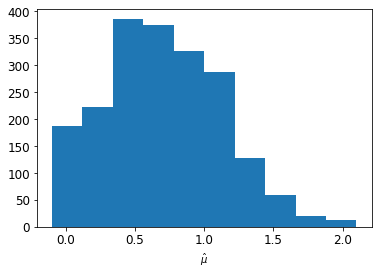

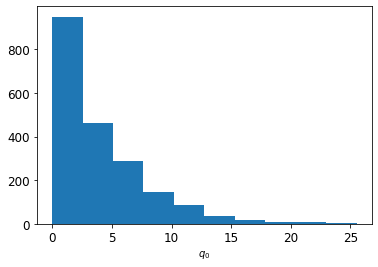

Z BL:(2.0431526613431834, 0.8099215763361449, 1.0301500000000001, 2.0432508867329604, 0.7889171204429405)
Z:1.6726305726776798
Z_std:1.1817712040103723
Z_1:1.4877229283823536
Z_std_1:1.7141323800573507


<Figure size 432x288 with 0 Axes>

In [56]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)
num_pseudo = 2000

Z_BL        = []

Z_MLL        = []
Z_MLL_std    = []
Z_MLL_mu     = []
Z_MLL_std_mu = []

auc_total   = []
auc_wgamma  = []
auc_wjets   = []
auc_ttgamma = []
for iloop in range(10):
    
    print(iloop)
    nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
    df = pd.DataFrame()


    #np.random.seed(28890)

    SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

    df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
    df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
    df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
    df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

    df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
    df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
    df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

    df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
    df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
    df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
    df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
    df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

    df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
    df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

    df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
    df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
    df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

    df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
    df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
    #df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

    df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
    df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
    df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])


    df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

    df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

    df_array = np.asarray(df)
    
    df_test = pd.DataFrame()

    SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

    df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
    df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
    df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
    df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

    df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
    df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
    df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

    df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
    df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
    df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
    df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
    df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

    df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
    df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

    df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
    df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
    df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

    df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
    df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
    #df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

    df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
    df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
    df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])


    df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

    df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

    df_test_array = np.asarray(df_test)
    
    nobs = len(df_array)

    train_size = int(0.80 * nobs)
    val_size   = nobs - train_size #%- test_size 

    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    val_indices   = random_indices[train_size:]
    
    
    X_train        = df_array[train_indices, :22]
    bkg_flag_train = df_array[train_indices, 22]
    y_mon_train    = df_array[train_indices, -1]

    X_test        = df_test_array[:, :22]
    bkg_flag_test = df_test_array[:, 22]
    y_mon_test    = df_test_array[:, -1]

    X_val        = df_array[val_indices, :22]
    bkg_flag_val = df_array[val_indices, 22]
    y_mon_val    = df_array[val_indices, -1]
    
    # to normalize
    x_scaler = preprocessing.MinMaxScaler()
    x_scaler = x_scaler.fit(X_train)

    X_mon_train = x_scaler.transform(X_train)
    X_mon_test  = x_scaler.transform(X_test)
    X_mon_val   = x_scaler.transform(X_val)
    
    
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators  = 500,
        learning_rate = 0.1,
        reg_lambda    = 0.0, reg_alpha = 0.0,
        early_stopping_rounds = 50,#early stopping
        eval_metric = 'logloss',
        gamma = 0.0, objective = 'binary:logistic',
        max_depth = 5)

    # FIT
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose  = False)

    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

    pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
    pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
    
    
    # Let's estimate the ROC Curve
    nvals = 50
    tpr_total   = np.zeros(nvals) 
    fpr_total   = np.zeros(nvals) 
    tpr_ttgamma = np.zeros(nvals) 
    fpr_ttgamma = np.zeros(nvals) 
    tpr_wgamma  = np.zeros(nvals) 
    fpr_wgamma  = np.zeros(nvals) 
    tpr_wjets   = np.zeros(nvals) 
    fpr_wjets   = np.zeros(nvals) 

    for ith, th in enumerate(np.linspace(0,1, nvals)):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_total[ith] = len(tp) / (len(tp) + len(fn))
        fpr_total[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma.append( auc(fpr_ttgamma, tpr_ttgamma) )
    auc_wjets.append( auc(fpr_wjets, tpr_wjets) )
    auc_wgamma.append( auc(fpr_wgamma, tpr_wgamma) )
    auc_total.append( auc(fpr_total, tpr_total) )
    
    
    print('AUC:' + str(auc_total[iloop]))
    
    Z_BL.append( BL_test_fast('discovery', pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, 5, linear_bins=True) )

    
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    print(np.min(pB_B_data))
    pB_B_data[np.where(pB_B_data == 0 )[0]] = np.min(pB_B_data[np.where(pB_B_data > 0 )[0]])
    pS_B_data[np.where(pS_B_data == 0 )[0]] = np.min(pS_B_data[np.where(pS_B_data > 0 )[0]])
    print(np.min(pB_B_data))

    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    print(np.min(pB_S_data))
    pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
    pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
    print(np.min(pB_S_data))

    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(2000)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])


        if np.min(prob_x_given_B) == 0:
            print('There are events with p(s)=0')
            prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])

        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )
    
    plt.hist(np.asarray(muhat_selected_MLL_list))
    plt.xlabel(r'$\hat{\mu}$')
    plt.savefig('../graph/BP' + str(bp+1) + '/muhat_hist_' + str(iloop) + '_MET200.pdf')
    plt.show()
    plt.clf()
    
    plt.hist(np.asarray(q_muhat_MLL))
    plt.xlabel(r'$q_{0}$')
    plt.savefig('../graph/BP' + str(bp+1) + '/q0_hist_' + str(iloop) + '_MET200.pdf')
    plt.show()
    plt.clf()
    print('Z BL:' + str(Z_BL[iloop]))
    print('Z:' + str(Z_MLL[iloop]))
    print('Z_std:' + str(Z_MLL_std[iloop]))
    print('Z_1:' + str(Z_MLL_mu[iloop]))
    print('Z_std_1:' + str(Z_MLL_std_mu[iloop]))

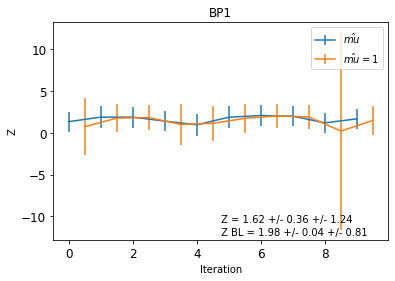

In [57]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.text(0.5,0.08, 'Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + 
         '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(Z_MLL_std)),
         transform = plt.gca().transAxes)
plt.text(0.5,0.02, 'Z BL = ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,0])) + ' +/- ' + 
         '{:.2f}'.format(np.std(np.asarray(Z_BL)[:,0])) + ' +/- ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,1])), transform = plt.gca().transAxes)
plt.title('BP' + str(bp+1))
plt.xlabel('Iteration')
plt.savefig('../graph/loopBP' + str(bp+1) + '_50000_MLLvariable_MET200_new.pdf')

In [58]:
Z_MLL

[1.3264905062970025,
 1.87090700922247,
 1.8768264000918506,
 1.3994539072197618,
 0.9461781831262548,
 1.8645388918932022,
 2.066127730662656,
 1.9890897642827834,
 1.1833335389528876,
 1.6726305726776798]

In [59]:
np.asarray(Z_BL)[:,0]

array([1.94420869, 1.92795777, 1.92029847, 1.98091104, 1.99445123,
       2.02827438, 1.96390684, 2.01372121, 1.97157544, 2.04315266])

In [60]:
print('Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(Z_MLL_std)))
print('Z BL = ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,0])) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_BL)[:,0]))  + ' +/- ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,1])) )

Z = 1.62 +/- 0.36 +/- 1.24
Z BL = 1.98 +/- 0.04 +/- 0.81


In [61]:
print('AUC : ' + str(np.mean(np.asarray(auc_total))) + ' +/- ' + str(np.std(np.asarray(auc_total))))

AUC : 0.9025653368784727 +/- 0.00037294778955771667
